<a href="https://colab.research.google.com/github/purnomo03/Tugas-4-Deep-Learning-Lanjut_DCGAN_Eko-Purnomo/blob/main/41236697_Model_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nim : 41236697

Nama : Eko Purnomo

Kelas : TI-2023-KIP-P2

Prodi : Teknik Informatika

Mata Kuliah : Deep Learning Lanjut

Tugas : Tugas Individu Ke-4

Pertemuan : 4 (Keempat)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Konfigurasi agar GPU digunakan secara efisien
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Terdeteksi: ", physical_devices[0])
else:
    print("Peringatan: GPU tidak terdeteksi. Training akan lambat.")

GPU Terdeteksi:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
# IMPORTANT: Make sure you have uploaded kaggle.json to your Colab session's /content/ directory first.
# If you uploaded it somewhere else, adjust the source path accordingly.
!mv /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/

# Set read-only permissions for the kaggle.json file for security
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials set up successfully!")

Kaggle API credentials set up successfully!


In [4]:
# Install kaggle if not already installed
!pip install -q kaggle

# Make sure your Kaggle API credentials (kaggle.json) are set up in ~/.kaggle/
# If you haven't done this, please refer to the previous instructions.

# Download the dataset
!kaggle datasets download -d joosthazelzet/lego-brick-images

# Unzip the downloaded dataset to the specified directory
# The zip file will be downloaded to the current working directory (/content/)
!unzip -q /content/lego-brick-images.zip -d /content/dataset/

# Clean up the zip file after extraction
!rm /content/lego-brick-images.zip

print("Dataset downloaded and extracted to /content/dataset/")

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
 99% 0.99G/1.00G [00:04<00:00, 199MB/s]
100% 1.00G/1.00G [00:05<00:00, 213MB/s]
Dataset downloaded and extracted to /content/dataset/


In [5]:
# Parameter Konfigurasi
BATCH_SIZE = 64
IMG_HEIGHT = 64  # Menggunakan 64x64 agar detail LEGO cukup terlihat
IMG_WIDTH = 64
CHANNELS = 3     # RGB


# --- OPSI B: Membuat Dataset Loader ---
# Ganti 'path/to/images' dengan path folder dataset Anda
dataset_dir = '/content/dataset/LEGO brick images v1'

# Jika folder kosong/tidak ada, kita buat dummy data agar kode tetap jalan (untuk testing)
if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
    print("Dataset tidak ditemukan. Membuat data dummy untuk demonstrasi struktur kode.")
    os.makedirs(dataset_dir, exist_ok=True)
    # Membuat 100 gambar random noise sebagai placeholder
    for i in range(100):
        img = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
        tf.keras.utils.save_img(f"{dataset_dir}/dummy_{i}.png", img)

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    label_mode=None, # Kita tidak butuh label untuk GAN
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Normalisasi ke [-1, 1]
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

# Optimasi performa (Caching & Prefetching)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6379 files.


In [6]:
latent_dim = 128

def build_generator():
    model = keras.Sequential(name="generator")

    # Input: Latent Vector
    # Mulai dengan dense layer yang cukup besar untuk di-reshape
    # Kita ingin mulai dari ukuran 8x8 dengan 512 filter
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape menjadi tensor 3D
    model.add(layers.Reshape((8, 8, 512)))

    # Upsampling 1: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 2: 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 3: 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output Layer: 64x64 -> 64x64x3 (RGB)
    # Aktivasi TANH penting agar output di range [-1, 1]
    model.add(layers.Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh'))

    return model

def build_discriminator():
    model = keras.Sequential(name="discriminator")

    # Input: Gambar 64x64x3
    # Downsampling 1: 64 -> 32
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 2: 32 -> 16
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 3: 16 -> 8
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten dan Output
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output berupa logit (skor real/fake)

    return model

# Inisialisasi Model
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
# discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,081,411 (27.01 MB)

 Trainable params: 7,014,979 (26.76 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [7]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        # Metric trackers
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # 1. Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2. Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # 3. Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4. Assemble labels discriminating real from fake images
        # Label 1 untuk fake, 0 untuk real (atau sebaliknya, teknik ini menggunakan label smoothing)
        # Di sini kita pakai standar: 1=Real, 0=Fake.
        # Namun, karena kita concat [Fake, Real], maka labelnya: [0...0, 1...1]
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Tambahkan sedikit noise pada label (Label Smoothing) untuk stabilitas
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 5. Train the Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 6. Sample random points in the latent space (lagi, untuk Generator)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 7. Assemble labels that say "all real images" (We want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # 8. Train the Generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [8]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(10, 4))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"Epoch {epoch+1}")
        plt.show() # Tampilkan inline di Colab

        # Opsional: Simpan ke file
        # plt.savefig(f"generated_lego_epoch_{epoch}.png")
        # plt.close()

### **1. MELATIH MODEL (TRAINING)**

Mulai Training...
Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - d_loss: 0.4904 - g_loss: 0.7183

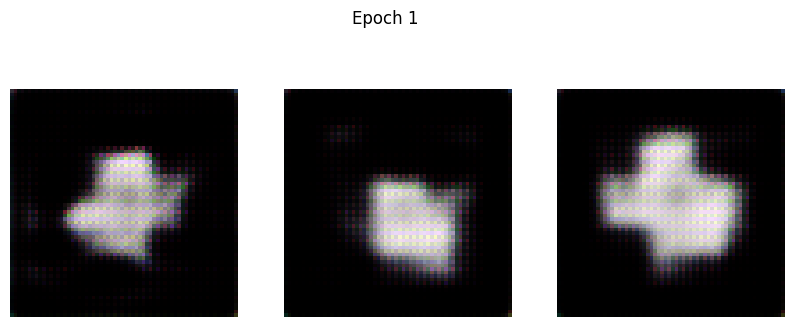

100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 236ms/step - d_loss: 0.4909 - g_loss: 0.7185
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.6703 - g_loss: 0.7107

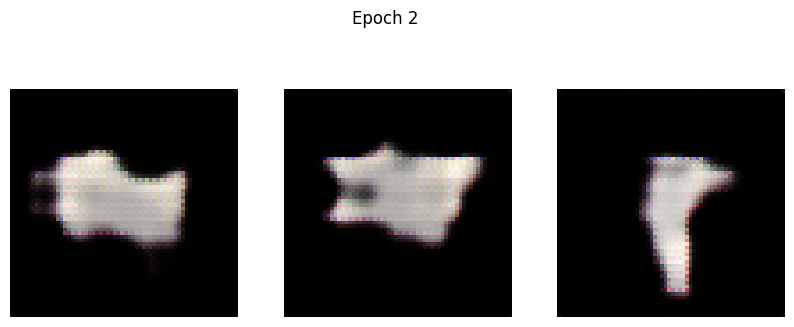

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.6703 - g_loss: 0.7109
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6764 - g_loss: 0.7300

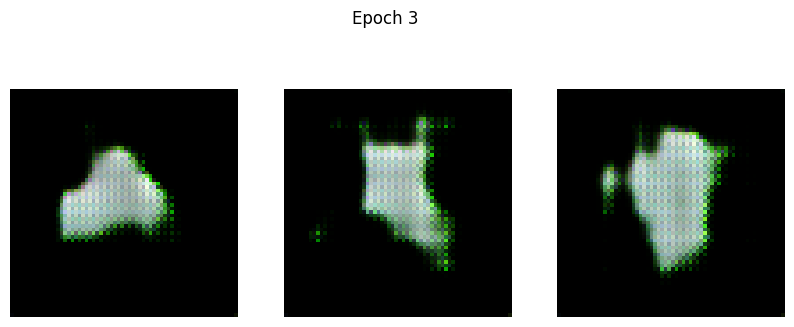

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6763 - g_loss: 0.7302
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.6637 - g_loss: 0.7638

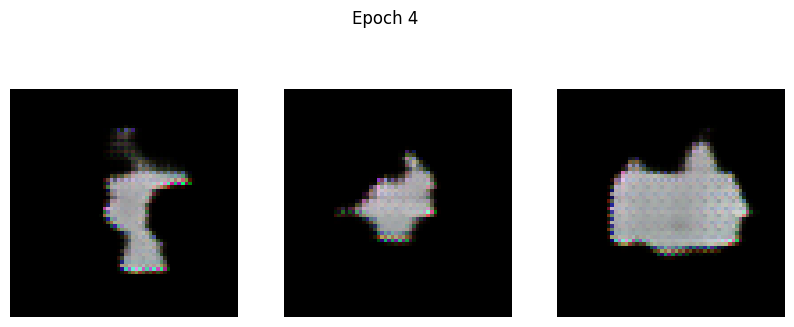

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.6637 - g_loss: 0.7639
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.6653 - g_loss: 0.7446

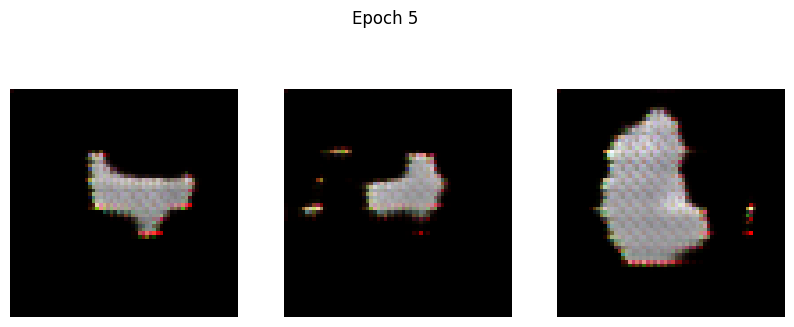

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.6653 - g_loss: 0.7445
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6532 - g_loss: 0.7831

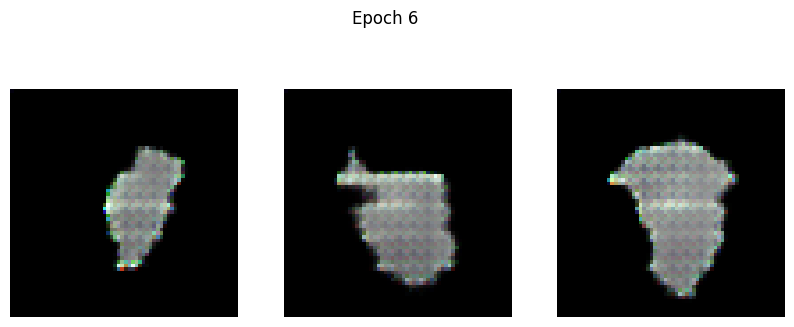

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.6533 - g_loss: 0.7830
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6568 - g_loss: 0.7843

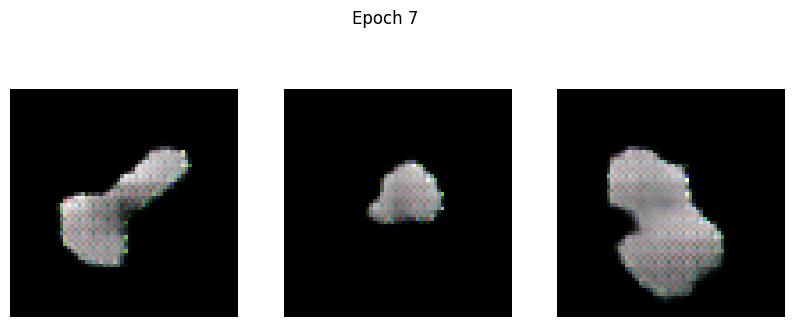

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6567 - g_loss: 0.7841
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.6620 - g_loss: 0.7652

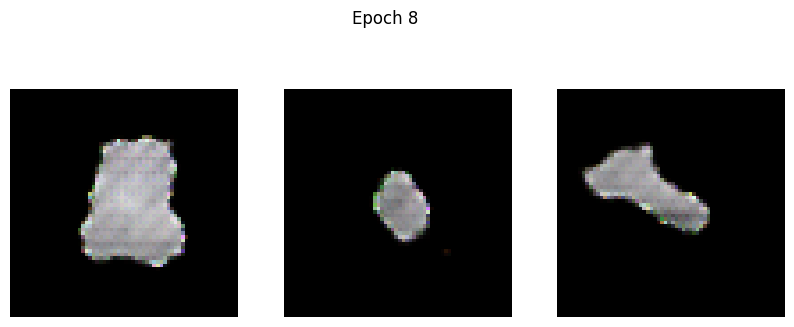

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.6620 - g_loss: 0.7651
Epoch 9/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6578 - g_loss: 0.7413

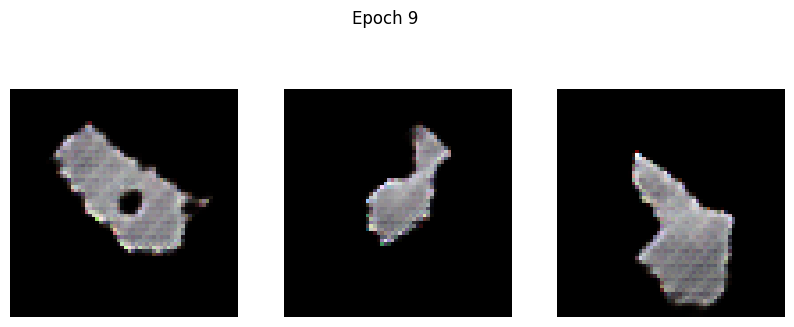

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6578 - g_loss: 0.7413
Epoch 10/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.6519 - g_loss: 0.7454

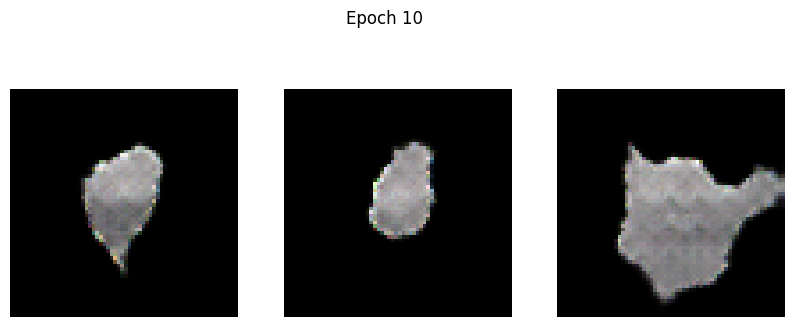

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.6519 - g_loss: 0.7455
Epoch 11/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.6520 - g_loss: 0.7475

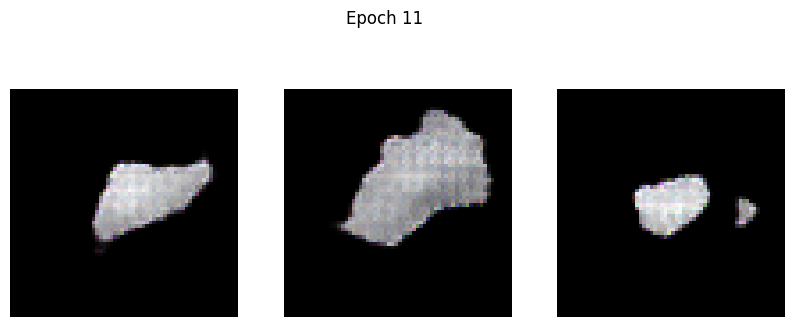

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.6521 - g_loss: 0.7476
Epoch 12/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.6470 - g_loss: 0.7859

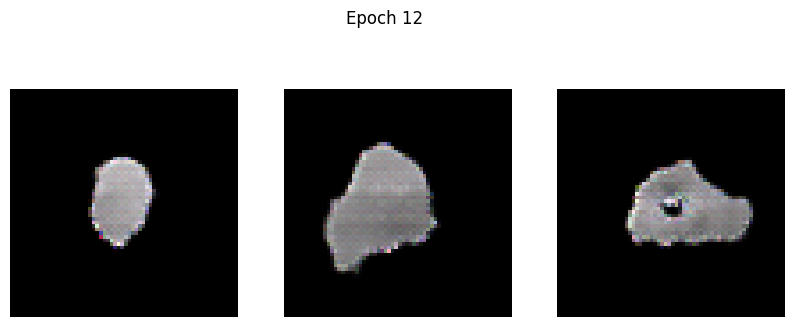

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.6470 - g_loss: 0.7860
Epoch 13/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6398 - g_loss: 0.8321

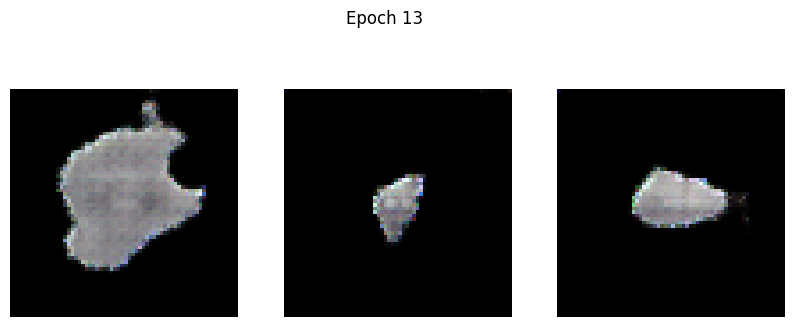

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.6398 - g_loss: 0.8320
Epoch 14/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6218 - g_loss: 0.8473

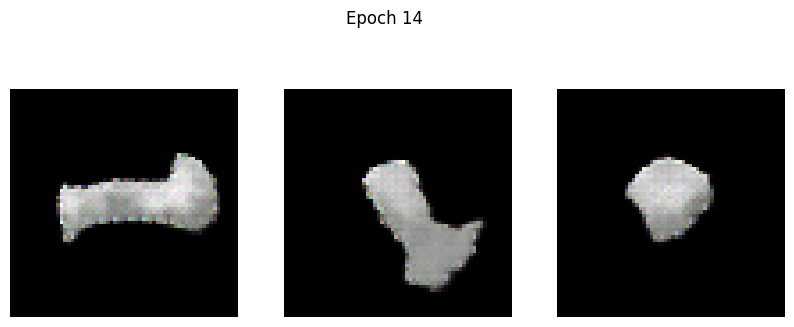

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6218 - g_loss: 0.8474
Epoch 15/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6148 - g_loss: 0.8664

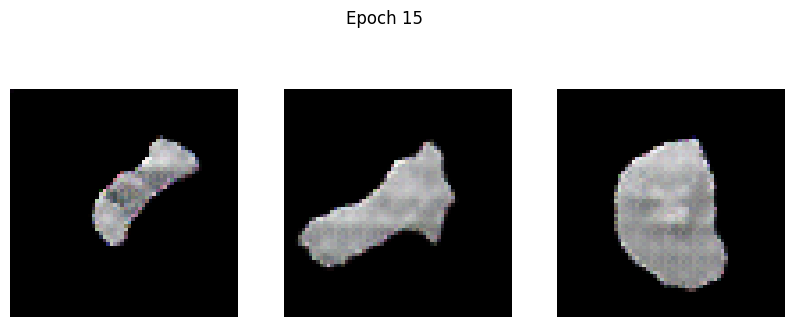

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6148 - g_loss: 0.8665
Epoch 16/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6081 - g_loss: 0.9486

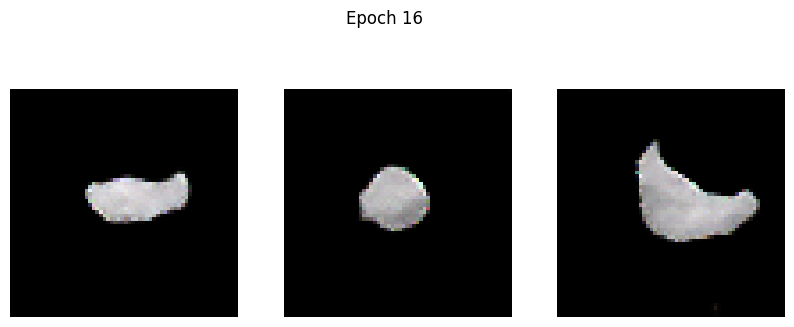

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6080 - g_loss: 0.9484
Epoch 17/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5920 - g_loss: 0.8967

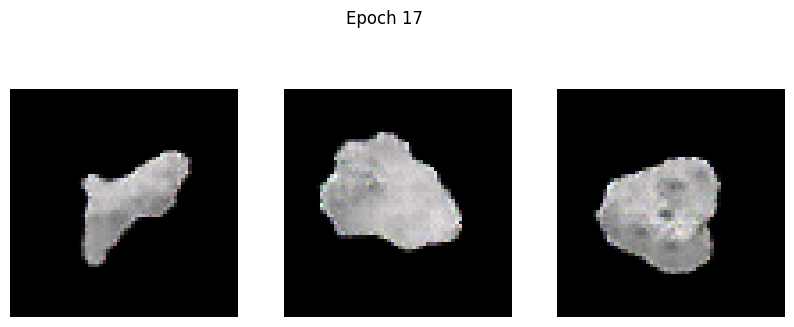

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5920 - g_loss: 0.8968
Epoch 18/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5728 - g_loss: 0.9073

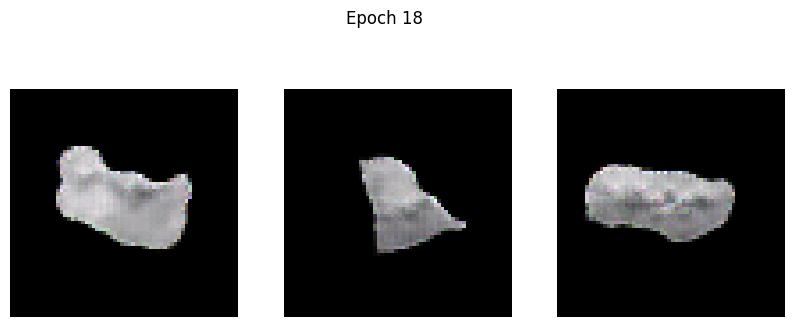

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5729 - g_loss: 0.9074
Epoch 19/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5789 - g_loss: 0.9405

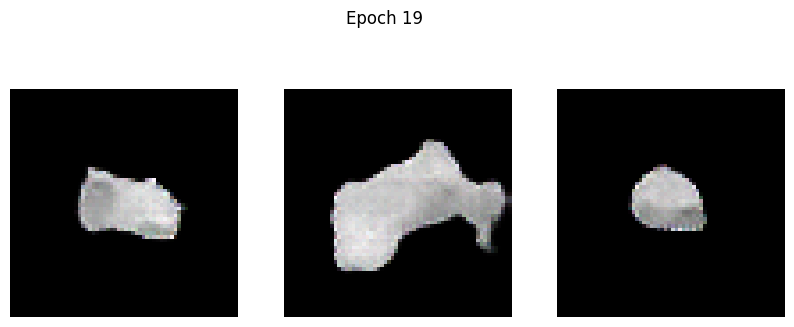

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5788 - g_loss: 0.9404
Epoch 20/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5622 - g_loss: 0.9648

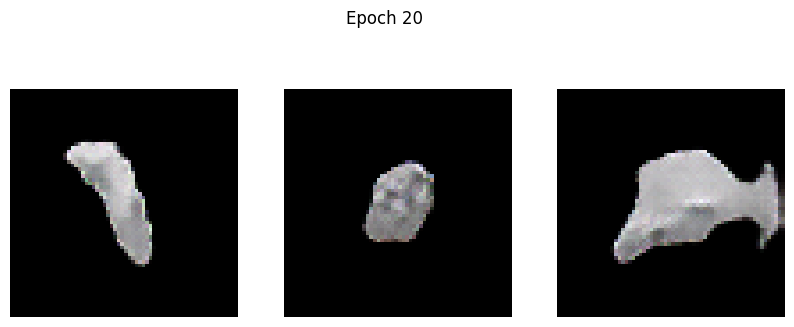

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5622 - g_loss: 0.9648
Epoch 21/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5564 - g_loss: 0.9641

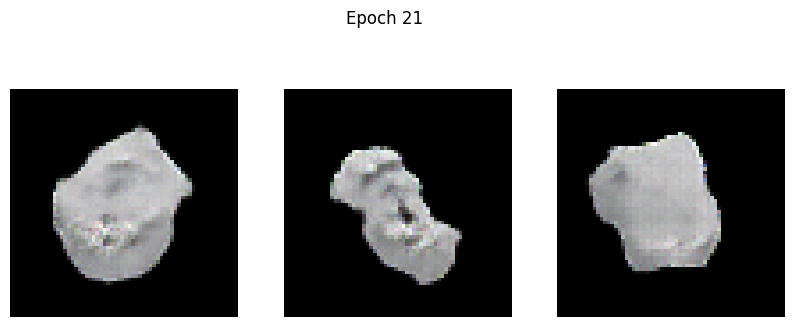

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5564 - g_loss: 0.9644
Epoch 22/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5536 - g_loss: 1.0634

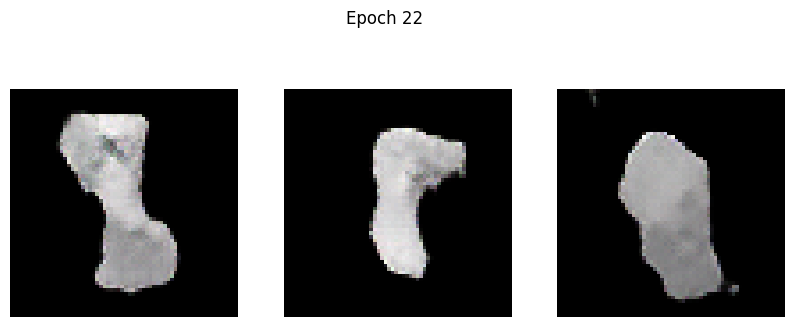

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5535 - g_loss: 1.0630
Epoch 23/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5313 - g_loss: 1.0563

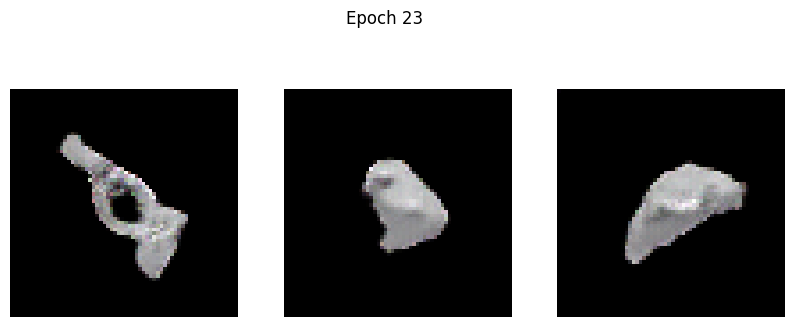

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5313 - g_loss: 1.0564
Epoch 24/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5306 - g_loss: 1.0761

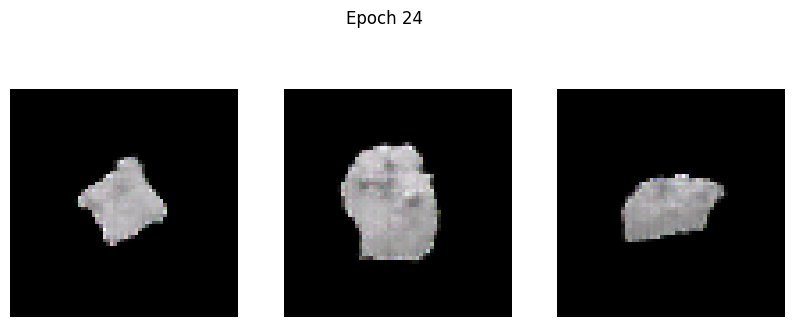

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5308 - g_loss: 1.0767
Epoch 25/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4995 - g_loss: 1.0820

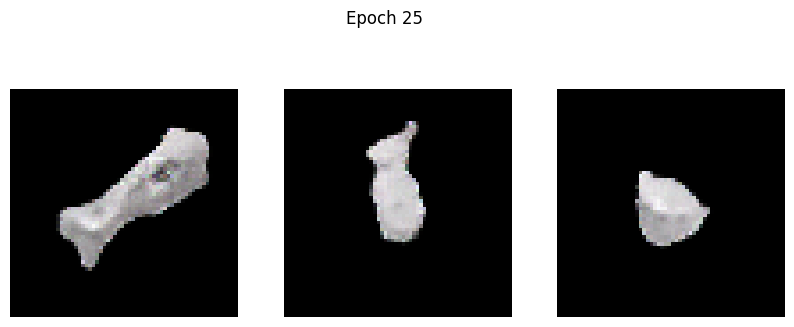

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.4994 - g_loss: 1.0821
Epoch 26/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5131 - g_loss: 1.1817

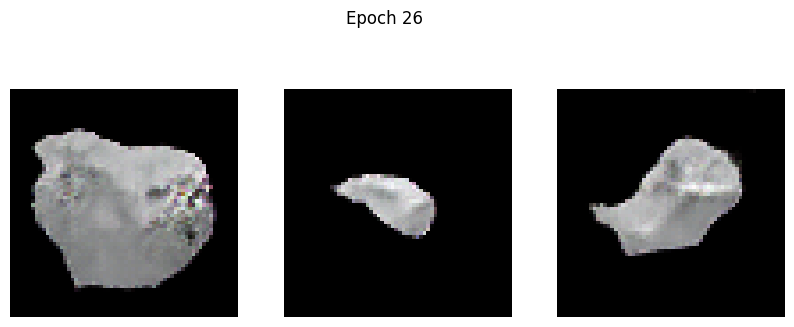

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.5129 - g_loss: 1.1815
Epoch 27/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.5179 - g_loss: 1.1985

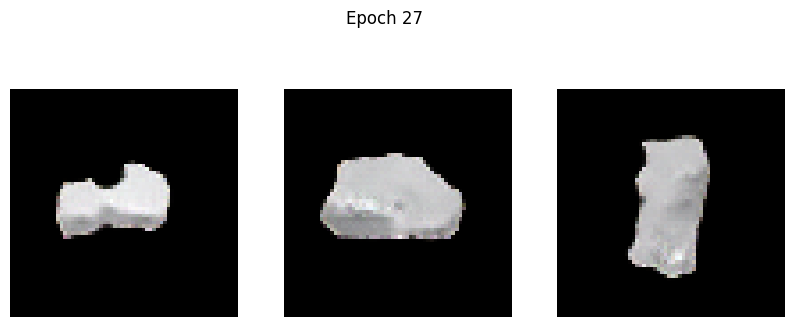

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.5178 - g_loss: 1.1984
Epoch 28/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4711 - g_loss: 1.1907

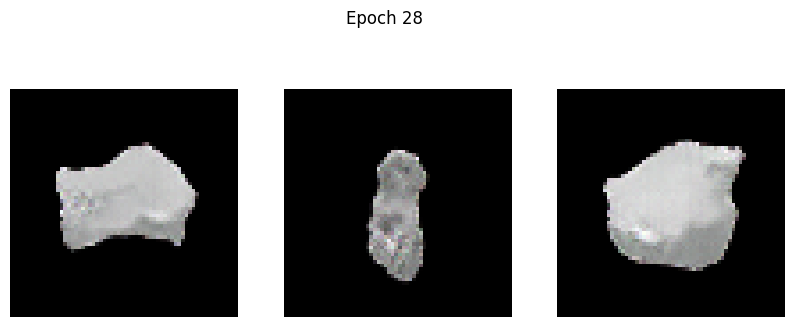

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.4711 - g_loss: 1.1911
Epoch 29/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4451 - g_loss: 1.2346

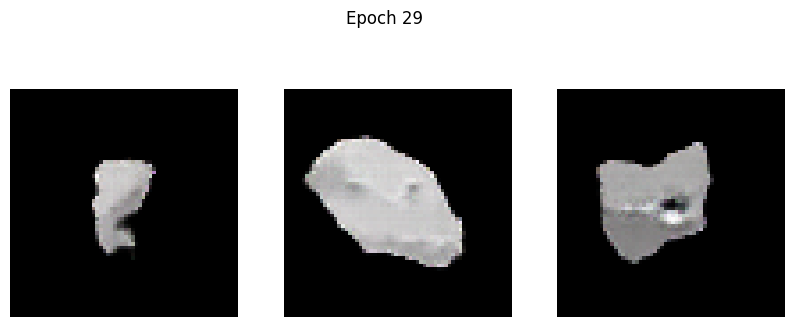

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.4451 - g_loss: 1.2350
Epoch 30/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4299 - g_loss: 1.3093

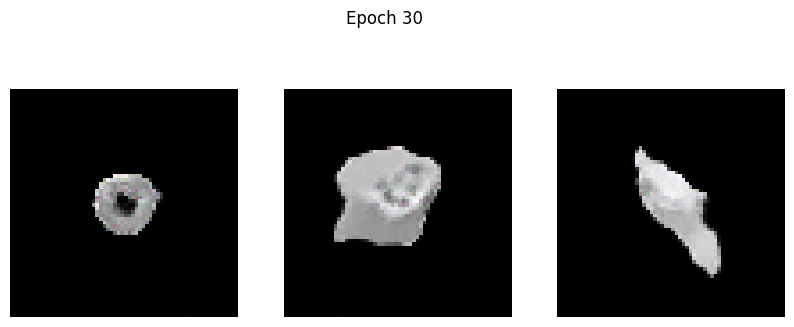

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.4301 - g_loss: 1.3093
Epoch 31/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4638 - g_loss: 1.2934

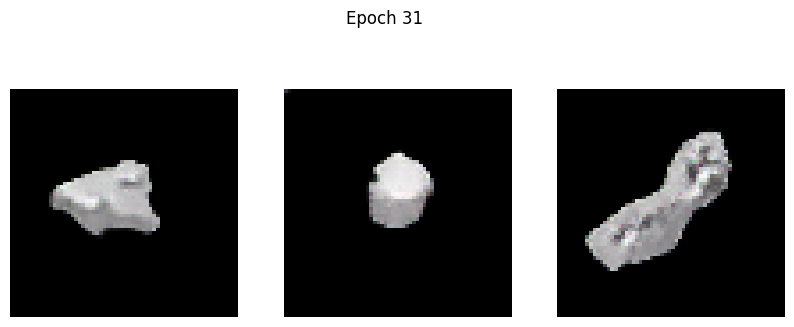

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.4636 - g_loss: 1.2937
Epoch 32/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5063 - g_loss: 1.4541

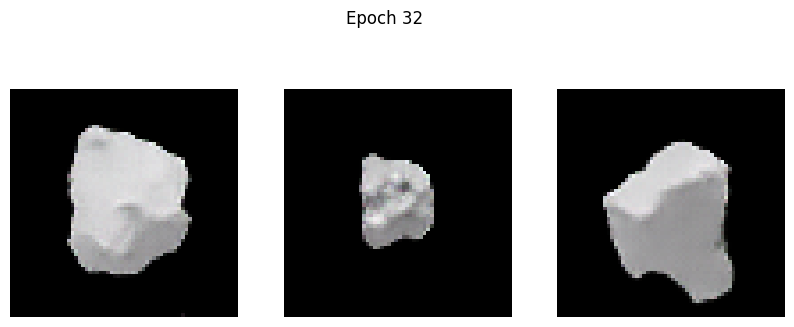

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.5060 - g_loss: 1.4537
Epoch 33/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4064 - g_loss: 1.3555

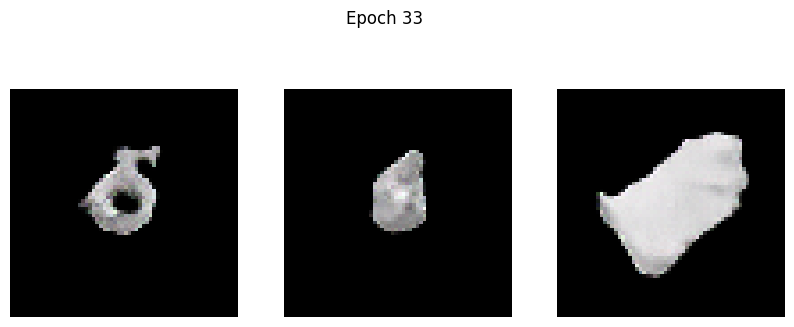

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4065 - g_loss: 1.3557
Epoch 34/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3902 - g_loss: 1.3908

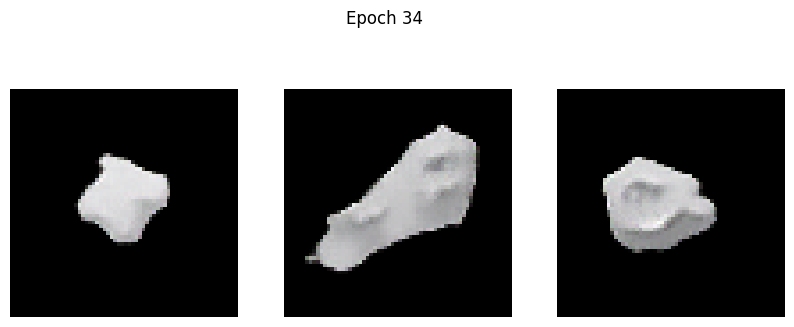

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.3903 - g_loss: 1.3910
Epoch 35/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3929 - g_loss: 1.4493

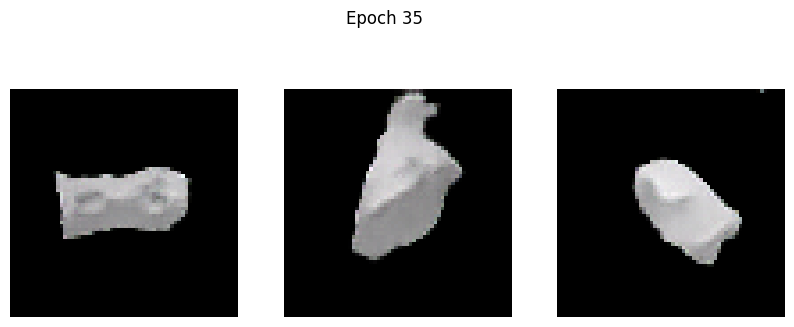

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.3930 - g_loss: 1.4496
Epoch 36/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4091 - g_loss: 1.5073

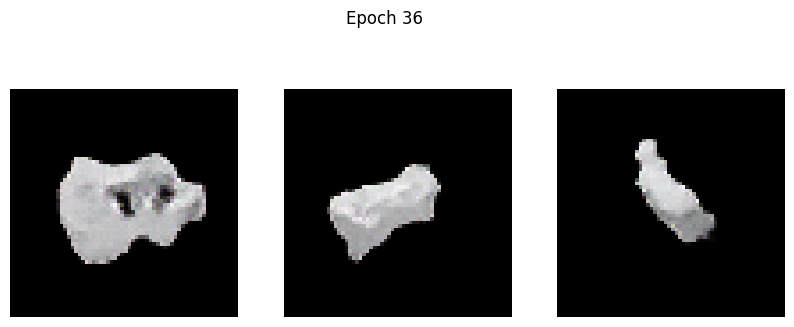

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4093 - g_loss: 1.5075
Epoch 37/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3793 - g_loss: 1.4614

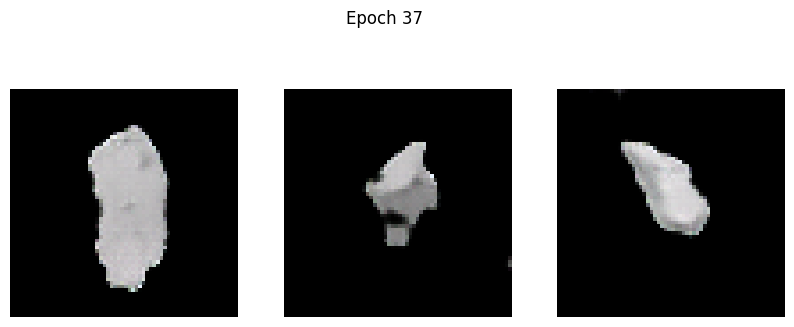

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3793 - g_loss: 1.4617
Epoch 38/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3915 - g_loss: 1.6107

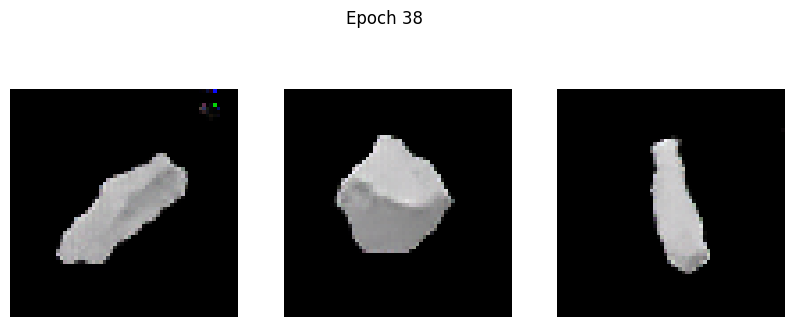

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3916 - g_loss: 1.6103
Epoch 39/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3540 - g_loss: 1.5353

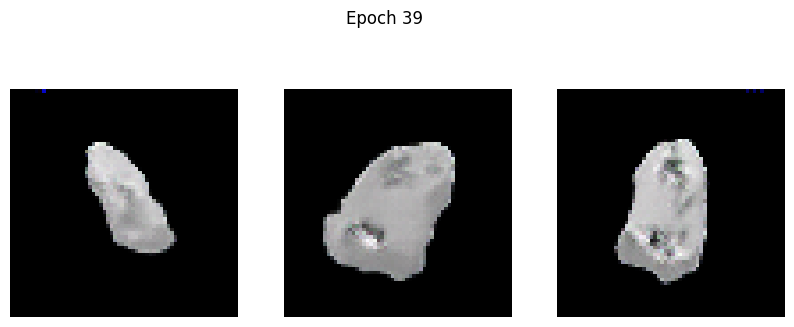

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3541 - g_loss: 1.5357
Epoch 40/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3744 - g_loss: 1.6000

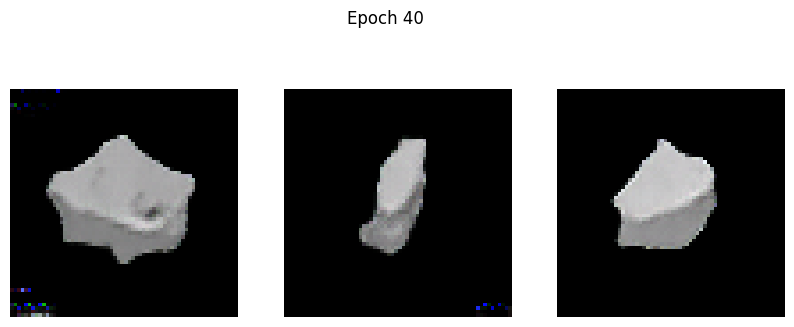

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3745 - g_loss: 1.6002
Epoch 41/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3763 - g_loss: 1.5765

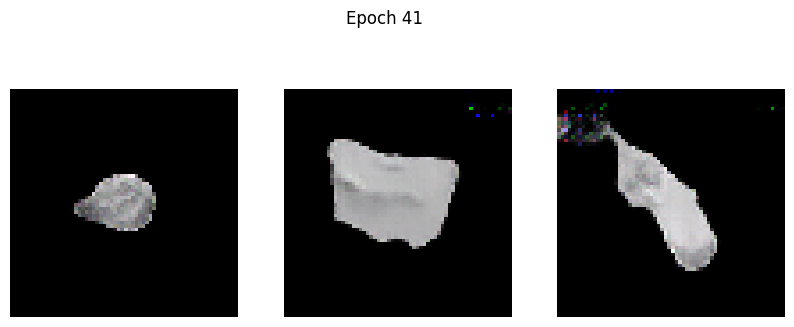

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3764 - g_loss: 1.5768
Epoch 42/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3587 - g_loss: 1.6476

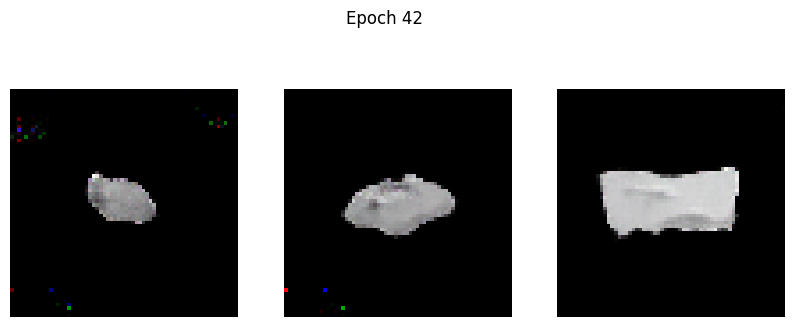

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3589 - g_loss: 1.6474
Epoch 43/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3701 - g_loss: 1.6286

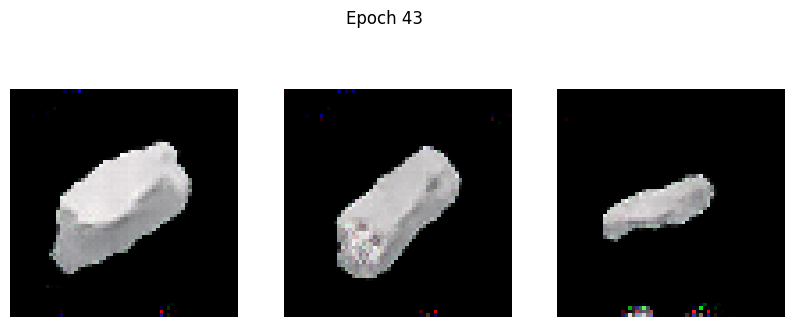

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3708 - g_loss: 1.6289
Epoch 44/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3572 - g_loss: 1.4502

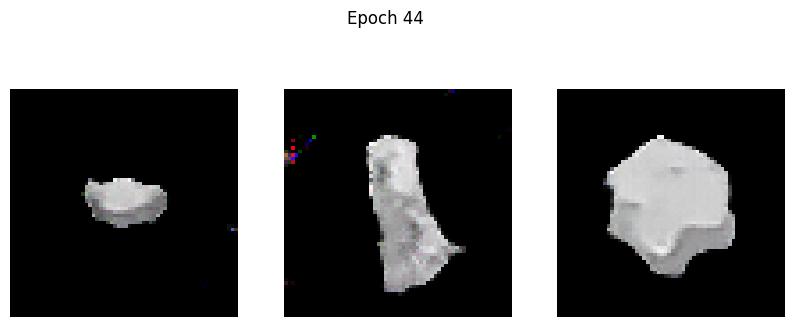

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3572 - g_loss: 1.4510
Epoch 45/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3765 - g_loss: 1.6014

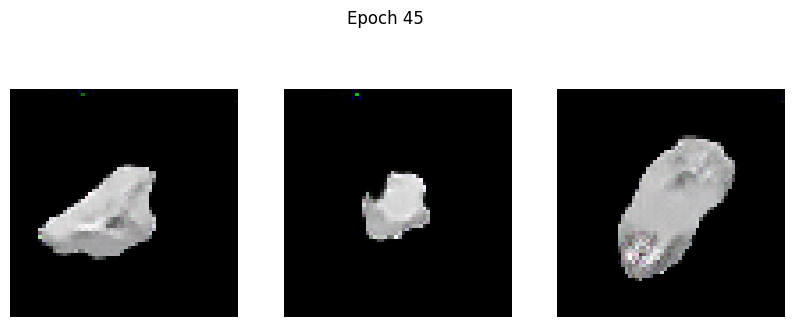

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3764 - g_loss: 1.6015
Epoch 46/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3751 - g_loss: 1.6659

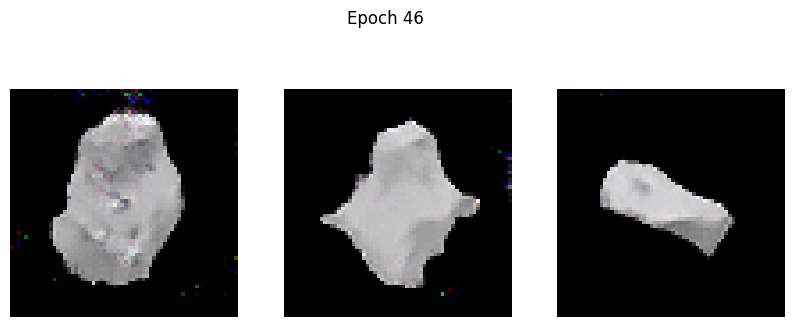

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3753 - g_loss: 1.6665
Epoch 47/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3226 - g_loss: 1.6587

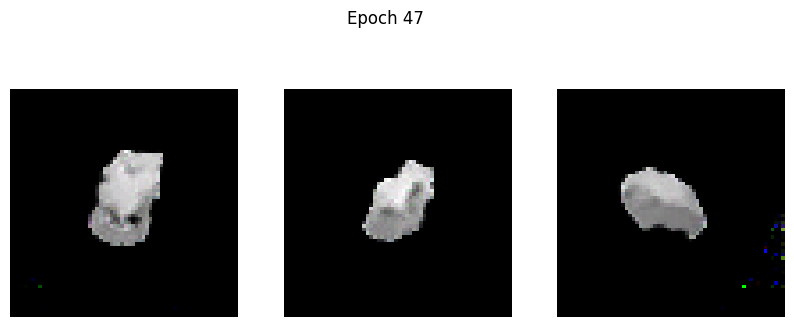

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3226 - g_loss: 1.6587
Epoch 48/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3634 - g_loss: 1.7237

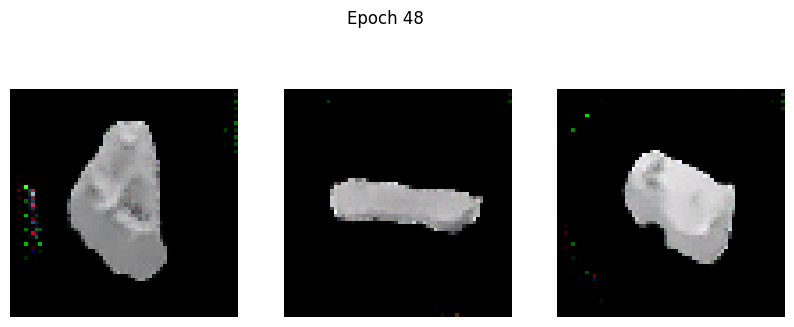

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3635 - g_loss: 1.7237
Epoch 49/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3682 - g_loss: 1.7757

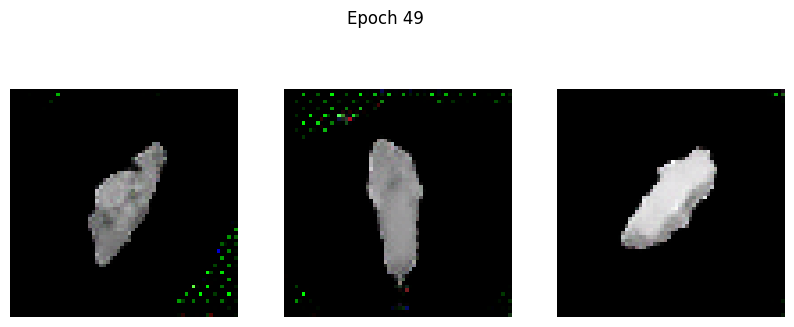

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3688 - g_loss: 1.7762
Epoch 50/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3238 - g_loss: 1.6083

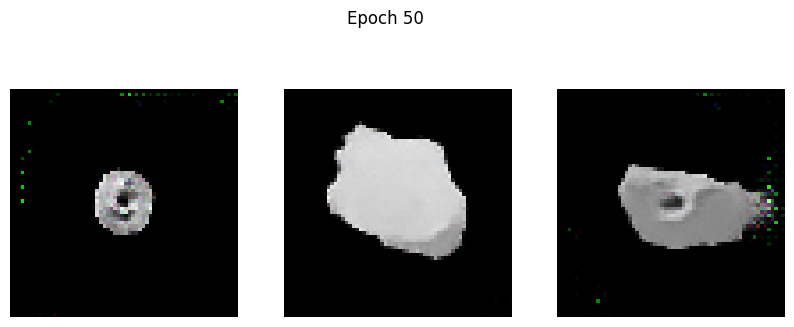

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3238 - g_loss: 1.6085
Epoch 51/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3264 - g_loss: 1.6971

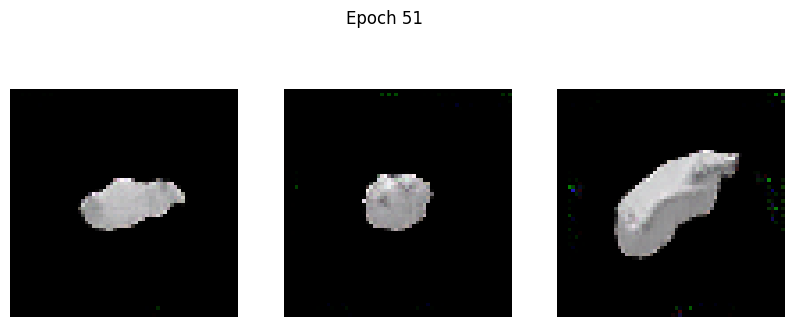

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3264 - g_loss: 1.6971
Epoch 52/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3440 - g_loss: 1.7535

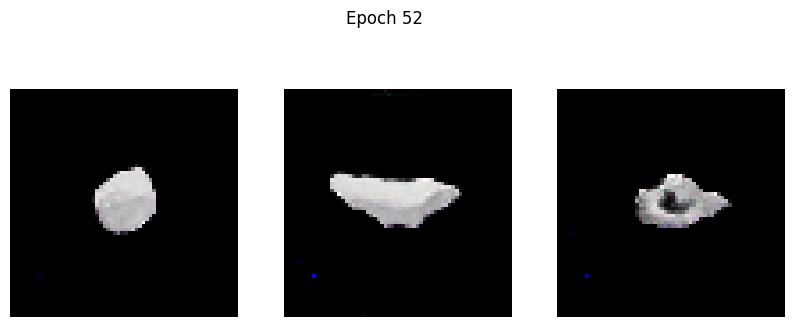

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3441 - g_loss: 1.7539
Epoch 53/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3212 - g_loss: 1.8109

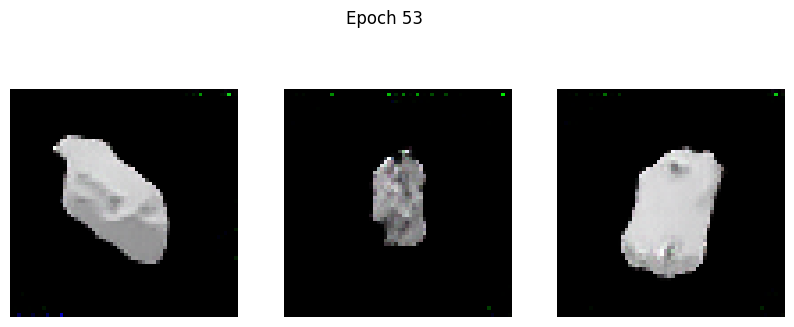

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3216 - g_loss: 1.8111
Epoch 54/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3064 - g_loss: 1.7439

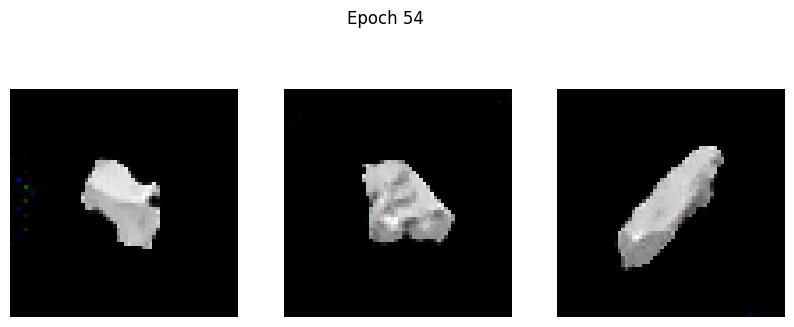

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3064 - g_loss: 1.7443
Epoch 55/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3148 - g_loss: 1.8330

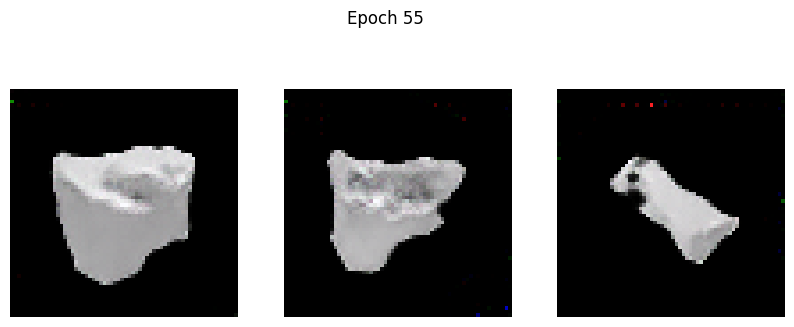

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3149 - g_loss: 1.8330
Epoch 56/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3270 - g_loss: 1.8660

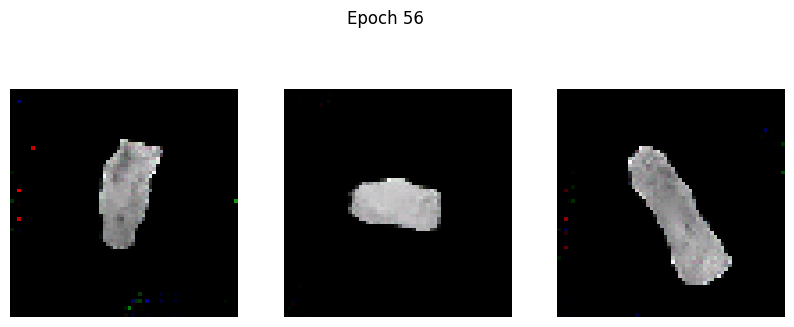

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3270 - g_loss: 1.8659
Epoch 57/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3480 - g_loss: 1.9450

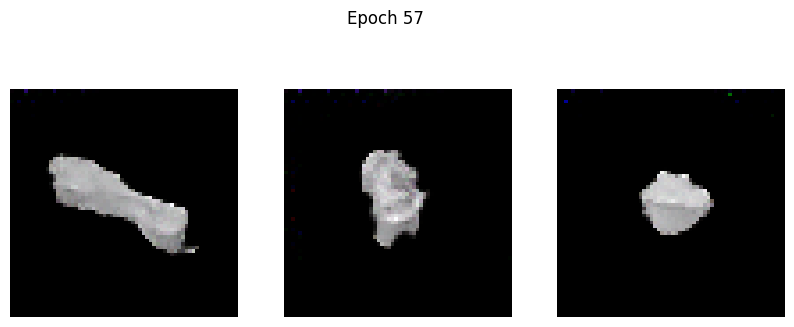

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3479 - g_loss: 1.9447
Epoch 58/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3013 - g_loss: 1.8722

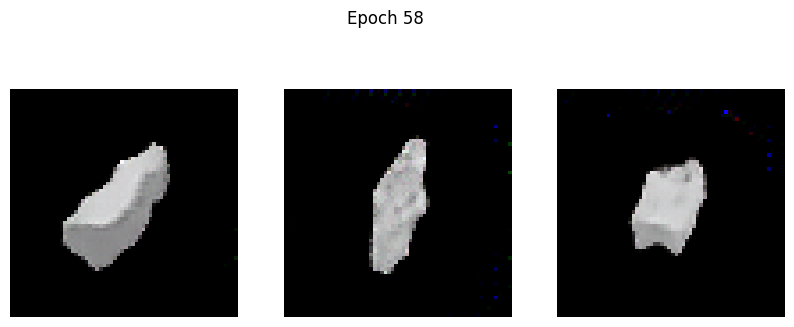

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3013 - g_loss: 1.8722
Epoch 59/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3227 - g_loss: 1.9477

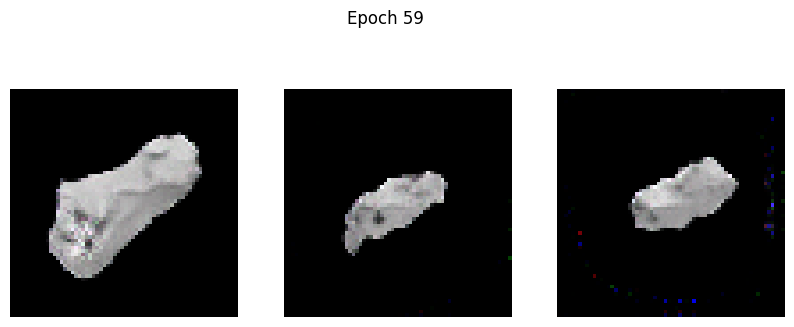

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3227 - g_loss: 1.9476
Epoch 60/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3240 - g_loss: 1.9437

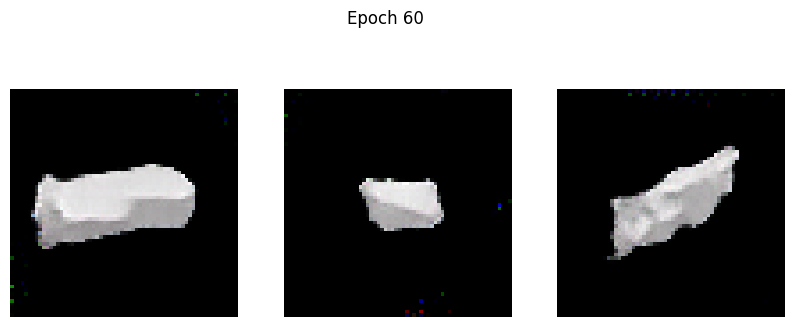

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3238 - g_loss: 1.9438
Epoch 61/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3272 - g_loss: 1.9790

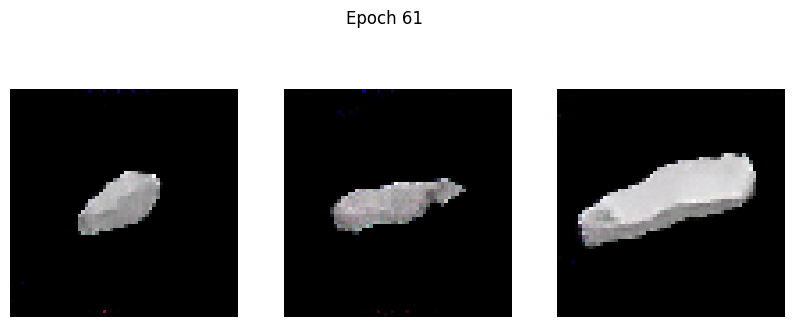

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3271 - g_loss: 1.9790
Epoch 62/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3044 - g_loss: 1.9834

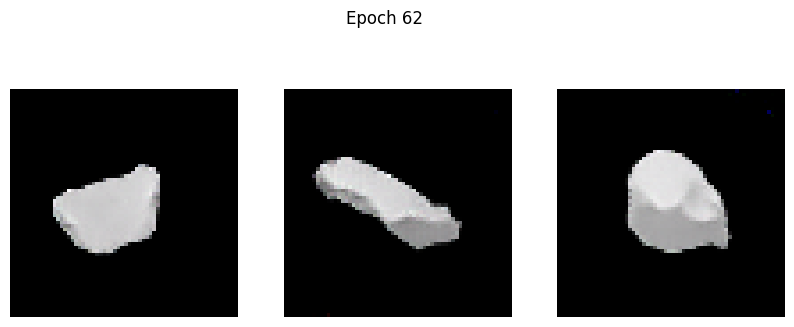

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3046 - g_loss: 1.9835
Epoch 63/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2851 - g_loss: 1.9623

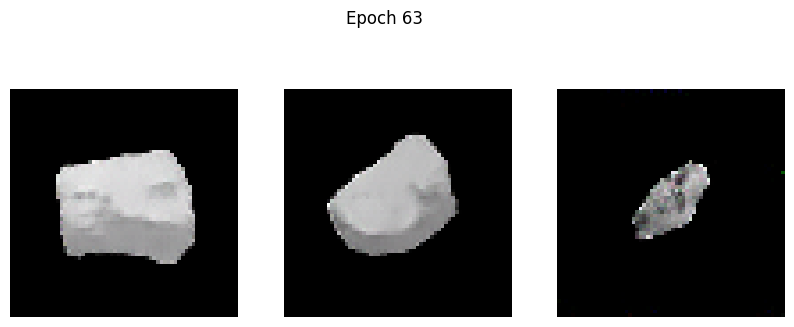

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2859 - g_loss: 1.9629
Epoch 64/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2741 - g_loss: 1.8358

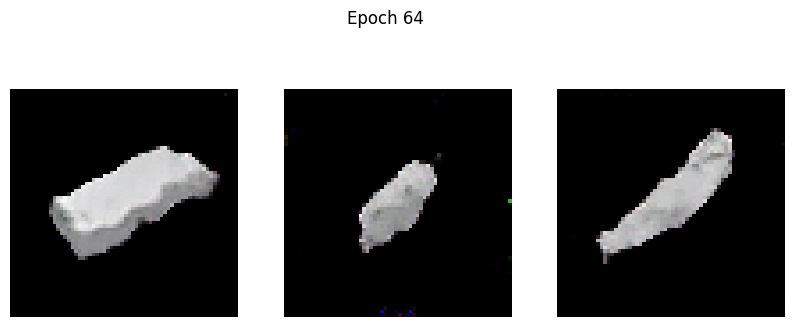

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2740 - g_loss: 1.8363
Epoch 65/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3169 - g_loss: 1.9989

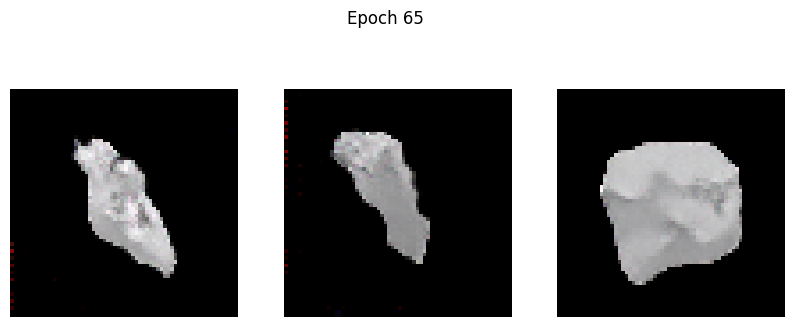

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3168 - g_loss: 1.9986
Epoch 66/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3058 - g_loss: 2.0259

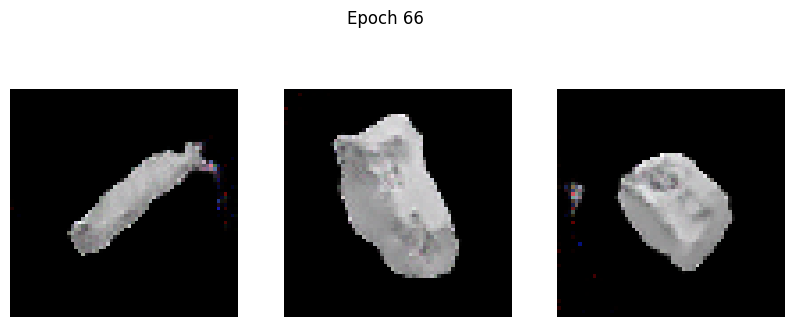

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3064 - g_loss: 2.0265
Epoch 67/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2549 - g_loss: 1.9378

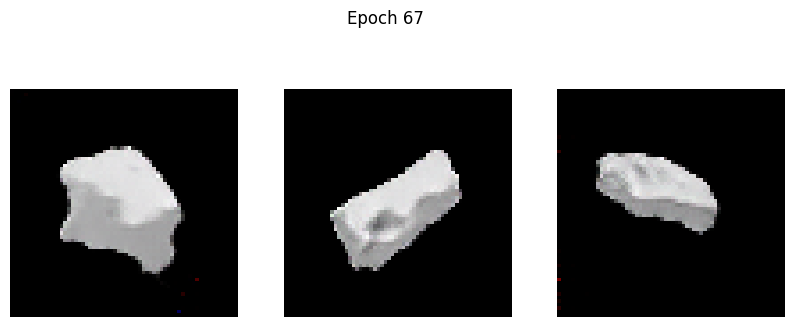

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2550 - g_loss: 1.9379
Epoch 68/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2728 - g_loss: 2.0381

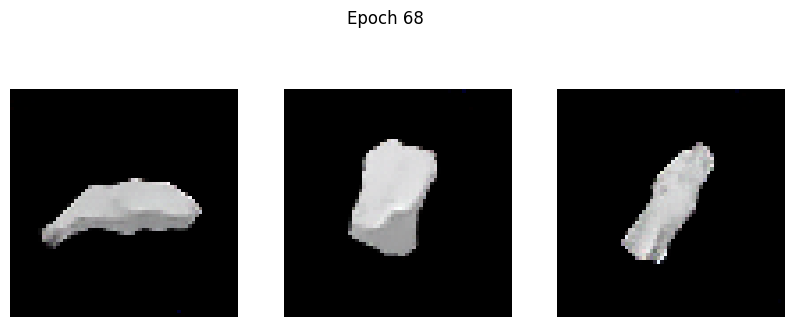

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2730 - g_loss: 2.0383
Epoch 69/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2516 - g_loss: 2.0346

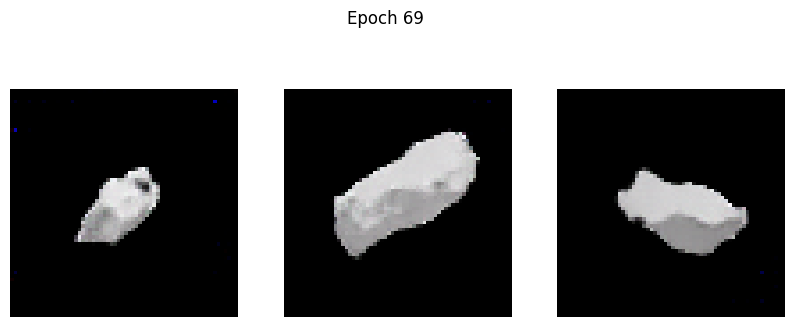

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2517 - g_loss: 2.0347
Epoch 70/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2653 - g_loss: 2.0828

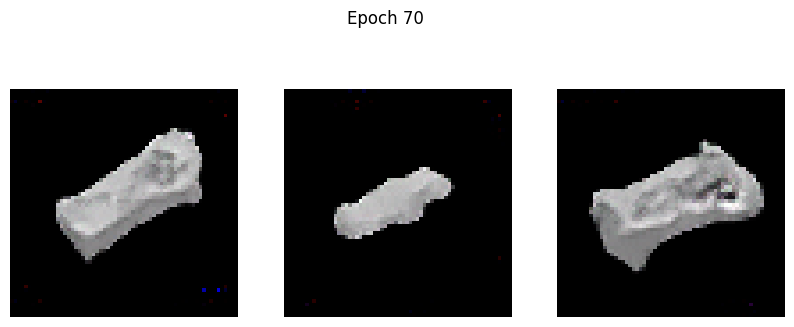

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2653 - g_loss: 2.0829
Epoch 71/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3367 - g_loss: 2.2374

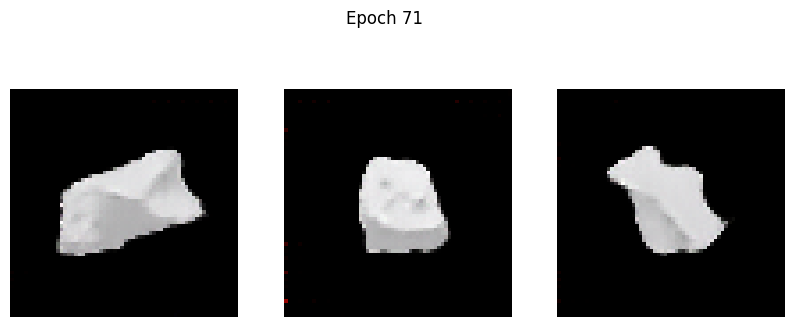

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3363 - g_loss: 2.2366
Epoch 72/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2797 - g_loss: 2.1214

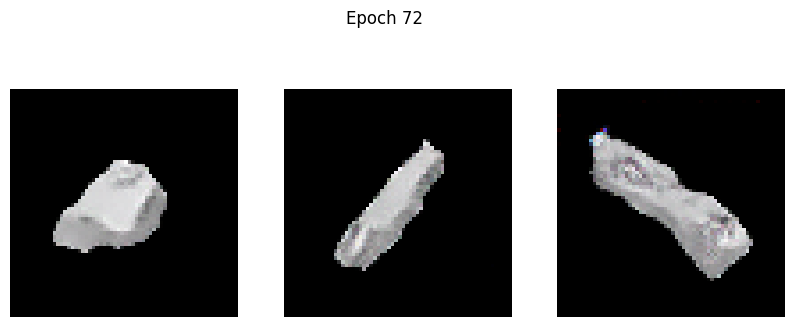

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2799 - g_loss: 2.1216
Epoch 73/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2700 - g_loss: 2.1977

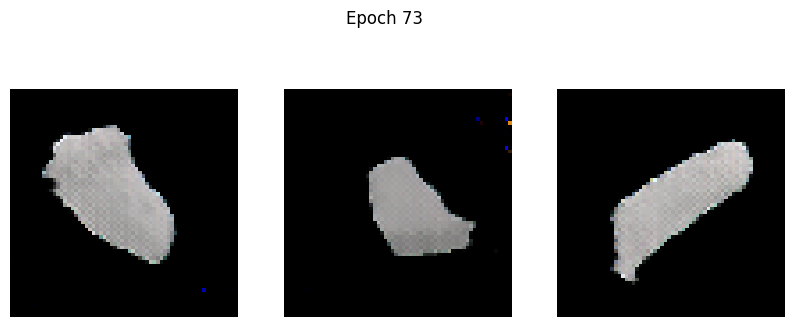

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2712 - g_loss: 2.2006
Epoch 74/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4268 - g_loss: 2.1920

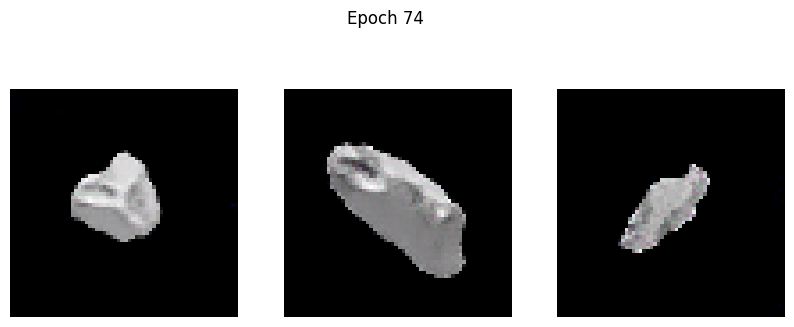

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.4256 - g_loss: 2.1904
Epoch 75/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2480 - g_loss: 2.0417

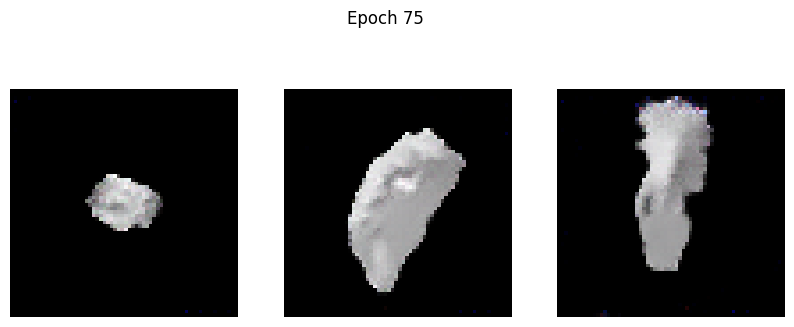

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2481 - g_loss: 2.0415
Epoch 76/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2481 - g_loss: 2.0383

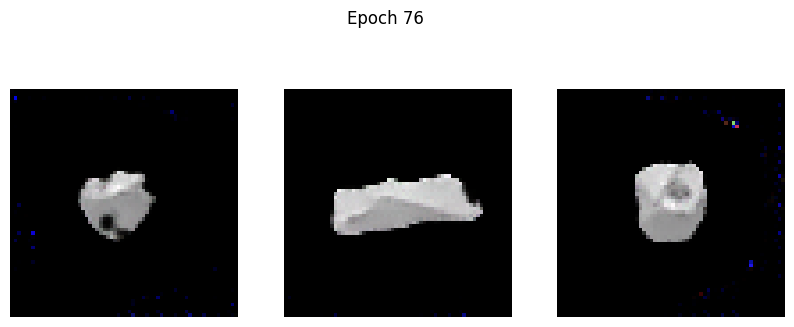

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2482 - g_loss: 2.0387
Epoch 77/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2614 - g_loss: 2.1637

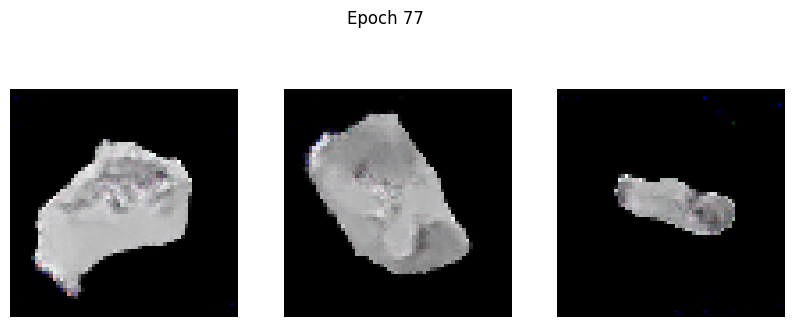

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2615 - g_loss: 2.1638
Epoch 78/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2929 - g_loss: 2.1458

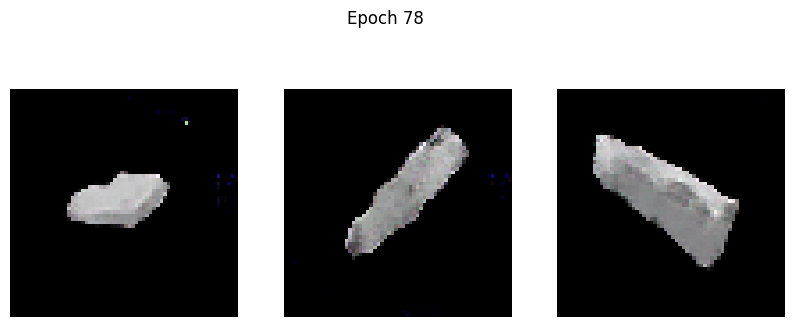

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2927 - g_loss: 2.1459
Epoch 79/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2475 - g_loss: 2.1870

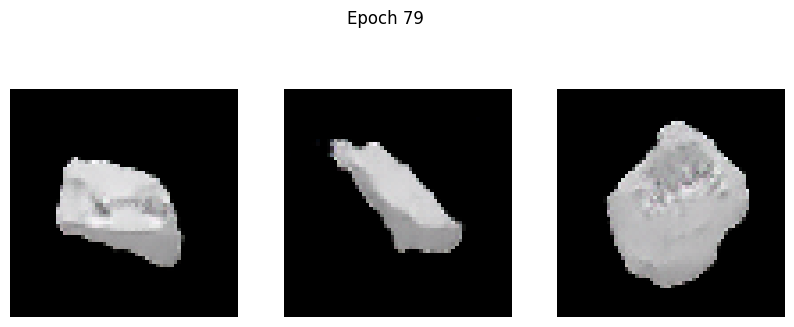

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2475 - g_loss: 2.1869
Epoch 80/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2330 - g_loss: 2.2615

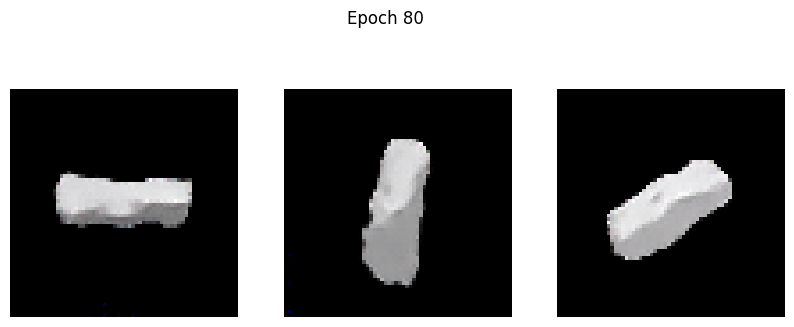

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2331 - g_loss: 2.2615
Epoch 81/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3043 - g_loss: 2.2805

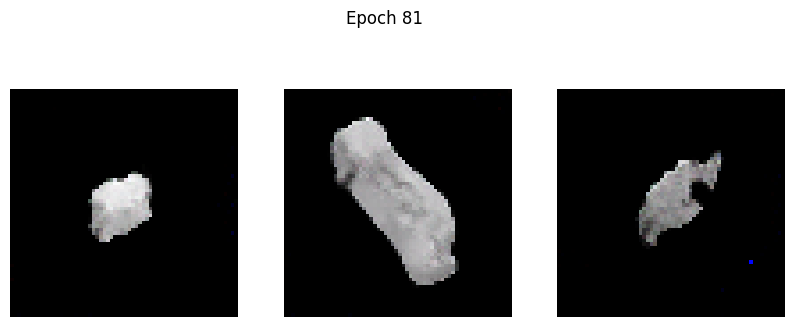

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3042 - g_loss: 2.2802
Epoch 82/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2666 - g_loss: 2.3475

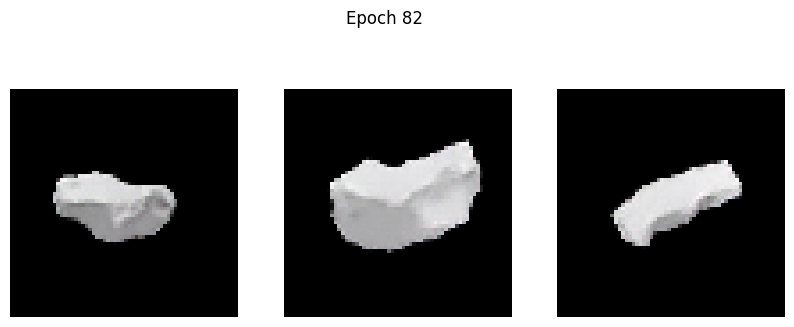

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2668 - g_loss: 2.3472
Epoch 83/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2323 - g_loss: 2.2412

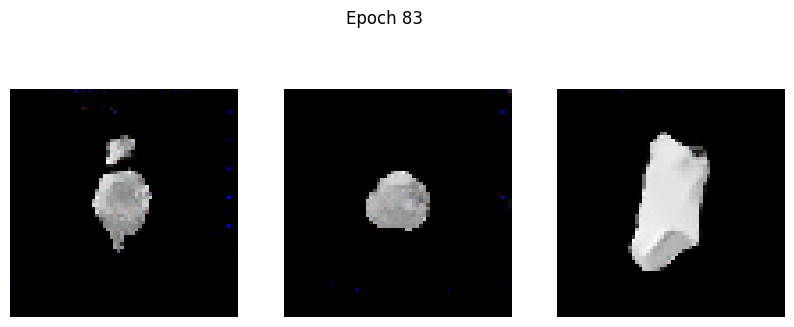

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2324 - g_loss: 2.2413
Epoch 84/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3145 - g_loss: 2.3367

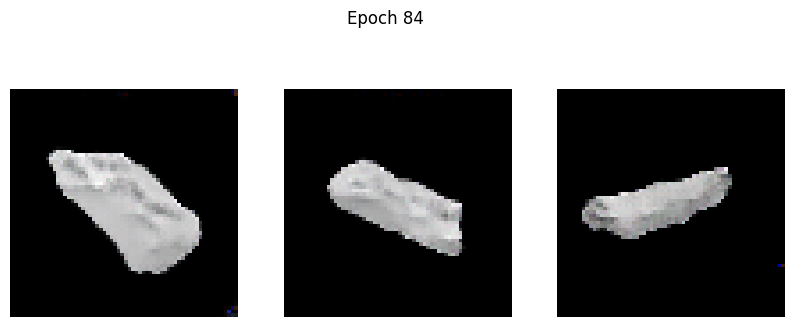

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3144 - g_loss: 2.3363
Epoch 85/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2600 - g_loss: 2.2554

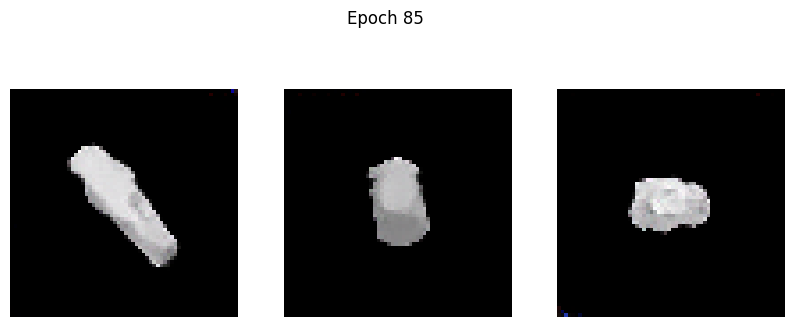

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2600 - g_loss: 2.2554
Epoch 86/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2516 - g_loss: 2.3369

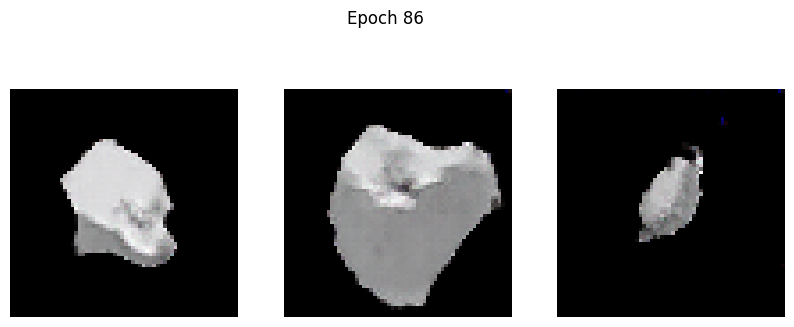

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2516 - g_loss: 2.3365
Epoch 87/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2213 - g_loss: 2.3191

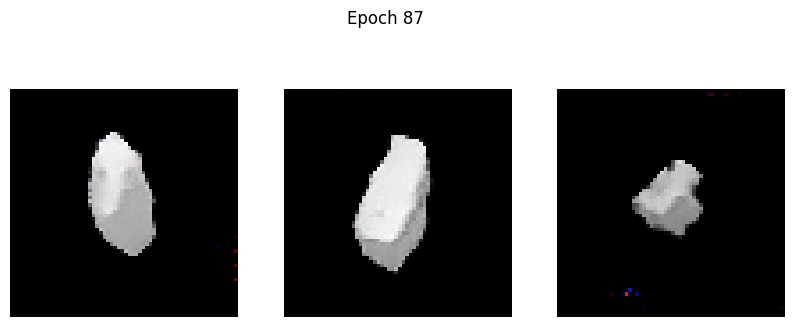

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2214 - g_loss: 2.3190
Epoch 88/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4391 - g_loss: 2.6215

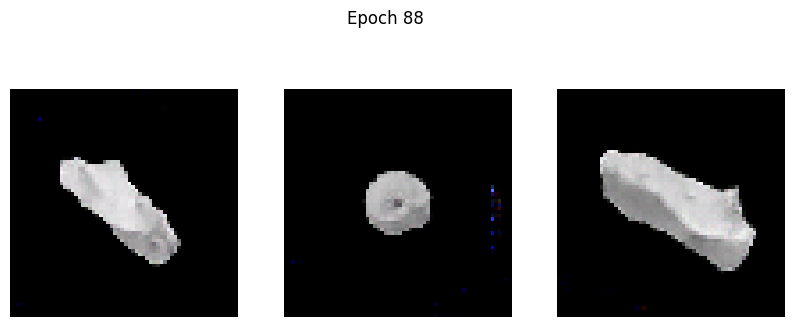

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4404 - g_loss: 2.6220
Epoch 89/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2449 - g_loss: 1.9536

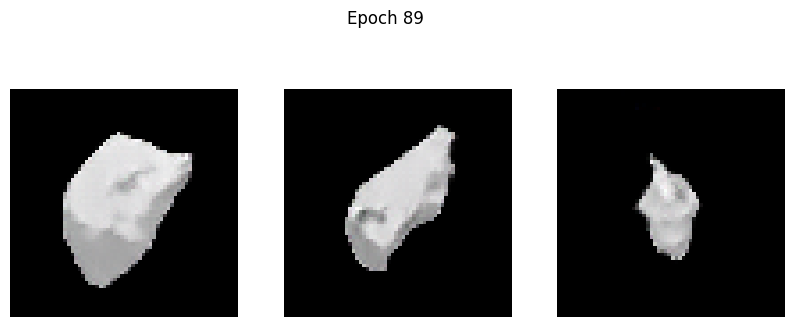

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2449 - g_loss: 1.9543
Epoch 90/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2345 - g_loss: 2.1655

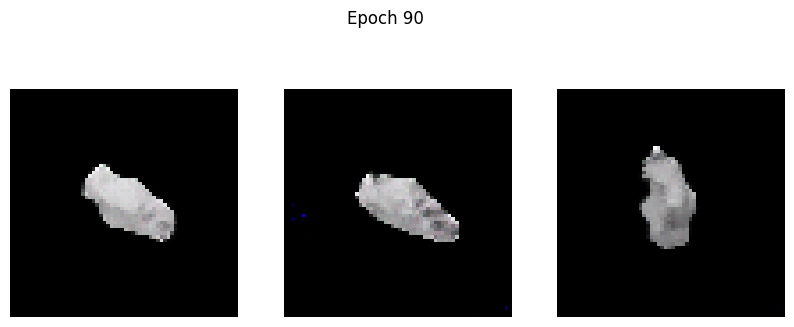

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2345 - g_loss: 2.1658
Epoch 91/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2302 - g_loss: 2.2407

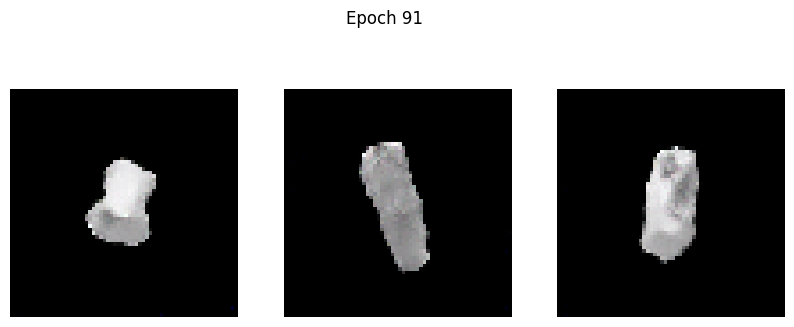

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2304 - g_loss: 2.2408
Epoch 92/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2165 - g_loss: 2.2387

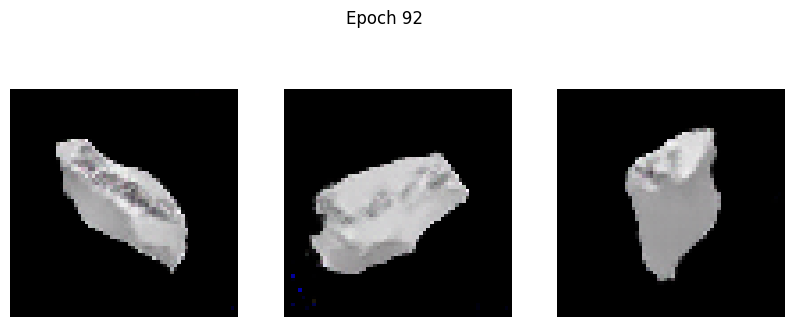

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2166 - g_loss: 2.2391
Epoch 93/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2254 - g_loss: 2.3452

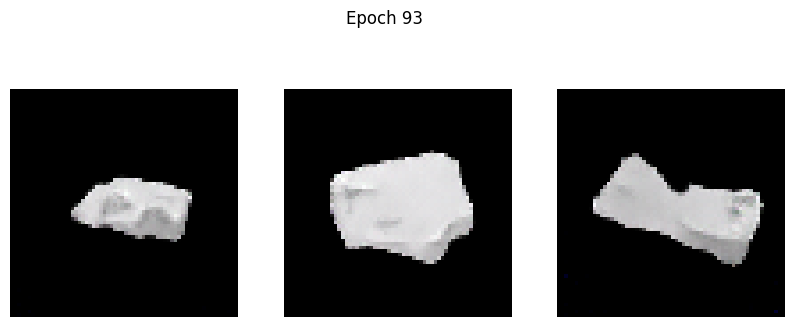

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2256 - g_loss: 2.3453
Epoch 94/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1982 - g_loss: 2.3004

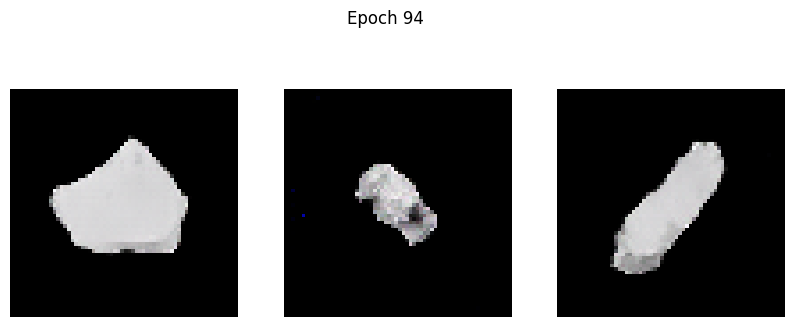

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1983 - g_loss: 2.3005
Epoch 95/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2515 - g_loss: 2.4198

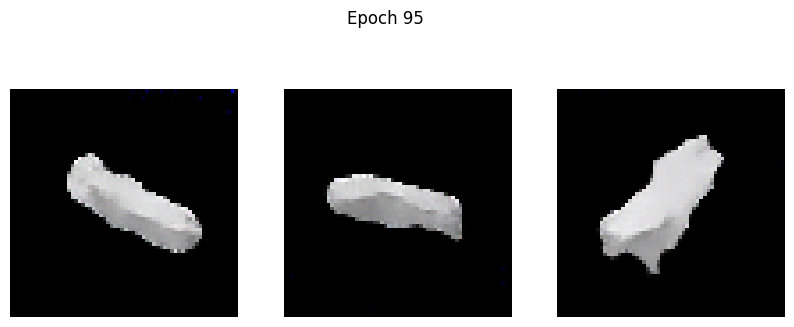

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2514 - g_loss: 2.4191
Epoch 96/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2263 - g_loss: 2.4295

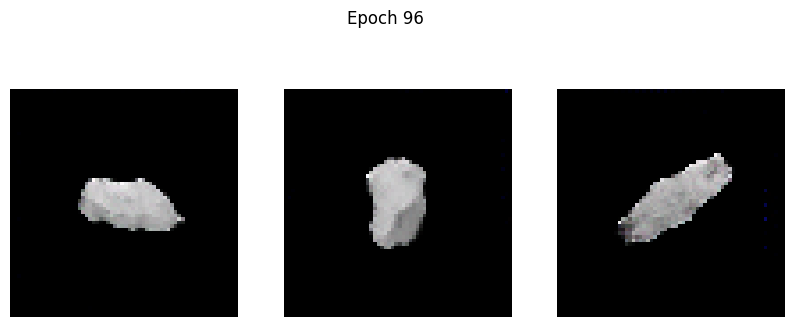

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2269 - g_loss: 2.4300
Epoch 97/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2174 - g_loss: 2.3495

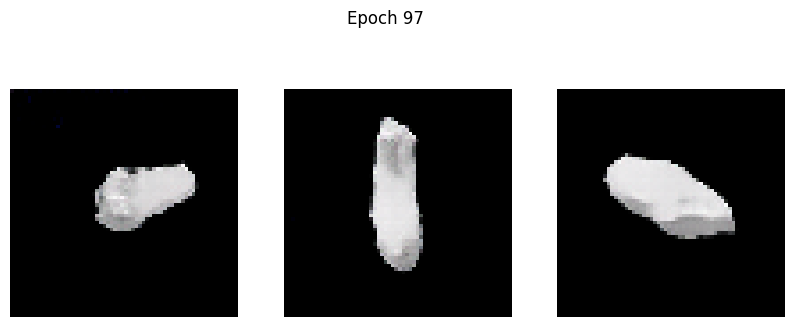

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2173 - g_loss: 2.3498
Epoch 98/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2253 - g_loss: 2.4151

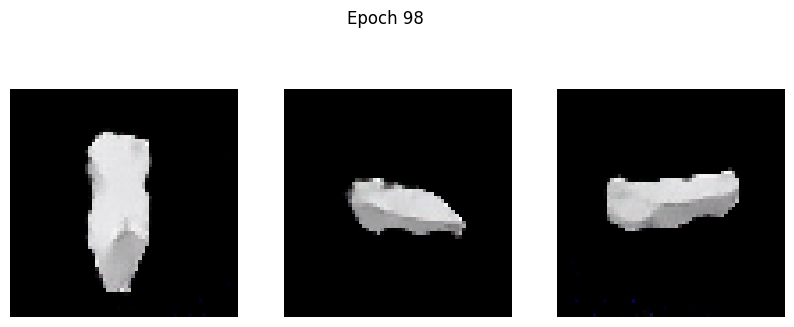

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2256 - g_loss: 2.4157
Epoch 99/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1973 - g_loss: 2.3866

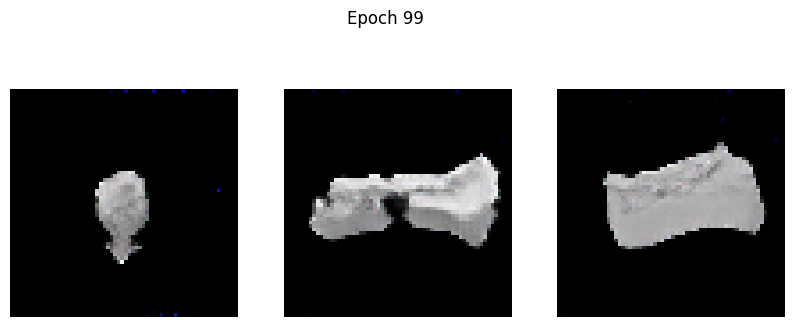

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1977 - g_loss: 2.3872
Epoch 100/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2292 - g_loss: 2.4094

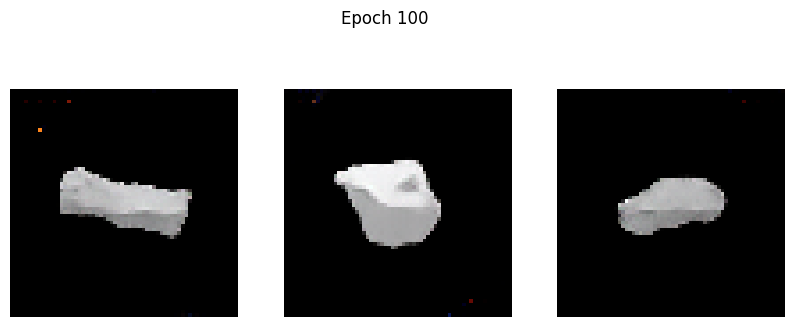

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2293 - g_loss: 2.4098
Epoch 101/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1903 - g_loss: 2.3670

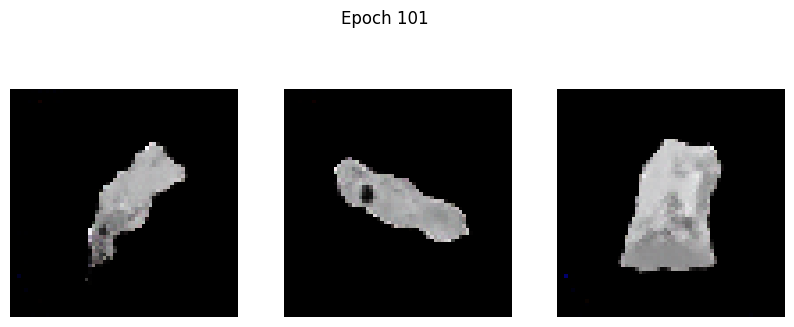

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1907 - g_loss: 2.3680
Epoch 102/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2666 - g_loss: 2.5055

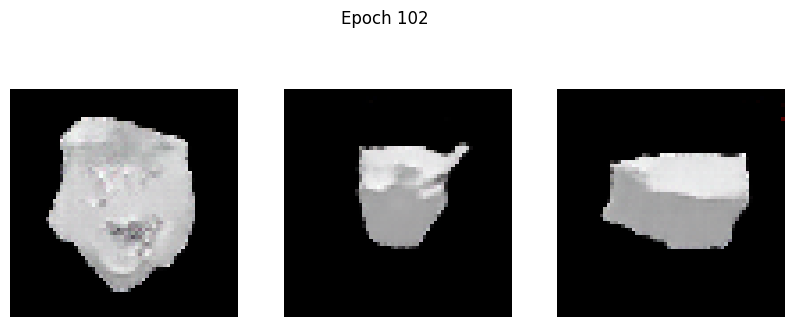

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2666 - g_loss: 2.5055
Epoch 103/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2220 - g_loss: 2.4644

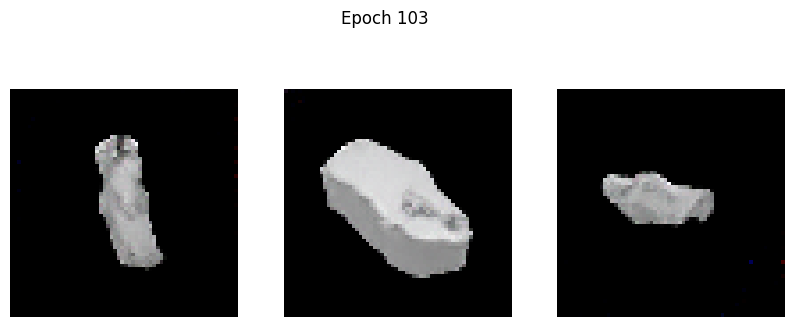

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2224 - g_loss: 2.4647
Epoch 104/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1989 - g_loss: 2.4373

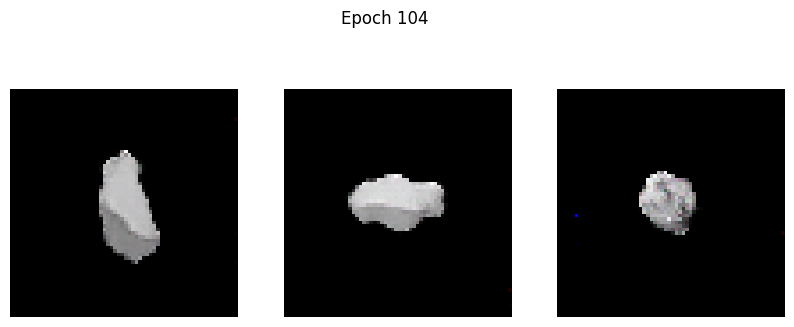

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1998 - g_loss: 2.4385
Epoch 105/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1951 - g_loss: 2.3899

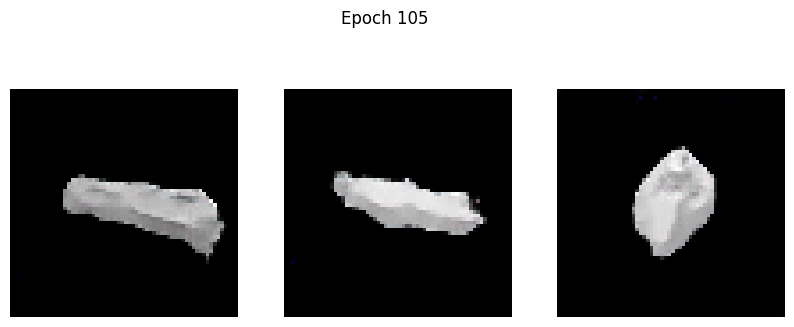

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1951 - g_loss: 2.3902
Epoch 106/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1938 - g_loss: 2.4377

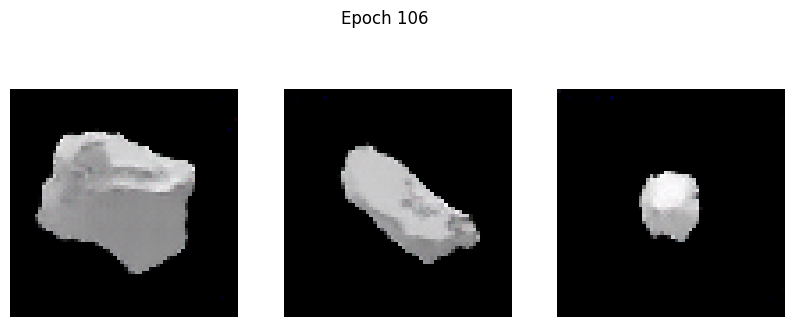

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1939 - g_loss: 2.4381
Epoch 107/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1710 - g_loss: 2.5018

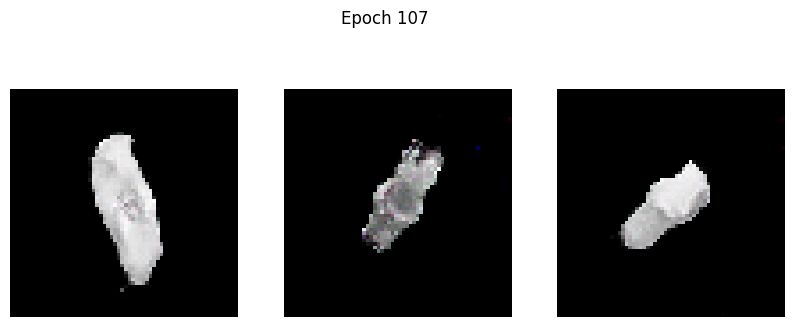

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1710 - g_loss: 2.5019
Epoch 108/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2224 - g_loss: 2.5418

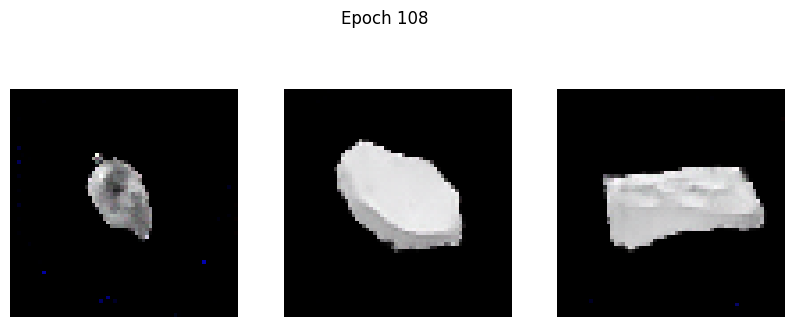

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2225 - g_loss: 2.5422
Epoch 109/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3189 - g_loss: 2.7742

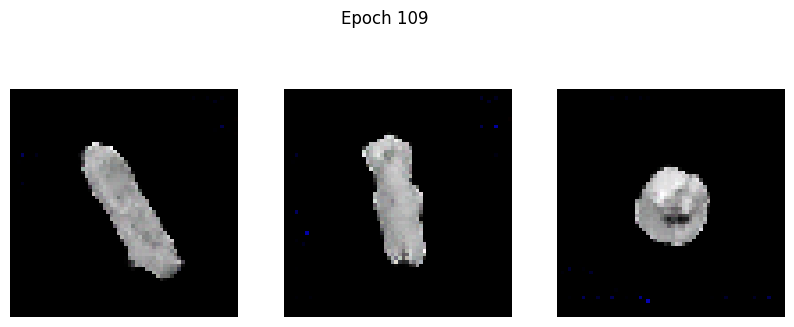

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3199 - g_loss: 2.7745
Epoch 110/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2005 - g_loss: 2.4054

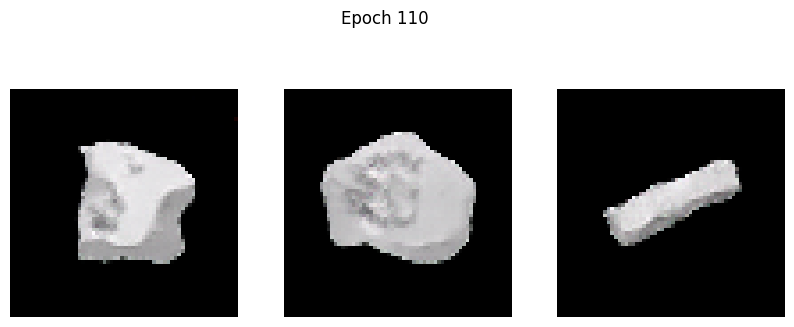

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2004 - g_loss: 2.4056
Epoch 111/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1899 - g_loss: 2.4216

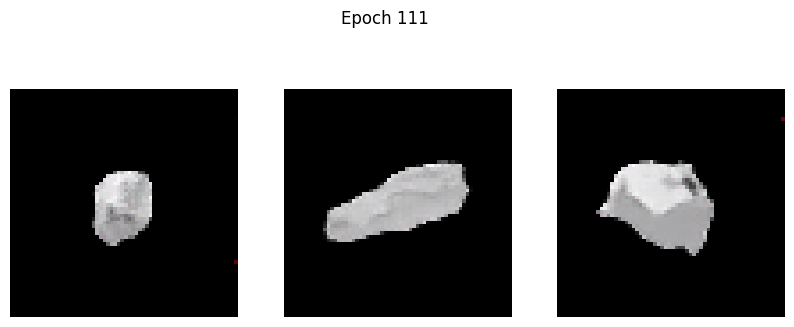

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1899 - g_loss: 2.4221
Epoch 112/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2062 - g_loss: 2.5698

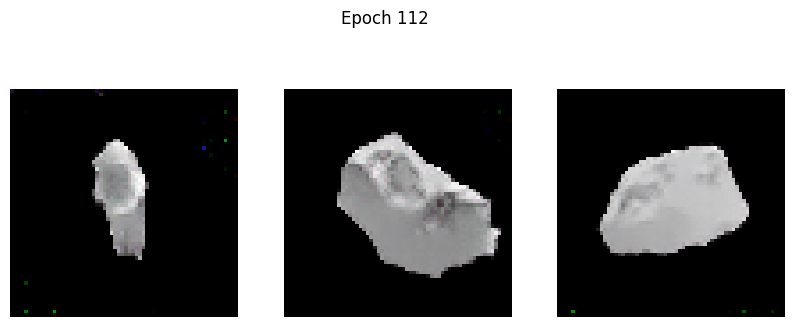

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2064 - g_loss: 2.5700
Epoch 113/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2042 - g_loss: 2.5585

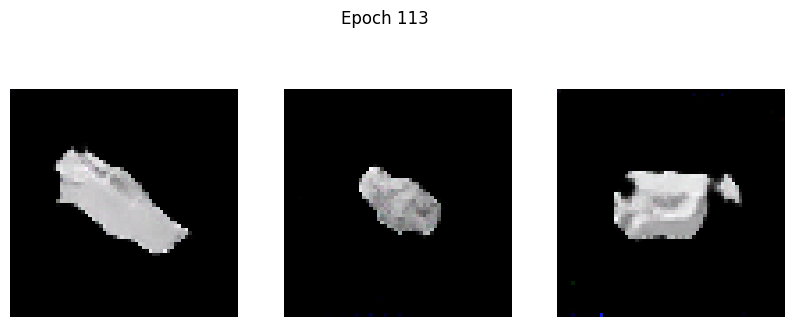

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2045 - g_loss: 2.5591
Epoch 114/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1766 - g_loss: 2.5288

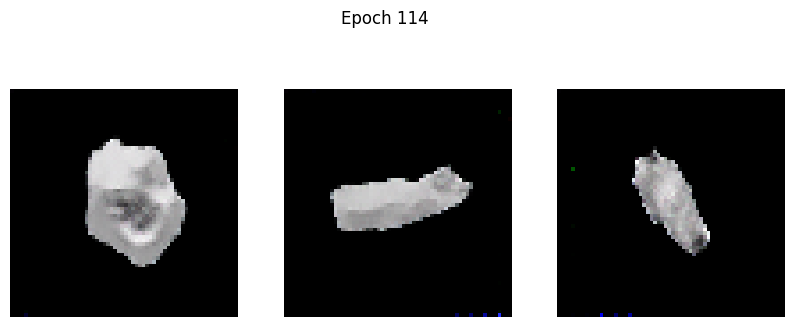

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1771 - g_loss: 2.5295
Epoch 115/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2824 - g_loss: 2.7336

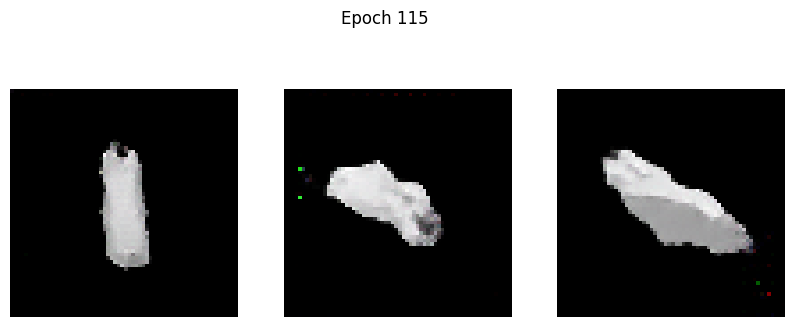

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2818 - g_loss: 2.7326
Epoch 116/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1875 - g_loss: 2.6191

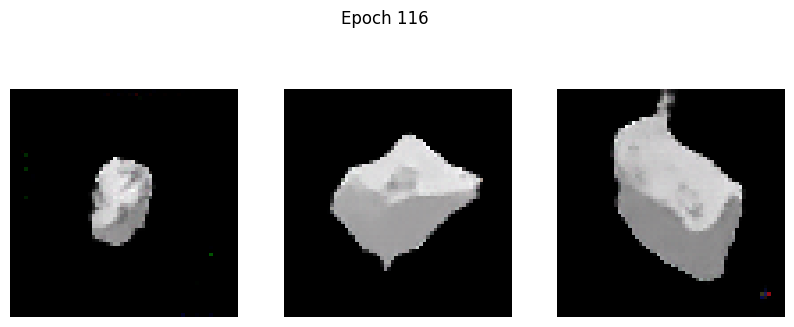

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1880 - g_loss: 2.6194
Epoch 117/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1786 - g_loss: 2.5786

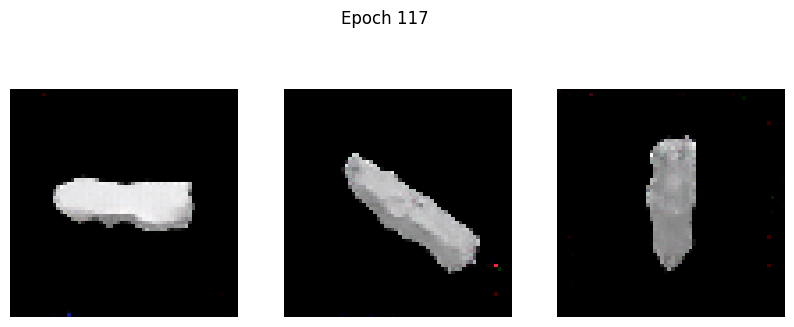

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1786 - g_loss: 2.5789
Epoch 118/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1884 - g_loss: 2.6665

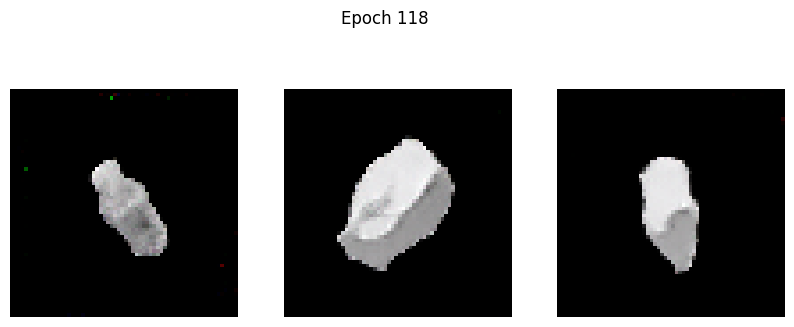

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1884 - g_loss: 2.6666
Epoch 119/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2253 - g_loss: 2.7610

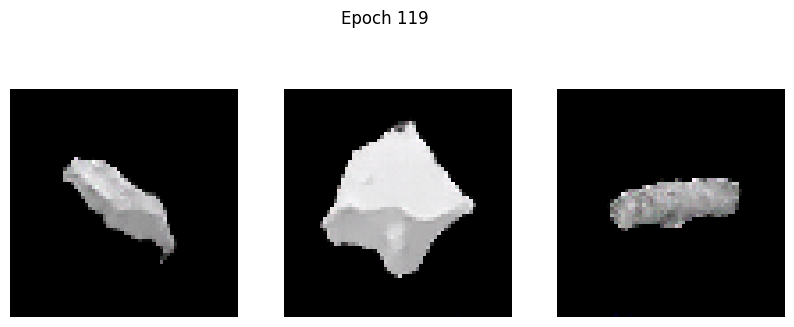

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2258 - g_loss: 2.7611
Epoch 120/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1836 - g_loss: 2.6129

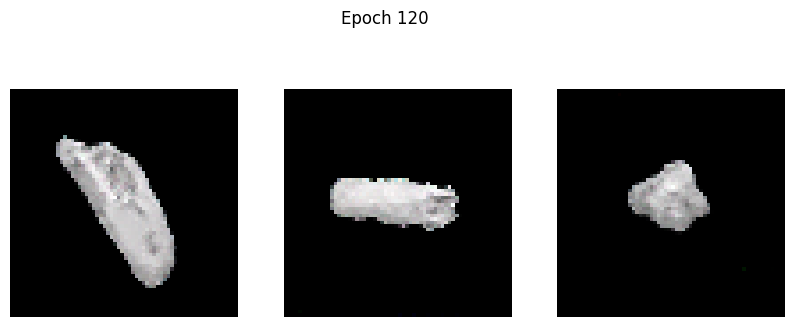

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1837 - g_loss: 2.6132
Epoch 121/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2137 - g_loss: 2.7607

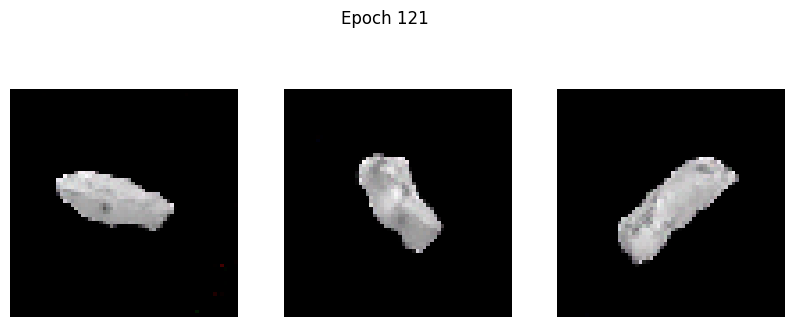

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2135 - g_loss: 2.7601
Epoch 122/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1895 - g_loss: 2.7161

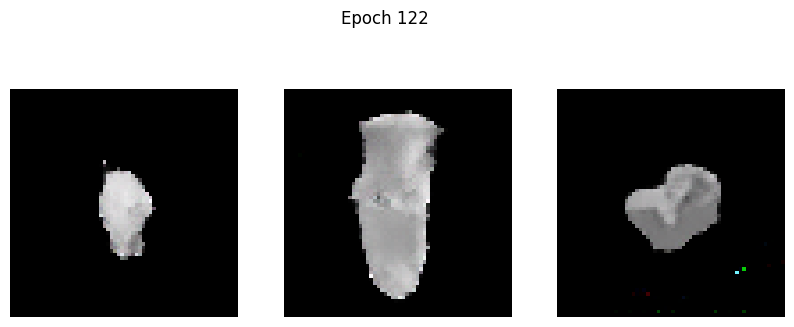

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1896 - g_loss: 2.7160
Epoch 123/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2008 - g_loss: 2.7593

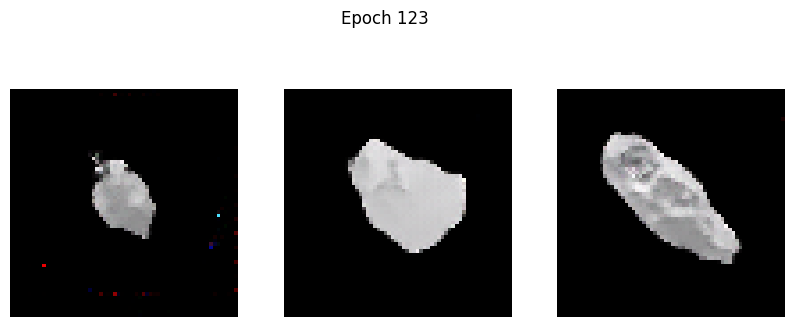

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2008 - g_loss: 2.7592
Epoch 124/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1927 - g_loss: 2.7914

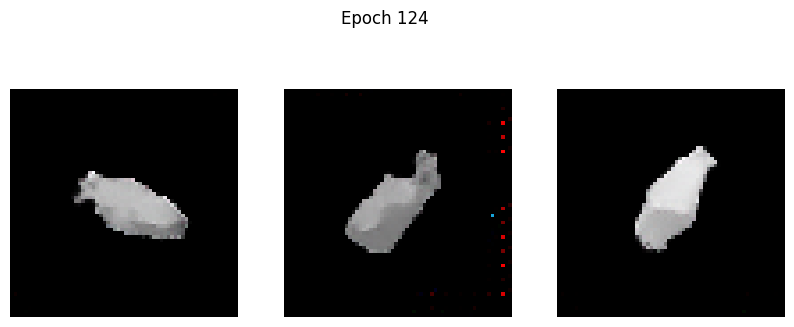

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1927 - g_loss: 2.7909
Epoch 125/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2624 - g_loss: 2.8231

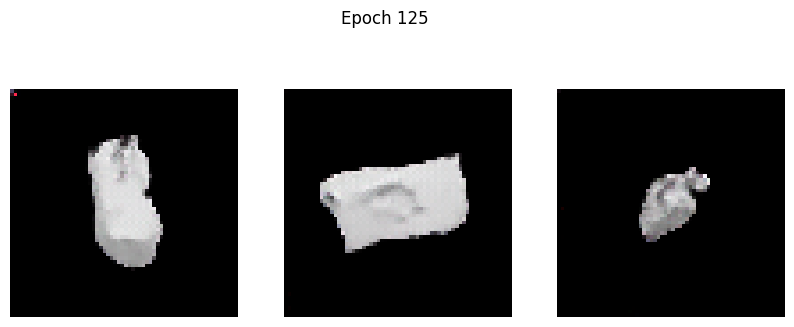

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2625 - g_loss: 2.8231
Epoch 126/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2272 - g_loss: 2.7082

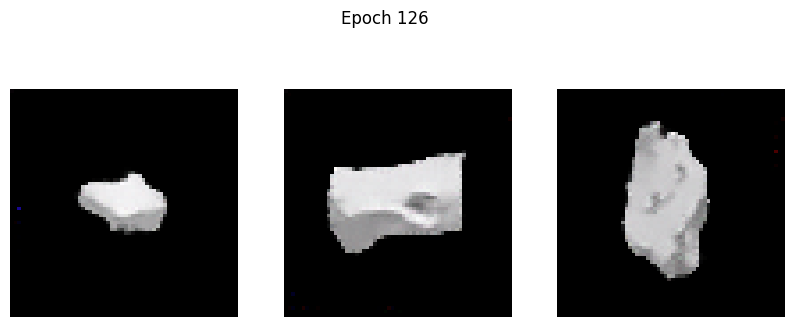

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2268 - g_loss: 2.7080
Epoch 127/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1859 - g_loss: 2.8147

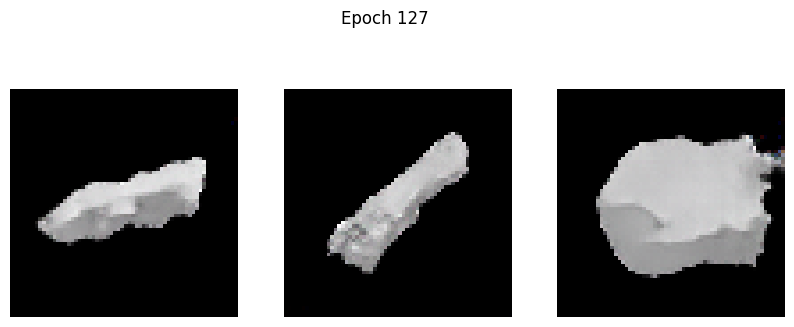

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1858 - g_loss: 2.8139
Epoch 128/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2388 - g_loss: 2.9403

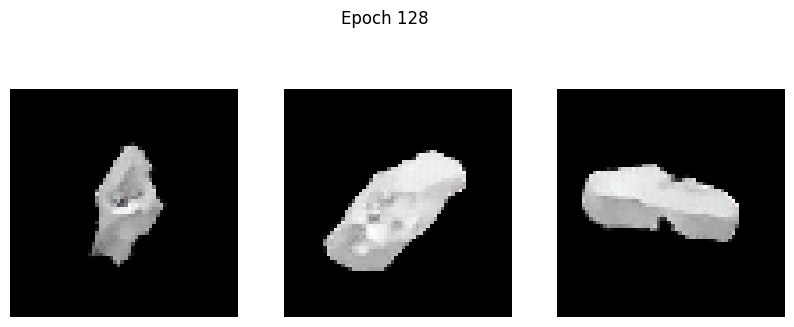

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2389 - g_loss: 2.9400
Epoch 129/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1832 - g_loss: 2.8220

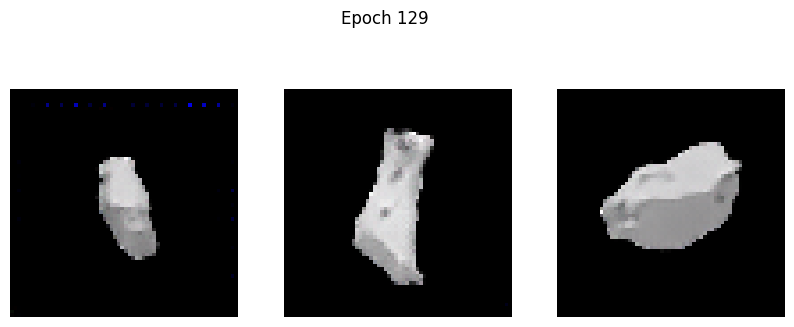

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1834 - g_loss: 2.8218
Epoch 130/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1452 - g_loss: 2.7795

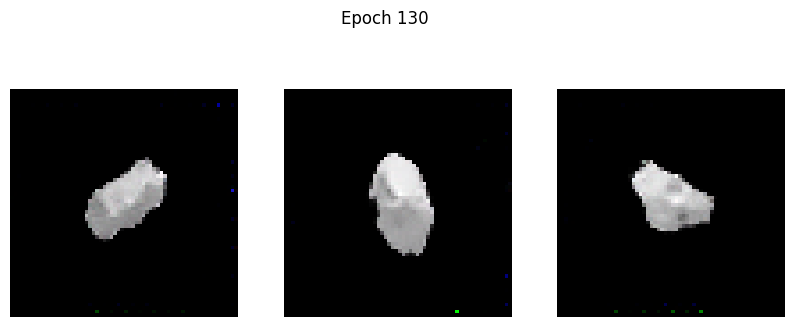

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1454 - g_loss: 2.7798
Epoch 131/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3268 - g_loss: 3.1751

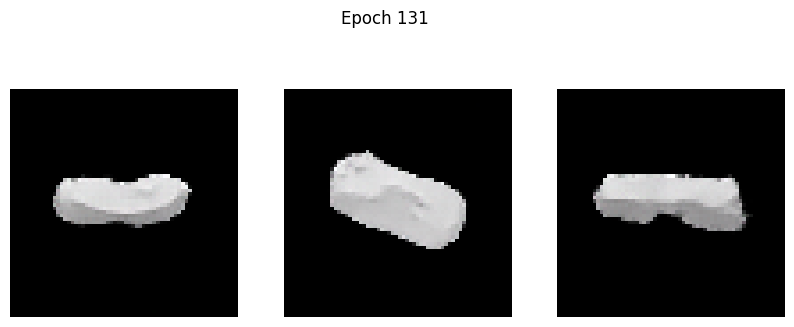

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3266 - g_loss: 3.1741
Epoch 132/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1460 - g_loss: 2.6945

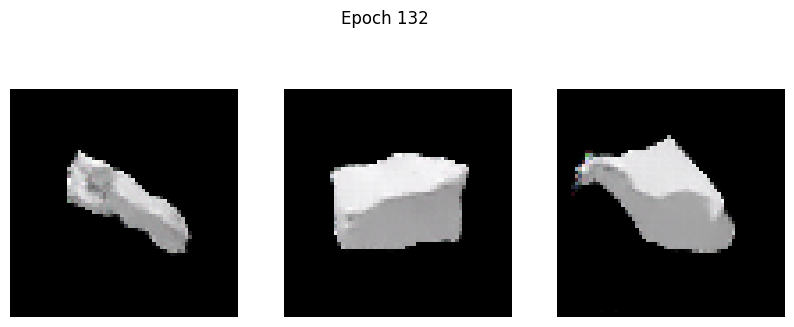

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1460 - g_loss: 2.6949
Epoch 133/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1478 - g_loss: 2.7948

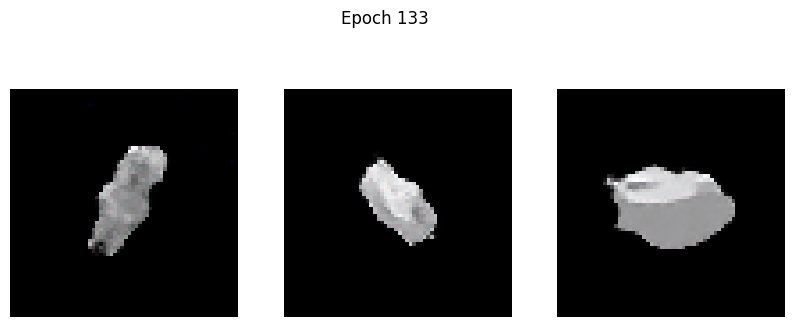

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1479 - g_loss: 2.7947
Epoch 134/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1800 - g_loss: 2.9135

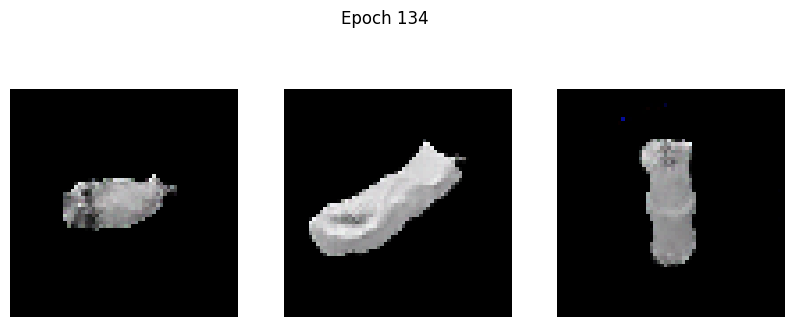

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1800 - g_loss: 2.9133
Epoch 135/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1696 - g_loss: 2.8837

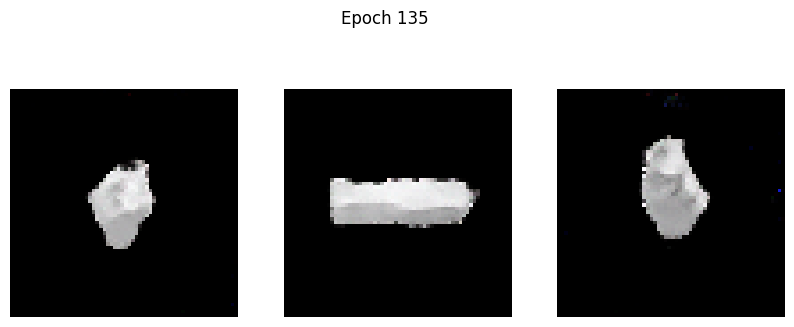

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1697 - g_loss: 2.8836
Epoch 136/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1752 - g_loss: 2.8685

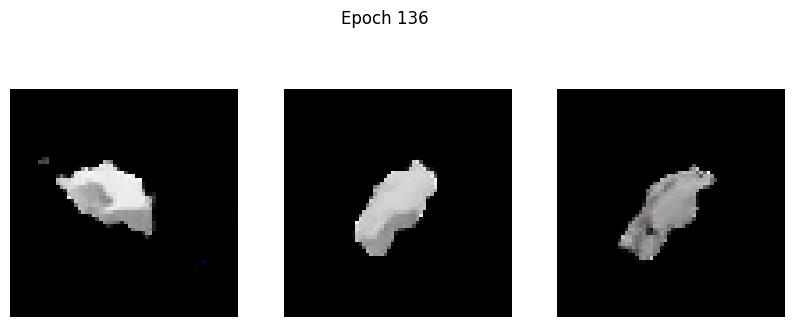

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1757 - g_loss: 2.8691
Epoch 137/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2070 - g_loss: 2.8425

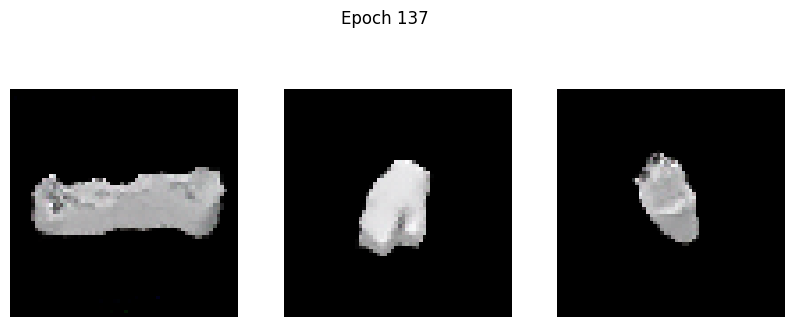

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2065 - g_loss: 2.8422
Epoch 138/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1557 - g_loss: 2.8951

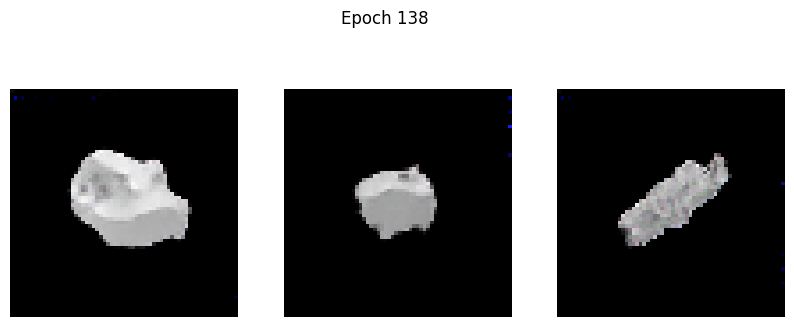

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1558 - g_loss: 2.8949
Epoch 139/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2165 - g_loss: 2.9767

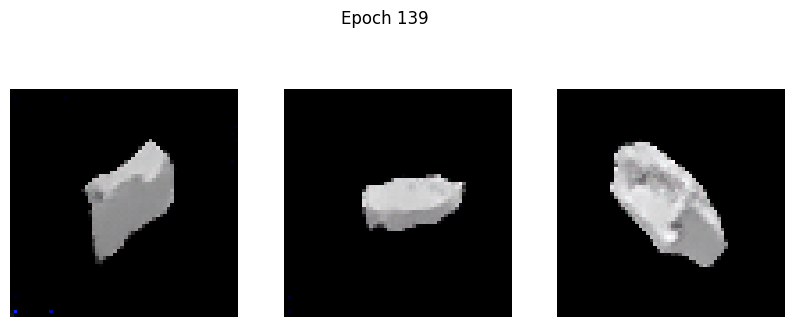

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2163 - g_loss: 2.9766
Epoch 140/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2954 - g_loss: 3.0534

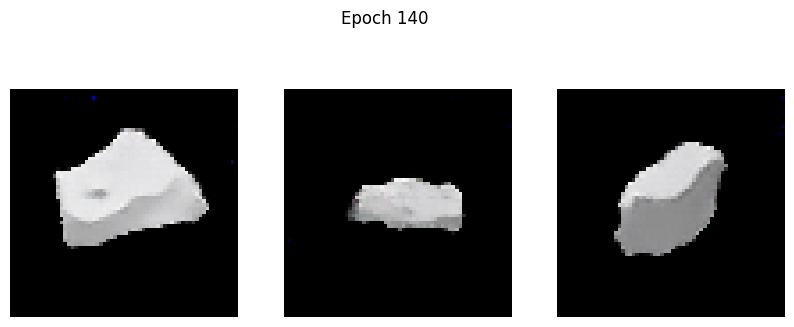

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2950 - g_loss: 3.0527
Epoch 141/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1455 - g_loss: 2.8233

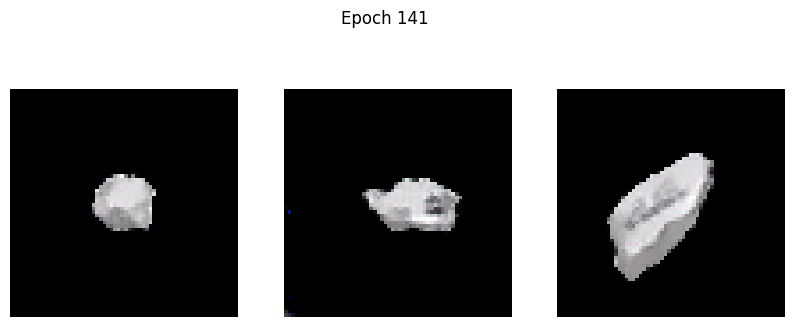

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1456 - g_loss: 2.8237
Epoch 142/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1554 - g_loss: 2.8430

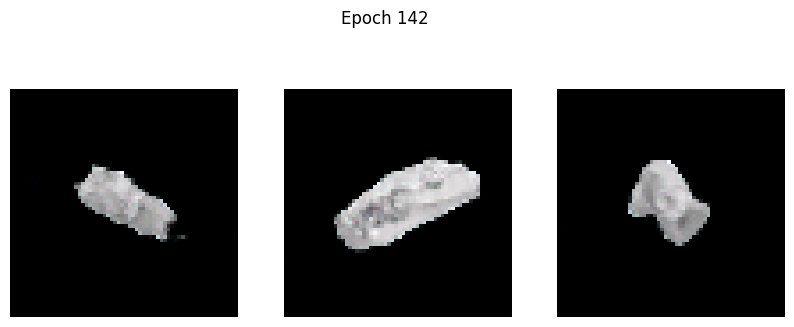

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1555 - g_loss: 2.8435
Epoch 143/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2393 - g_loss: 3.1775

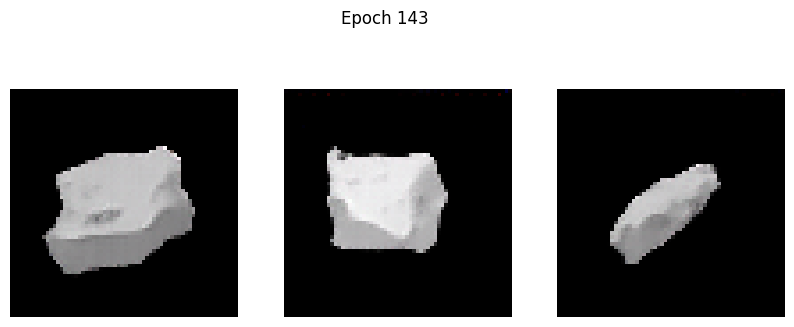

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2396 - g_loss: 3.1763
Epoch 144/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1707 - g_loss: 2.9051

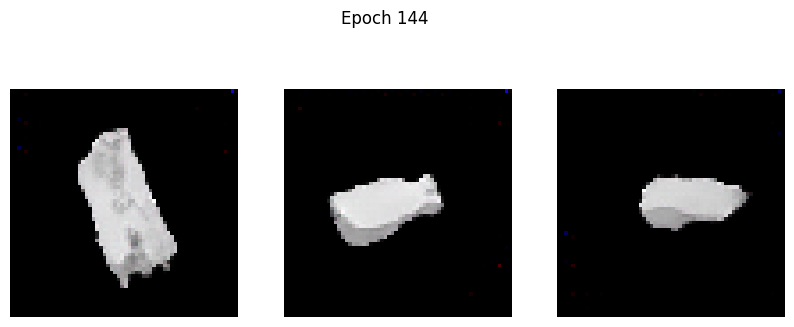

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1707 - g_loss: 2.9049
Epoch 145/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1467 - g_loss: 2.9130

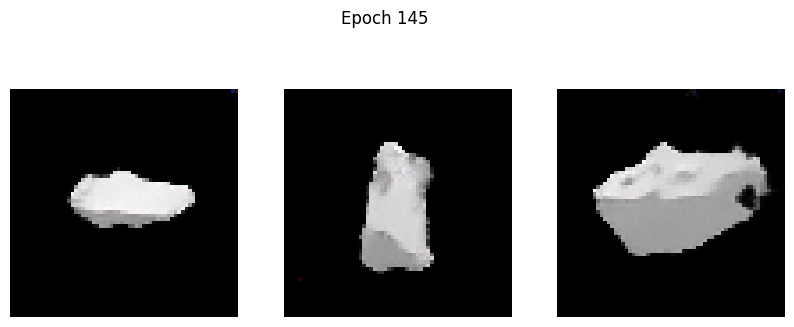

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1467 - g_loss: 2.9130
Epoch 146/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1740 - g_loss: 3.0800

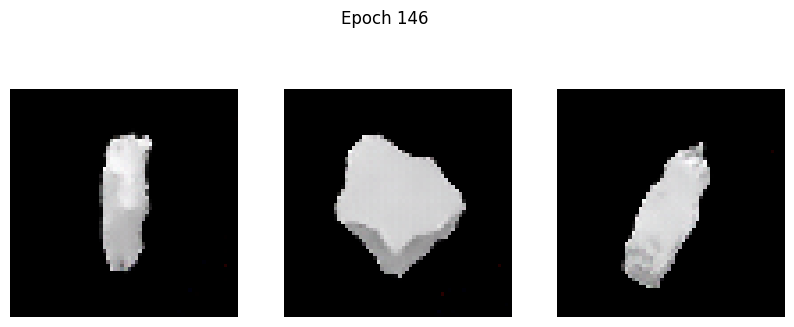

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1746 - g_loss: 3.0802
Epoch 147/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1811 - g_loss: 2.9432

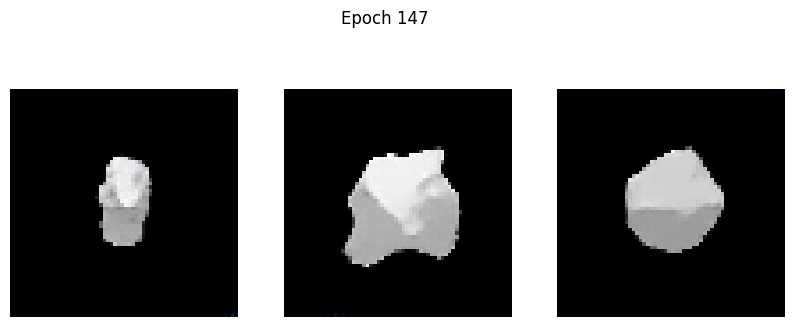

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1808 - g_loss: 2.9431
Epoch 148/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3381 - g_loss: 3.4703

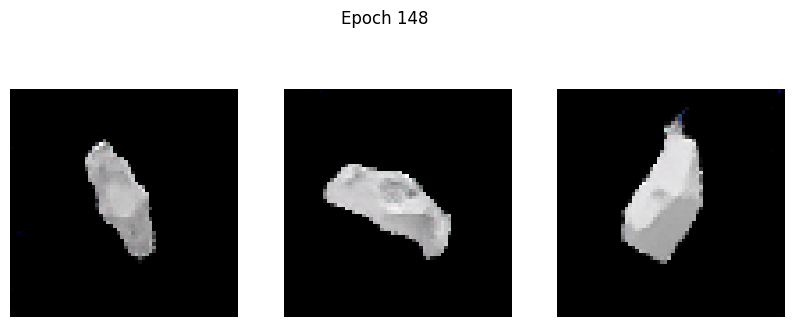

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3371 - g_loss: 3.4670
Epoch 149/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1266 - g_loss: 2.9701

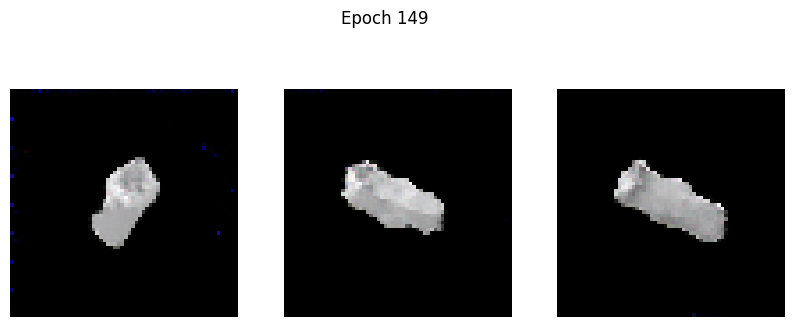

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1267 - g_loss: 2.9700
Epoch 150/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.2632 - g_loss: 4.2052

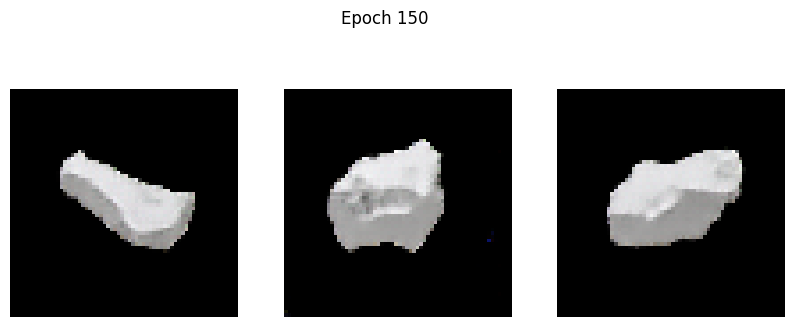

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 1.2597 - g_loss: 4.1975
Epoch 151/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2175 - g_loss: 2.4961

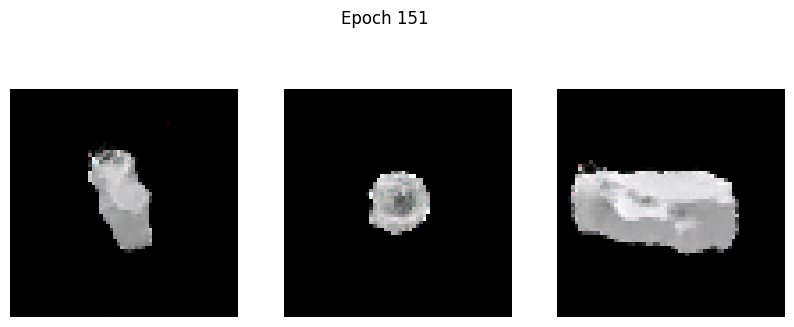

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2173 - g_loss: 2.4963
Epoch 152/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1743 - g_loss: 2.6094

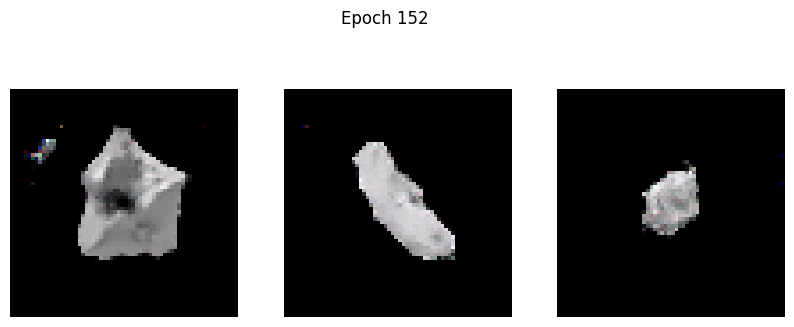

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1742 - g_loss: 2.6095
Epoch 153/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1483 - g_loss: 2.7591

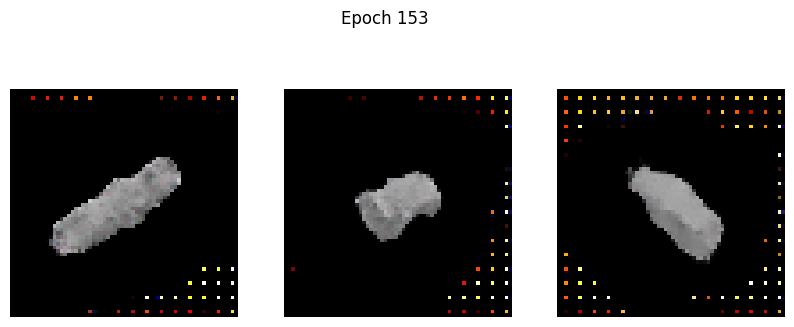

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1483 - g_loss: 2.7590
Epoch 154/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1509 - g_loss: 2.8480

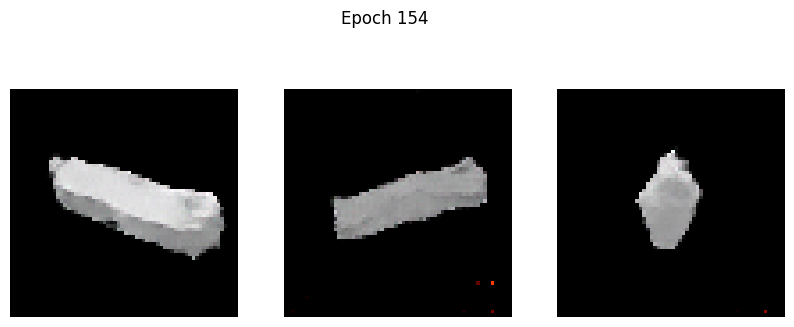

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1509 - g_loss: 2.8478
Epoch 155/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1321 - g_loss: 2.8565

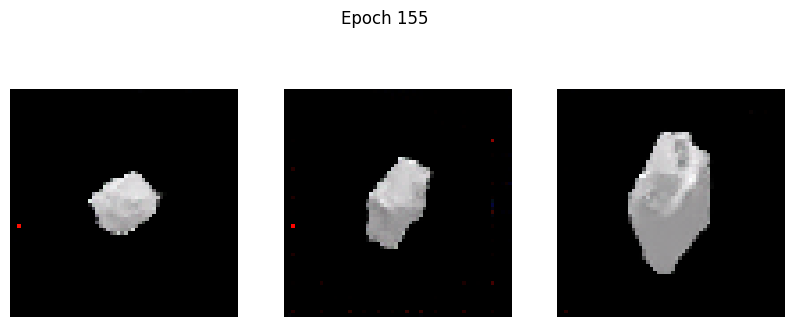

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1322 - g_loss: 2.8565
Epoch 156/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1360 - g_loss: 2.9115

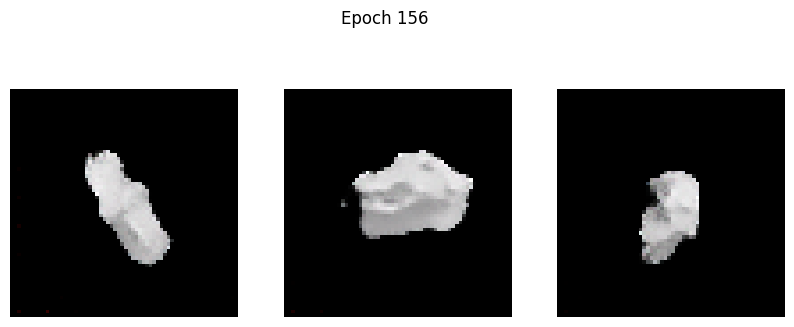

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1360 - g_loss: 2.9116
Epoch 157/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1566 - g_loss: 3.0096

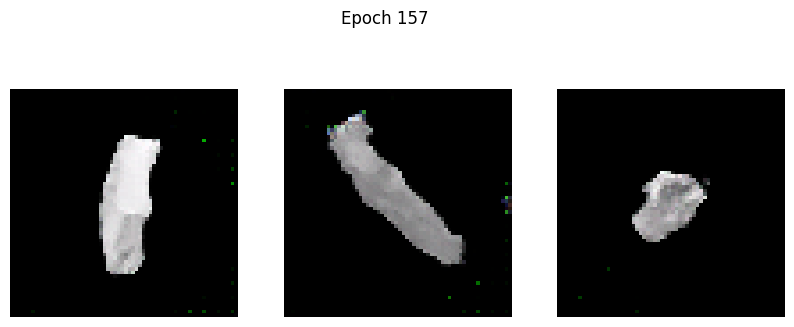

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1566 - g_loss: 3.0095
Epoch 158/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1449 - g_loss: 3.0275

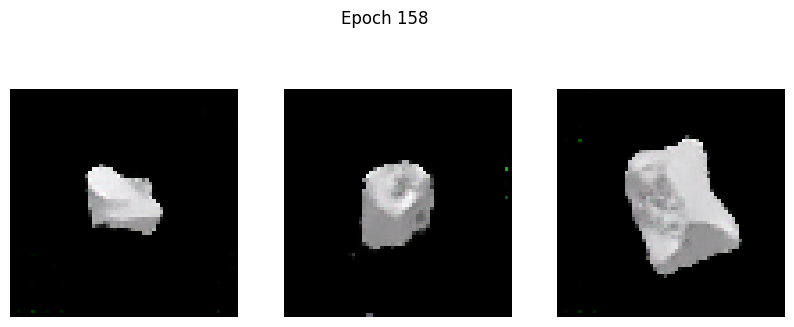

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1451 - g_loss: 3.0277
Epoch 159/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1834 - g_loss: 3.1212

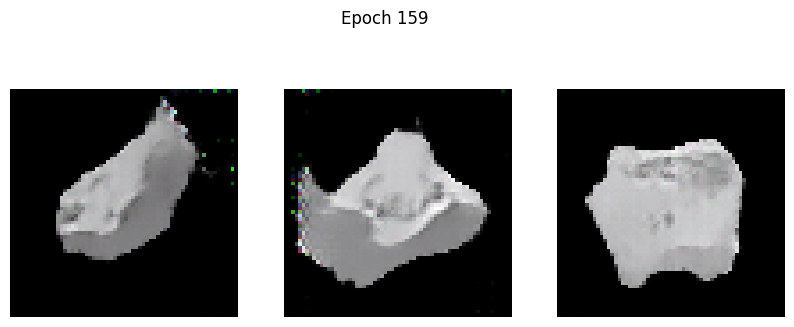

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1835 - g_loss: 3.1204
Epoch 160/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1745 - g_loss: 2.9476

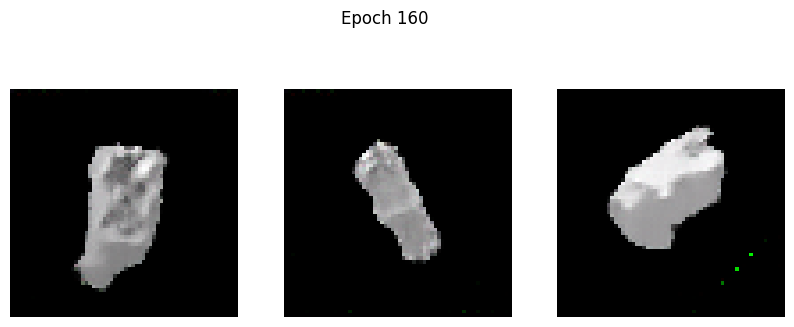

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1746 - g_loss: 2.9484
Epoch 161/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1469 - g_loss: 3.0059

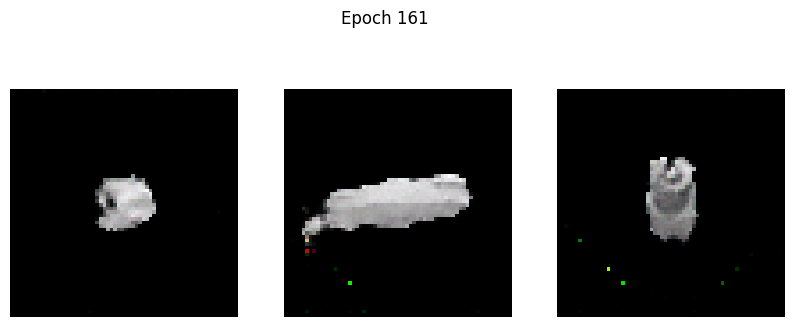

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1471 - g_loss: 3.0063
Epoch 162/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2079 - g_loss: 3.1384

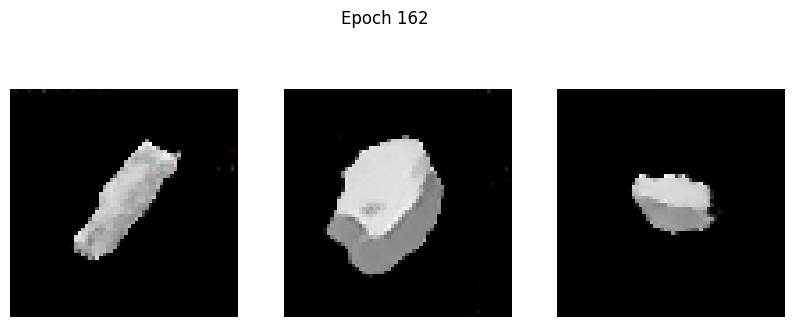

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2078 - g_loss: 3.1380
Epoch 163/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1223 - g_loss: 3.0369

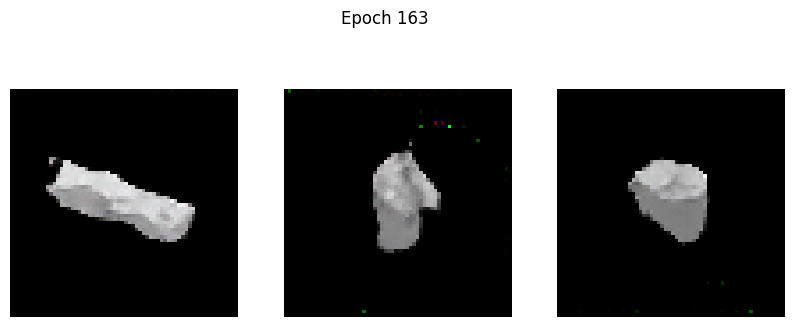

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1224 - g_loss: 3.0370
Epoch 164/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1719 - g_loss: 3.0353

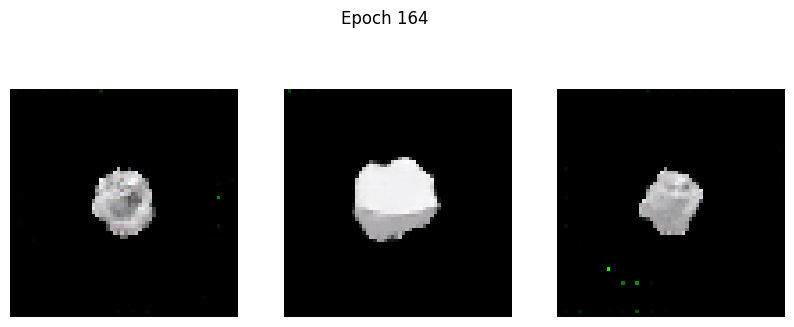

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1718 - g_loss: 3.0357
Epoch 165/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1530 - g_loss: 3.1507

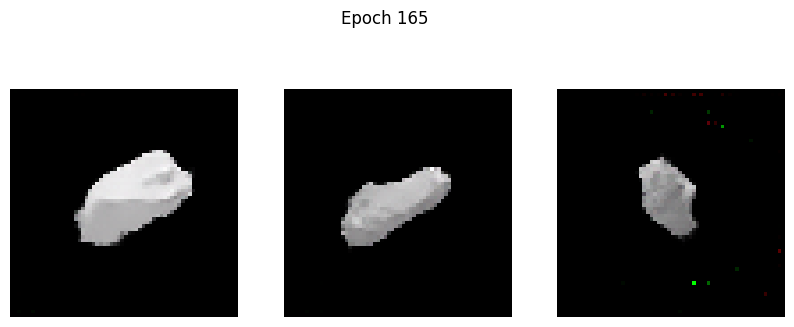

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1529 - g_loss: 3.1506
Epoch 166/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1670 - g_loss: 3.1500

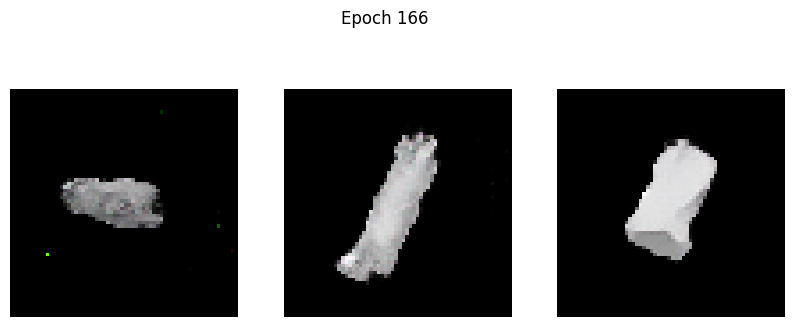

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1668 - g_loss: 3.1495
Epoch 167/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1762 - g_loss: 3.2543

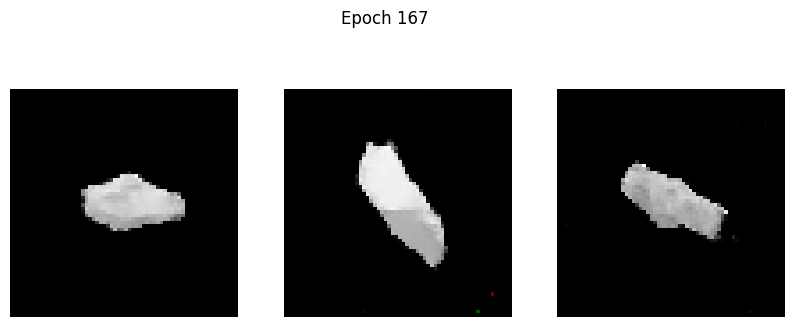

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1761 - g_loss: 3.2535
Epoch 168/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1822 - g_loss: 3.1606

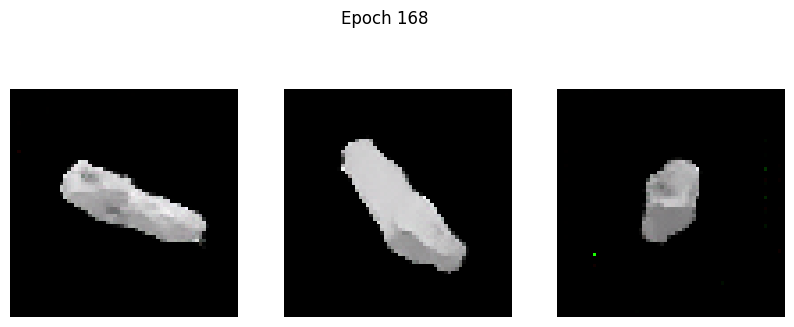

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1823 - g_loss: 3.1613
Epoch 169/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1987 - g_loss: 3.1897

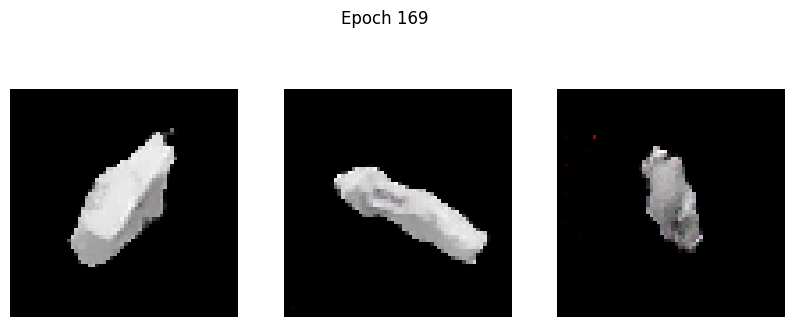

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1986 - g_loss: 3.1893
Epoch 170/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1284 - g_loss: 3.1672

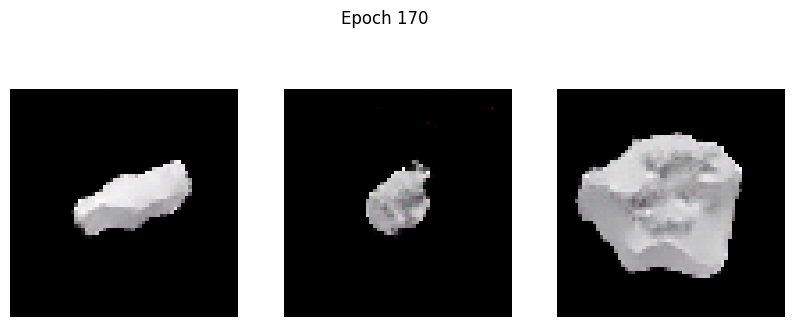

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1284 - g_loss: 3.1671
Epoch 171/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1908 - g_loss: 3.2961

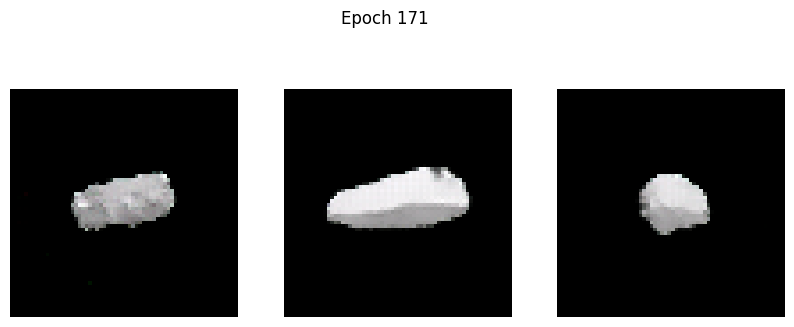

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1908 - g_loss: 3.2960
Epoch 172/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2983 - g_loss: 3.3704

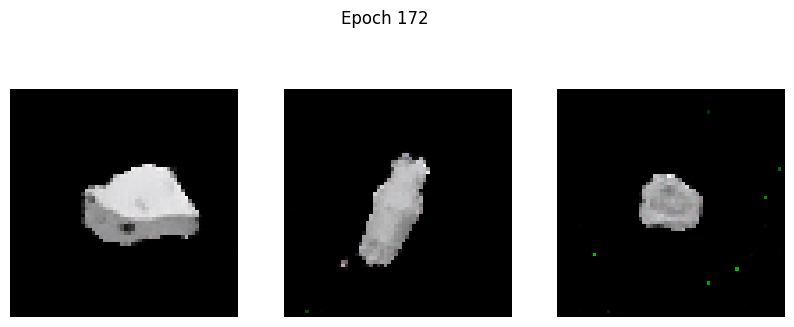

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2972 - g_loss: 3.3687
Epoch 173/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1480 - g_loss: 3.1705

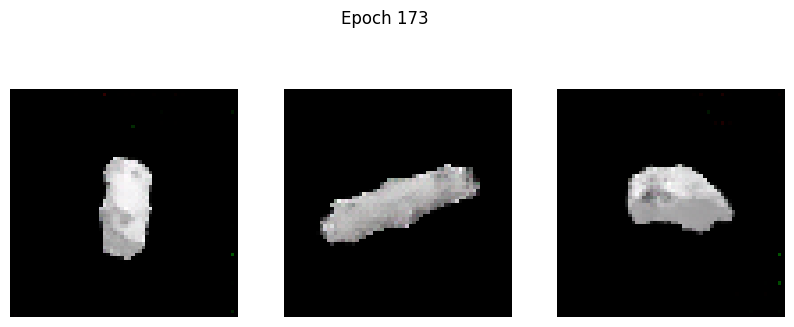

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1480 - g_loss: 3.1702
Epoch 174/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1583 - g_loss: 3.2125

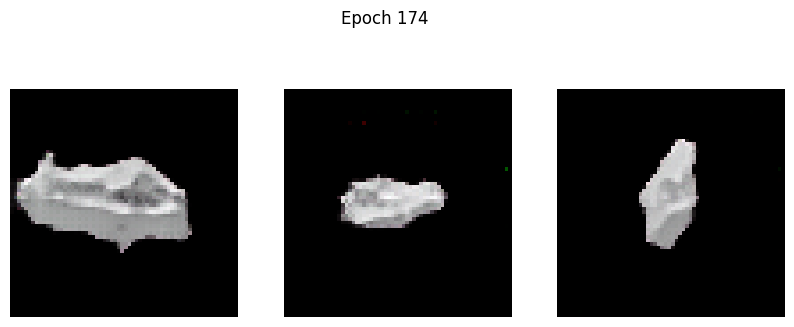

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1589 - g_loss: 3.2138
Epoch 175/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2139 - g_loss: 3.3758

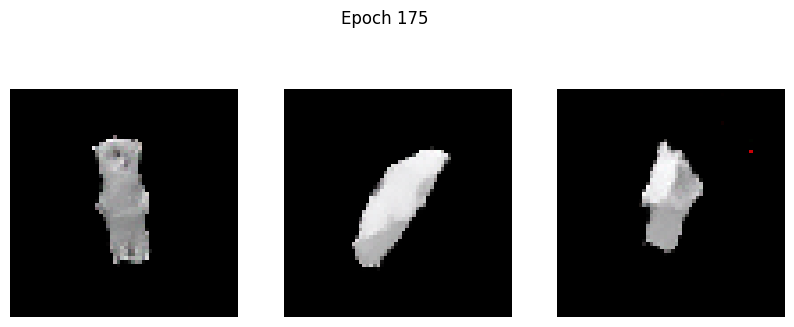

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2135 - g_loss: 3.3744
Epoch 176/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1240 - g_loss: 3.1364

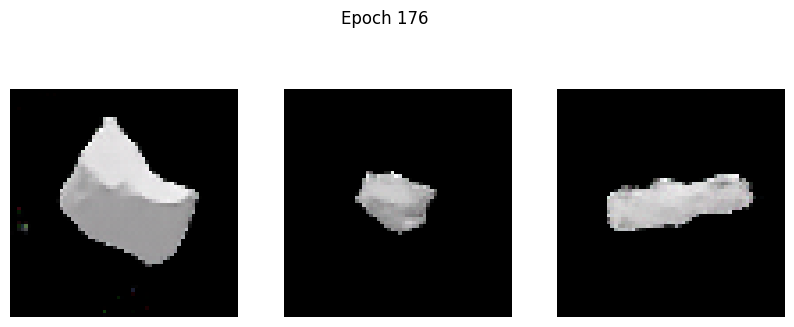

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1242 - g_loss: 3.1369
Epoch 177/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1282 - g_loss: 3.1798

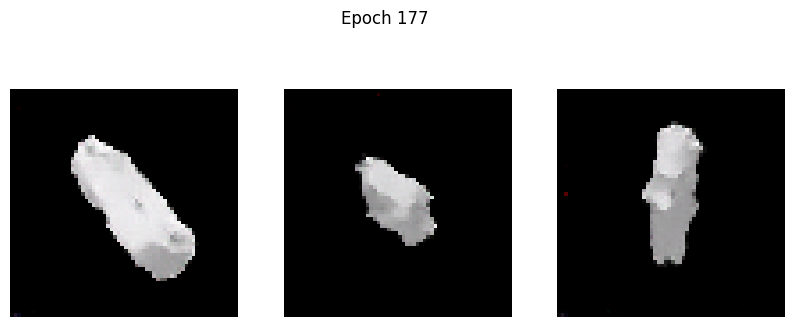

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1281 - g_loss: 3.1800
Epoch 178/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1240 - g_loss: 3.1799

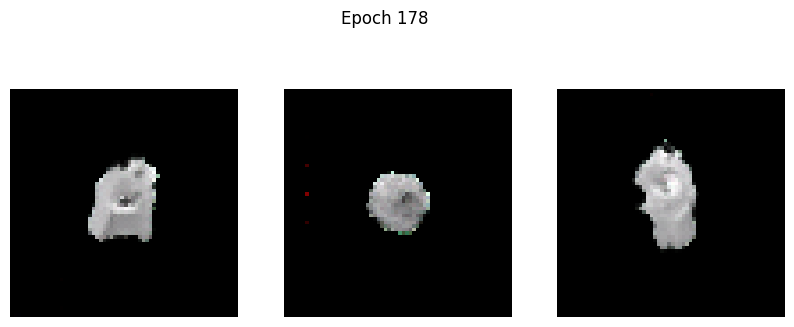

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1252 - g_loss: 3.1818
Epoch 179/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1666 - g_loss: 3.0807

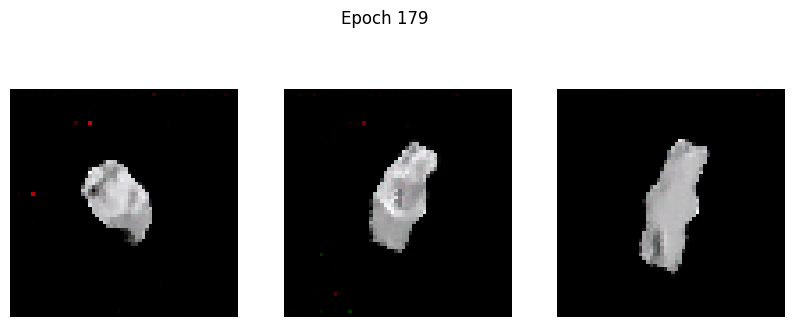

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1664 - g_loss: 3.0808
Epoch 180/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1244 - g_loss: 3.1270

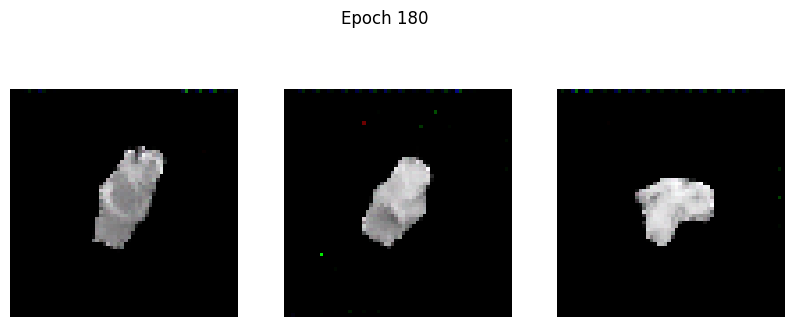

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1246 - g_loss: 3.1282
Epoch 181/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1237 - g_loss: 3.3094

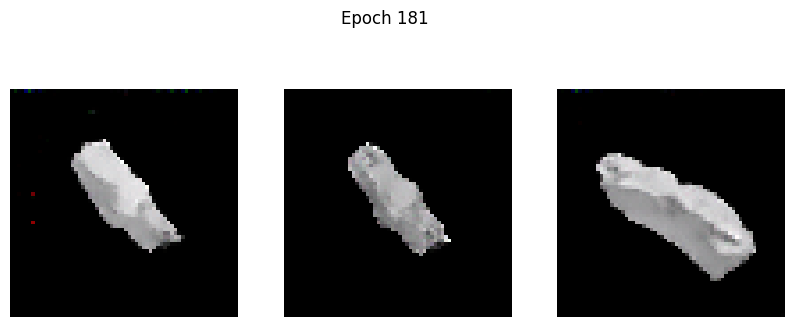

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1238 - g_loss: 3.3091
Epoch 182/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1975 - g_loss: 3.3575

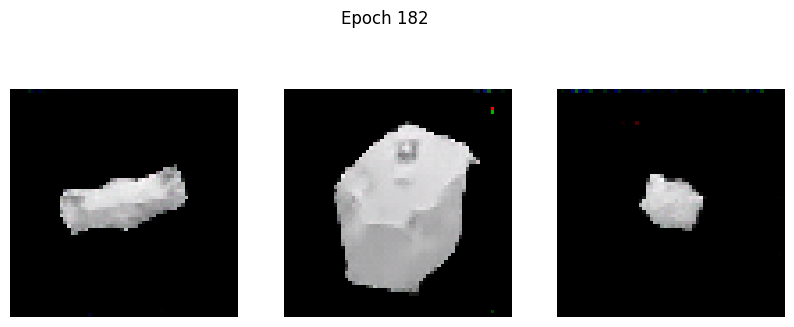

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1971 - g_loss: 3.3564
Epoch 183/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1282 - g_loss: 3.3605

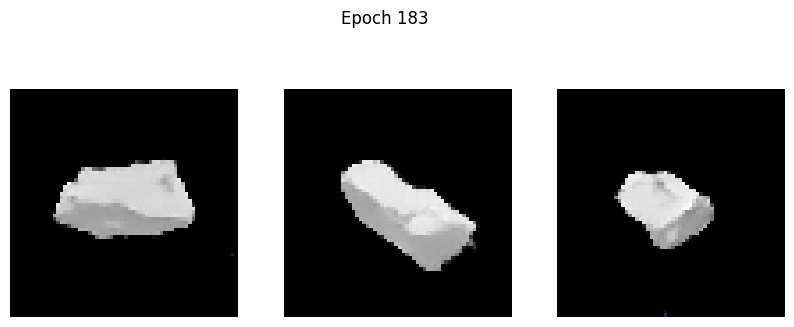

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1282 - g_loss: 3.3599
Epoch 184/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1734 - g_loss: 3.3959

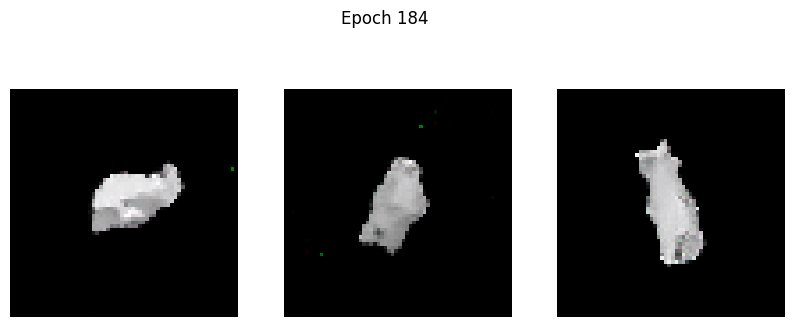

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1733 - g_loss: 3.3956
Epoch 185/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1571 - g_loss: 3.3371

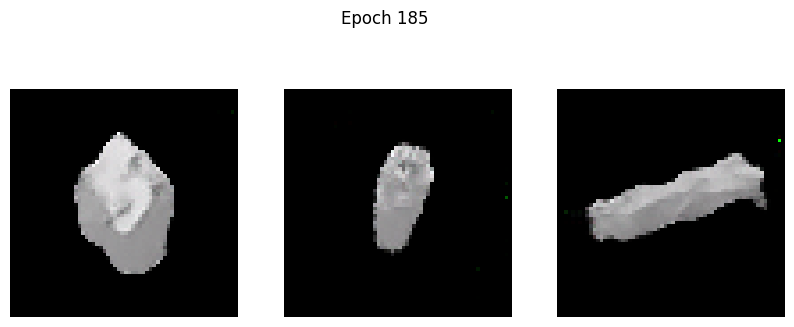

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1572 - g_loss: 3.3369
Epoch 186/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1238 - g_loss: 3.3734

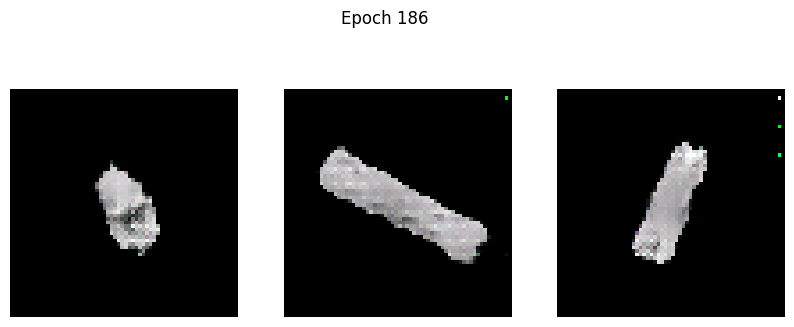

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1257 - g_loss: 3.3787
Epoch 187/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.7445 - g_loss: 4.1896

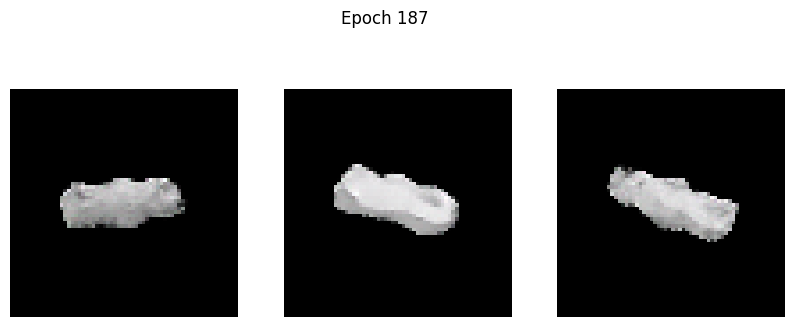

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.7404 - g_loss: 4.1819
Epoch 188/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1222 - g_loss: 3.0867

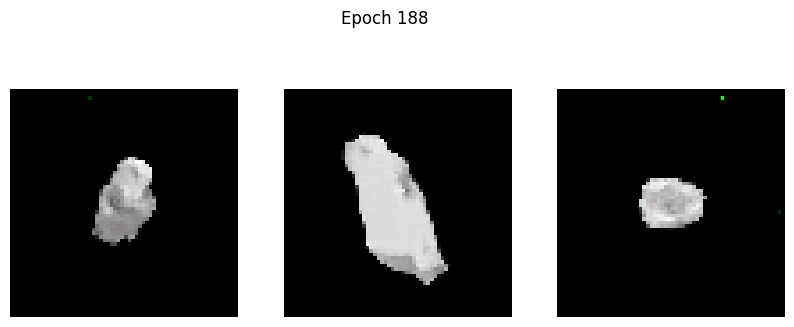

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1221 - g_loss: 3.0868
Epoch 189/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1212 - g_loss: 3.2541

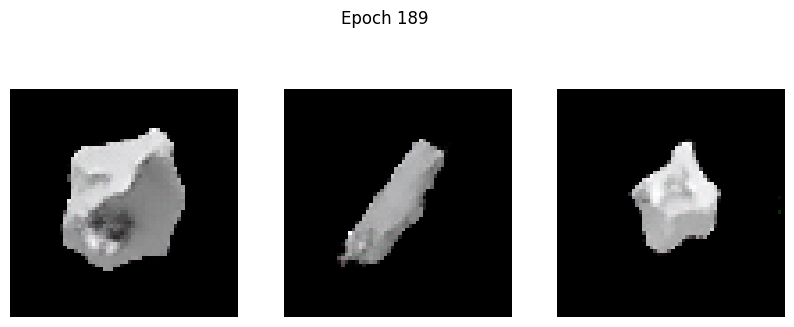

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1212 - g_loss: 3.2540
Epoch 190/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1122 - g_loss: 3.2088

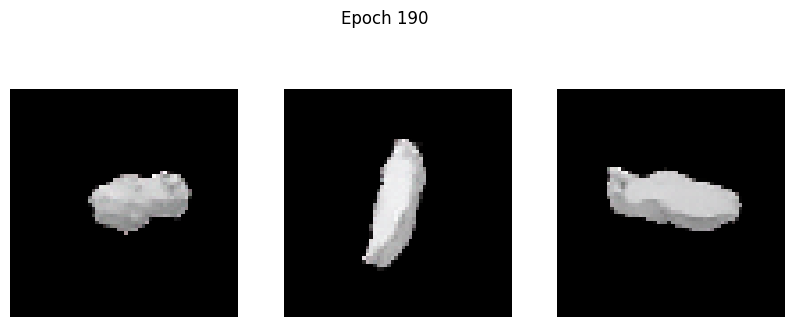

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1122 - g_loss: 3.2093
Epoch 191/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1279 - g_loss: 3.3383

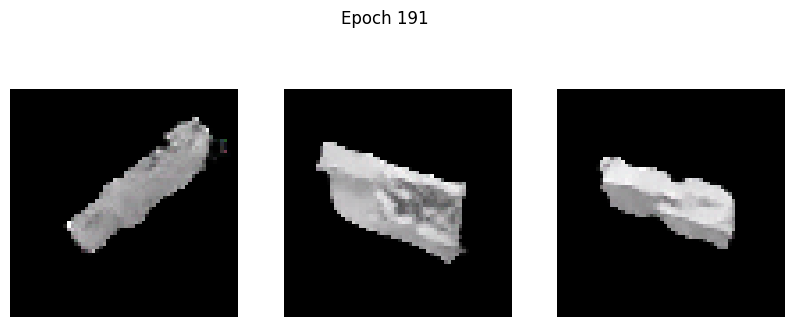

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1279 - g_loss: 3.3384
Epoch 192/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1121 - g_loss: 3.3201

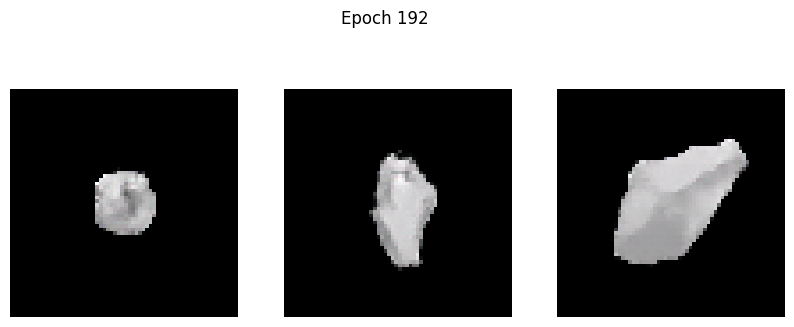

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1121 - g_loss: 3.3198
Epoch 193/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1318 - g_loss: 3.4188

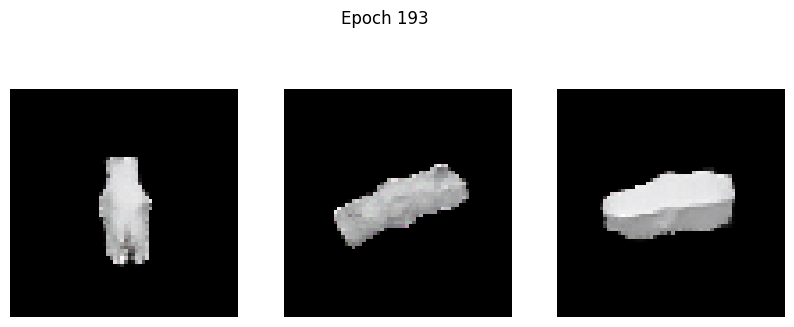

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1320 - g_loss: 3.4193
Epoch 194/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1576 - g_loss: 3.4963

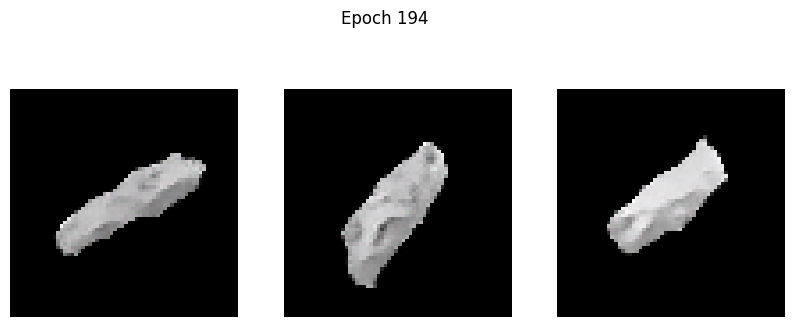

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1577 - g_loss: 3.4962
Epoch 195/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1325 - g_loss: 3.3263

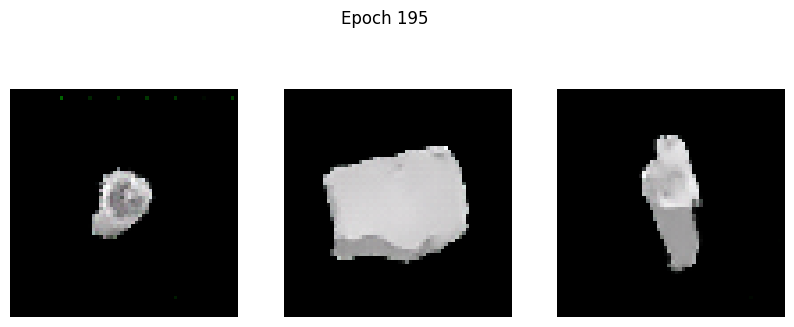

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1324 - g_loss: 3.3265
Epoch 196/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1236 - g_loss: 3.5381

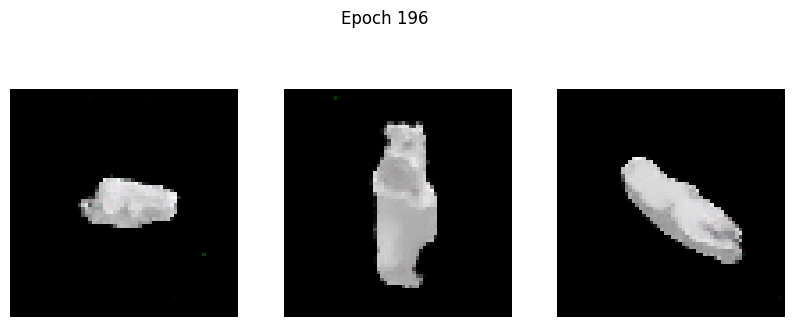

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1236 - g_loss: 3.5373
Epoch 197/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1454 - g_loss: 3.5869

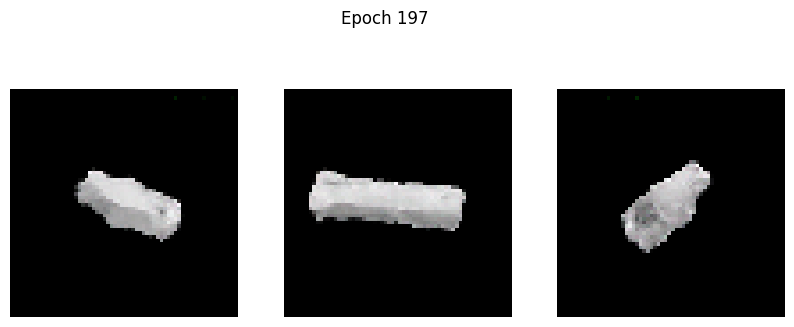

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1455 - g_loss: 3.5864
Epoch 198/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2423 - g_loss: 3.6165

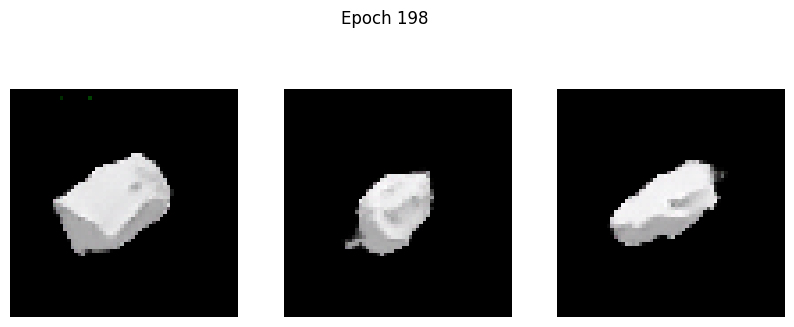

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.2420 - g_loss: 3.6155
Epoch 199/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1171 - g_loss: 3.3911

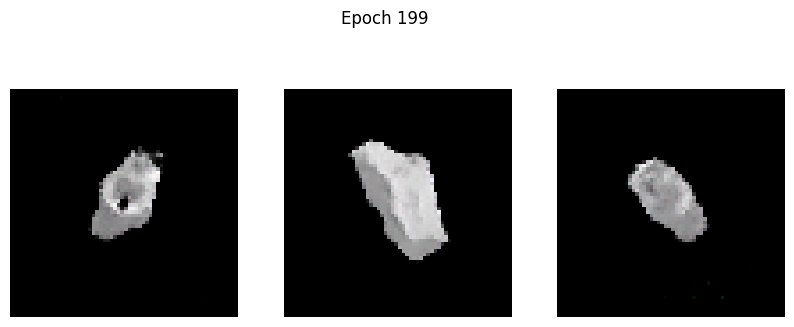

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1171 - g_loss: 3.3913
Epoch 200/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.1647 - g_loss: 3.5502

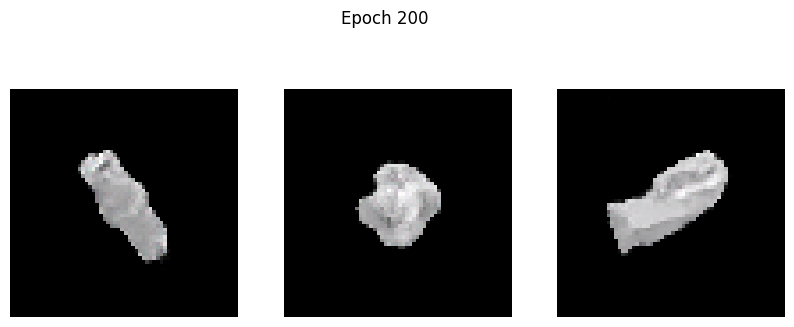

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - d_loss: 0.1645 - g_loss: 3.5499
Epoch 201/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1030 - g_loss: 3.4286

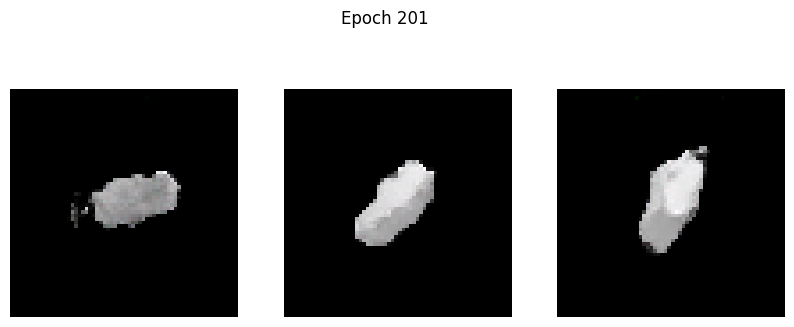

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1035 - g_loss: 3.4291
Epoch 202/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1265 - g_loss: 3.4386

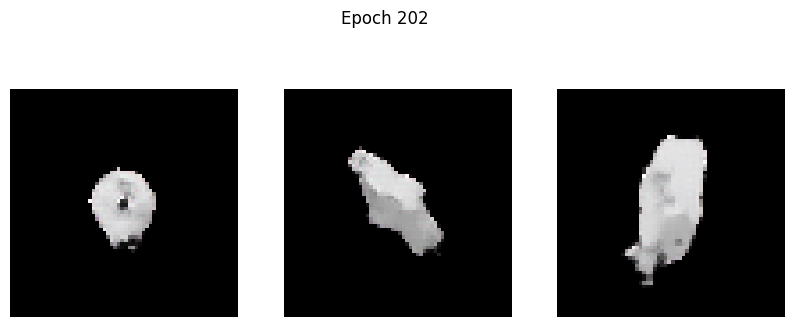

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1270 - g_loss: 3.4393
Epoch 203/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1111 - g_loss: 3.4113

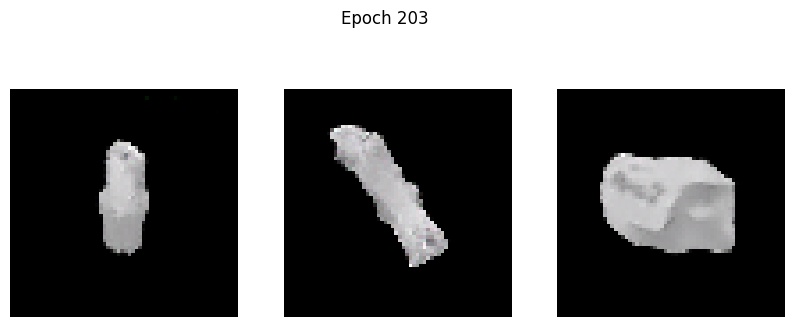

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1110 - g_loss: 3.4109
Epoch 204/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1233 - g_loss: 3.5405

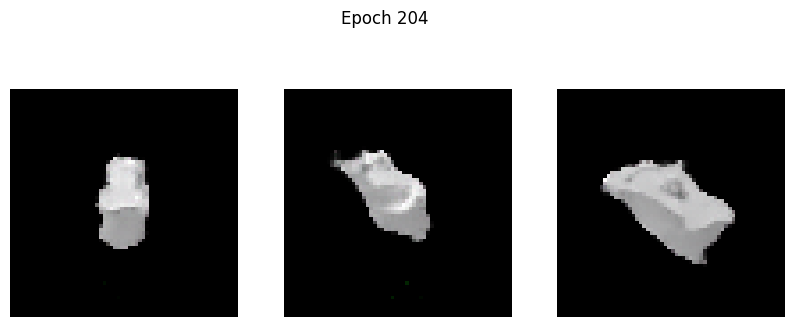

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1233 - g_loss: 3.5398
Epoch 205/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 1.3329 - g_loss: 5.4937

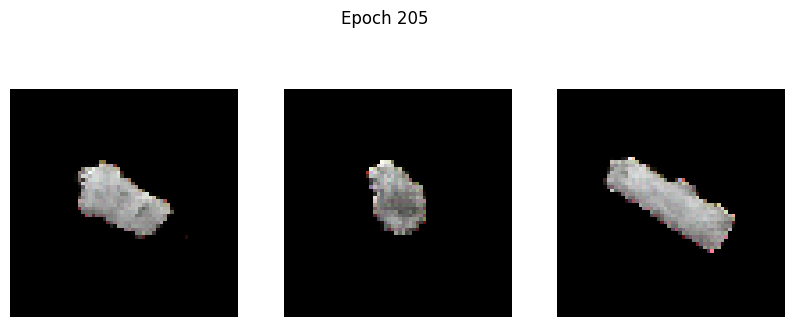

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 1.3315 - g_loss: 5.4855
Epoch 206/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.2262 - g_loss: 2.6591

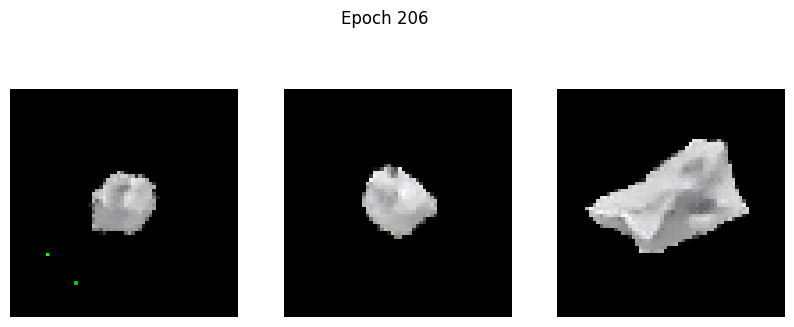

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.2259 - g_loss: 2.6599
Epoch 207/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1464 - g_loss: 2.9148

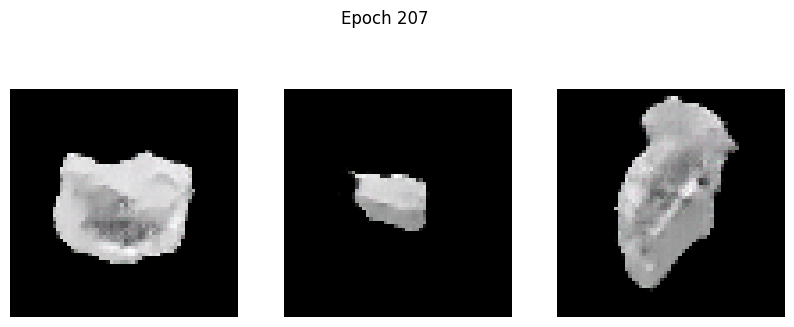

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1464 - g_loss: 2.9150
Epoch 208/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1396 - g_loss: 2.9888

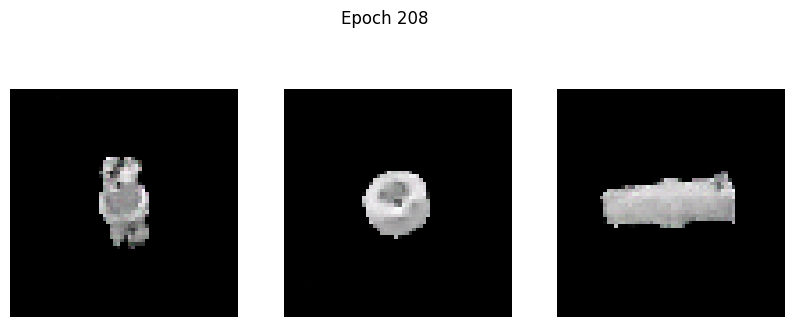

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1396 - g_loss: 2.9895
Epoch 209/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1387 - g_loss: 3.1196

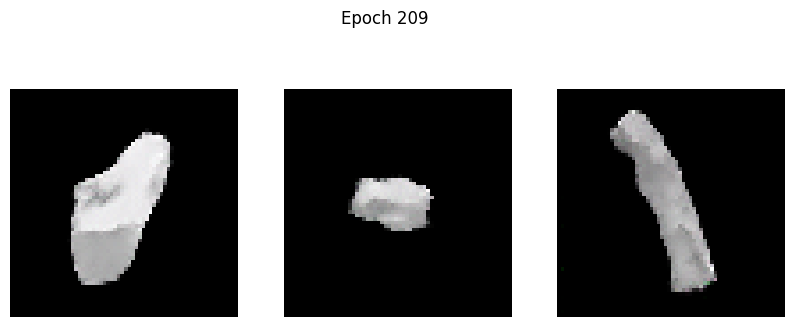

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1386 - g_loss: 3.1200
Epoch 210/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1176 - g_loss: 3.1792

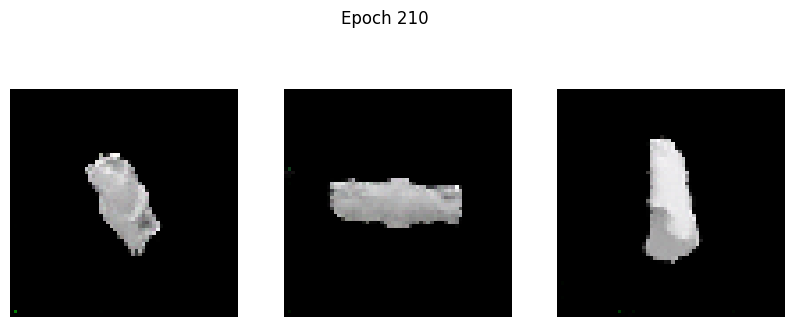

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1176 - g_loss: 3.1794
Epoch 211/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1057 - g_loss: 3.2829

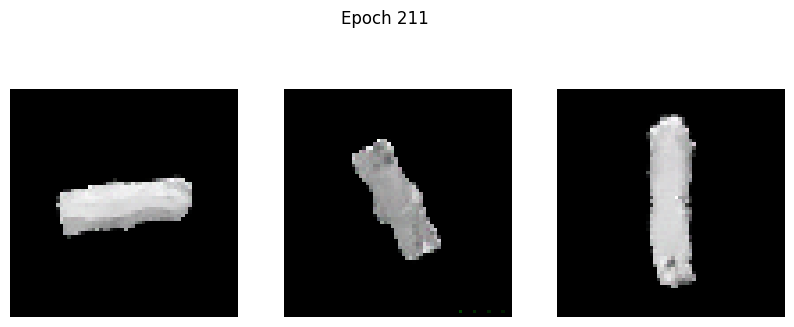

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1057 - g_loss: 3.2823
Epoch 212/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1128 - g_loss: 3.2981

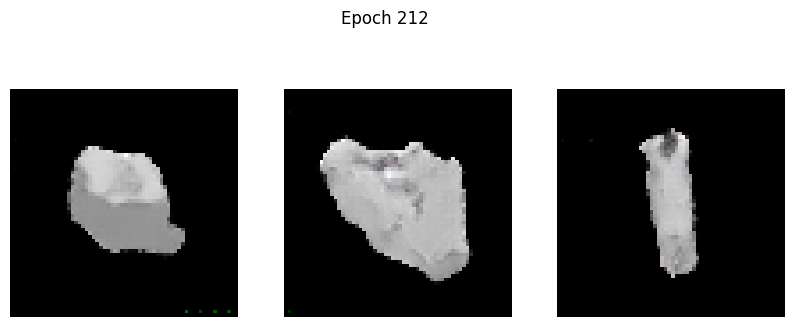

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1129 - g_loss: 3.2984
Epoch 213/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1147 - g_loss: 3.3910

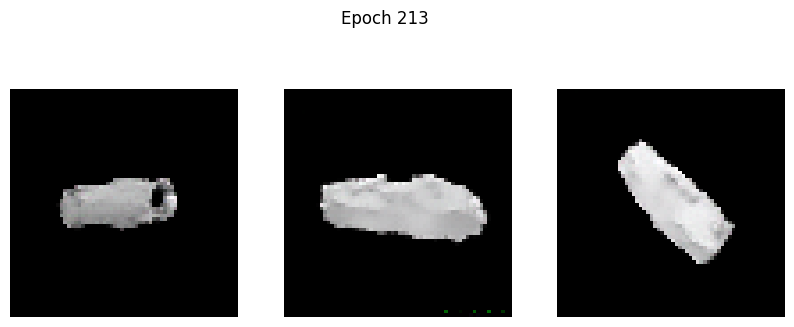

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1147 - g_loss: 3.3907
Epoch 214/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1154 - g_loss: 3.5083

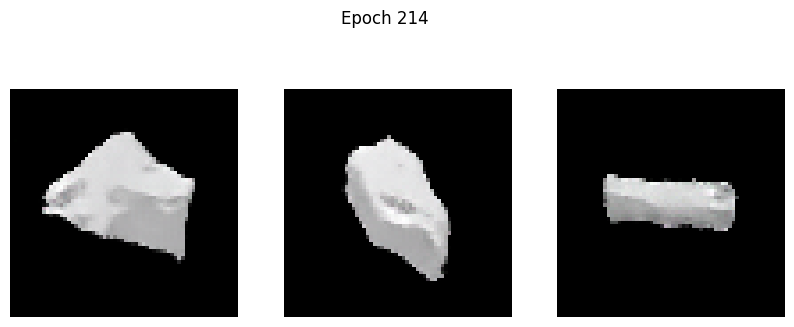

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1155 - g_loss: 3.5078
Epoch 215/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1068 - g_loss: 3.4938

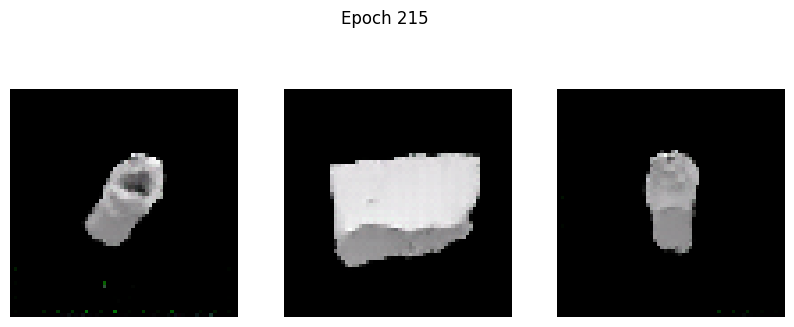

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1068 - g_loss: 3.4936
Epoch 216/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1071 - g_loss: 3.4311

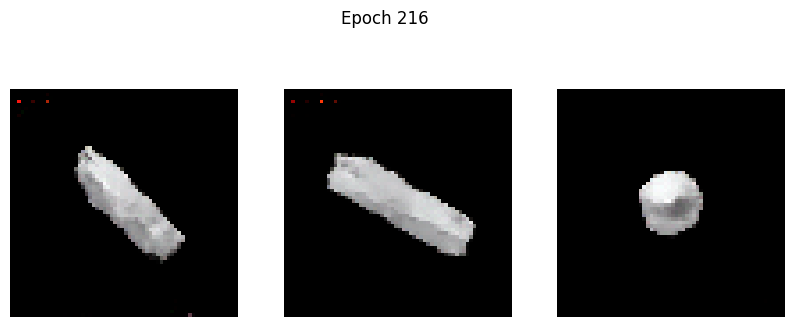

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1081 - g_loss: 3.4324
Epoch 217/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2921 - g_loss: 3.4821

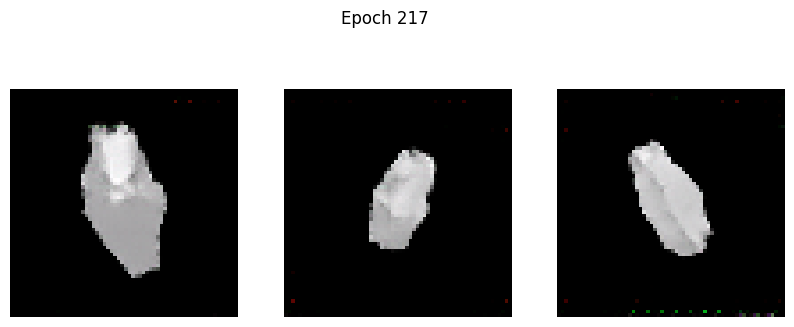

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2908 - g_loss: 3.4815
Epoch 218/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0995 - g_loss: 3.3487

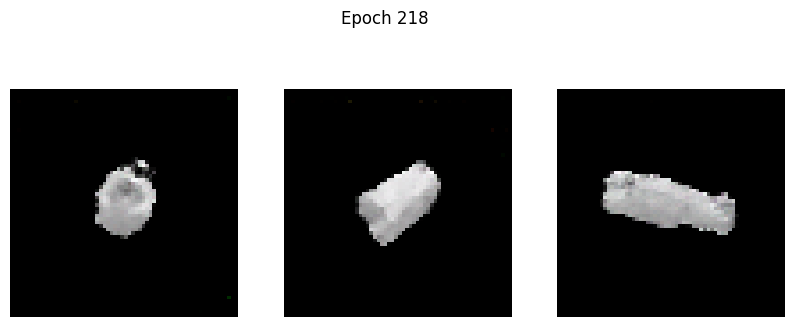

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0995 - g_loss: 3.3492
Epoch 219/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0964 - g_loss: 3.5001

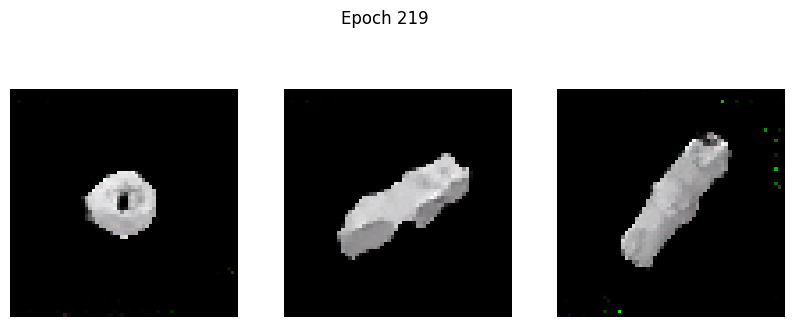

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0964 - g_loss: 3.4999
Epoch 220/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1854 - g_loss: 3.5014

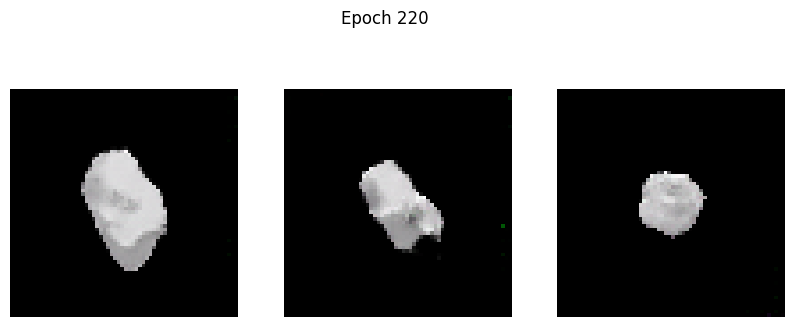

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1852 - g_loss: 3.5011
Epoch 221/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1128 - g_loss: 3.5024

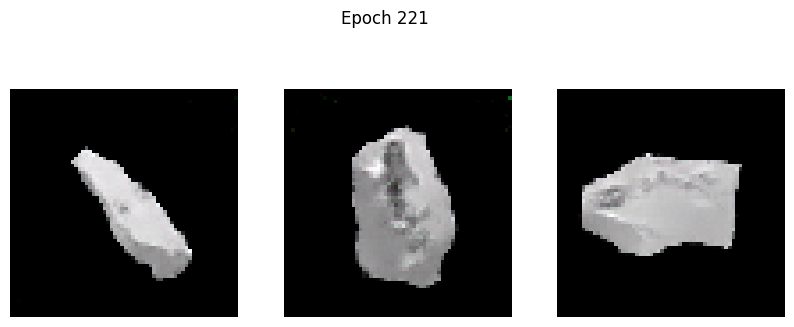

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1127 - g_loss: 3.5024
Epoch 222/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1082 - g_loss: 3.4970

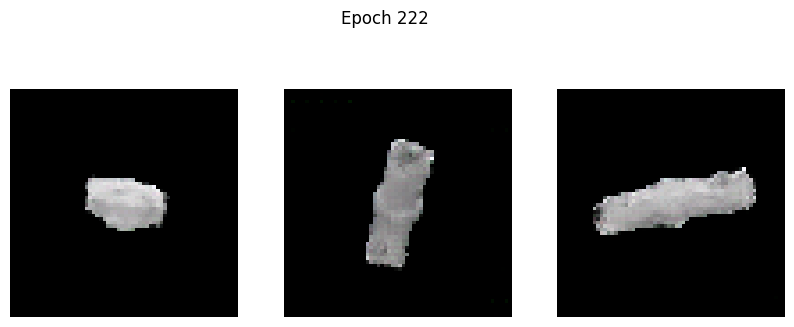

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1083 - g_loss: 3.4977
Epoch 223/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1438 - g_loss: 3.5092

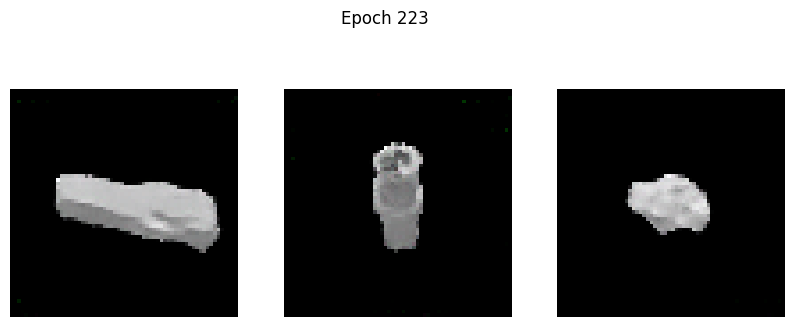

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1437 - g_loss: 3.5094
Epoch 224/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1065 - g_loss: 3.5620

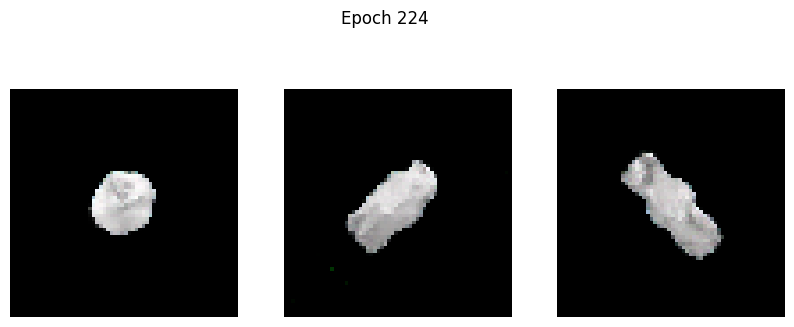

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1068 - g_loss: 3.5624
Epoch 225/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2687 - g_loss: 3.7878

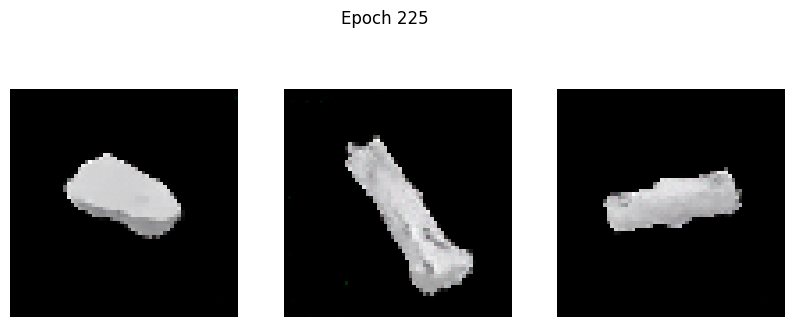

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2677 - g_loss: 3.7858
Epoch 226/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1011 - g_loss: 3.5023

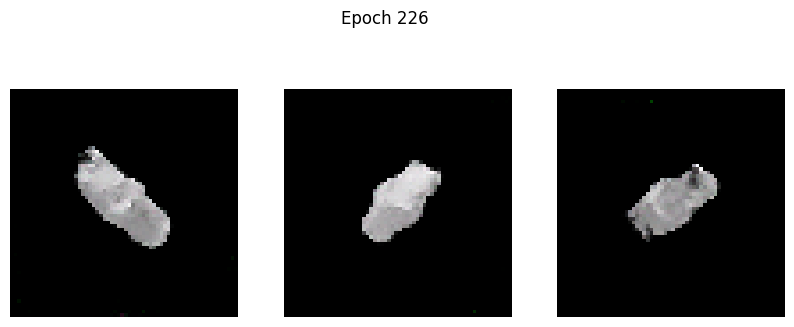

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1010 - g_loss: 3.5025
Epoch 227/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1392 - g_loss: 3.6654

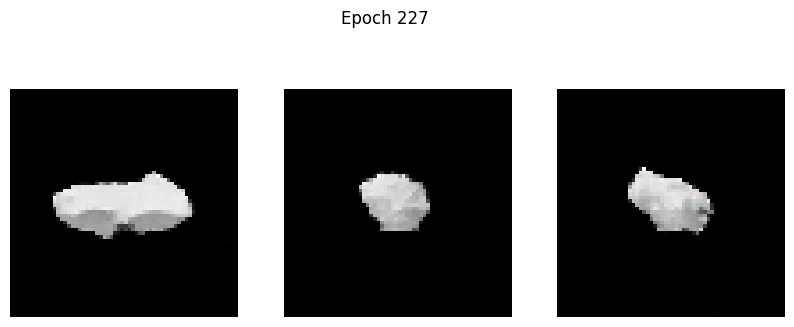

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1395 - g_loss: 3.6660
Epoch 228/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1029 - g_loss: 3.4699

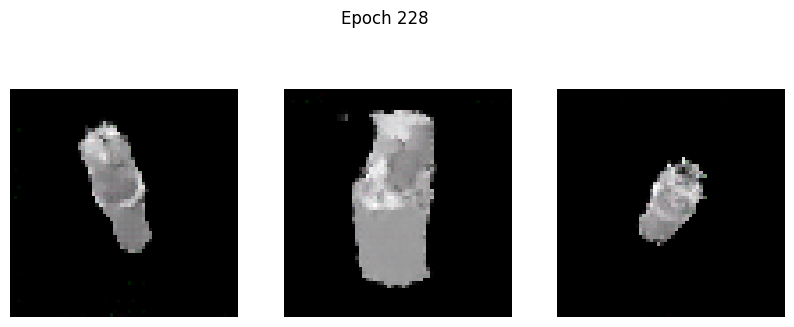

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1031 - g_loss: 3.4705
Epoch 229/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1129 - g_loss: 3.5348

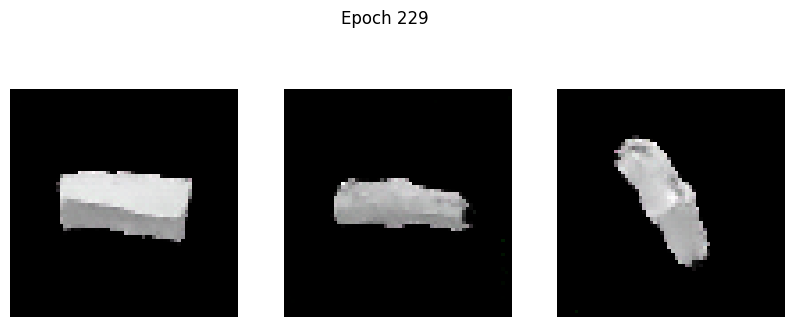

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1130 - g_loss: 3.5352
Epoch 230/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1532 - g_loss: 3.6922

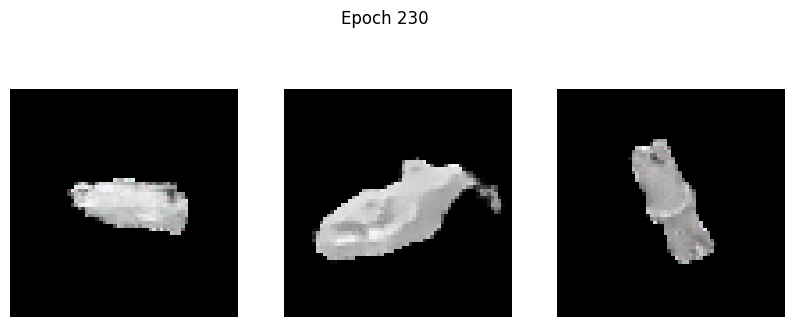

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1536 - g_loss: 3.6923
Epoch 231/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1007 - g_loss: 3.5750

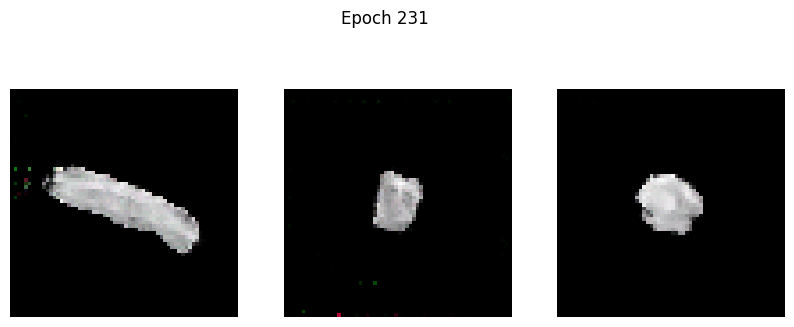

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1007 - g_loss: 3.5750
Epoch 232/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1062 - g_loss: 3.6278

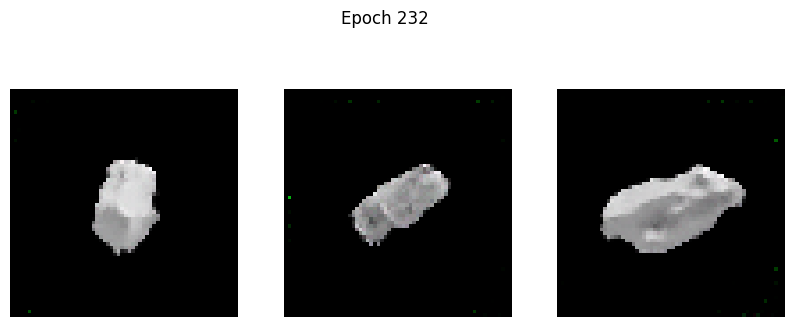

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1065 - g_loss: 3.6290
Epoch 233/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1026 - g_loss: 3.5602

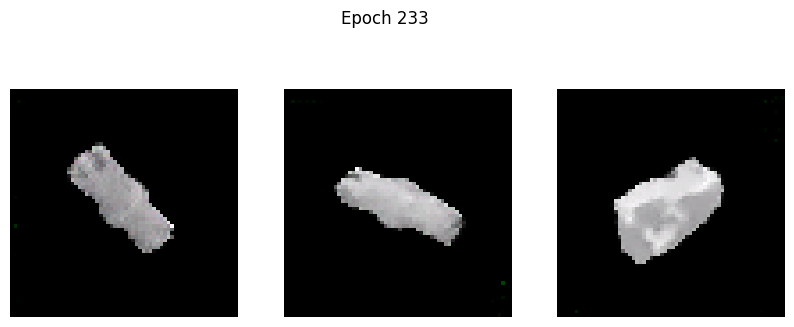

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1027 - g_loss: 3.5601
Epoch 234/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1070 - g_loss: 3.5478

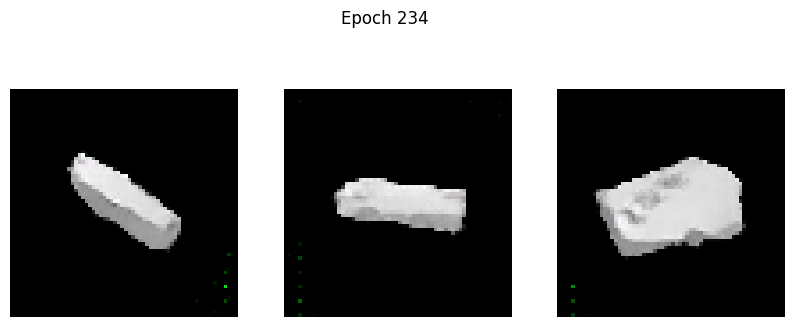

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1071 - g_loss: 3.5486
Epoch 235/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3065 - g_loss: 3.8934

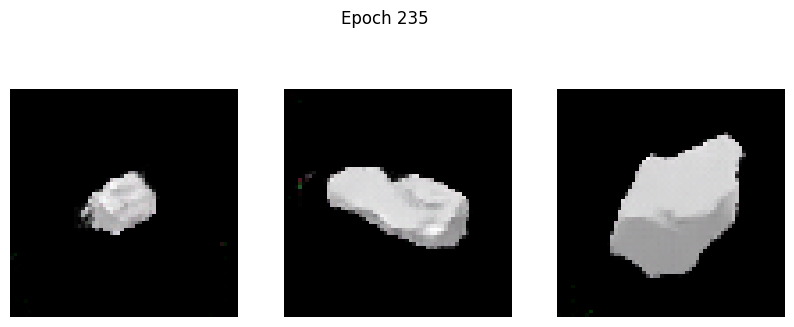

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3055 - g_loss: 3.8915
Epoch 236/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0983 - g_loss: 3.5974

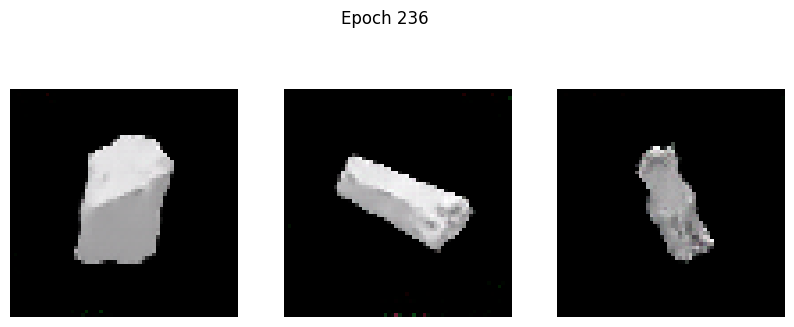

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0982 - g_loss: 3.5974
Epoch 237/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0898 - g_loss: 3.6058

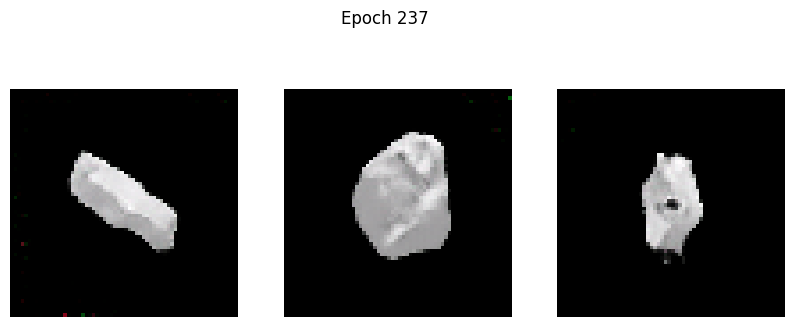

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0899 - g_loss: 3.6065
Epoch 238/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2097 - g_loss: 3.9109

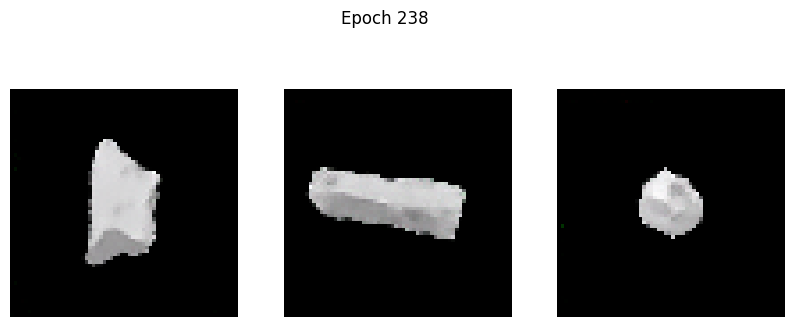

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2098 - g_loss: 3.9112
Epoch 239/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0880 - g_loss: 3.6269

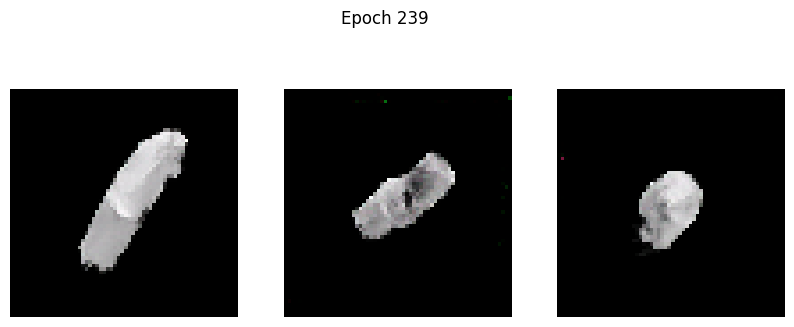

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0880 - g_loss: 3.6267
Epoch 240/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0786 - g_loss: 3.6543

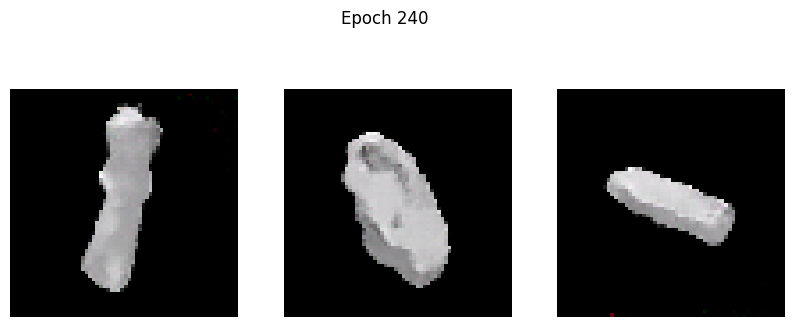

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0786 - g_loss: 3.6542
Epoch 241/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2535 - g_loss: 3.9365

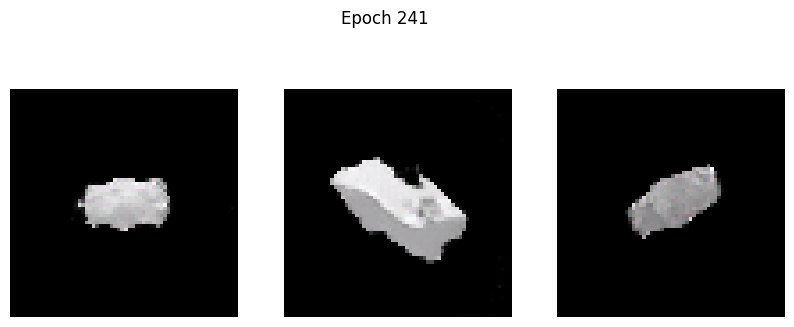

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2533 - g_loss: 3.9359
Epoch 242/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0857 - g_loss: 3.5800

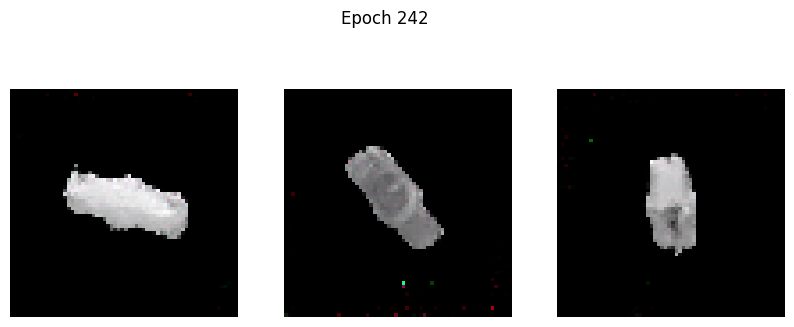

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0859 - g_loss: 3.5802
Epoch 243/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1072 - g_loss: 3.6123

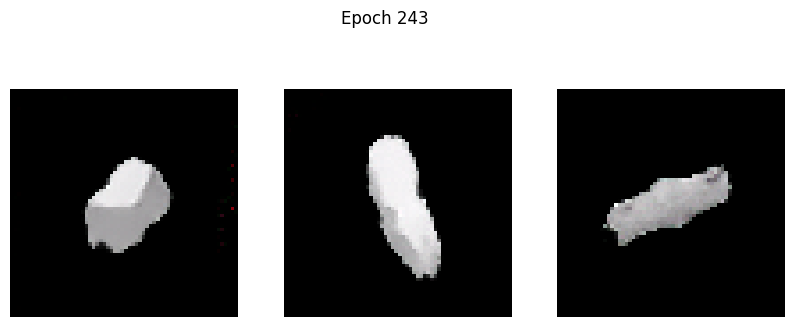

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1071 - g_loss: 3.6124
Epoch 244/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0753 - g_loss: 3.7292

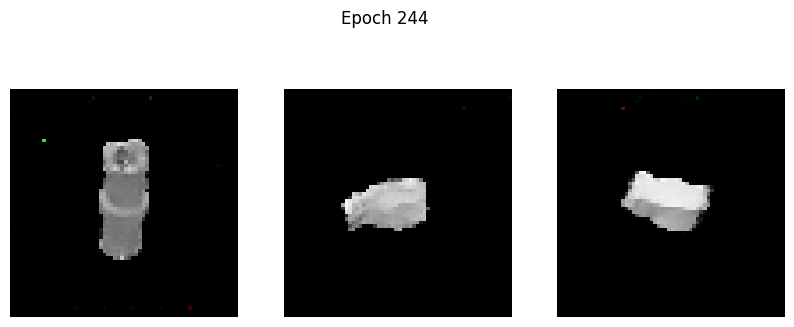

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0754 - g_loss: 3.7292
Epoch 245/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3334 - g_loss: 4.0242

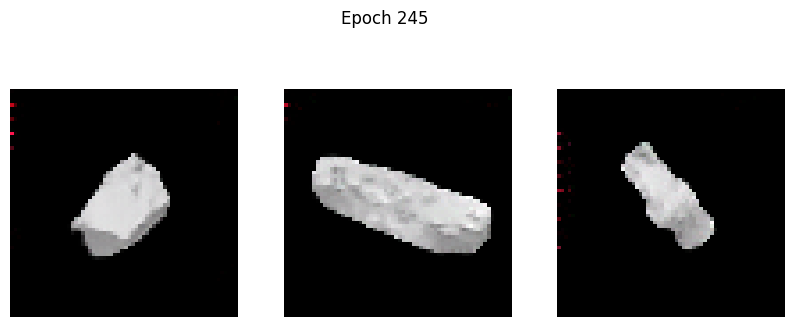

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3327 - g_loss: 4.0220
Epoch 246/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1004 - g_loss: 3.6970

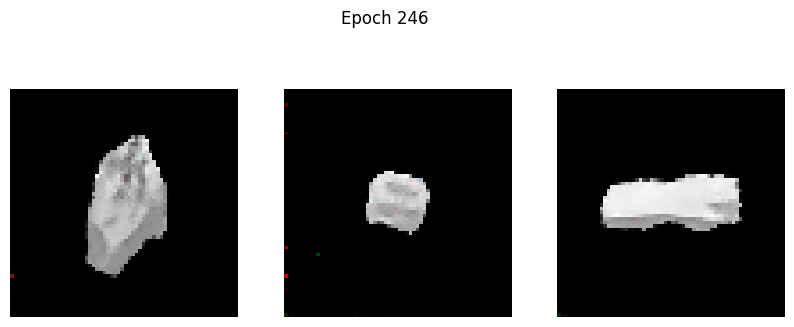

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1002 - g_loss: 3.6967
Epoch 247/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0981 - g_loss: 3.7510

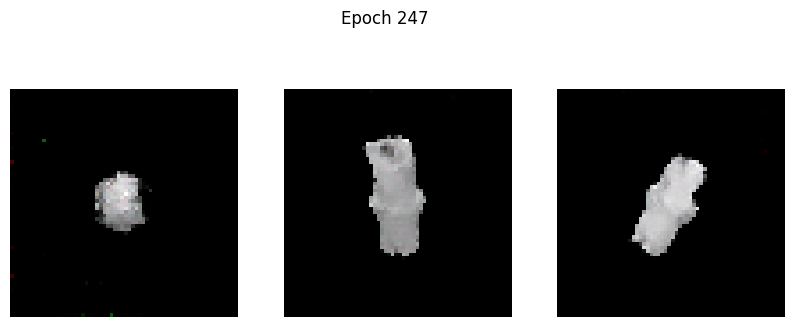

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - d_loss: 0.0980 - g_loss: 3.7504
Epoch 248/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0695 - g_loss: 3.6528

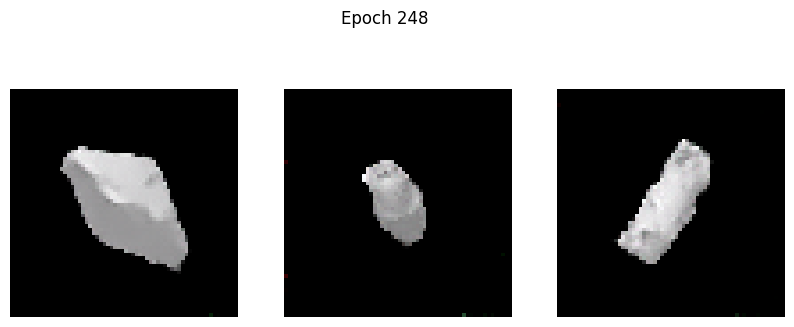

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0697 - g_loss: 3.6538
Epoch 249/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0889 - g_loss: 3.8195

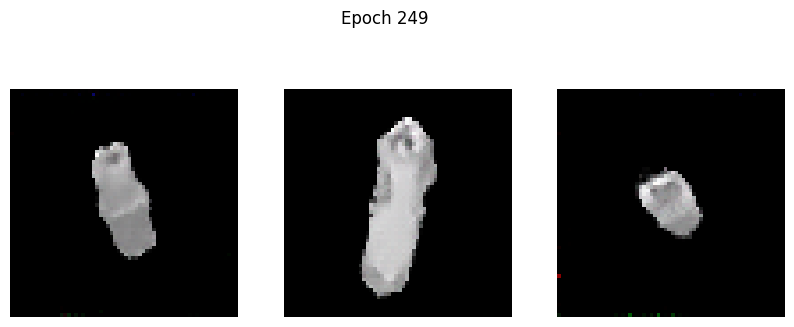

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0890 - g_loss: 3.8197
Epoch 250/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1772 - g_loss: 3.9842

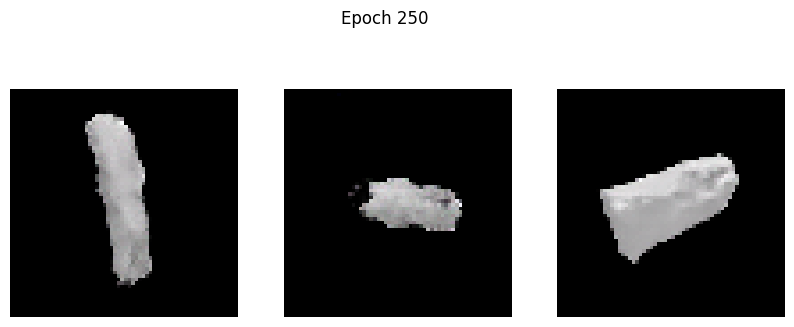

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1783 - g_loss: 3.9861
Epoch 251/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0939 - g_loss: 3.7339

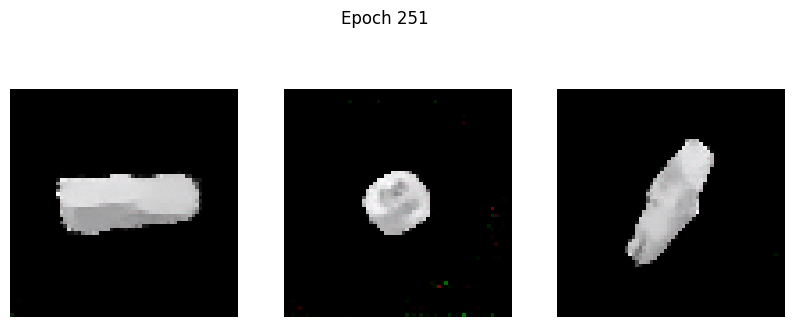

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0938 - g_loss: 3.7332
Epoch 252/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0782 - g_loss: 3.7046

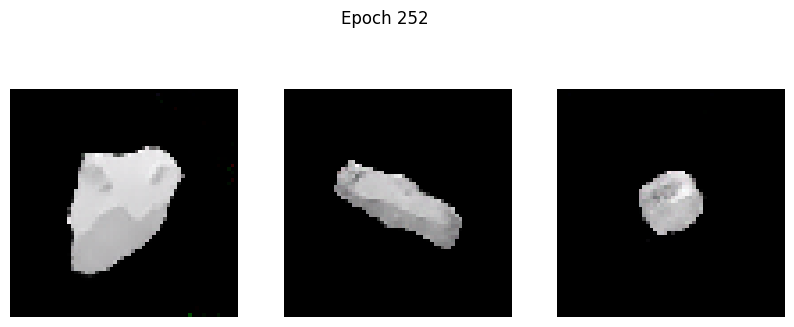

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.0782 - g_loss: 3.7049
Epoch 253/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0913 - g_loss: 3.7866

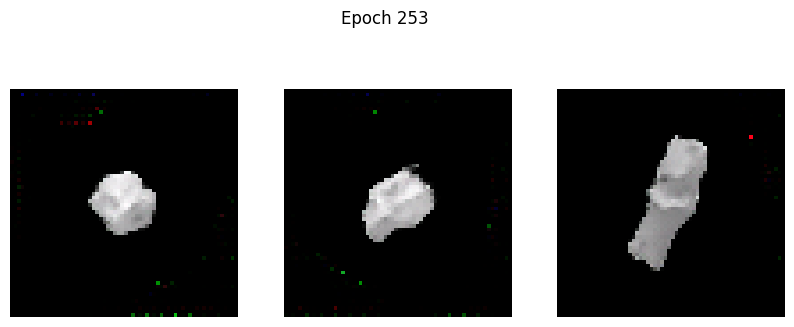

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0913 - g_loss: 3.7868
Epoch 254/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1017 - g_loss: 3.7402

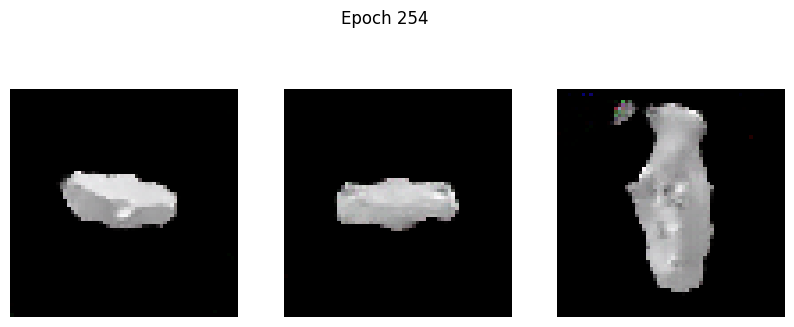

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1017 - g_loss: 3.7400
Epoch 255/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2189 - g_loss: 4.0498

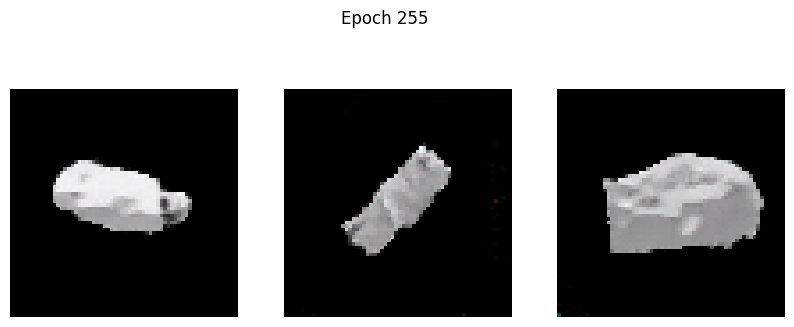

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2183 - g_loss: 4.0478
Epoch 256/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0904 - g_loss: 4.0433

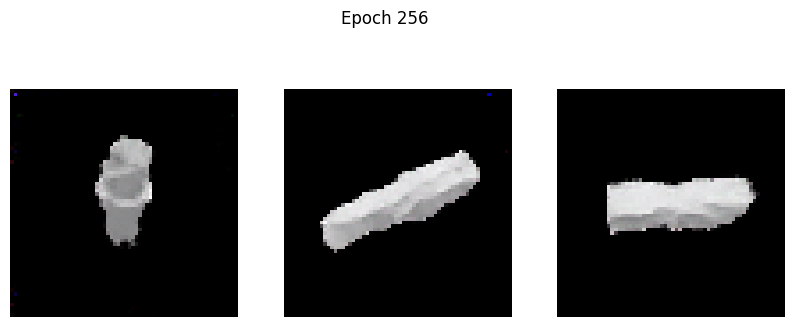

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0903 - g_loss: 4.0418
Epoch 257/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1045 - g_loss: 3.9086

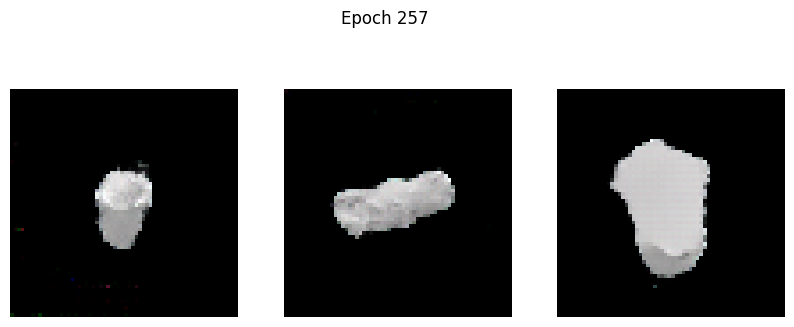

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1049 - g_loss: 3.9088
Epoch 258/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1220 - g_loss: 3.8955

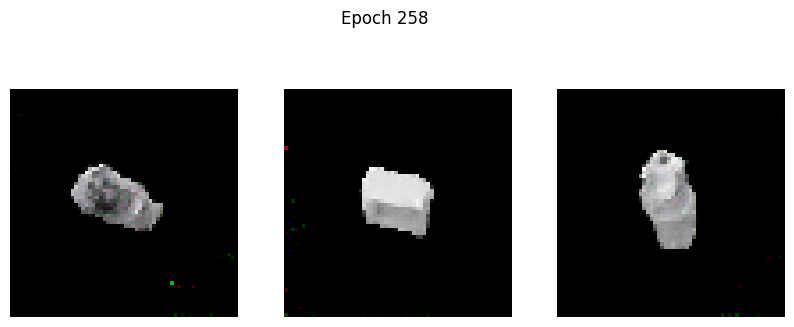

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1218 - g_loss: 3.8950
Epoch 259/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0868 - g_loss: 3.9393

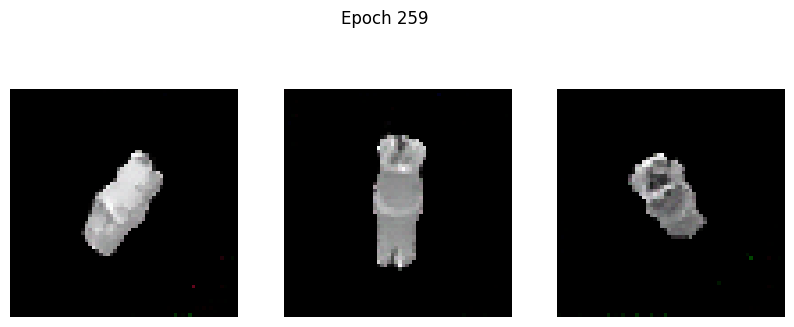

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.0868 - g_loss: 3.9383
Epoch 260/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1726 - g_loss: 4.0705

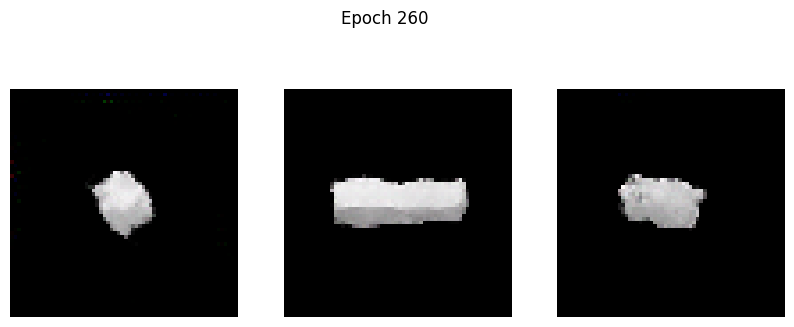

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1735 - g_loss: 4.0708
Epoch 261/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0950 - g_loss: 3.7263

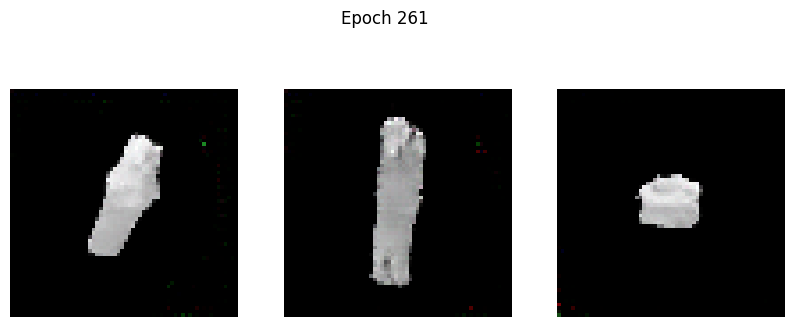

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0949 - g_loss: 3.7265
Epoch 262/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0730 - g_loss: 3.7805

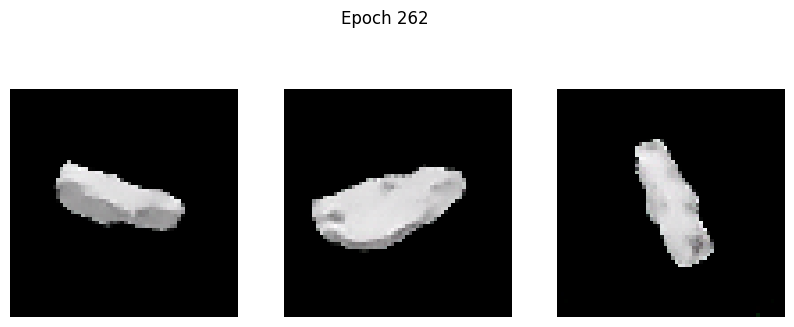

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0730 - g_loss: 3.7805
Epoch 263/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0836 - g_loss: 3.8968

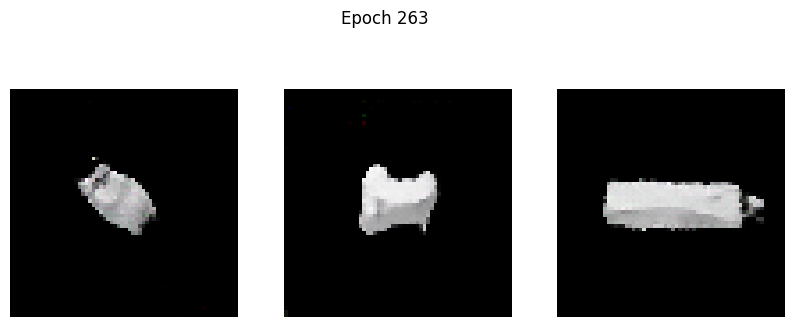

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0836 - g_loss: 3.8975
Epoch 264/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1164 - g_loss: 4.0034

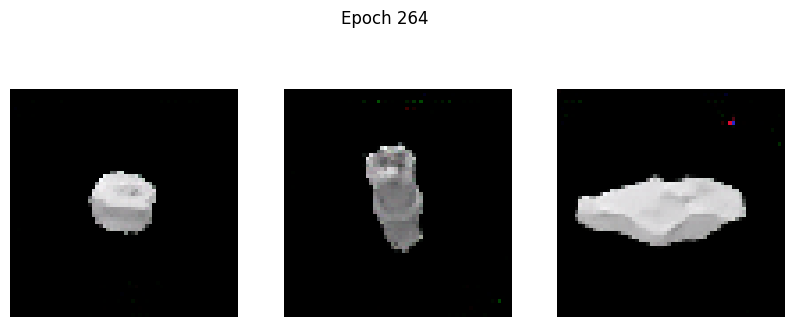

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1162 - g_loss: 4.0027
Epoch 265/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1416 - g_loss: 4.0344

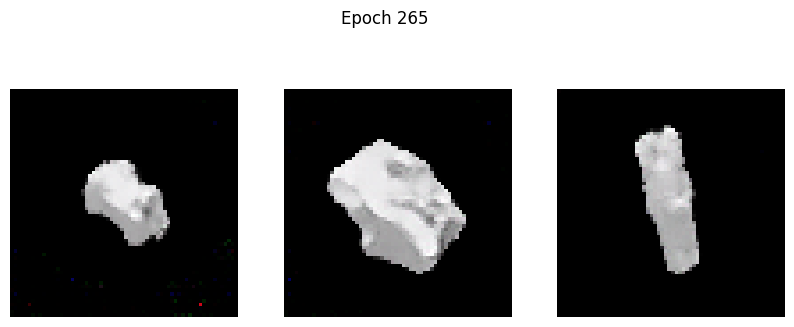

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1415 - g_loss: 4.0338
Epoch 266/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1027 - g_loss: 4.0084

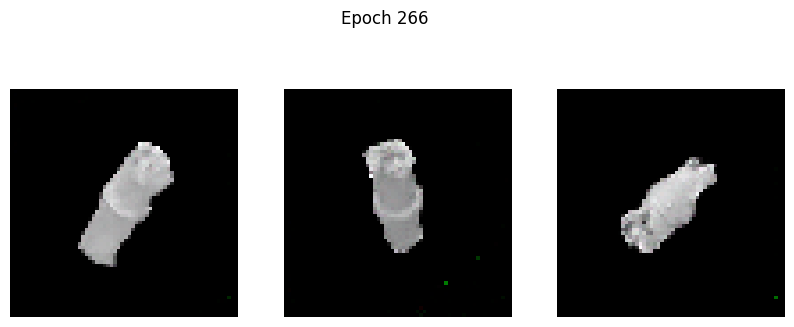

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1026 - g_loss: 4.0081
Epoch 267/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0942 - g_loss: 3.9547

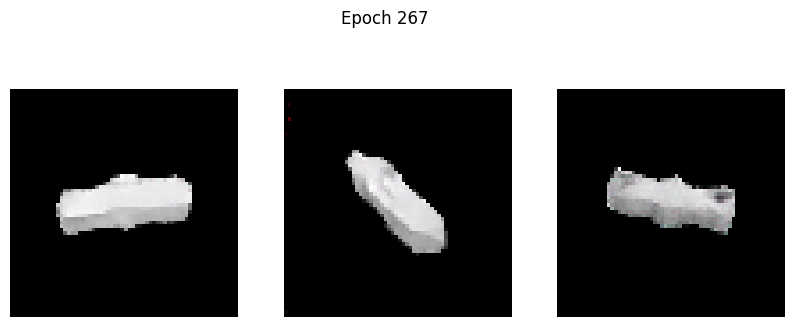

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0942 - g_loss: 3.9544
Epoch 268/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1211 - g_loss: 4.1908

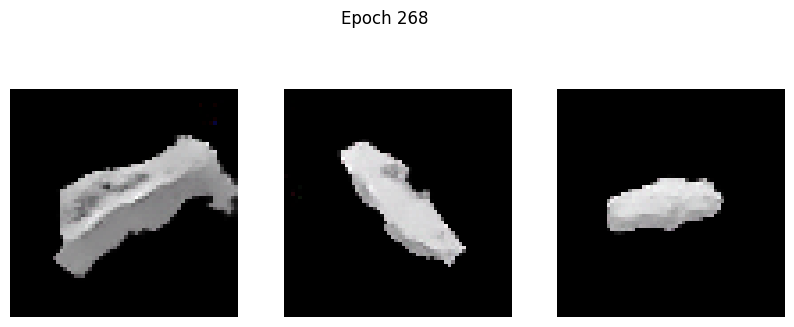

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1208 - g_loss: 4.1890
Epoch 269/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1118 - g_loss: 4.1730

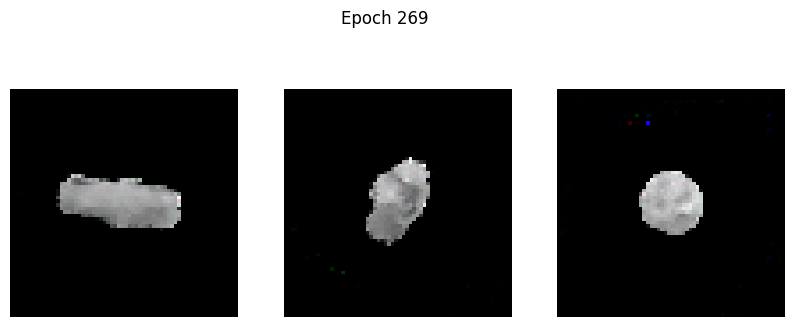

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1126 - g_loss: 4.1738
Epoch 270/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1143 - g_loss: 4.0142

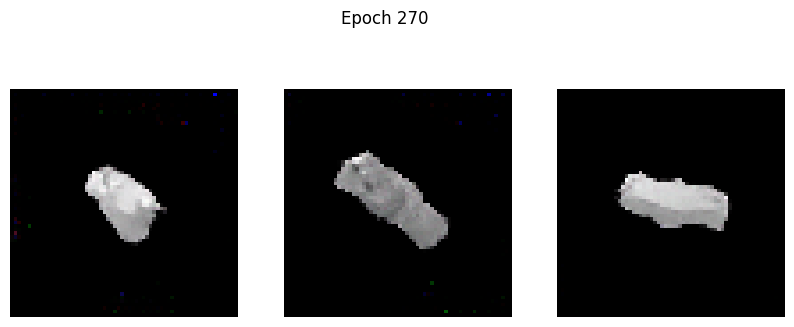

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1142 - g_loss: 4.0141
Epoch 271/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0894 - g_loss: 3.9816

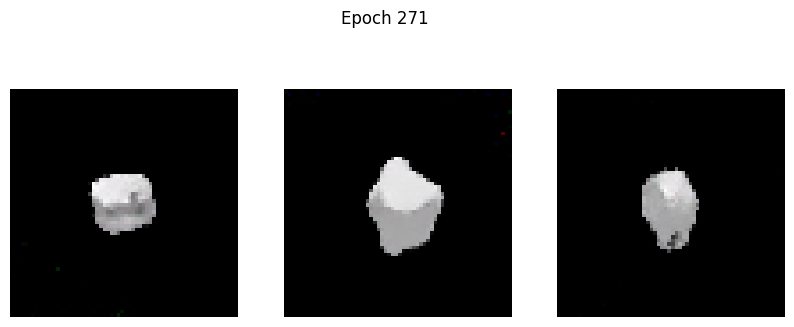

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0895 - g_loss: 3.9816
Epoch 272/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0928 - g_loss: 4.0682

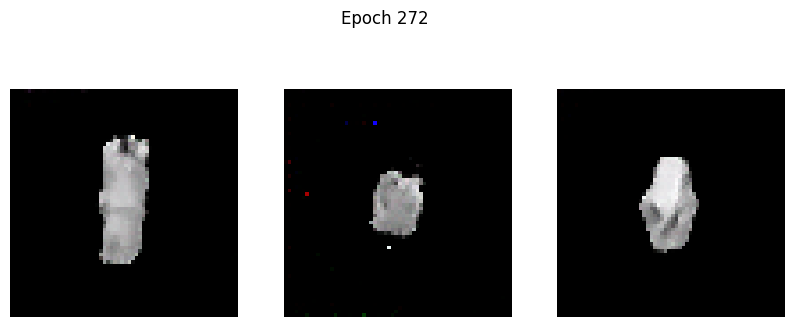

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0928 - g_loss: 4.0680
Epoch 273/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0955 - g_loss: 4.0951

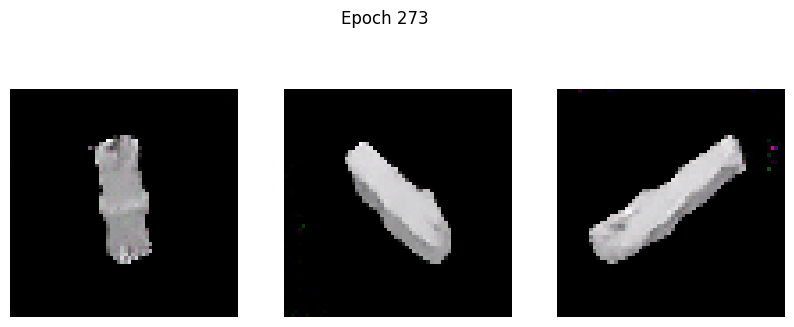

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0954 - g_loss: 4.0944
Epoch 274/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1158 - g_loss: 4.1944

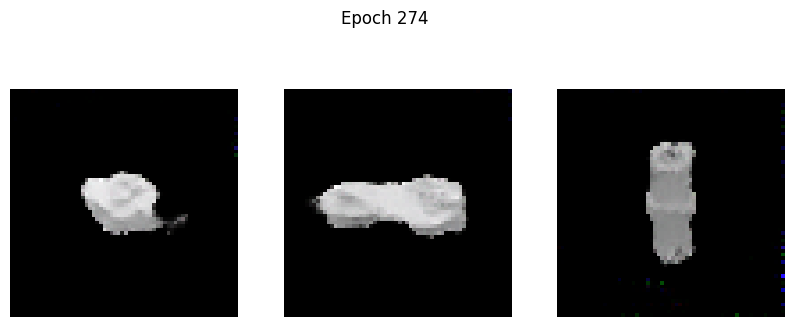

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1162 - g_loss: 4.1944
Epoch 275/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0836 - g_loss: 4.0719

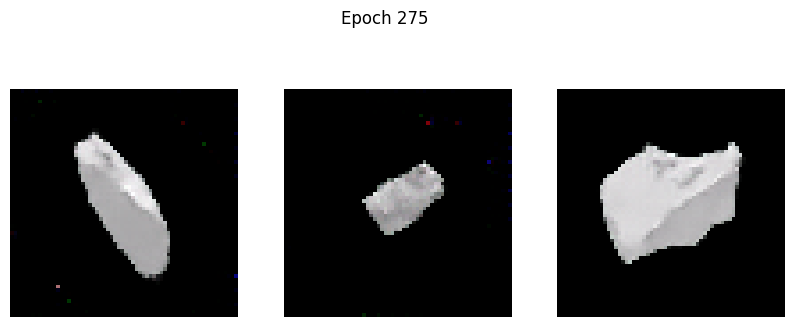

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0838 - g_loss: 4.0714
Epoch 276/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1418 - g_loss: 4.2880

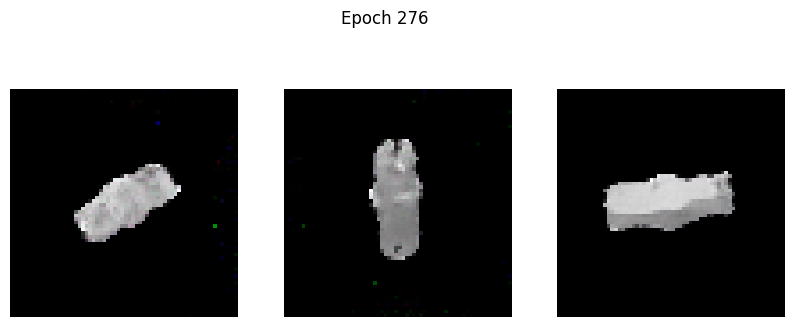

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1414 - g_loss: 4.2864
Epoch 277/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1000 - g_loss: 4.0474

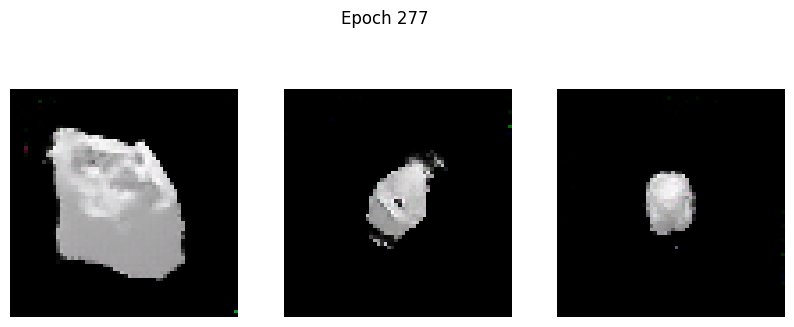

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1000 - g_loss: 4.0474
Epoch 278/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0921 - g_loss: 4.0538

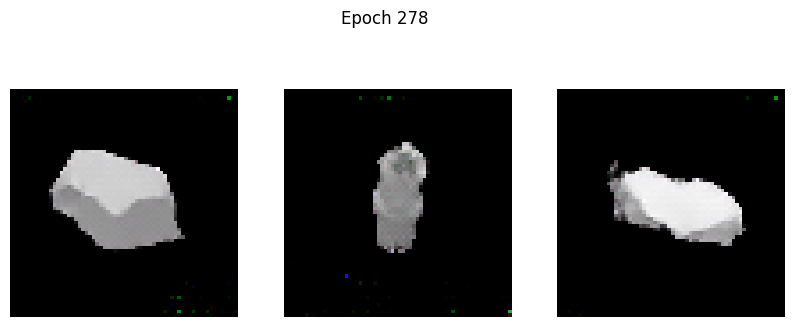

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0922 - g_loss: 4.0536
Epoch 279/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0604 - g_loss: 4.0520

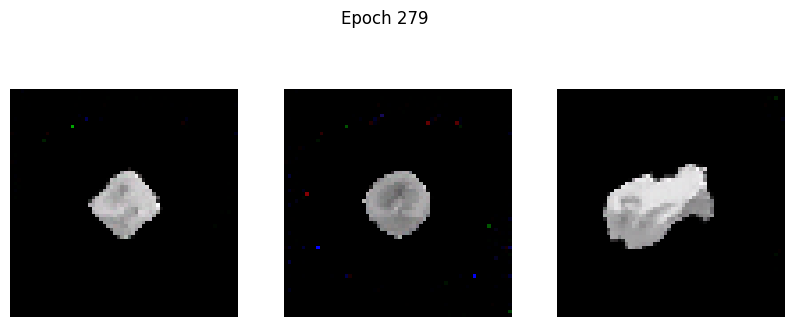

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0605 - g_loss: 4.0520
Epoch 280/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1018 - g_loss: 4.0254

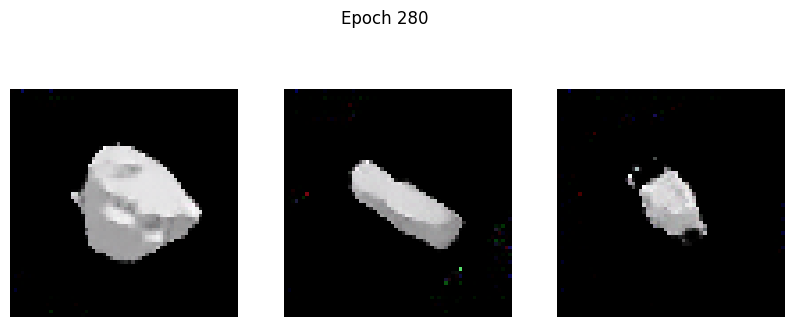

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1017 - g_loss: 4.0261
Epoch 281/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0976 - g_loss: 4.1986

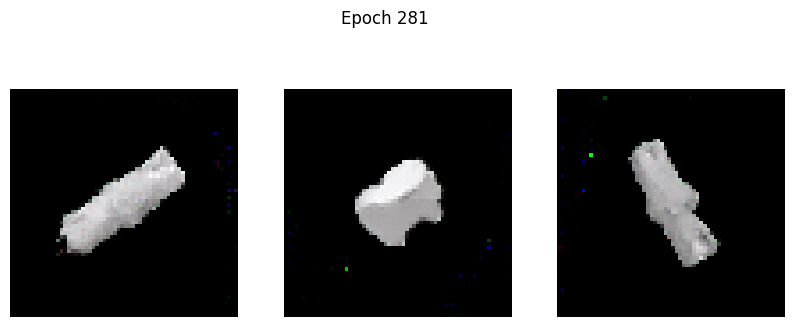

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0983 - g_loss: 4.1992
Epoch 282/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1708 - g_loss: 4.2726

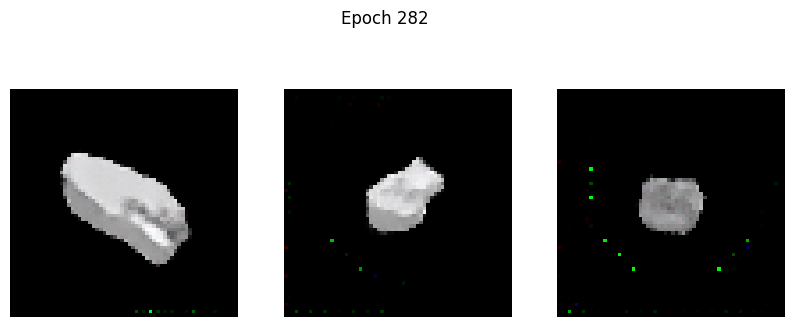

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1706 - g_loss: 4.2722
Epoch 283/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0616 - g_loss: 4.1108

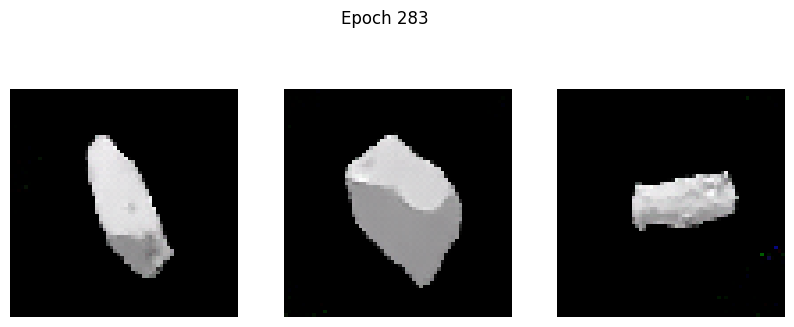

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0616 - g_loss: 4.1097
Epoch 284/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0666 - g_loss: 4.1585

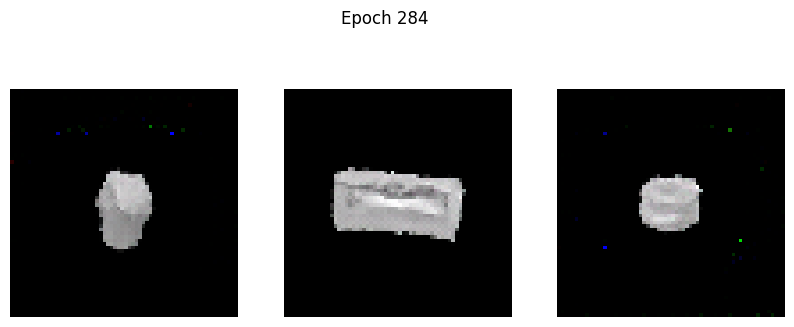

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0666 - g_loss: 4.1590
Epoch 285/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1039 - g_loss: 4.2741

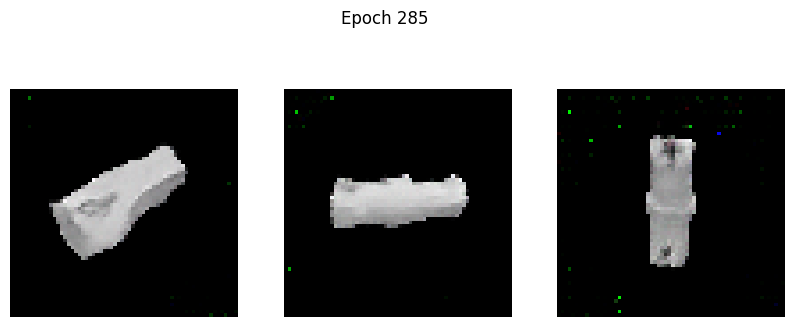

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1039 - g_loss: 4.2734
Epoch 286/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0705 - g_loss: 4.1880

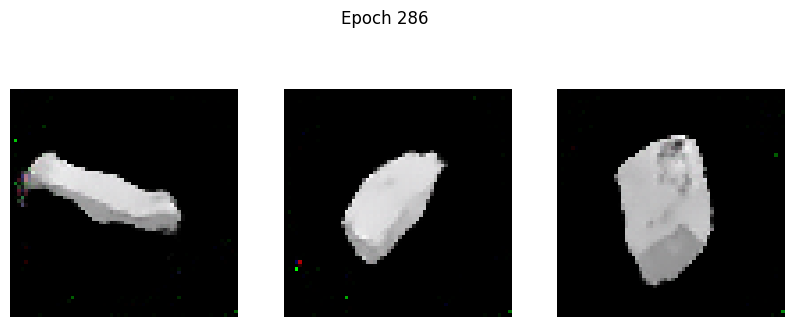

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0706 - g_loss: 4.1877
Epoch 287/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0502 - g_loss: 4.1726

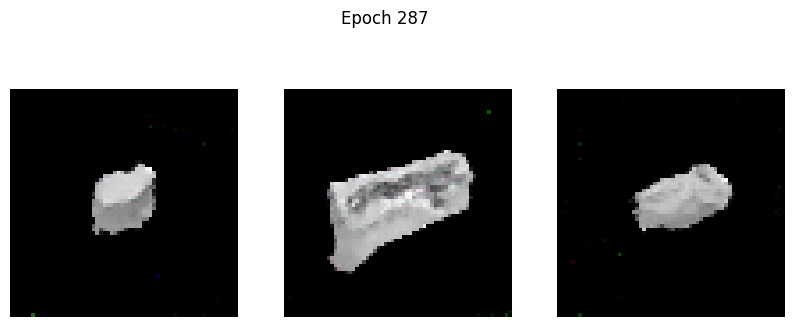

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0507 - g_loss: 4.1734
Epoch 288/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3285 - g_loss: 4.4099

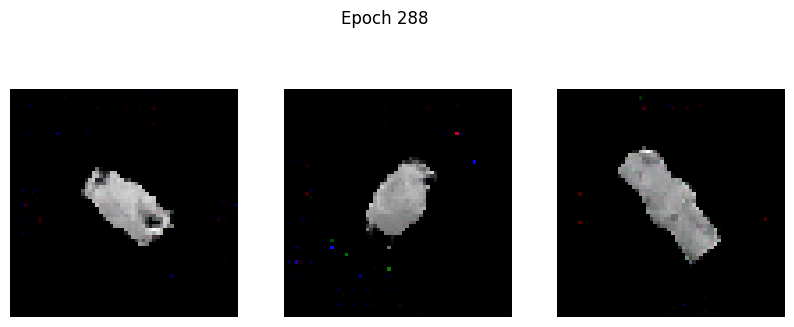

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3270 - g_loss: 4.4083
Epoch 289/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0720 - g_loss: 4.1281

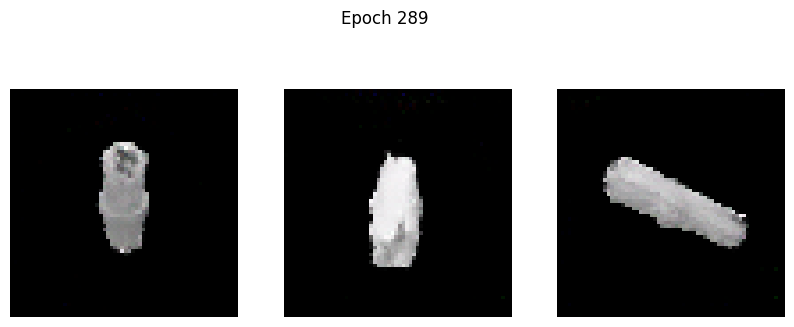

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0719 - g_loss: 4.1278
Epoch 290/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0770 - g_loss: 4.1973

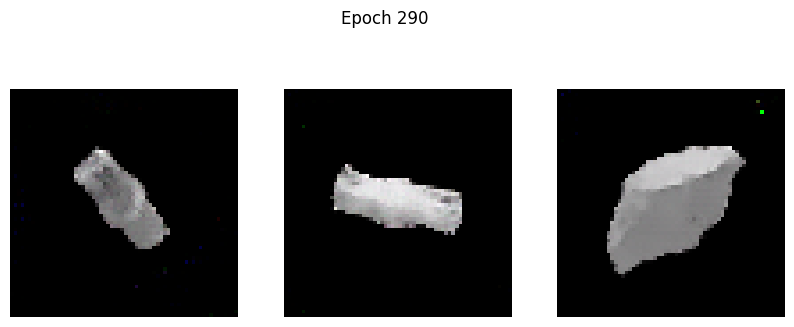

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0774 - g_loss: 4.1976
Epoch 291/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0738 - g_loss: 4.2482

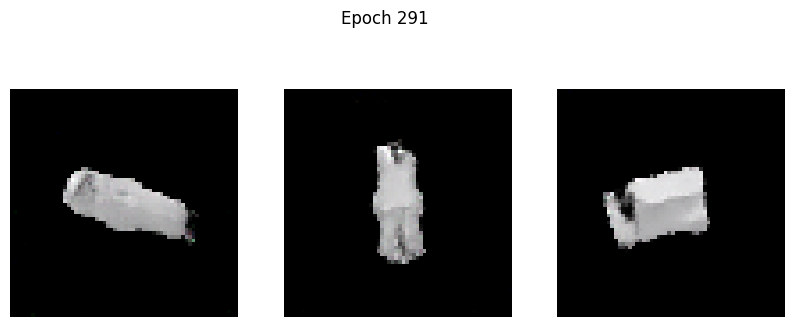

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0739 - g_loss: 4.2472
Epoch 292/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0780 - g_loss: 4.0870

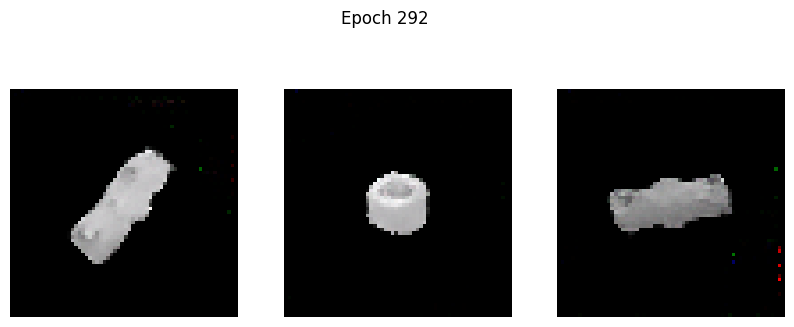

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0780 - g_loss: 4.0877
Epoch 293/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0584 - g_loss: 4.2411

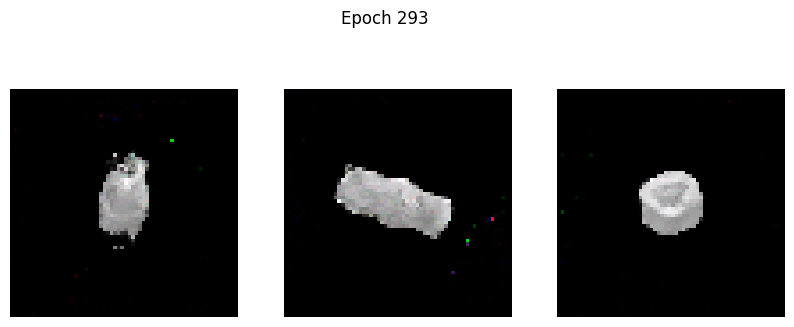

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0586 - g_loss: 4.2410
Epoch 294/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1340 - g_loss: 4.4395

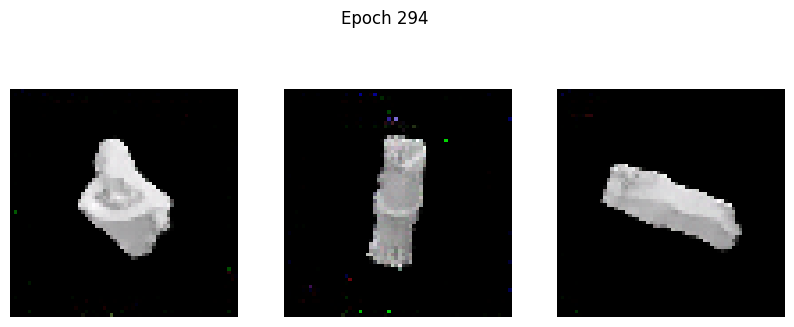

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1337 - g_loss: 4.4381
Epoch 295/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1052 - g_loss: 4.3659

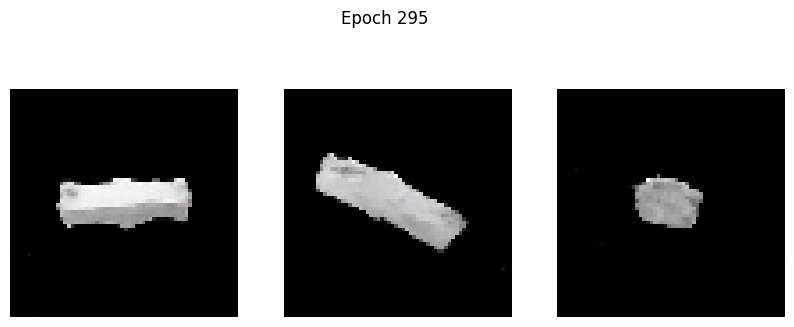

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1051 - g_loss: 4.3650
Epoch 296/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1117 - g_loss: 4.2244

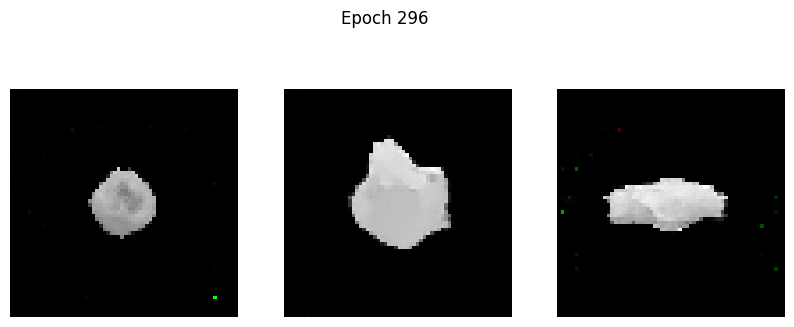

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1125 - g_loss: 4.2267
Epoch 297/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0623 - g_loss: 4.1390

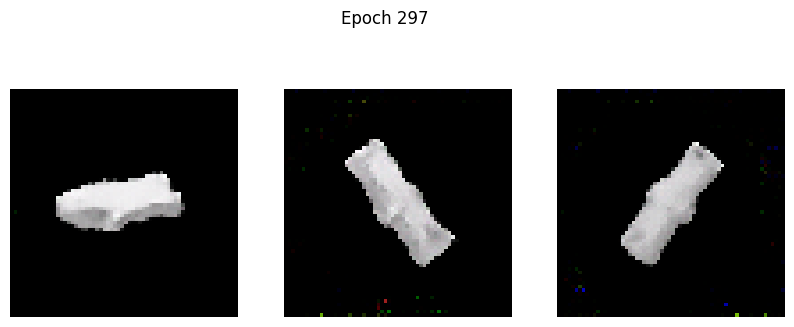

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0624 - g_loss: 4.1389
Epoch 298/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0483 - g_loss: 4.1197

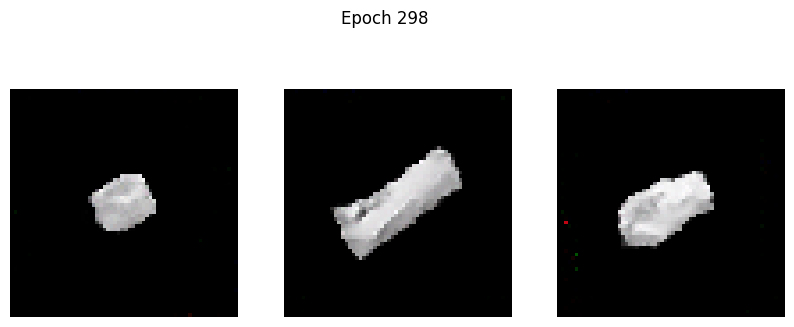

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0483 - g_loss: 4.1198
Epoch 299/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0906 - g_loss: 4.3222

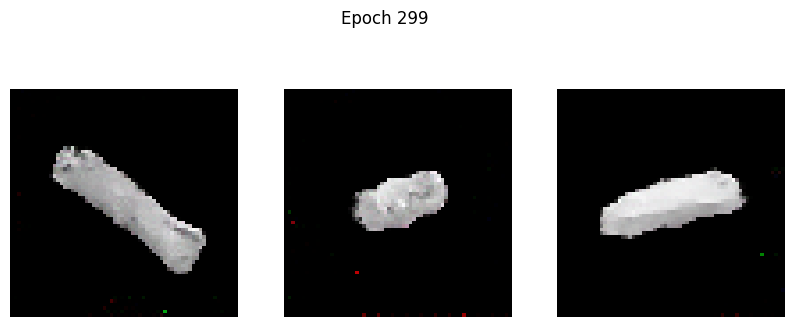

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0904 - g_loss: 4.3214
Epoch 300/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0862 - g_loss: 4.2956

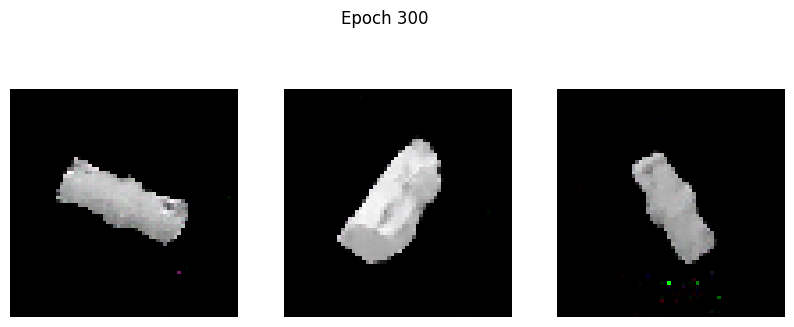

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0860 - g_loss: 4.2950
Epoch 301/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0574 - g_loss: 4.2190

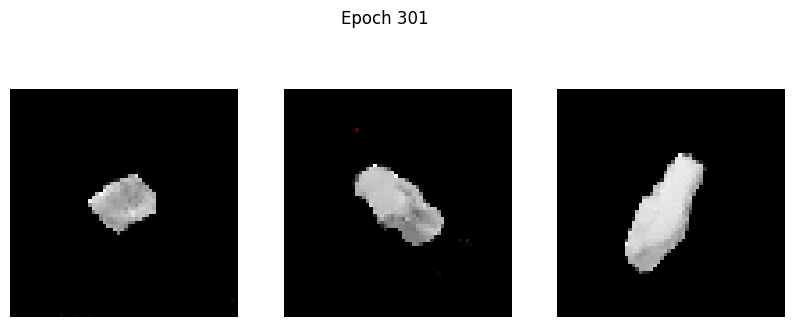

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0574 - g_loss: 4.2199
Epoch 302/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1222 - g_loss: 4.5216

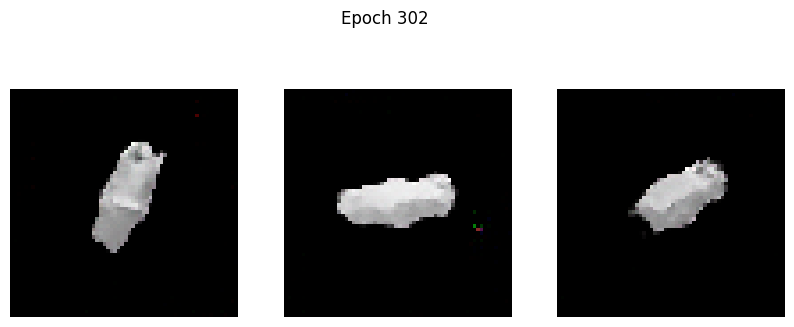

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1218 - g_loss: 4.5201
Epoch 303/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0963 - g_loss: 4.4508

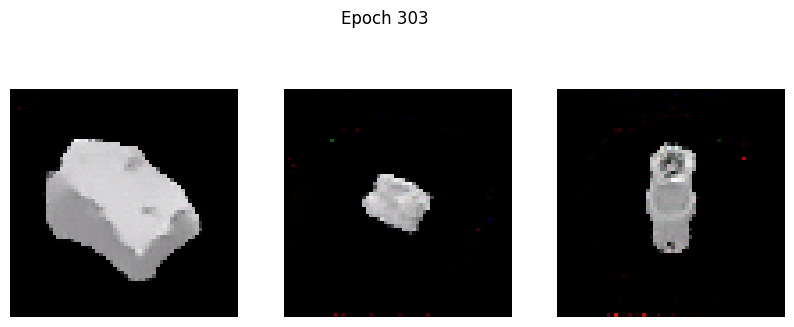

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0961 - g_loss: 4.4503
Epoch 304/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1196 - g_loss: 4.4975

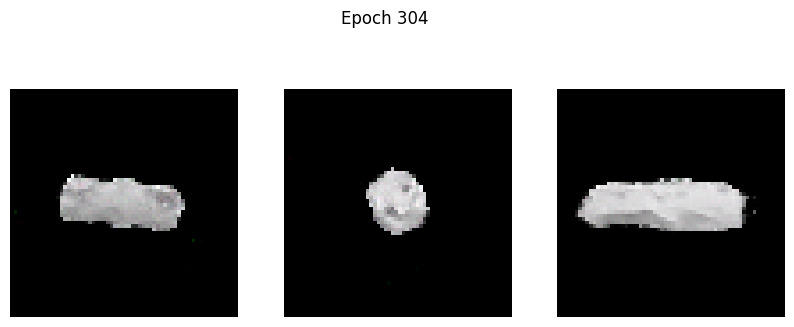

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1206 - g_loss: 4.4988
Epoch 305/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0506 - g_loss: 4.2234

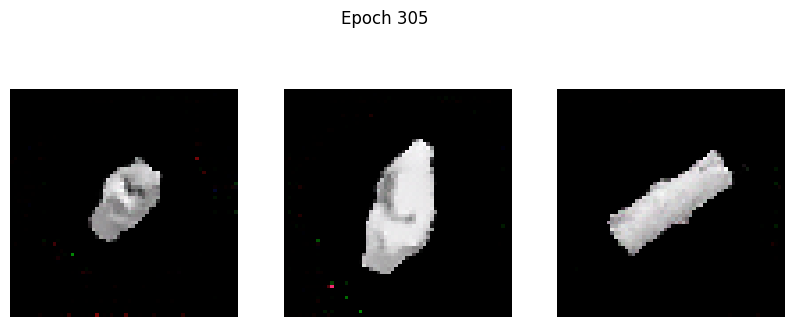

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0506 - g_loss: 4.2230
Epoch 306/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0547 - g_loss: 4.3096

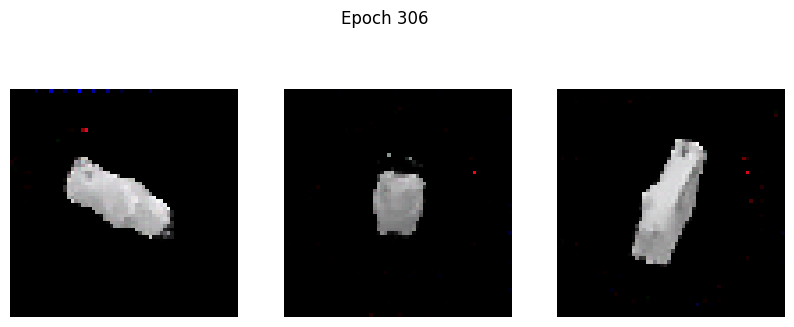

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0546 - g_loss: 4.3090
Epoch 307/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0685 - g_loss: 4.3893

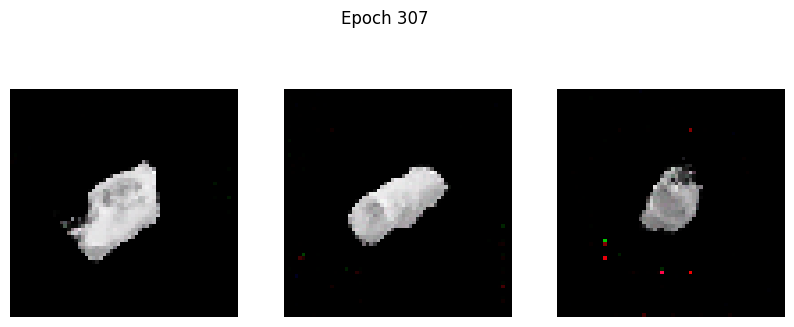

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0684 - g_loss: 4.3887
Epoch 308/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0741 - g_loss: 4.5224

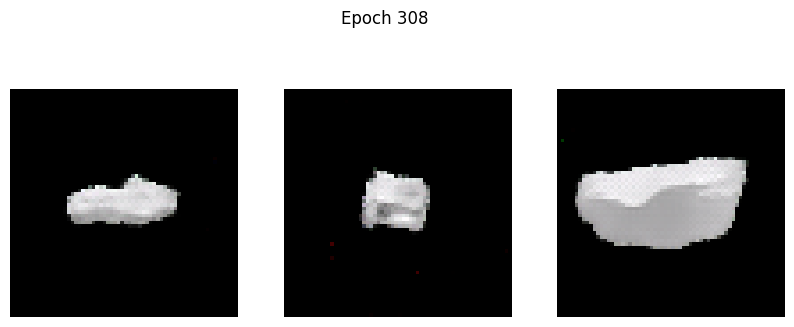

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0746 - g_loss: 4.5226
Epoch 309/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0846 - g_loss: 4.3524

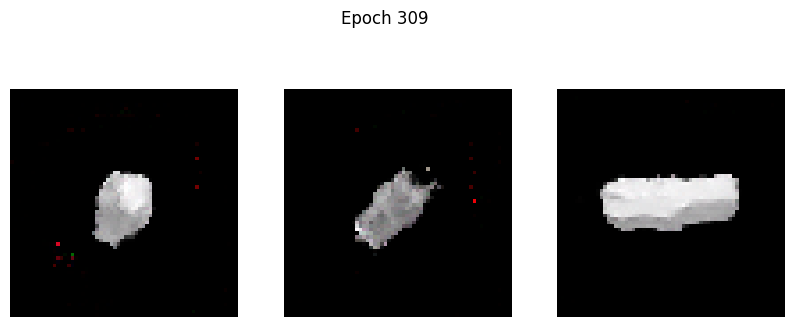

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0845 - g_loss: 4.3523
Epoch 310/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0384 - g_loss: 4.2694

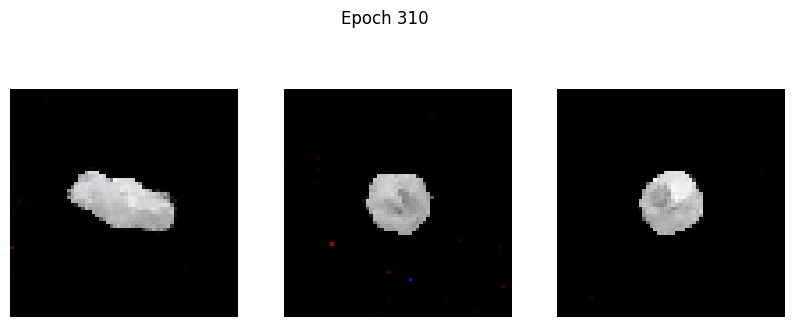

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0386 - g_loss: 4.2701
Epoch 311/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0490 - g_loss: 4.2912

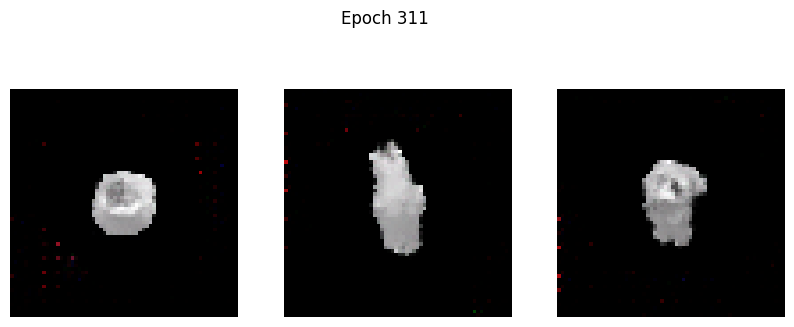

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0491 - g_loss: 4.2923
Epoch 312/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0890 - g_loss: 4.4237

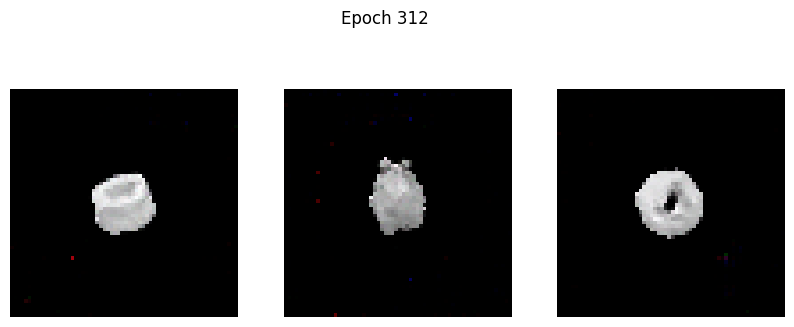

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0889 - g_loss: 4.4238
Epoch 313/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0790 - g_loss: 4.5661

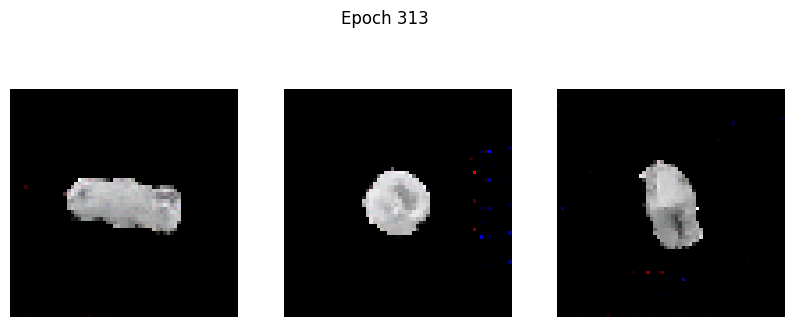

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0792 - g_loss: 4.5662
Epoch 314/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0520 - g_loss: 4.3284

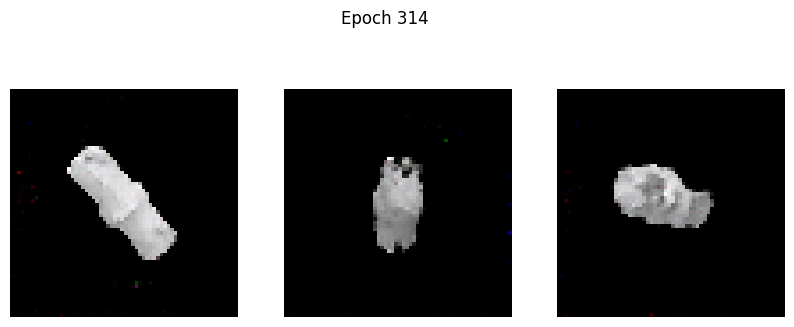

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0520 - g_loss: 4.3286
Epoch 315/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1548 - g_loss: 4.6187

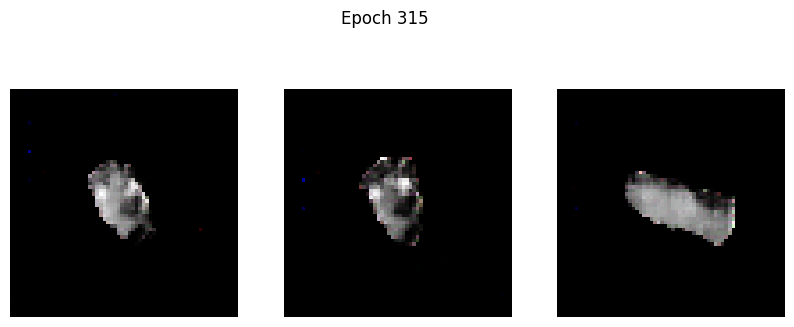

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1575 - g_loss: 4.6242
Epoch 316/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2259 - g_loss: 4.9162

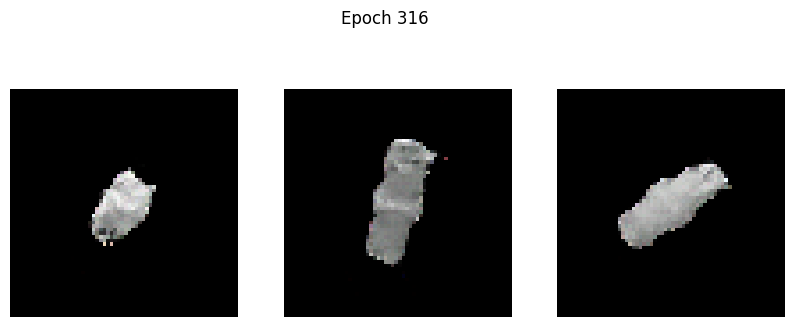

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2260 - g_loss: 4.9142
Epoch 317/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0525 - g_loss: 4.0474

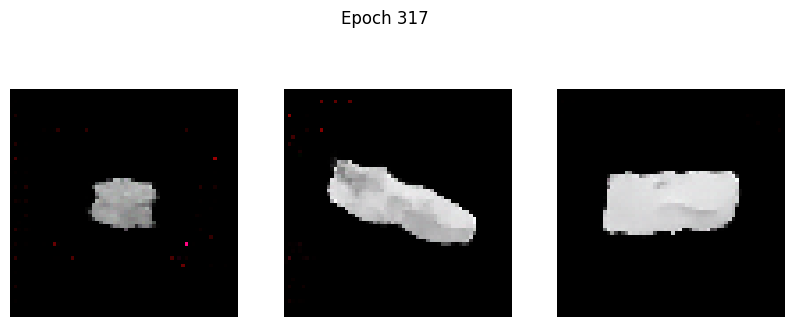

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0524 - g_loss: 4.0476
Epoch 318/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0341 - g_loss: 4.0656

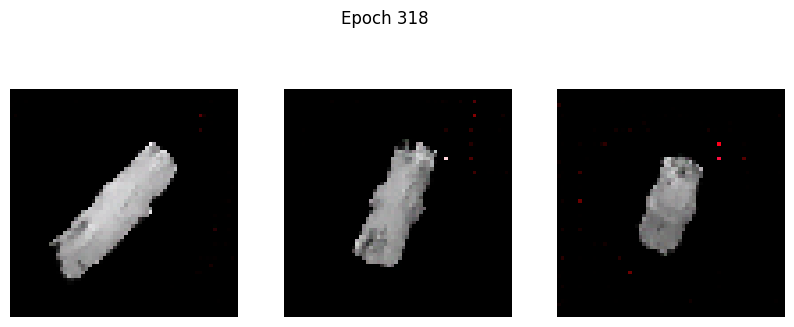

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0341 - g_loss: 4.0658
Epoch 319/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0679 - g_loss: 4.3163

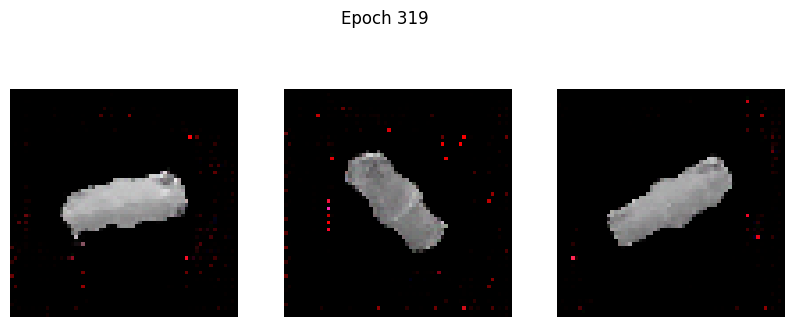

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0679 - g_loss: 4.3165
Epoch 320/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0685 - g_loss: 4.5124

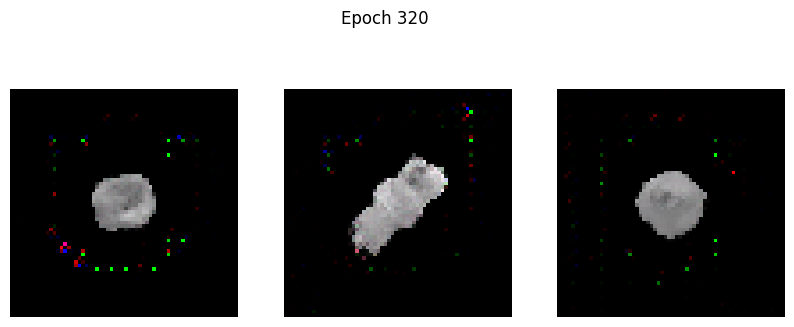

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0685 - g_loss: 4.5113
Epoch 321/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0424 - g_loss: 4.3683

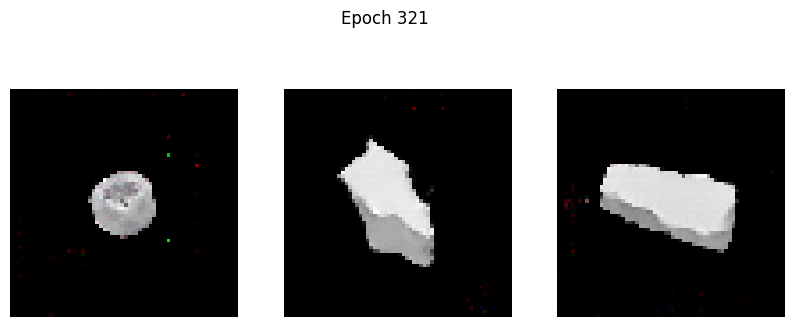

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0426 - g_loss: 4.3691
Epoch 322/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0633 - g_loss: 4.2228

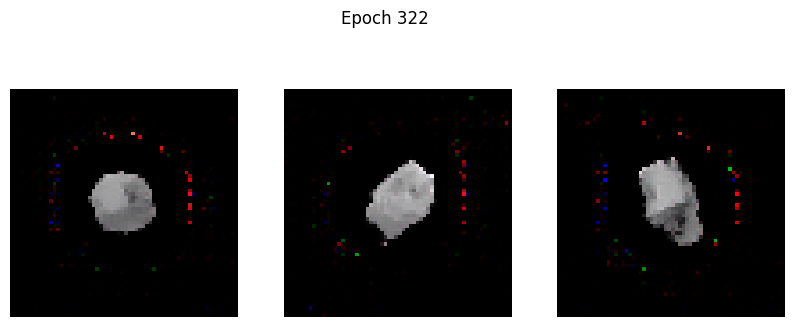

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.0634 - g_loss: 4.2244
Epoch 323/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1181 - g_loss: 4.6401

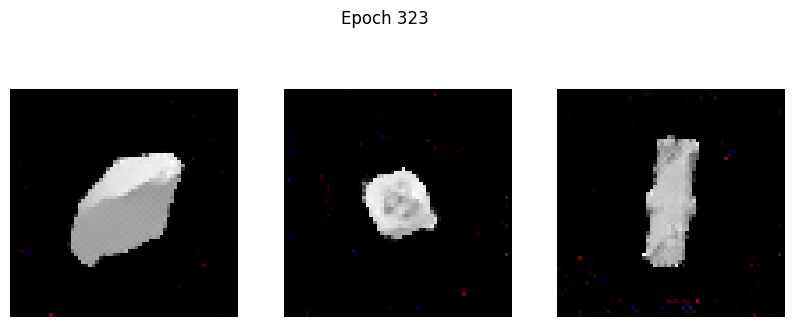

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1177 - g_loss: 4.6387
Epoch 324/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0623 - g_loss: 4.3198

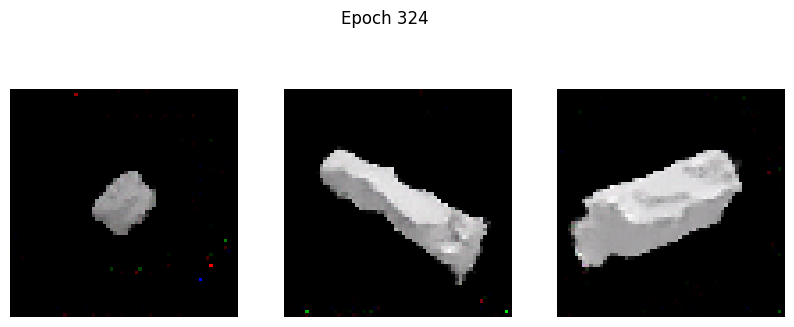

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0623 - g_loss: 4.3204
Epoch 325/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0618 - g_loss: 4.3949

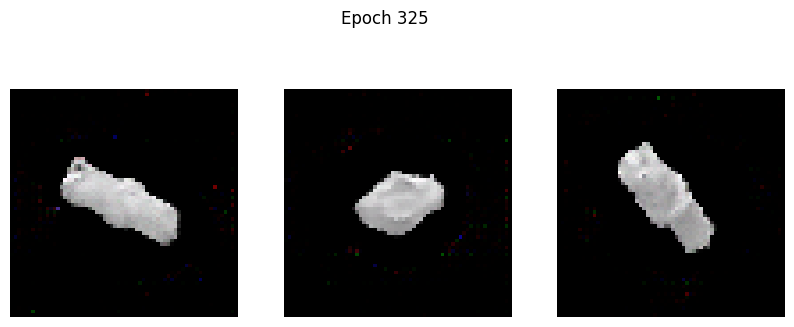

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0618 - g_loss: 4.3950
Epoch 326/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3125 - g_loss: 6.0364

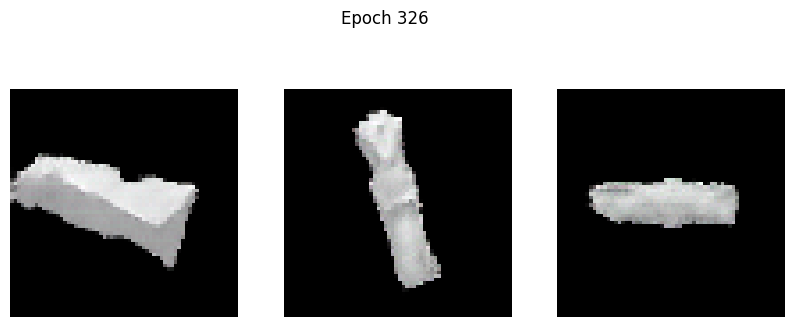

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3117 - g_loss: 6.0344
Epoch 327/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0380 - g_loss: 4.6838

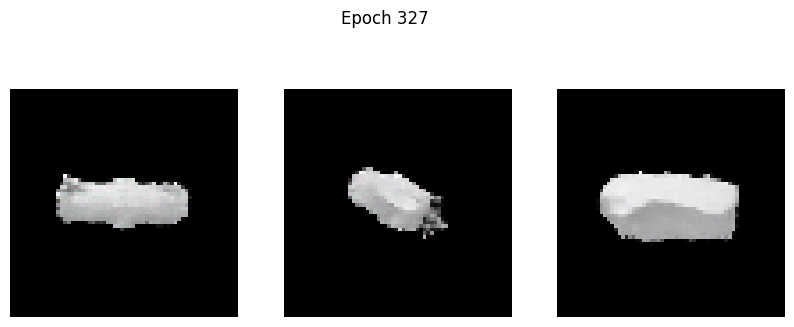

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0379 - g_loss: 4.6819
Epoch 328/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0164 - g_loss: 4.3296

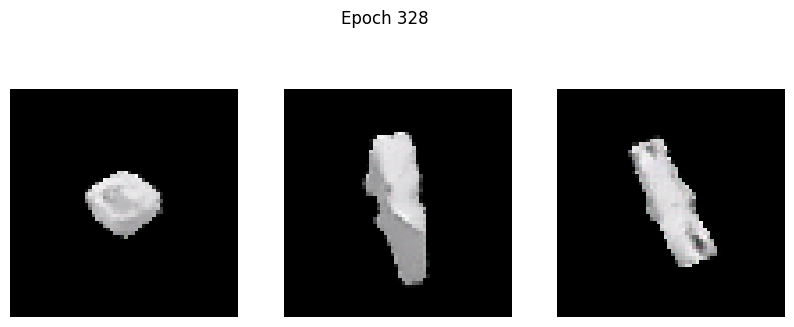

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0164 - g_loss: 4.3300
Epoch 329/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0526 - g_loss: 4.4823

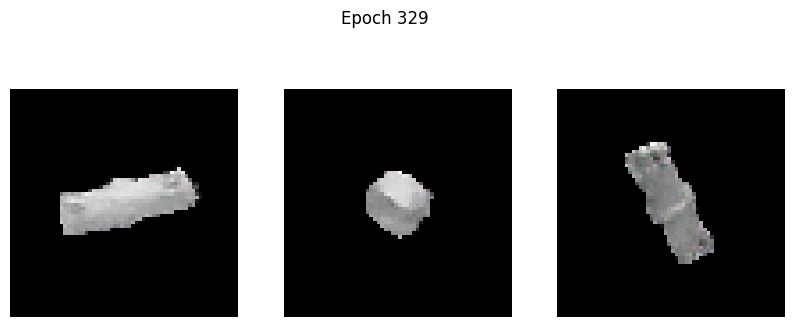

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0527 - g_loss: 4.4833
Epoch 330/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0711 - g_loss: 4.5976

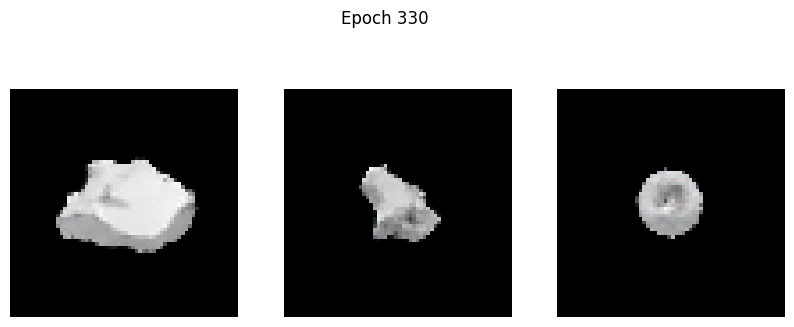

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0711 - g_loss: 4.5975
Epoch 331/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0340 - g_loss: 4.3274

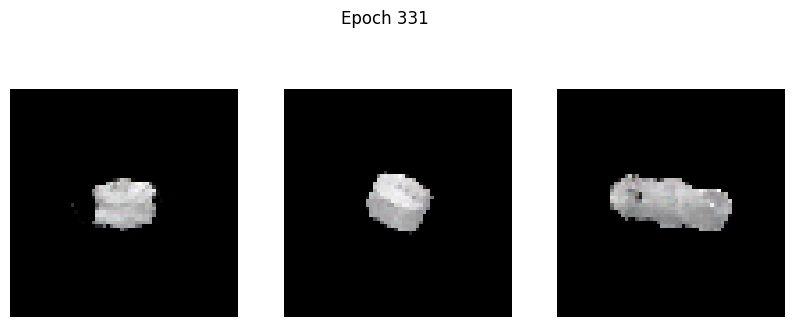

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0340 - g_loss: 4.3280
Epoch 332/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0351 - g_loss: 4.5385

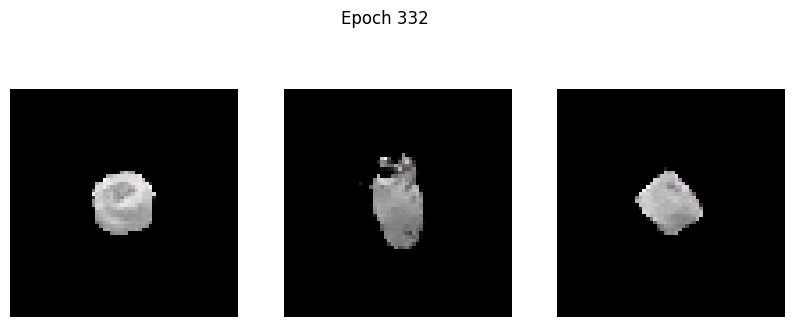

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0353 - g_loss: 4.5383
Epoch 333/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0385 - g_loss: 4.5044

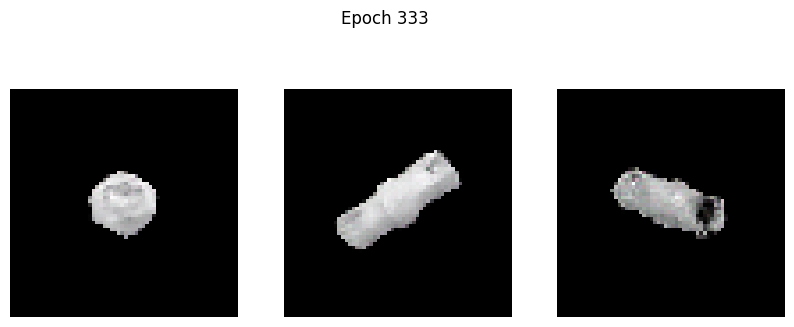

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0386 - g_loss: 4.5050
Epoch 334/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0340 - g_loss: 4.5674

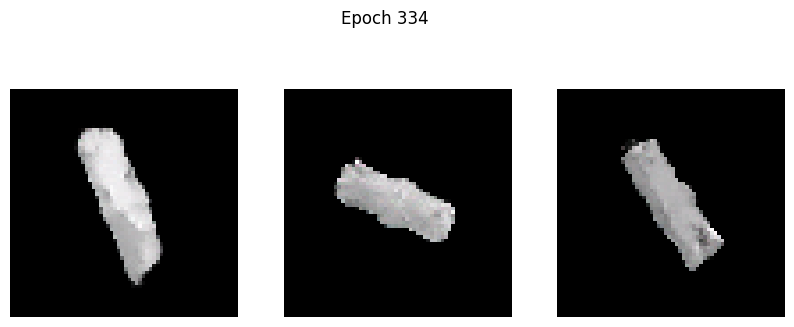

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0340 - g_loss: 4.5675
Epoch 335/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0284 - g_loss: 4.5826

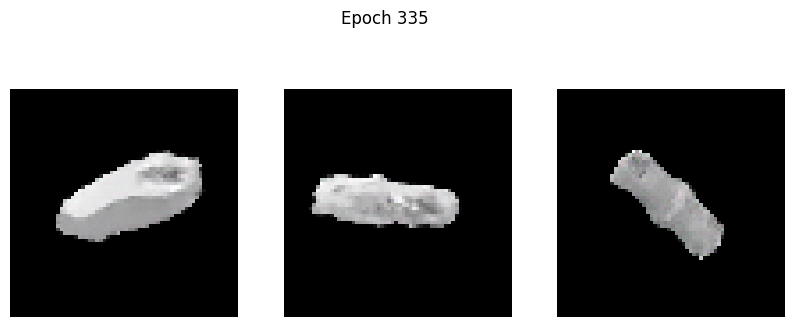

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0285 - g_loss: 4.5835
Epoch 336/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0426 - g_loss: 4.6228

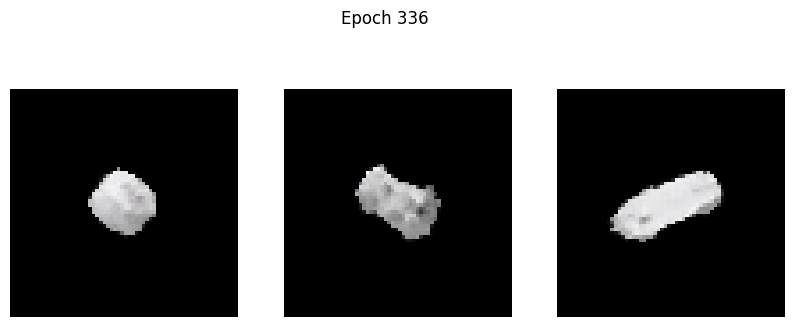

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0426 - g_loss: 4.6222
Epoch 337/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0835 - g_loss: 4.6060

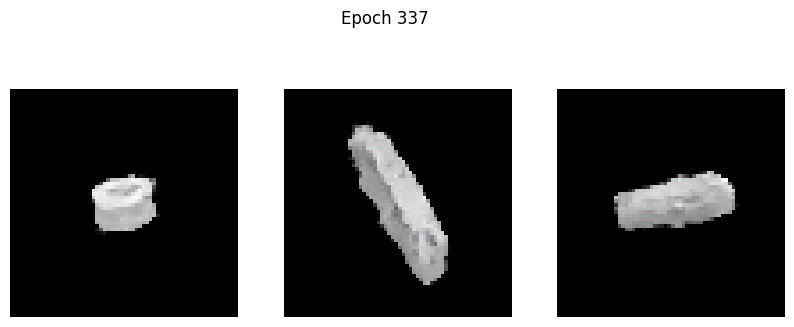

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0842 - g_loss: 4.6084
Epoch 338/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0416 - g_loss: 4.4498

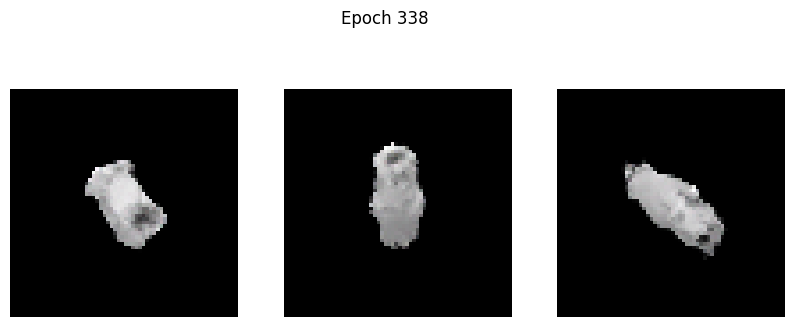

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0417 - g_loss: 4.4501
Epoch 339/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0335 - g_loss: 4.3840

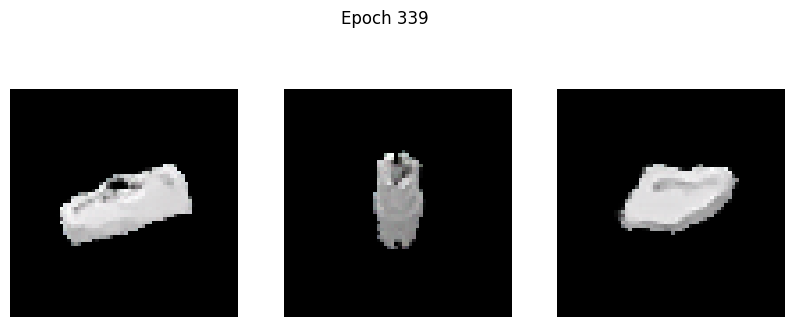

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0336 - g_loss: 4.3845
Epoch 340/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3578 - g_loss: 5.0650

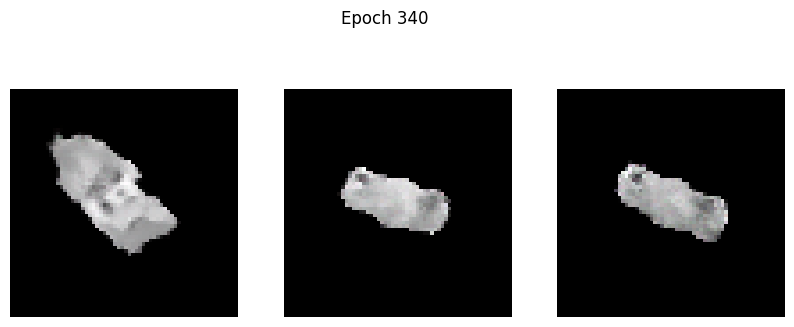

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3562 - g_loss: 5.0614
Epoch 341/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0195 - g_loss: 4.3983

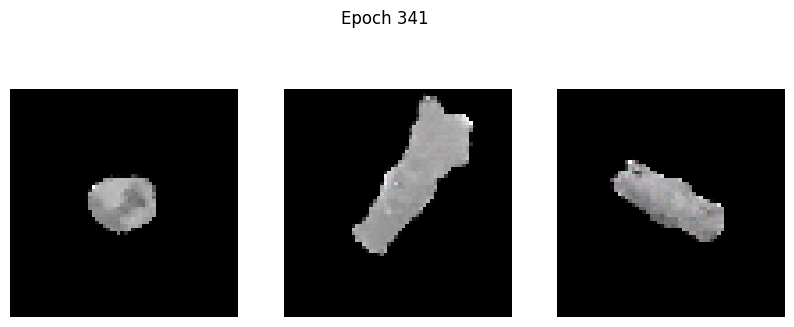

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0197 - g_loss: 4.3989
Epoch 342/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0312 - g_loss: 4.4763

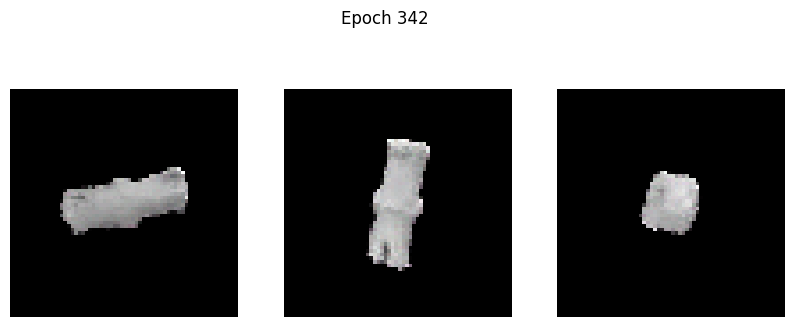

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0313 - g_loss: 4.4768
Epoch 343/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0044 - g_loss: 4.4840

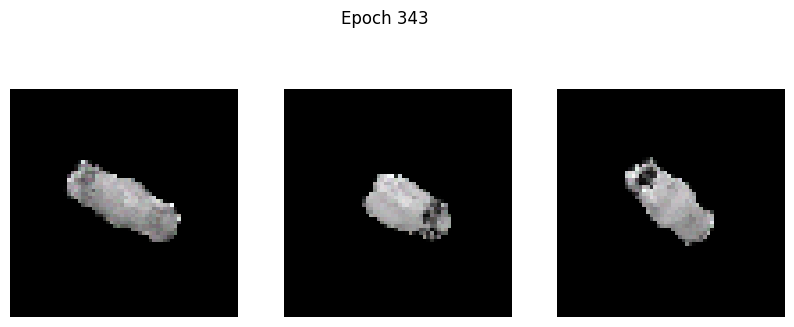

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0046 - g_loss: 4.4833
Epoch 344/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0601 - g_loss: 4.7630

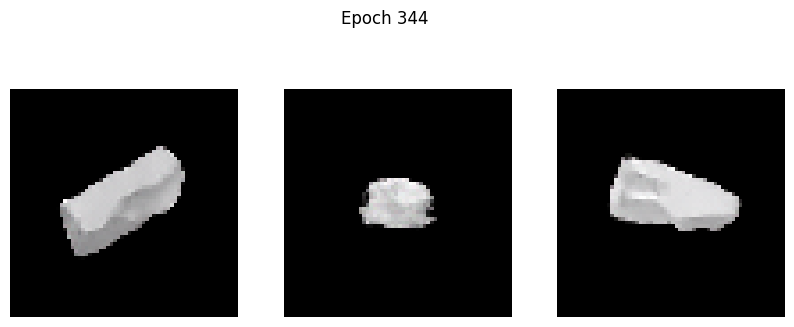

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0600 - g_loss: 4.7627
Epoch 345/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0227 - g_loss: 4.6924

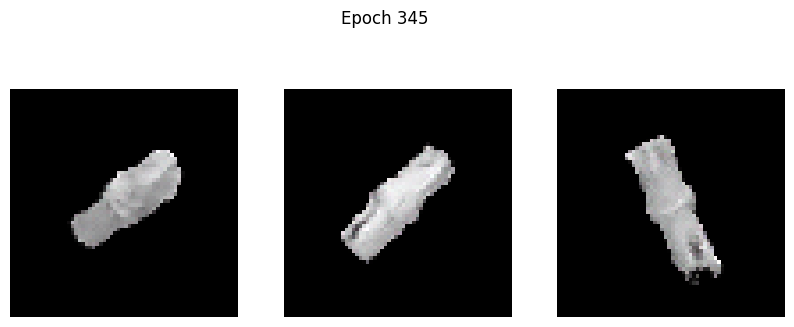

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0227 - g_loss: 4.6920
Epoch 346/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0624 - g_loss: 4.6786

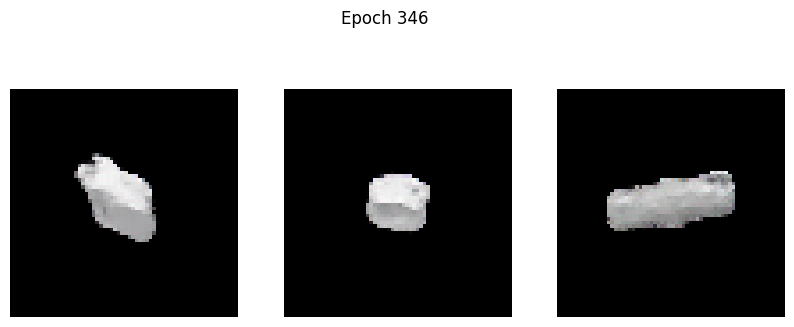

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0635 - g_loss: 4.6818
Epoch 347/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0963 - g_loss: 4.6728

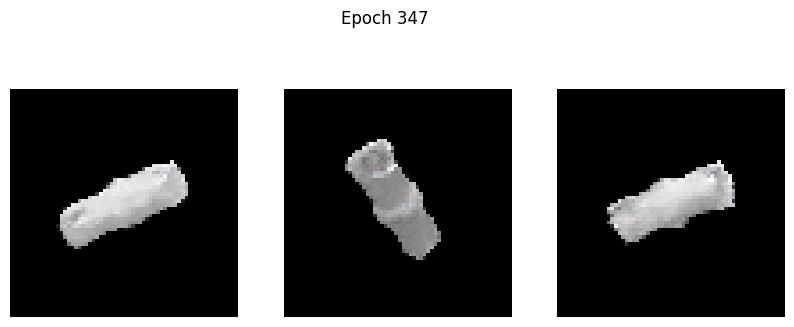

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0959 - g_loss: 4.6720
Epoch 348/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0656 - g_loss: 4.9871

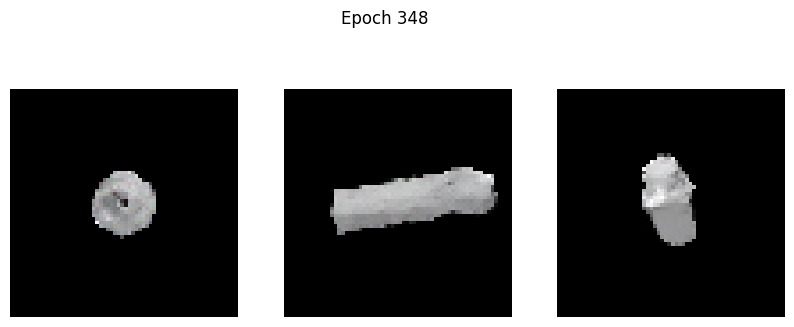

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0653 - g_loss: 4.9846
Epoch 349/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0401 - g_loss: 4.6609

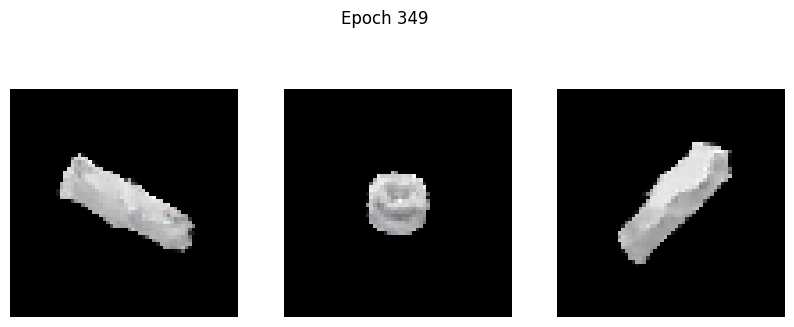

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0401 - g_loss: 4.6600
Epoch 350/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1053 - g_loss: 4.8202

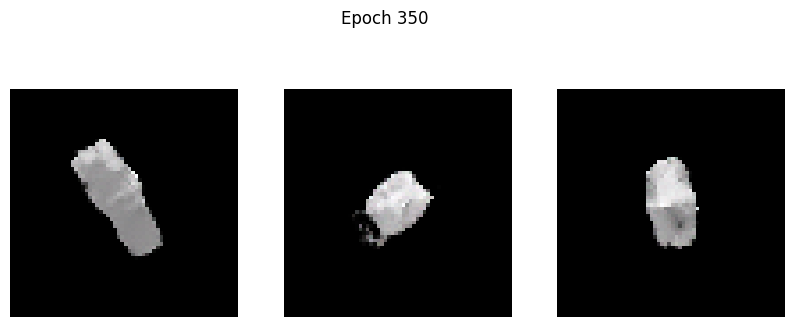

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1056 - g_loss: 4.8202
Epoch 351/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0189 - g_loss: 4.6677

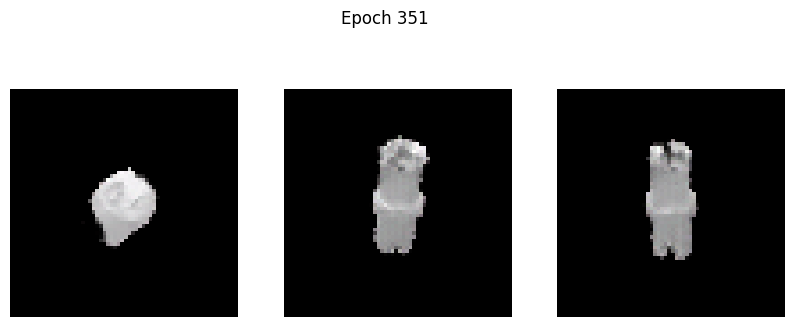

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0190 - g_loss: 4.6679
Epoch 352/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0134 - g_loss: 4.6937

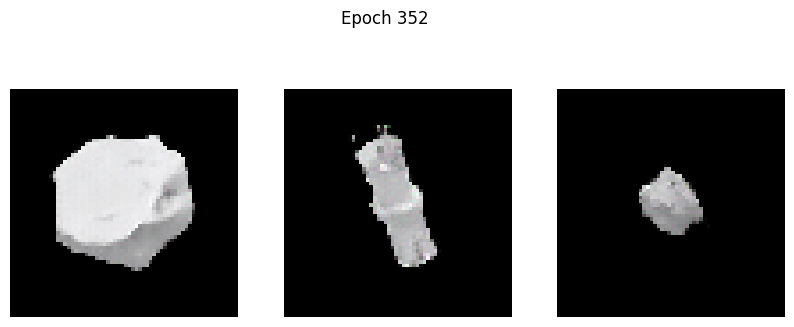

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0137 - g_loss: 4.6942
Epoch 353/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0368 - g_loss: 4.8279

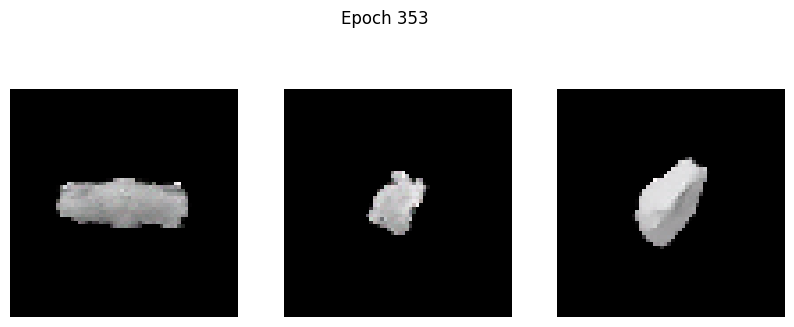

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0370 - g_loss: 4.8282
Epoch 354/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0588 - g_loss: 4.7968

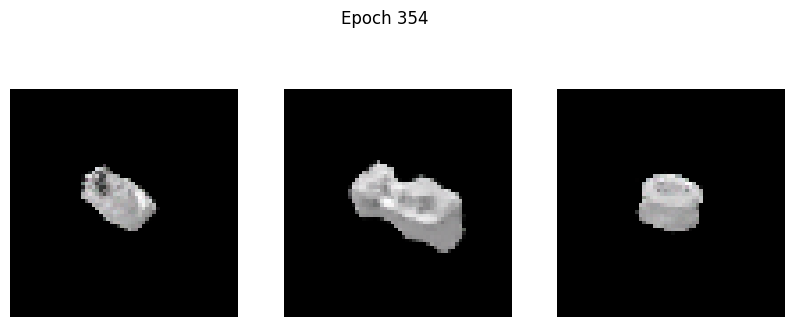

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0587 - g_loss: 4.7962
Epoch 355/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0190 - g_loss: 4.6960

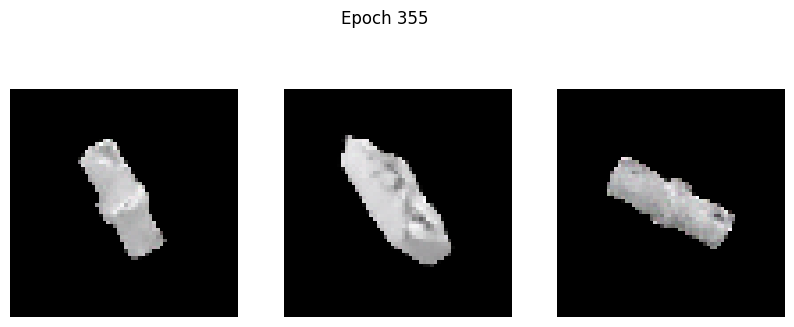

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0192 - g_loss: 4.6965
Epoch 356/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0253 - g_loss: 4.7215

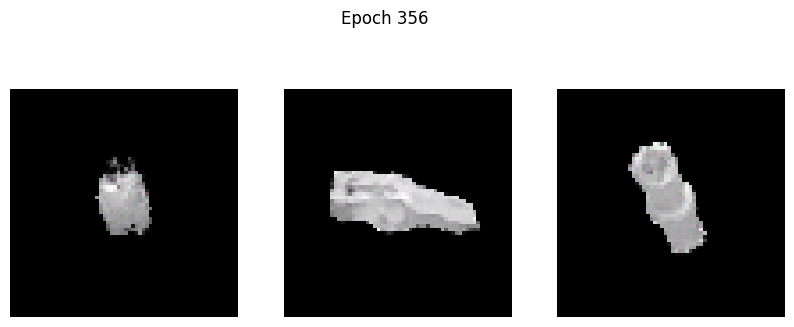

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0253 - g_loss: 4.7221
Epoch 357/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0321 - g_loss: 4.8762

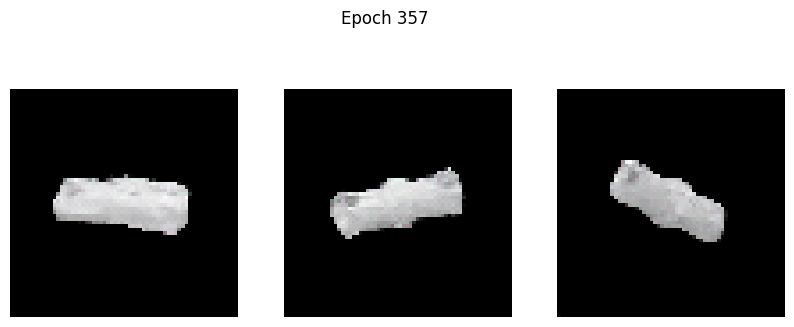

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0323 - g_loss: 4.8768
Epoch 358/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0648 - g_loss: 4.8958

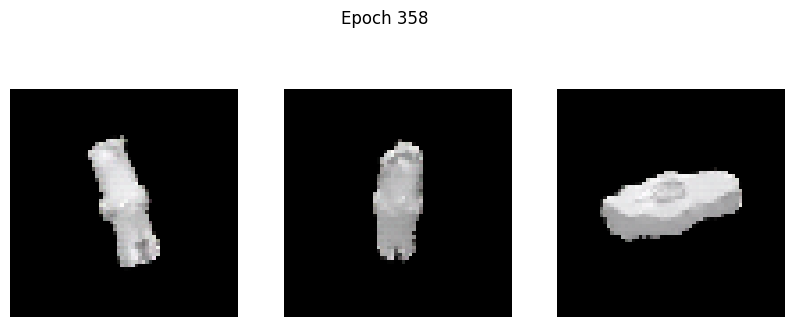

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0647 - g_loss: 4.8960
Epoch 359/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1936 - g_loss: 5.1637

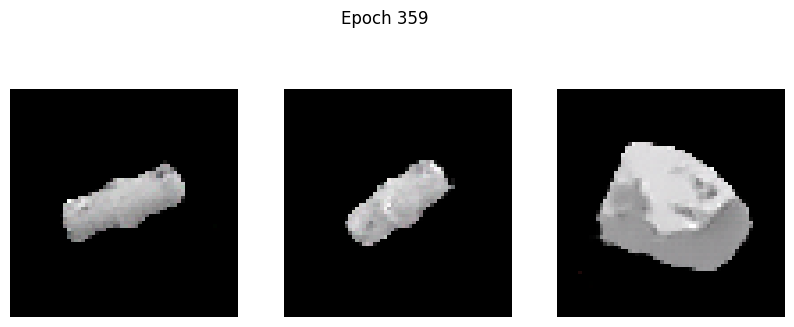

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1925 - g_loss: 5.1617
Epoch 360/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0063 - g_loss: 4.7828

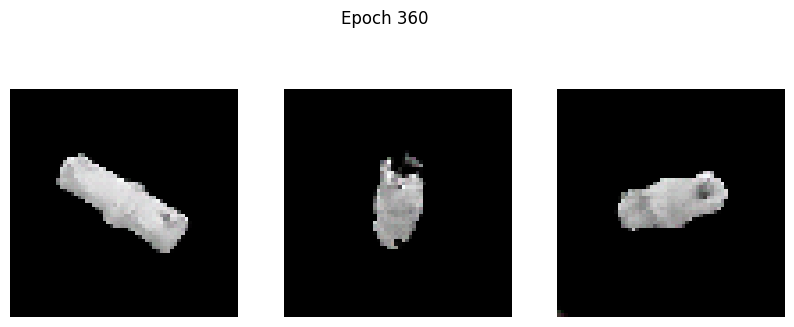

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0064 - g_loss: 4.7831
Epoch 361/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0191 - g_loss: 5.0166

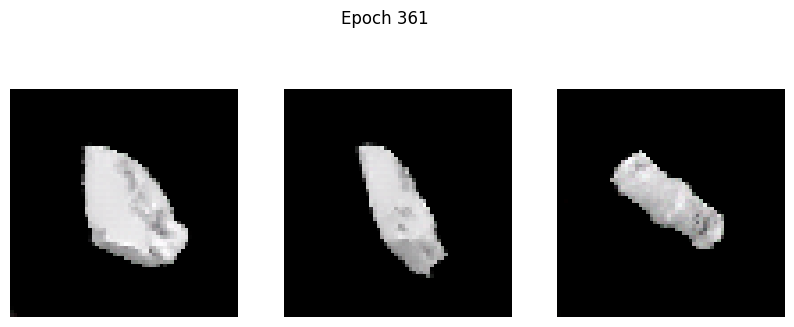

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0197 - g_loss: 5.0182
Epoch 362/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3393 - g_loss: 5.5264

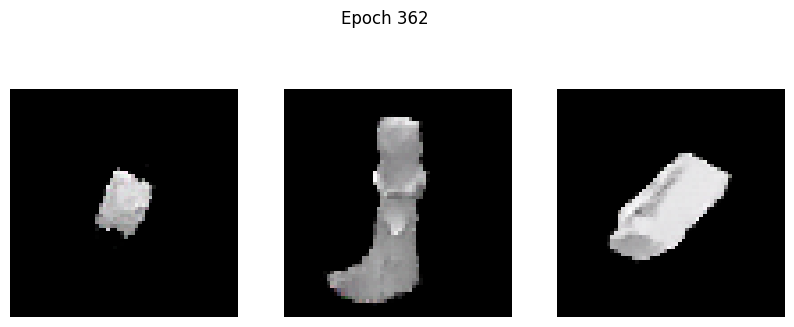

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3373 - g_loss: 5.5206
Epoch 363/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0231 - g_loss: 4.7577

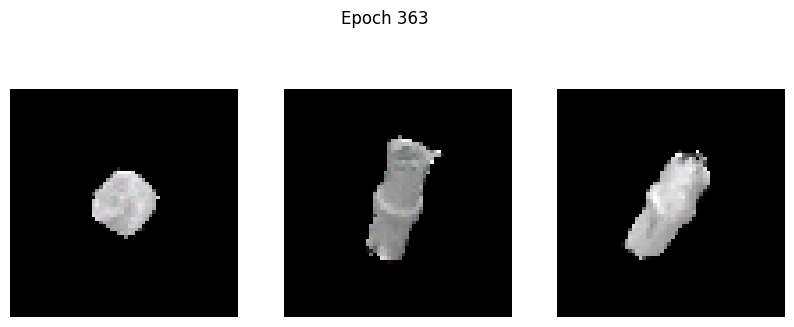

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0232 - g_loss: 4.7590
Epoch 364/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0044 - g_loss: 4.8454

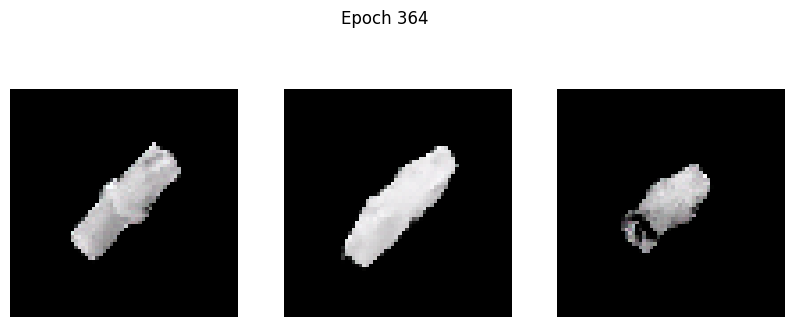

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0045 - g_loss: 4.8452
Epoch 365/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1488 - g_loss: 5.3685

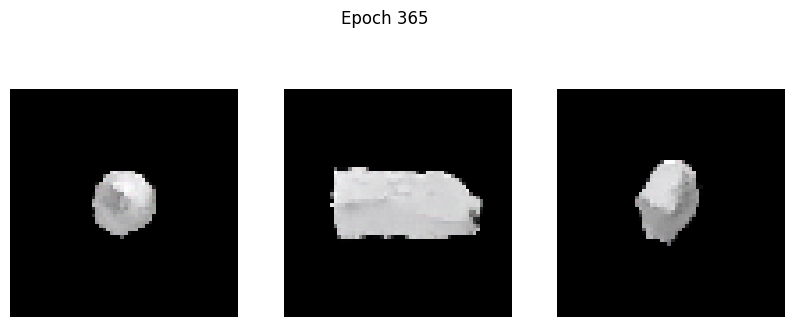

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1488 - g_loss: 5.3660
Epoch 366/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0118 - g_loss: 4.7827

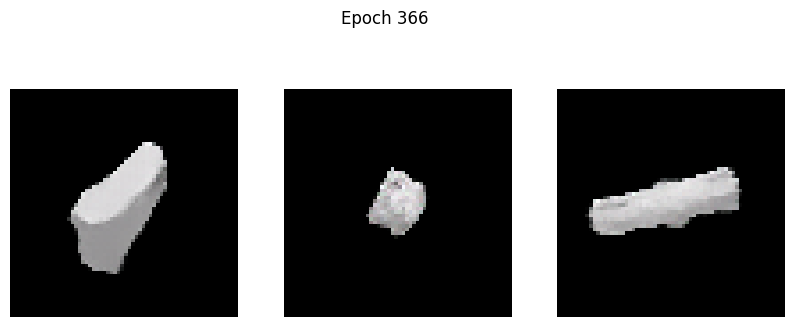

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0121 - g_loss: 4.7840
Epoch 367/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0942 - g_loss: 5.1196

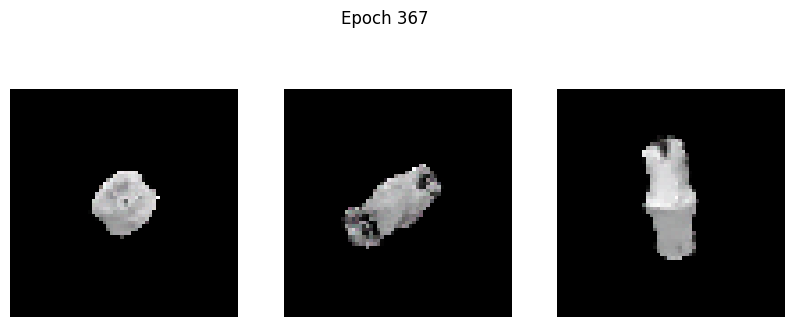

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0938 - g_loss: 5.1185
Epoch 368/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0017 - g_loss: 4.9266

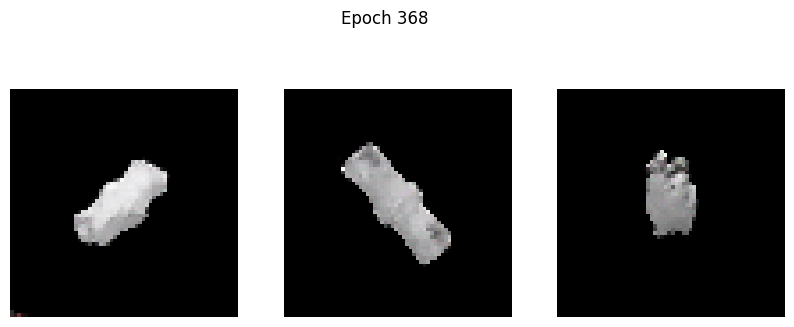

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0018 - g_loss: 4.9259
Epoch 369/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0268 - g_loss: 4.7951

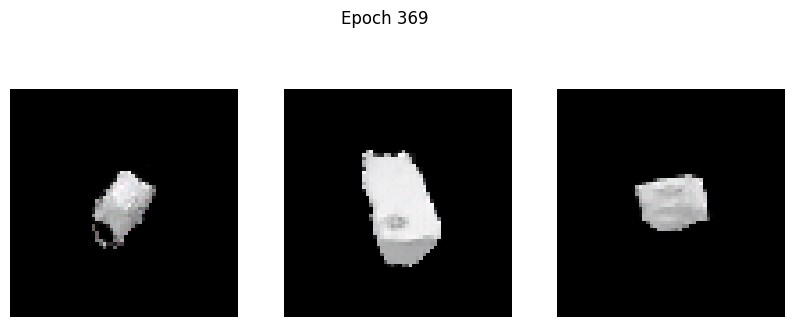

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0267 - g_loss: 4.7952
Epoch 370/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0267 - g_loss: 5.0153

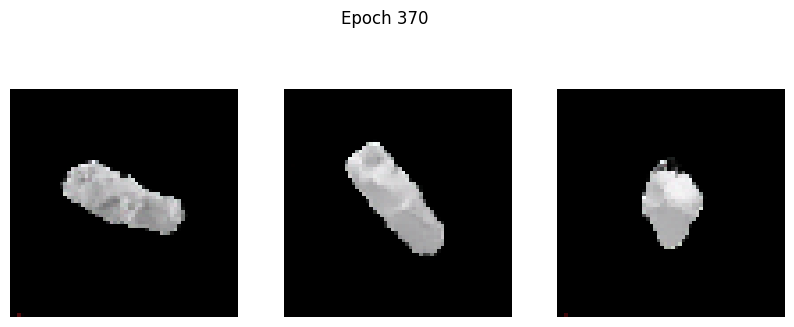

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0269 - g_loss: 5.0151
Epoch 371/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0718 - g_loss: 5.1778

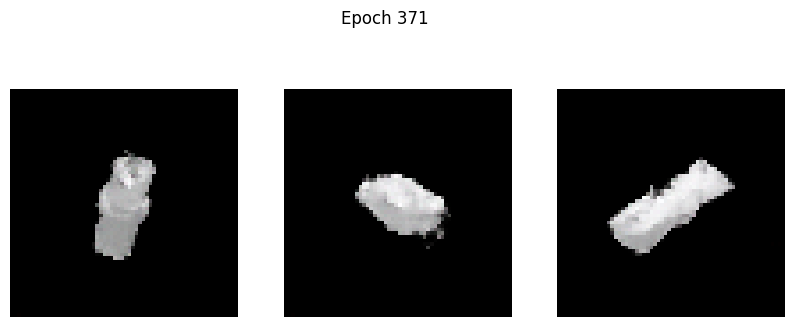

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0718 - g_loss: 5.1769
Epoch 372/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0192 - g_loss: 4.7587

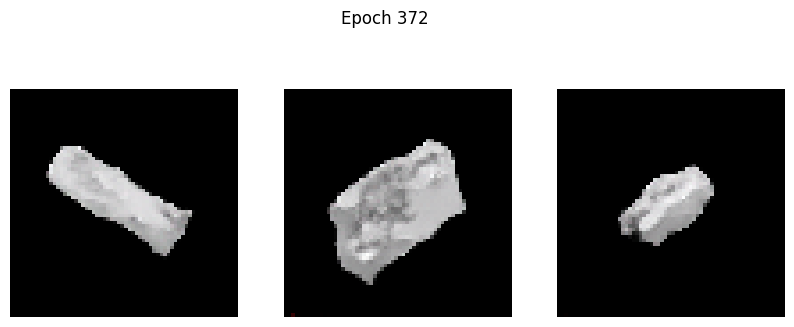

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0190 - g_loss: 4.7592
Epoch 373/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0400 - g_loss: 5.0782

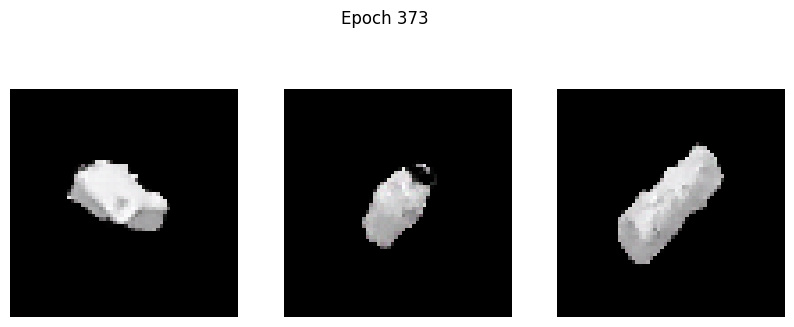

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0398 - g_loss: 5.0761
Epoch 374/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0456 - g_loss: 5.0437

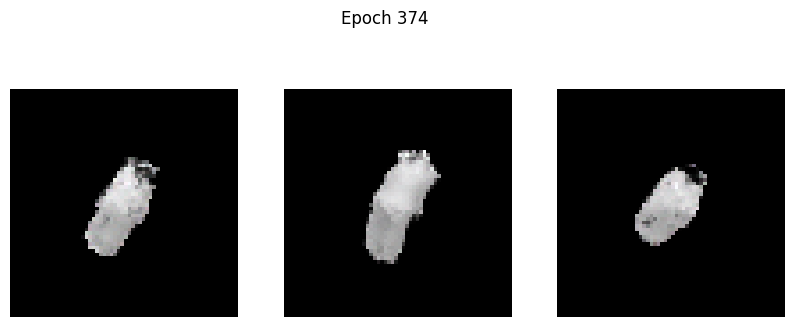

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0456 - g_loss: 5.0443
Epoch 375/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0248 - g_loss: 5.1760

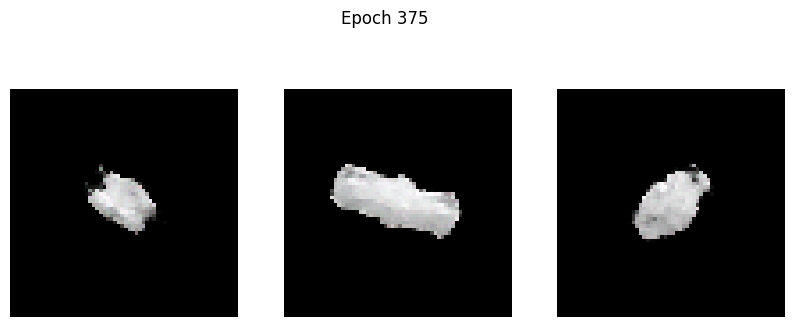

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0253 - g_loss: 5.1768
Epoch 376/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1546 - g_loss: 5.5090

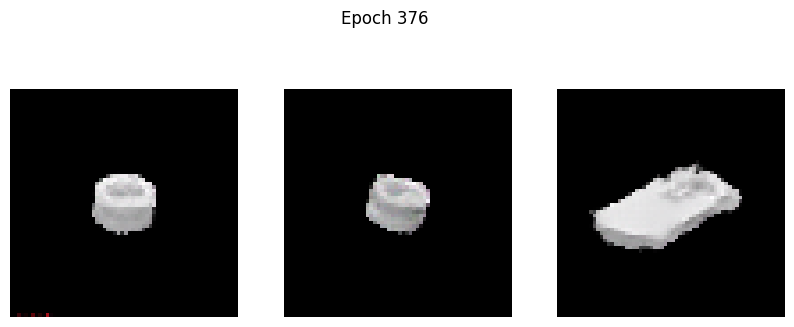

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1538 - g_loss: 5.5063
Epoch 377/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0114 - g_loss: 4.9494

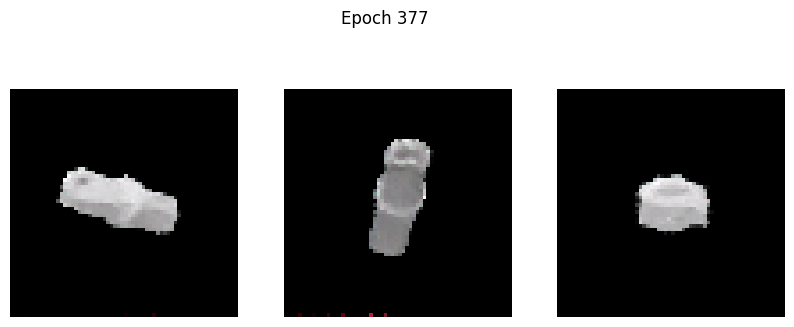

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0114 - g_loss: 4.9499
Epoch 378/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0374 - g_loss: 5.2489

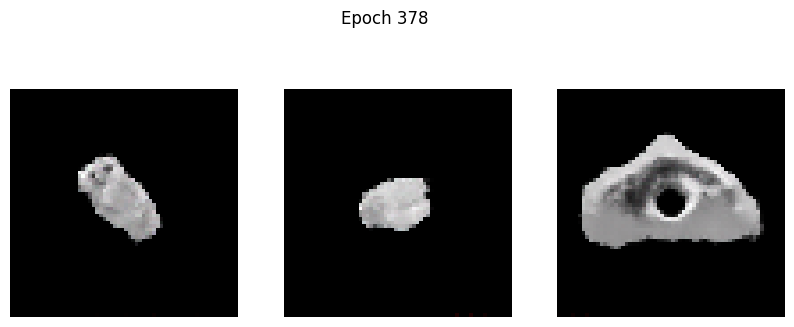

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0373 - g_loss: 5.2484
Epoch 379/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0355 - g_loss: 5.1277

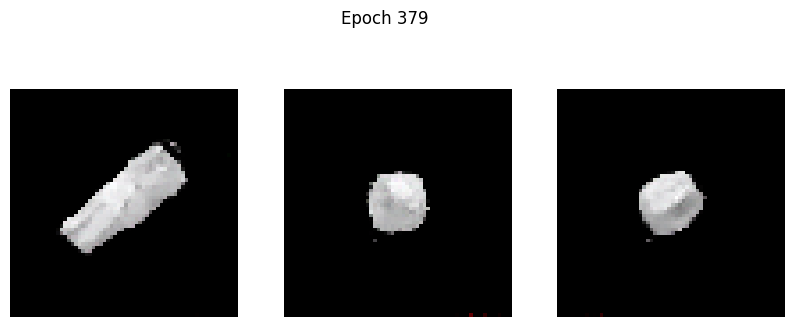

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0356 - g_loss: 5.1277
Epoch 380/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0036 - g_loss: 5.0539

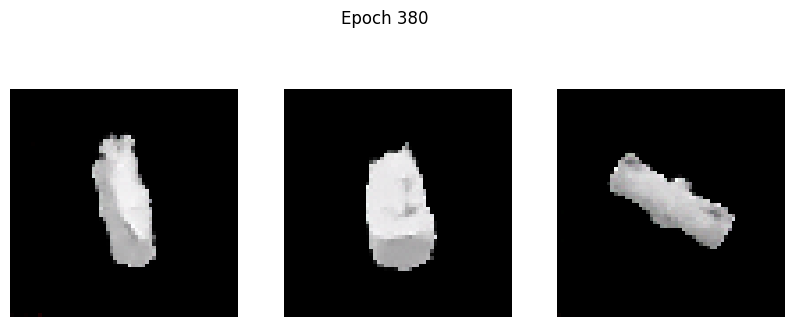

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0040 - g_loss: 5.0553
Epoch 381/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0042 - g_loss: 5.0641

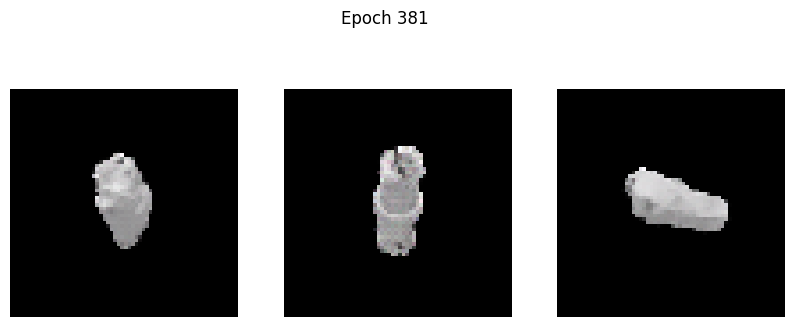

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0042 - g_loss: 5.0635
Epoch 382/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0220 - g_loss: 5.2071

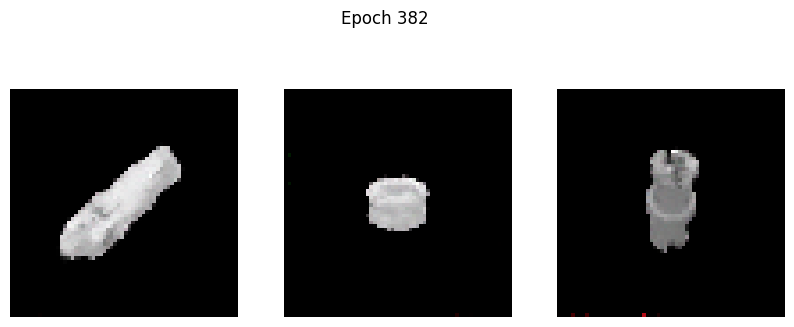

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0218 - g_loss: 5.2059
Epoch 383/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0019 - g_loss: 5.0586

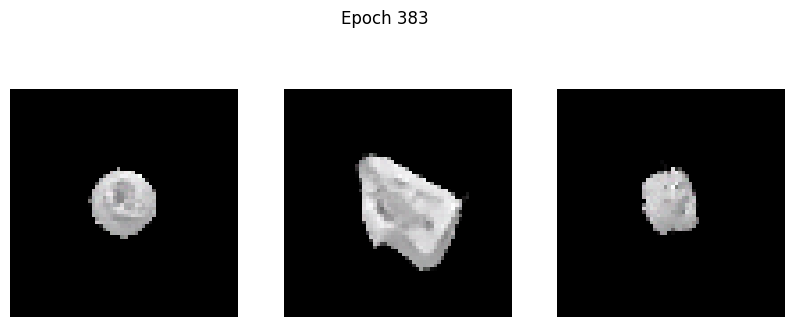

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0019 - g_loss: 5.0597
Epoch 384/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0469 - g_loss: 5.2116

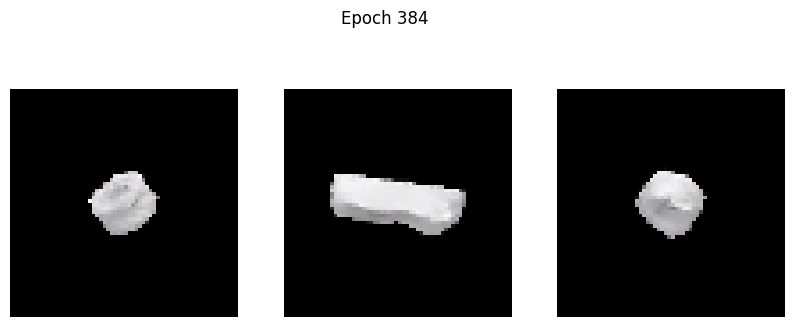

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - d_loss: 0.0469 - g_loss: 5.2123
Epoch 385/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0062 - g_loss: 5.0423

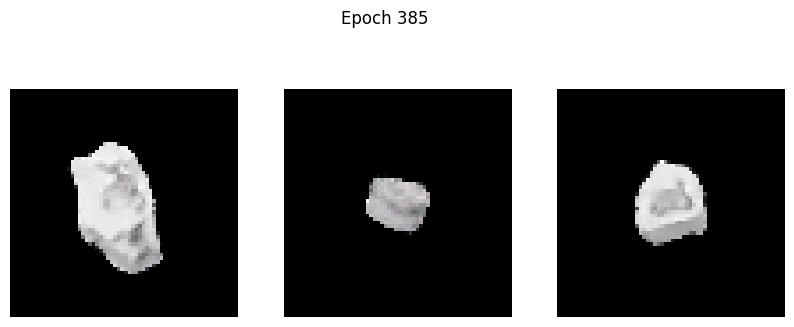

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0064 - g_loss: 5.0443
Epoch 386/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0754 - g_loss: 5.4515

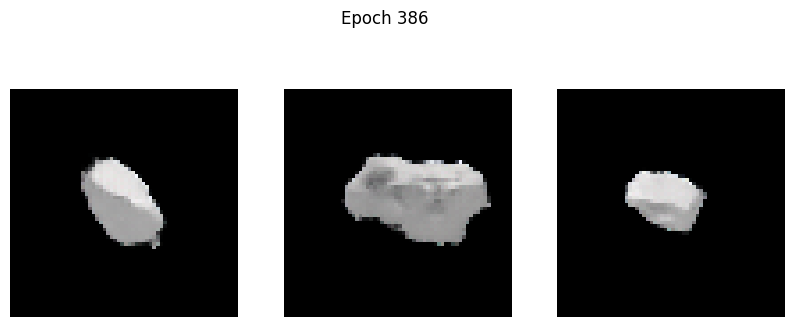

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.0767 - g_loss: 5.4539
Epoch 387/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1186 - g_loss: 5.1305

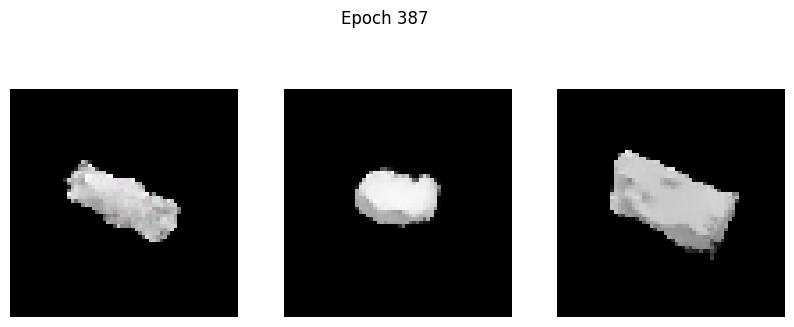

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1181 - g_loss: 5.1294
Epoch 388/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0353 - g_loss: 4.7257

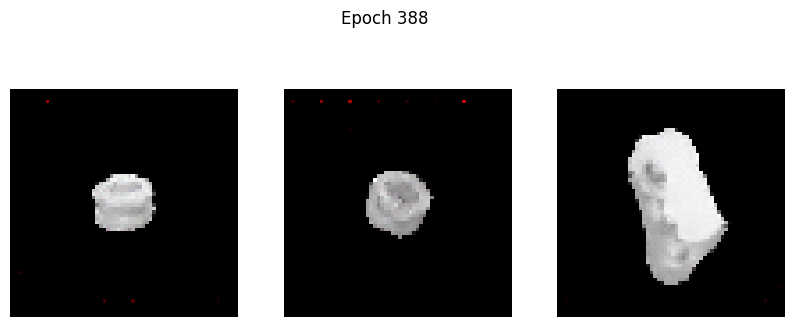

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0350 - g_loss: 4.7274
Epoch 389/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0086 - g_loss: 5.0925

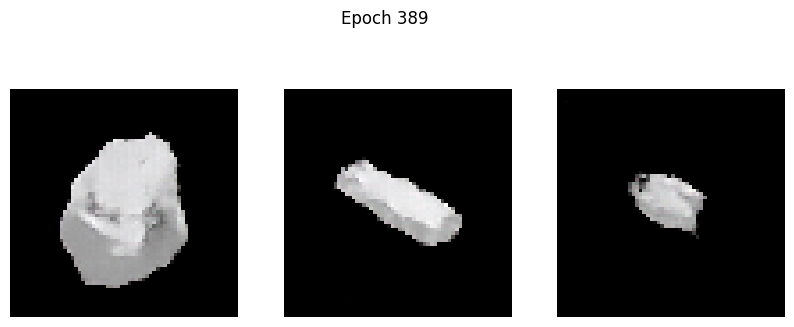

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0083 - g_loss: 5.0935
Epoch 390/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0330 - g_loss: 5.1102

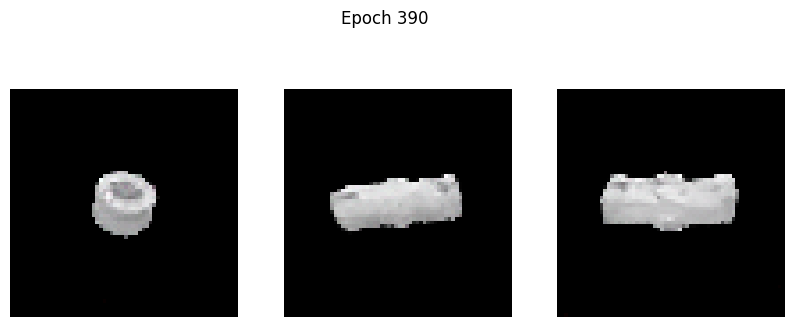

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0328 - g_loss: 5.1100
Epoch 391/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 4.2755e-04 - g_loss: 5.0353

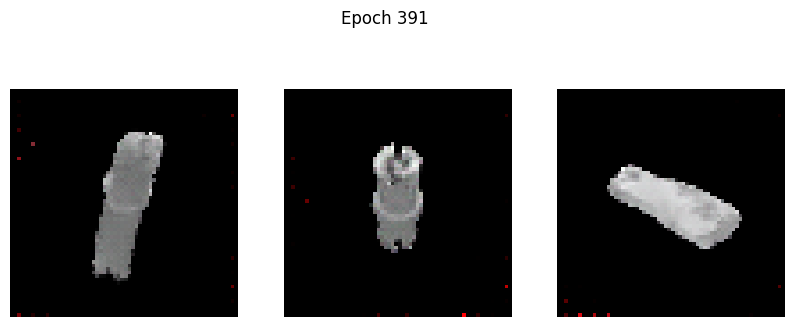

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 5.4737e-04 - g_loss: 5.0356
Epoch 392/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0014 - g_loss: 5.2169

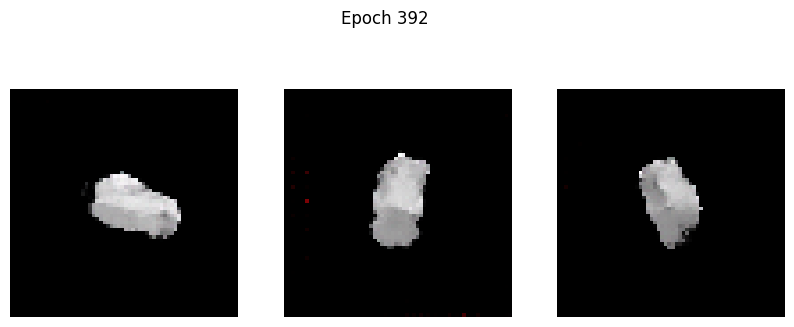

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -9.8492e-04 - g_loss: 5.2179
Epoch 393/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0195 - g_loss: 5.1561

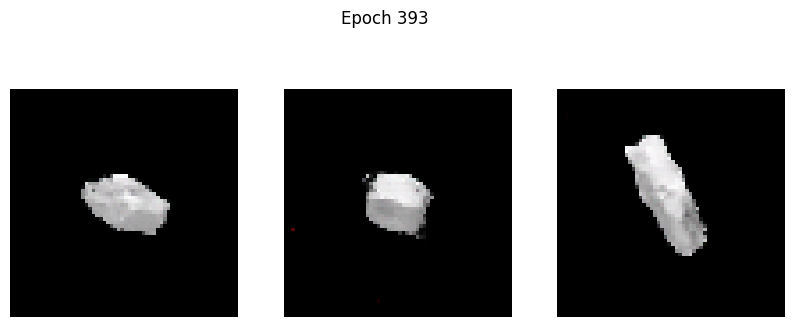

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0196 - g_loss: 5.1568
Epoch 394/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0621 - g_loss: 5.4890

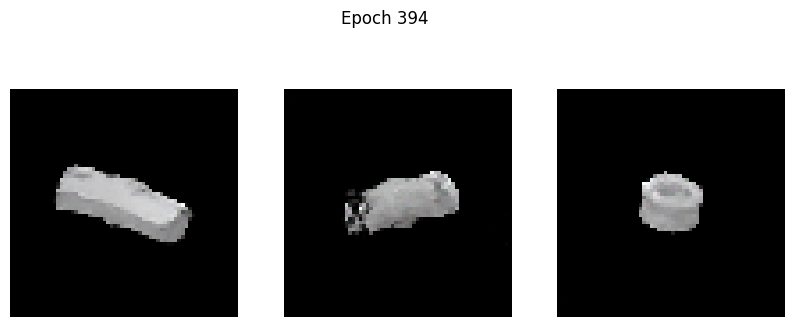

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - d_loss: 0.0622 - g_loss: 5.4883
Epoch 395/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0260 - g_loss: 5.0196

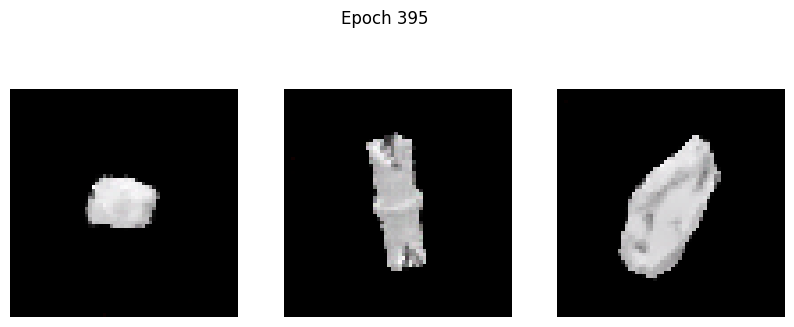

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0261 - g_loss: 5.0188
Epoch 396/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0303 - g_loss: 5.3826

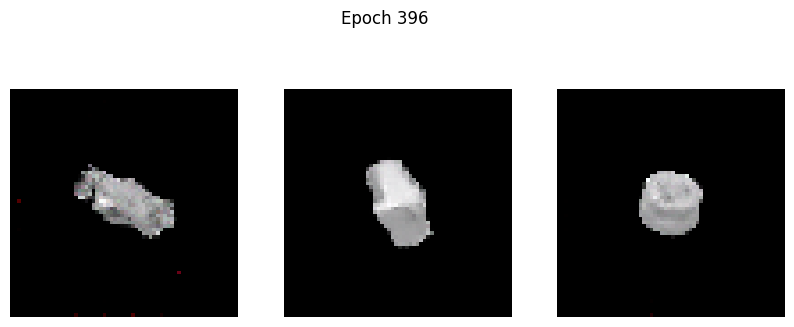

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0300 - g_loss: 5.3812
Epoch 397/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.0364 - g_loss: 5.4049

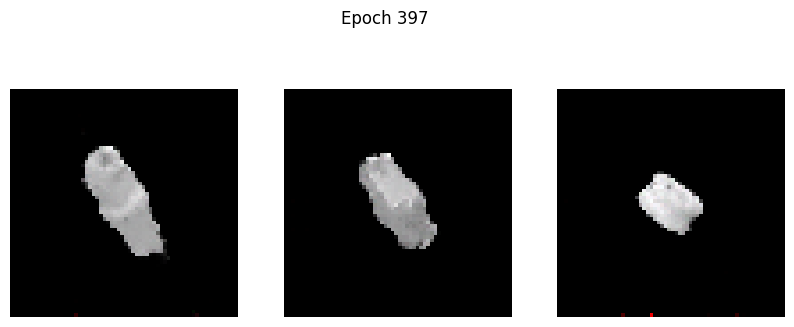

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.0364 - g_loss: 5.4046
Epoch 398/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0524 - g_loss: 5.5017

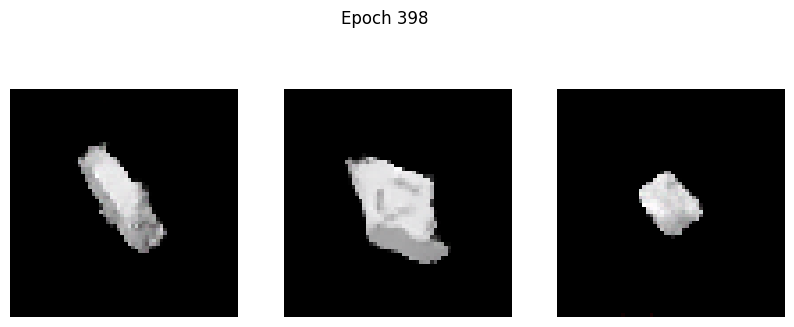

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0525 - g_loss: 5.5007
Epoch 399/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0120 - g_loss: 5.3518

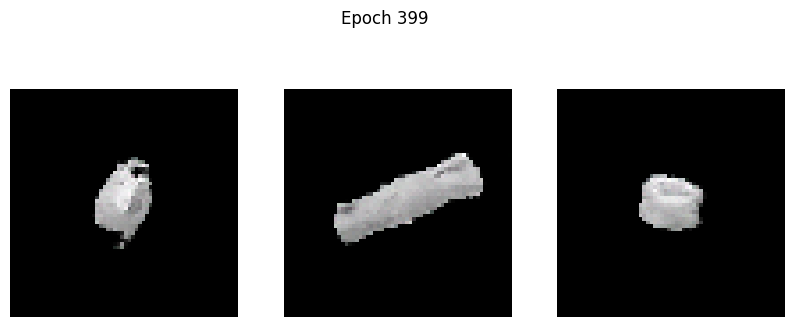

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0119 - g_loss: 5.3512
Epoch 400/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0240 - g_loss: 5.4594

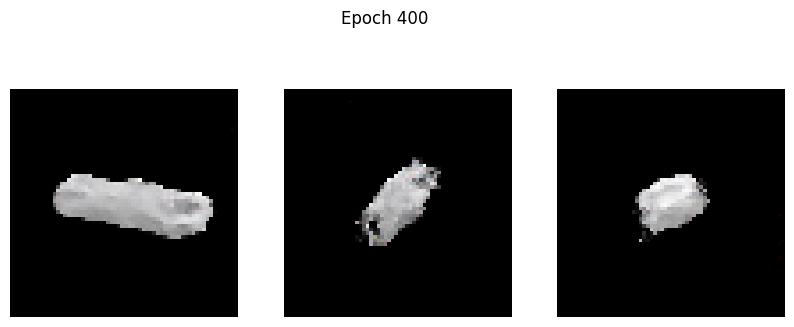

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0240 - g_loss: 5.4597
Epoch 401/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0316 - g_loss: 5.0196

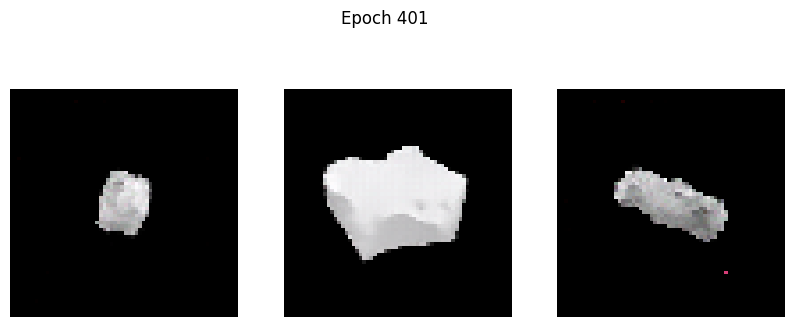

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0315 - g_loss: 5.0215
Epoch 402/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0430 - g_loss: 5.5908

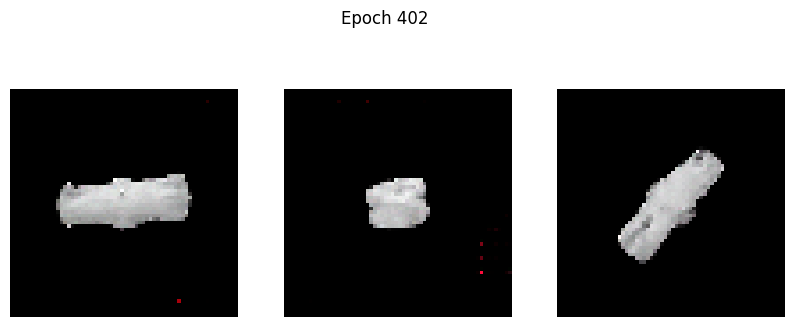

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0428 - g_loss: 5.5888
Epoch 403/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0193 - g_loss: 5.4776

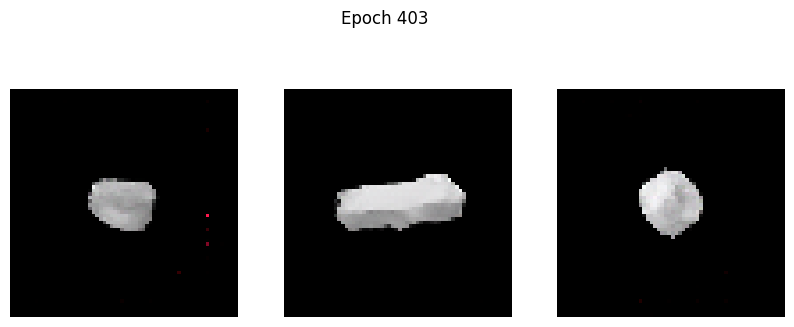

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0194 - g_loss: 5.4782
Epoch 404/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0318 - g_loss: 5.2823

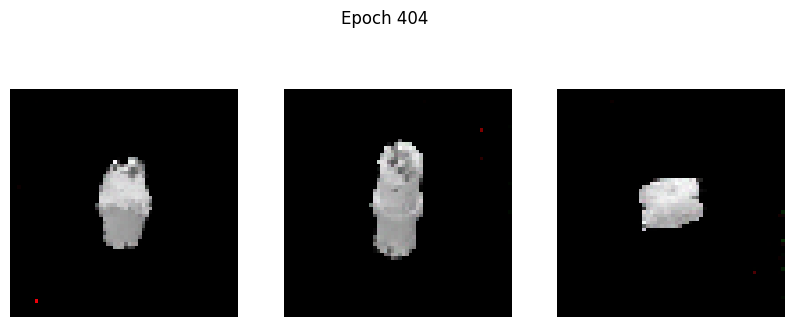

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0316 - g_loss: 5.2835
Epoch 405/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 6.6406e-04 - g_loss: 5.3924

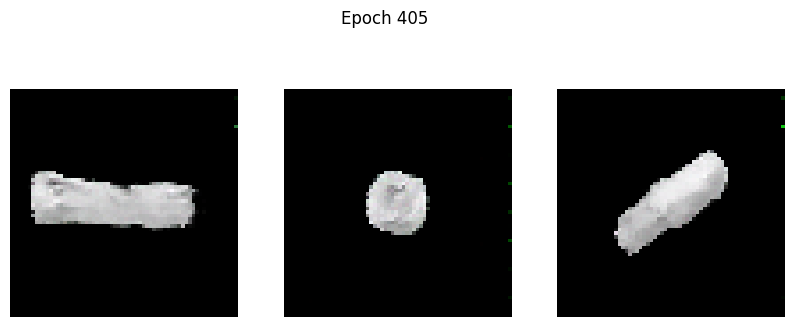

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 7.2948e-04 - g_loss: 5.3929
Epoch 406/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1531 - g_loss: 5.8907

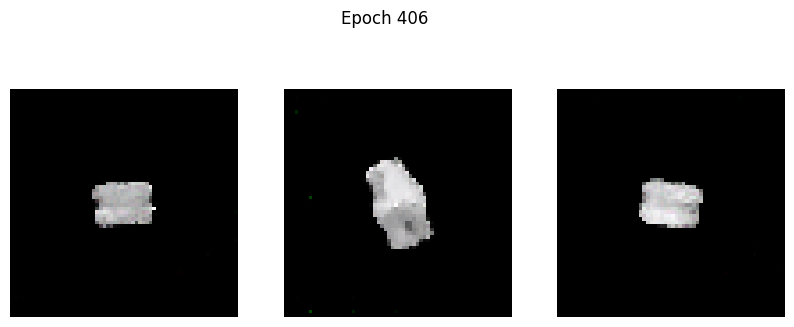

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1522 - g_loss: 5.8873
Epoch 407/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0099 - g_loss: 5.3157

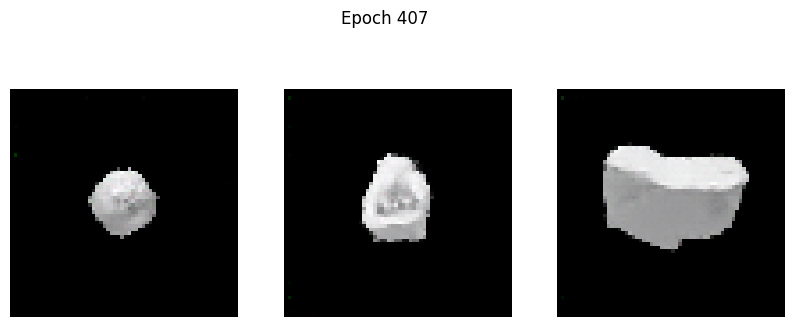

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0099 - g_loss: 5.3162
Epoch 408/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0047 - g_loss: 5.2256

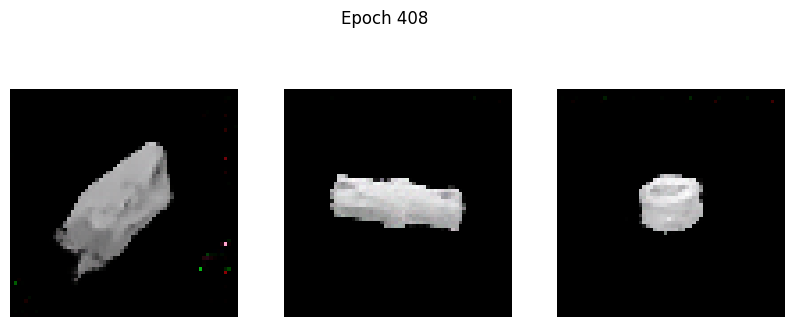

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0046 - g_loss: 5.2274
Epoch 409/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0065 - g_loss: 5.5794

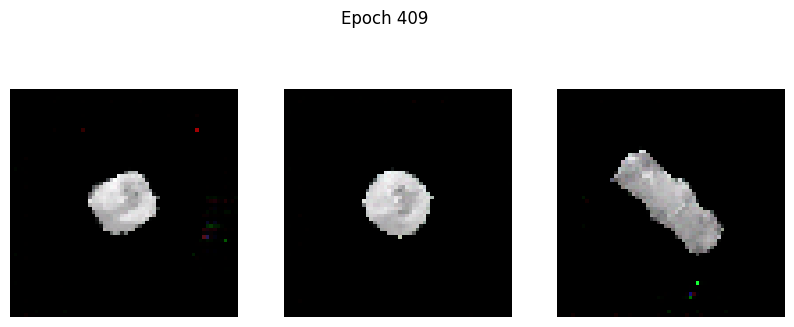

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0066 - g_loss: 5.5795
Epoch 410/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0137 - g_loss: 5.6051

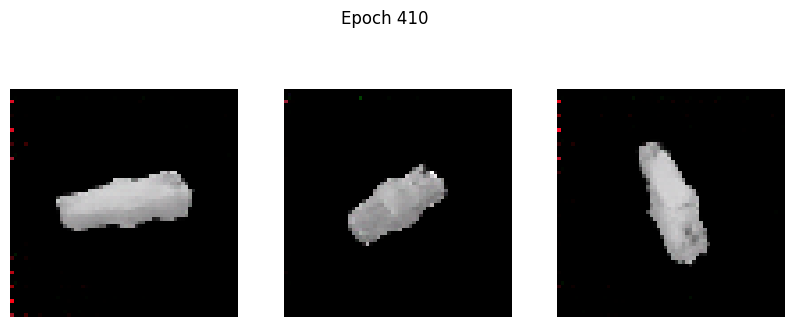

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0134 - g_loss: 5.6046
Epoch 411/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0976 - g_loss: 5.7177

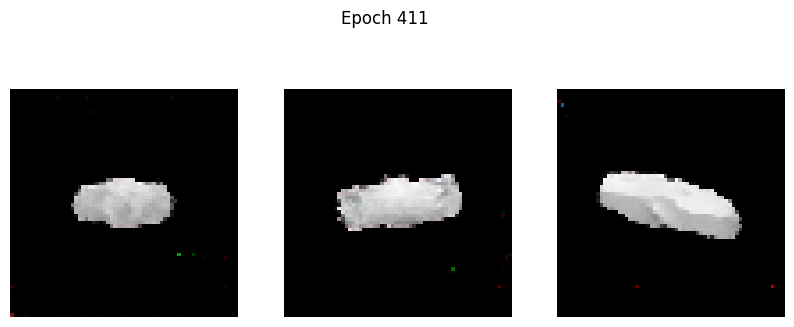

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0983 - g_loss: 5.7207
Epoch 412/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0098 - g_loss: 5.0314

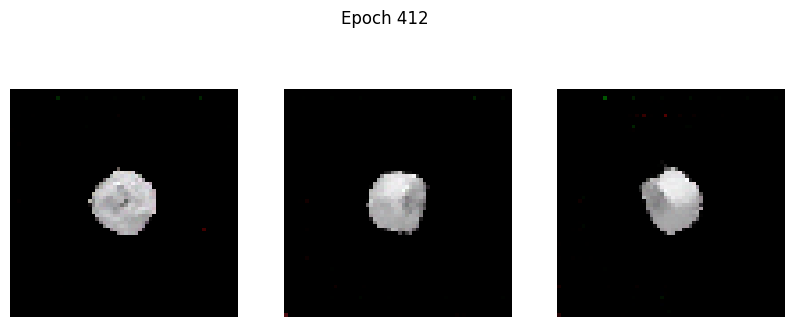

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0097 - g_loss: 5.0345
Epoch 413/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0147 - g_loss: 5.1689

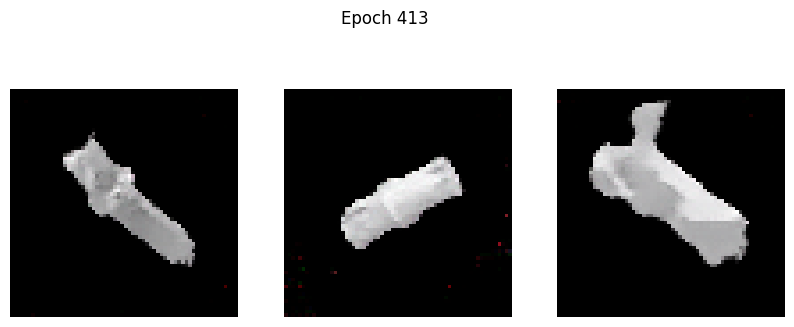

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0149 - g_loss: 5.1688
Epoch 414/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0046 - g_loss: 5.4809

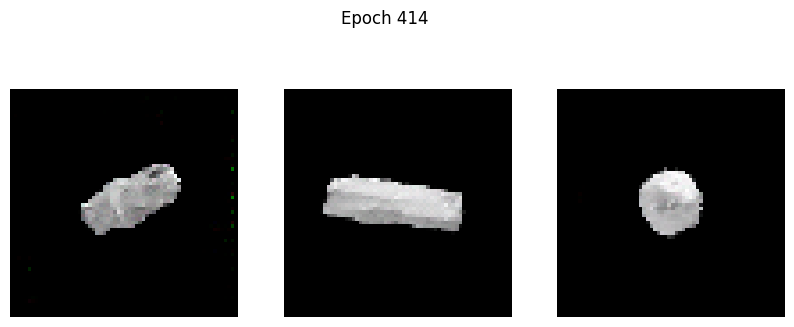

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0047 - g_loss: 5.4815
Epoch 415/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0155 - g_loss: 5.5438

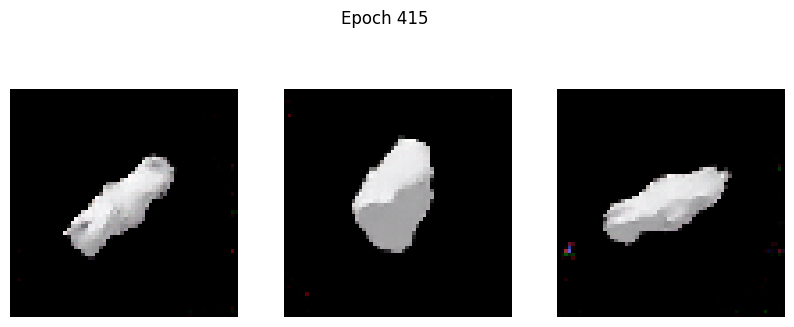

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0153 - g_loss: 5.5449
Epoch 416/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0339 - g_loss: 5.2885

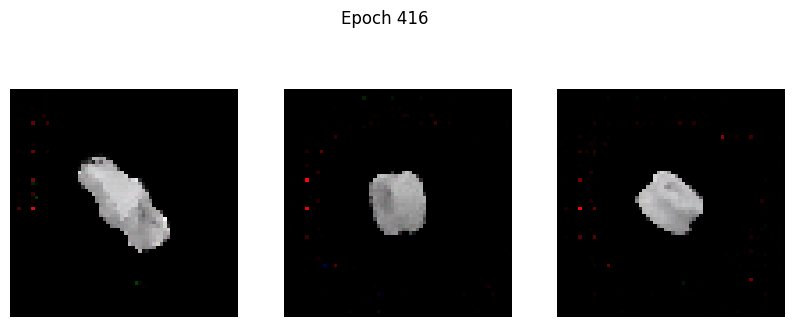

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0338 - g_loss: 5.2894
Epoch 417/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0467 - g_loss: 5.4483

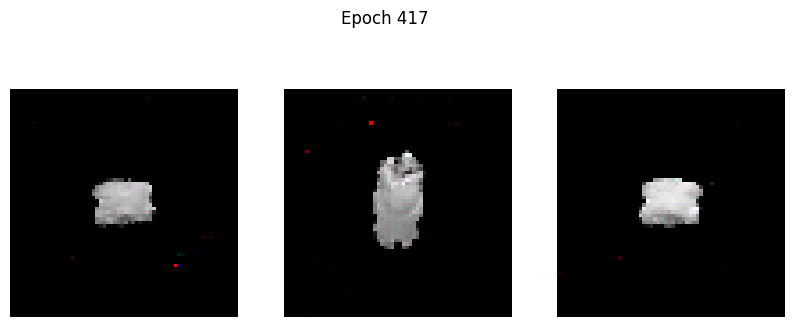

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: -0.0463 - g_loss: 5.4495
Epoch 418/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0165 - g_loss: 5.6036

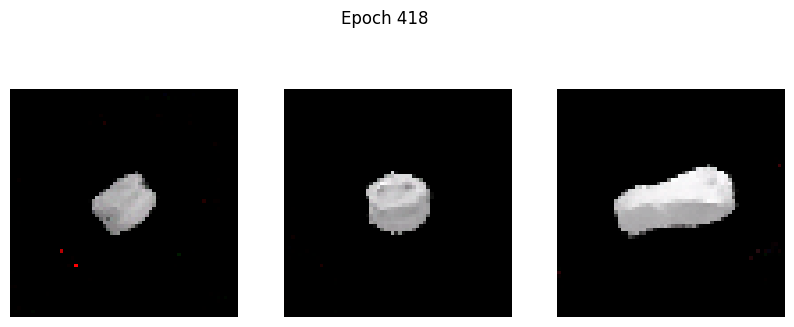

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0161 - g_loss: 5.6032
Epoch 419/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0377 - g_loss: 5.5033

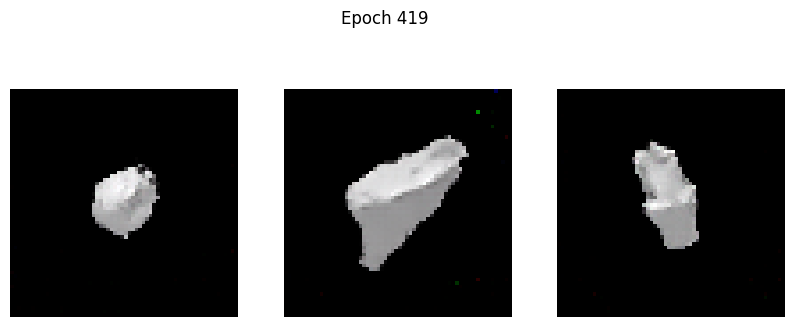

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0377 - g_loss: 5.5038
Epoch 420/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -7.1351e-04 - g_loss: 5.7952

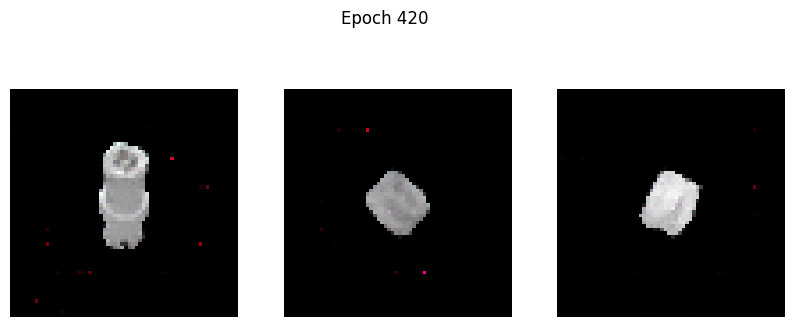

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -5.2086e-04 - g_loss: 5.7964
Epoch 421/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0348 - g_loss: 6.0551

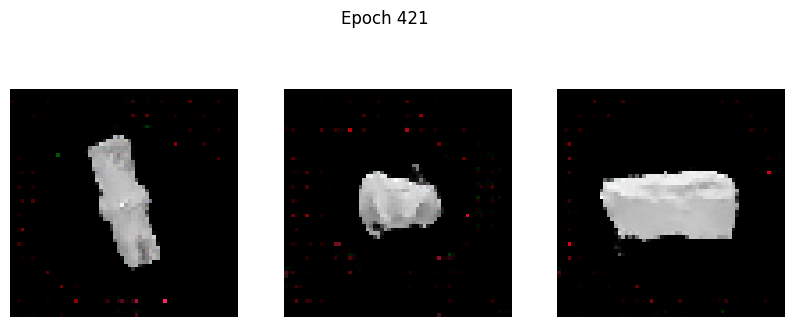

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0351 - g_loss: 6.0552
Epoch 422/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0395 - g_loss: 6.0304

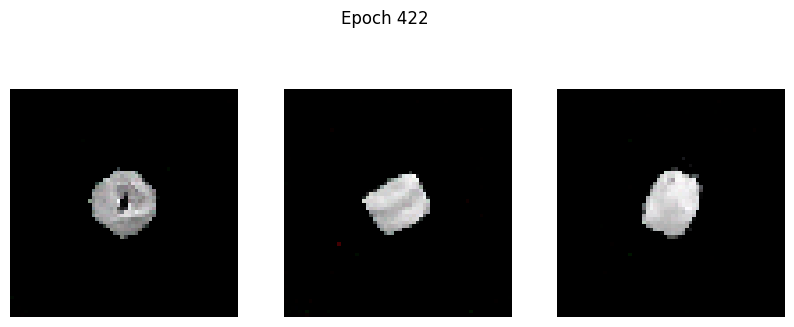

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0396 - g_loss: 6.0300
Epoch 423/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0245 - g_loss: 5.4730

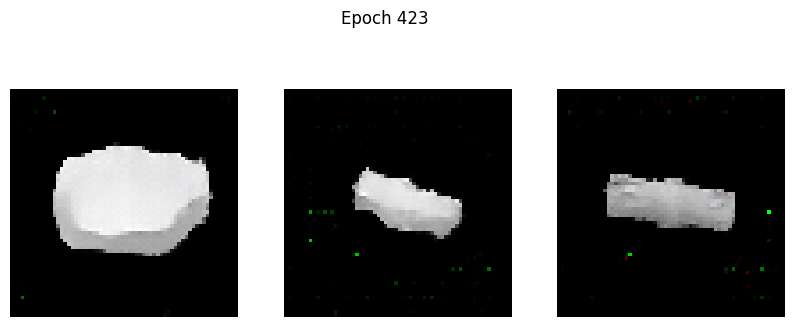

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0248 - g_loss: 5.4736
Epoch 424/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0354 - g_loss: 5.7698

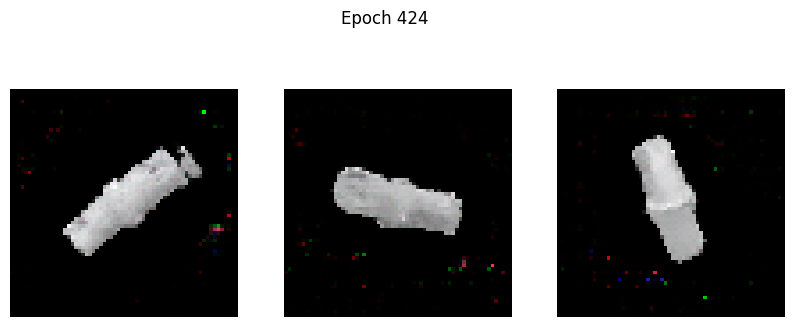

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0351 - g_loss: 5.7704
Epoch 425/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0235 - g_loss: 5.7306

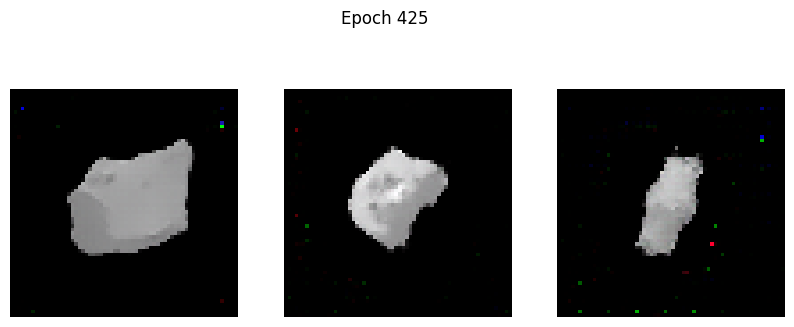

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0235 - g_loss: 5.7318
Epoch 426/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0444 - g_loss: 5.8231

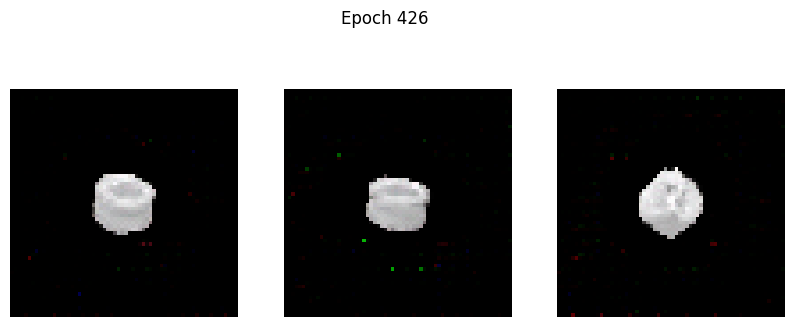

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0442 - g_loss: 5.8237
Epoch 427/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0091 - g_loss: 5.7340

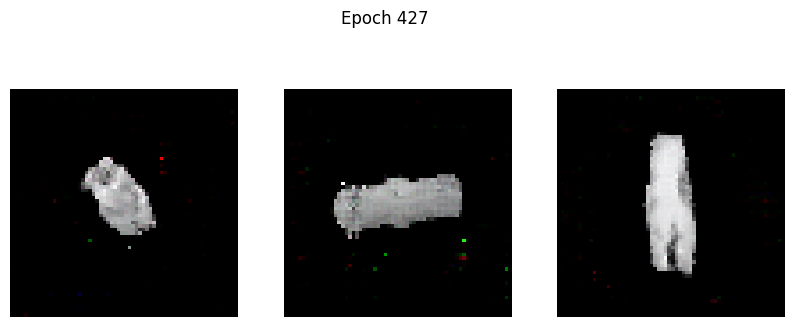

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0089 - g_loss: 5.7353
Epoch 428/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0117 - g_loss: 5.8838

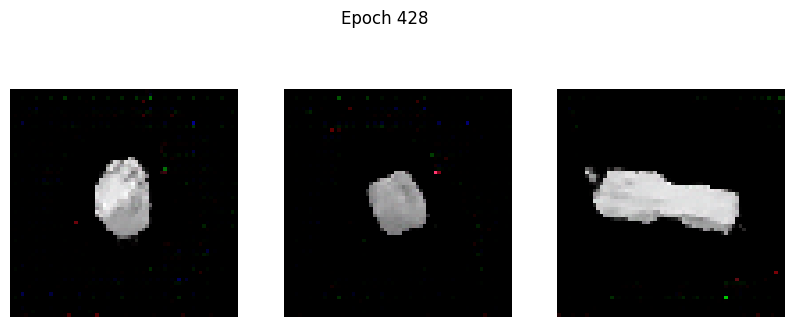

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0114 - g_loss: 5.8847
Epoch 429/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0448 - g_loss: 5.6809

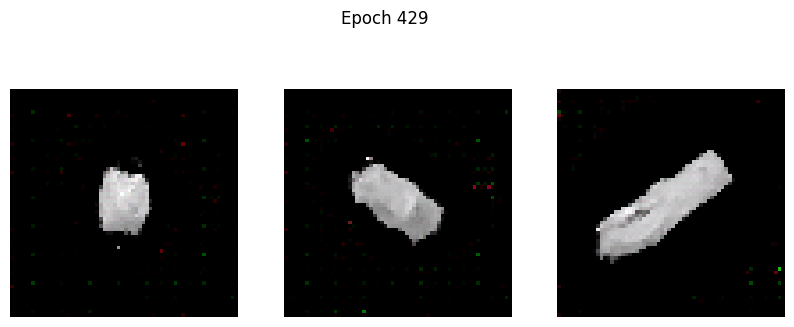

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0446 - g_loss: 5.6828
Epoch 430/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0061 - g_loss: 6.0237

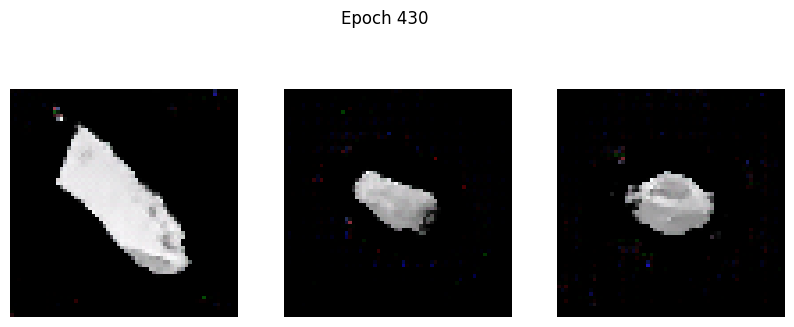

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0065 - g_loss: 6.0254
Epoch 431/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0337 - g_loss: 6.0655

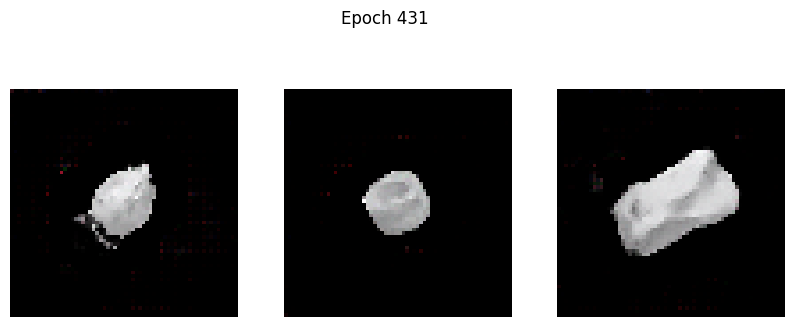

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0339 - g_loss: 6.0648
Epoch 432/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0476 - g_loss: 5.6708

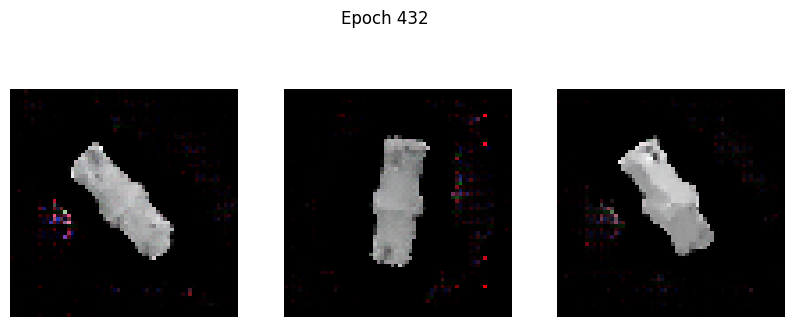

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0474 - g_loss: 5.6723
Epoch 433/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0283 - g_loss: 5.9350

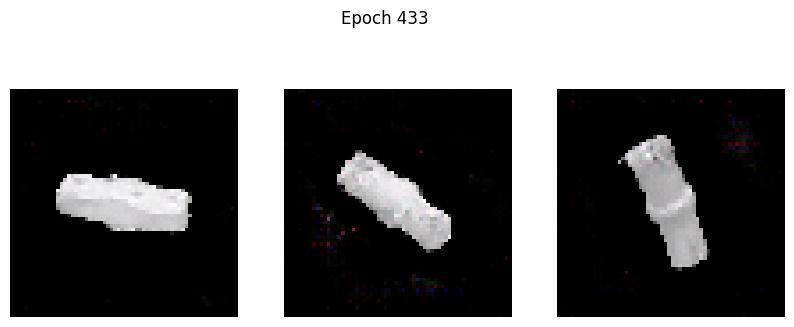

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0283 - g_loss: 5.9334
Epoch 434/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0210 - g_loss: 6.0596

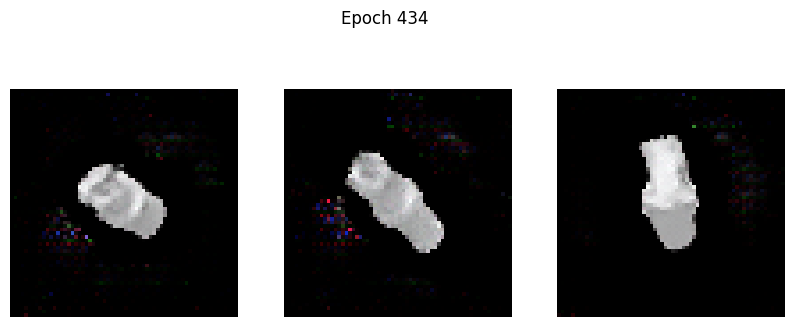

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0208 - g_loss: 6.0593
Epoch 435/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0789 - g_loss: 5.5404

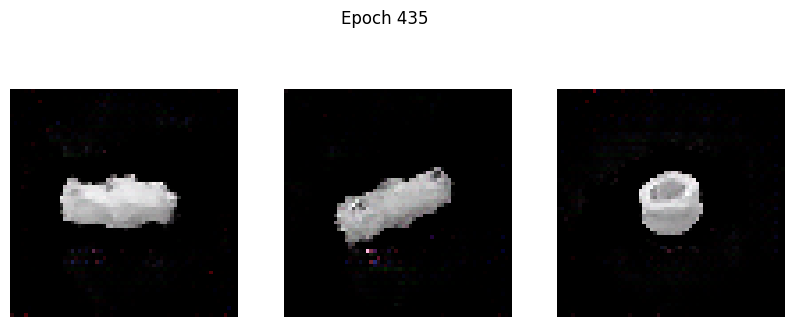

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0784 - g_loss: 5.5432
Epoch 436/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0211 - g_loss: 5.9897

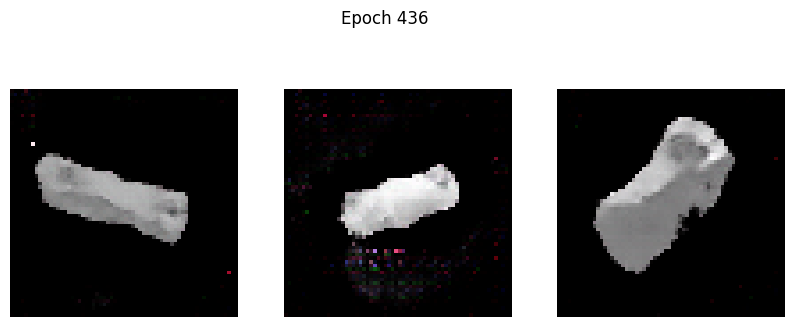

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0208 - g_loss: 5.9909
Epoch 437/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0291 - g_loss: 5.9181

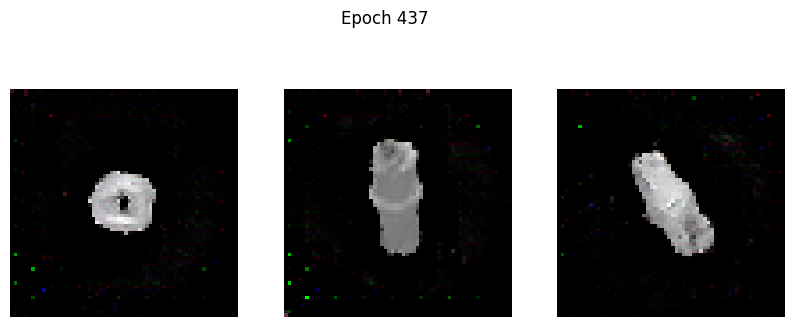

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0292 - g_loss: 5.9198
Epoch 438/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0181 - g_loss: 6.1927

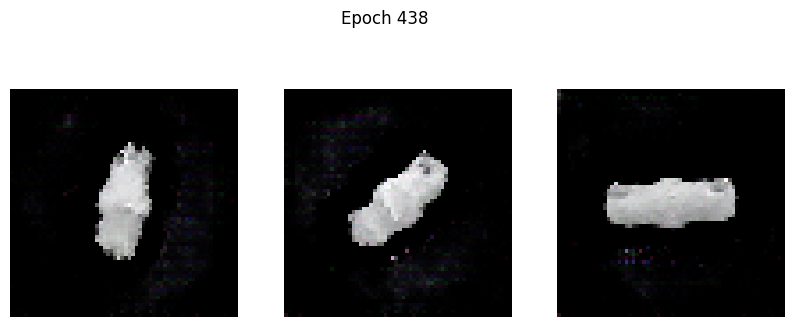

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0177 - g_loss: 6.1907
Epoch 439/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0511 - g_loss: 6.0485

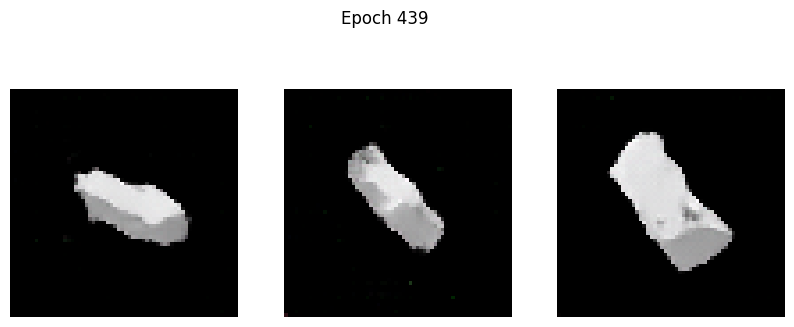

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0510 - g_loss: 6.0489
Epoch 440/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0460 - g_loss: 5.7468

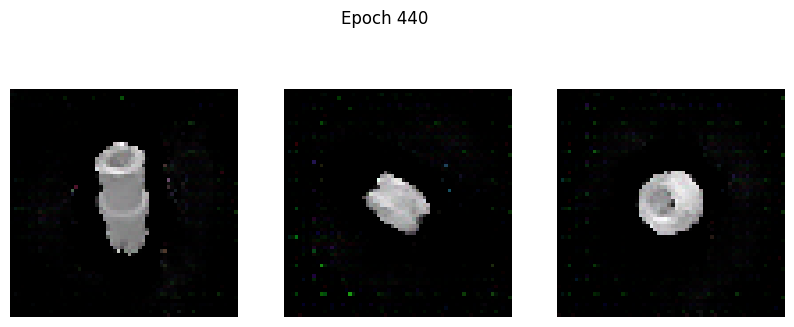

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0461 - g_loss: 5.7468
Epoch 441/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0070 - g_loss: 6.2425

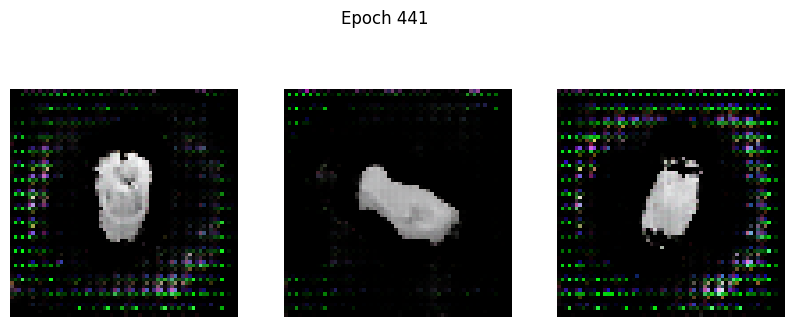

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0080 - g_loss: 6.2471
Epoch 442/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.1066 - g_loss: 10.0220

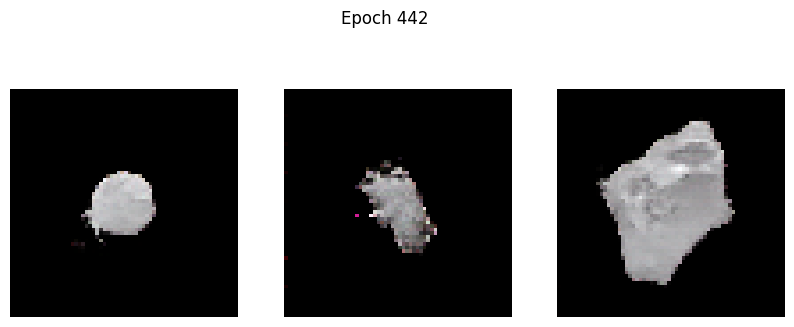

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 1.0978 - g_loss: 9.9939
Epoch 443/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0727 - g_loss: 5.7639

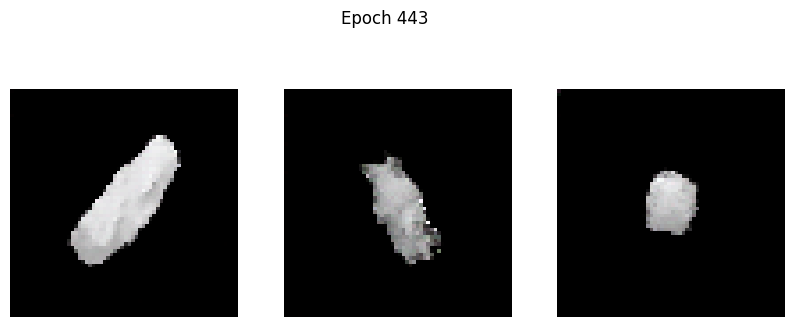

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0729 - g_loss: 5.7641
Epoch 444/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1014 - g_loss: 5.8879

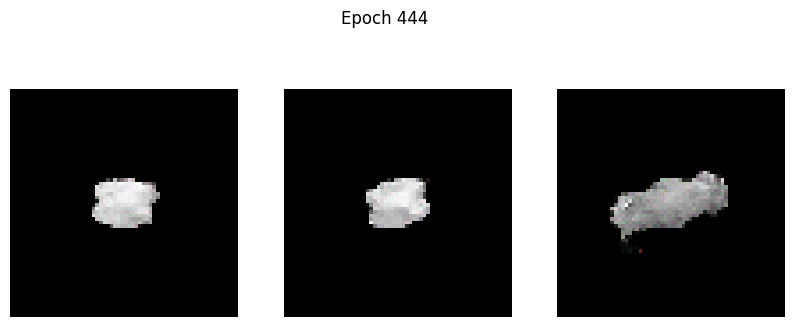

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1014 - g_loss: 5.8866
Epoch 445/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1174 - g_loss: 5.6904

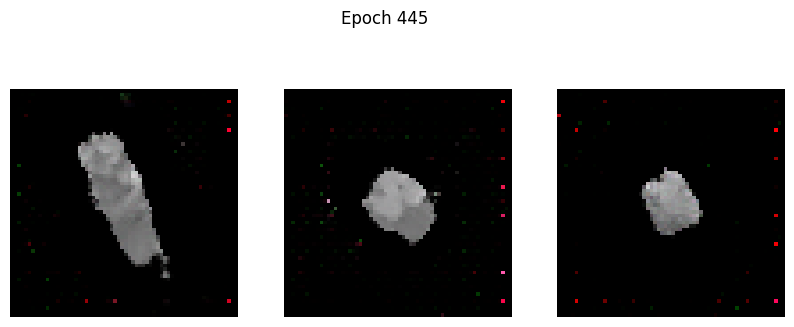

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1175 - g_loss: 5.6903
Epoch 446/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0728 - g_loss: 6.0856

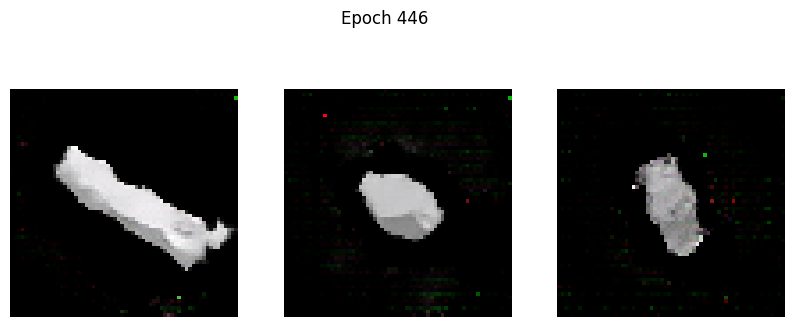

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.0727 - g_loss: 6.0876
Epoch 447/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0430 - g_loss: 6.3675

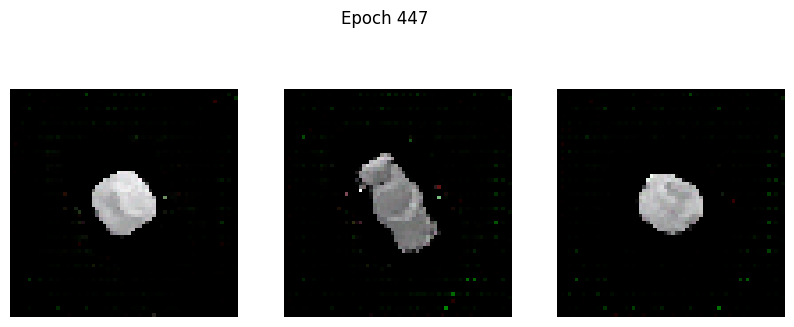

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0432 - g_loss: 6.3672
Epoch 448/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0133 - g_loss: 6.5438

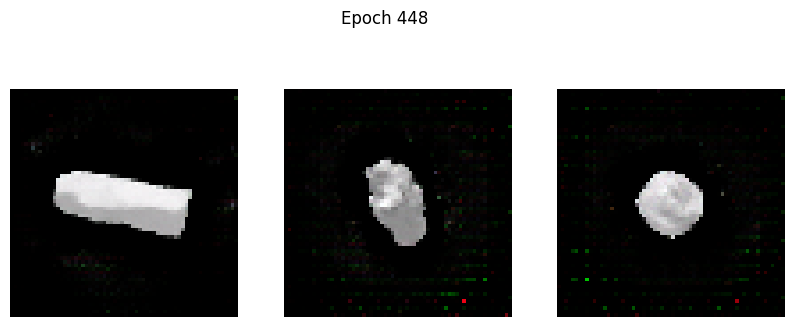

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0134 - g_loss: 6.5430
Epoch 449/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0779 - g_loss: 7.2810

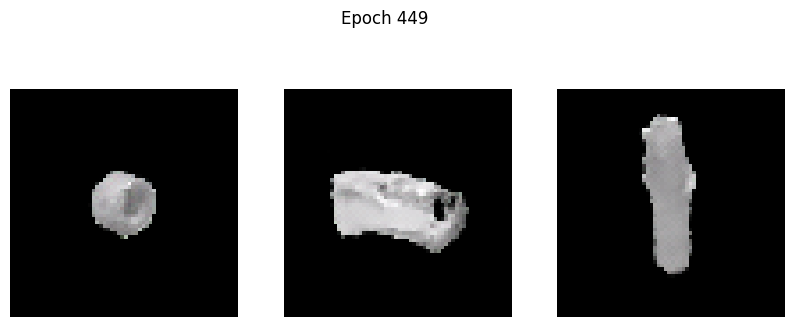

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0783 - g_loss: 7.2747
Epoch 450/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0100 - g_loss: 6.4933

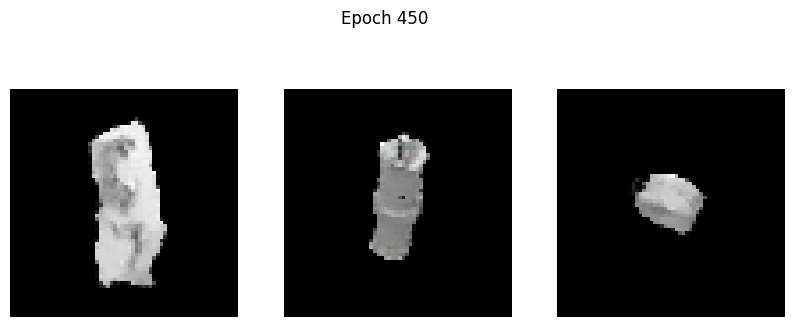

100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - d_loss: 0.0093 - g_loss: 6.4892
Epoch 451/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.0507 - g_loss: 6.0772

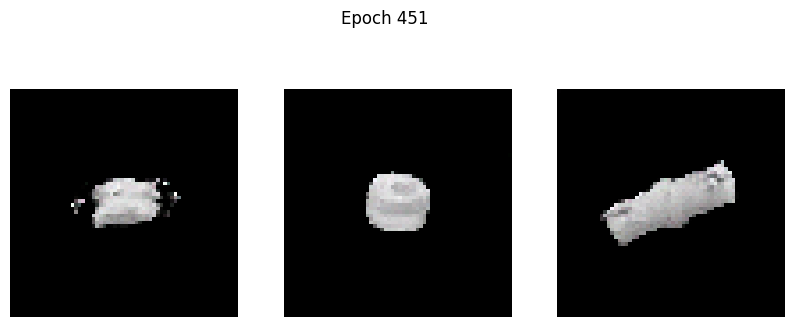

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.0508 - g_loss: 6.0767
Epoch 452/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - d_loss: -0.1283 - g_loss: 5.6648

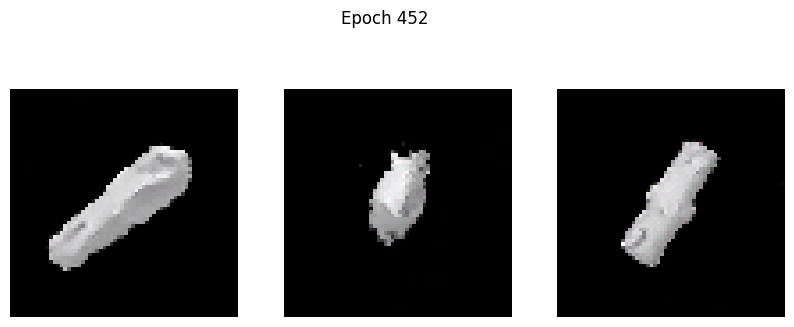

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - d_loss: -0.1284 - g_loss: 5.6653
Epoch 453/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0072 - g_loss: 6.7610

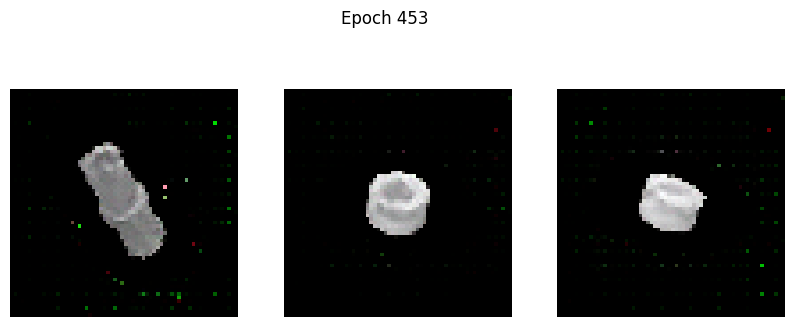

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0073 - g_loss: 6.7600
Epoch 454/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0697 - g_loss: 6.0996

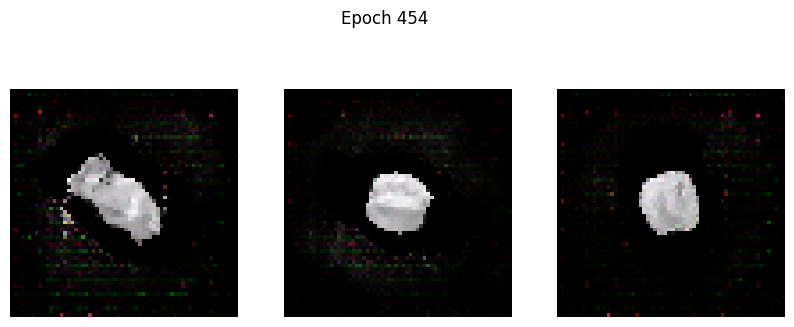

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0693 - g_loss: 6.1027
Epoch 455/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.0586 - g_loss: 8.0840

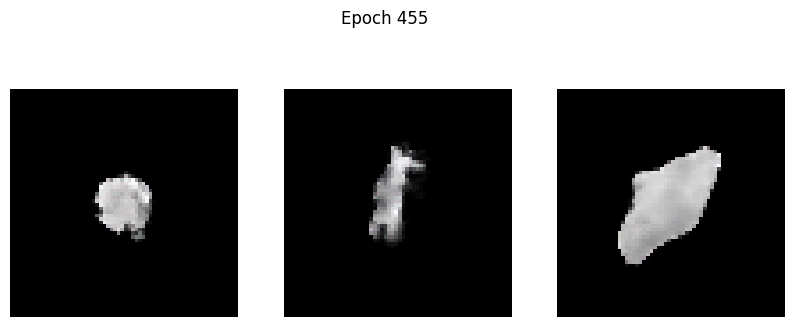

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.0593 - g_loss: 8.0866
Epoch 456/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.3411 - g_loss: 6.1166

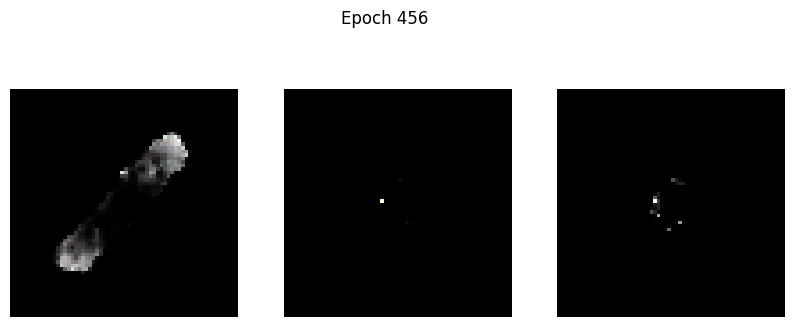

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.3409 - g_loss: 6.1172
Epoch 457/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.3657 - g_loss: 5.5399

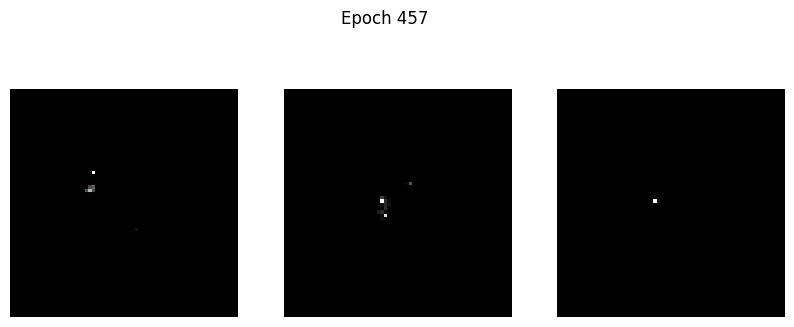

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.3658 - g_loss: 5.5388
Epoch 458/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.4585 - g_loss: 5.1606

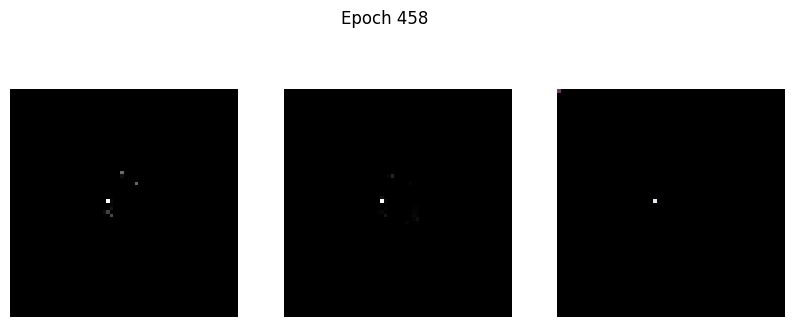

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.4581 - g_loss: 5.1632
Epoch 459/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.4191 - g_loss: 5.2991

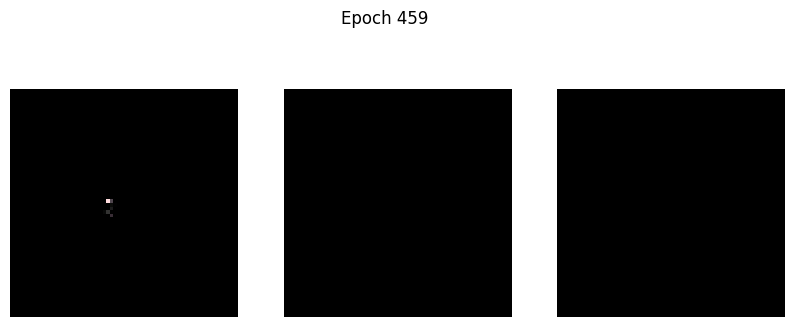

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.4192 - g_loss: 5.3010
Epoch 460/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.5187 - g_loss: 5.1005

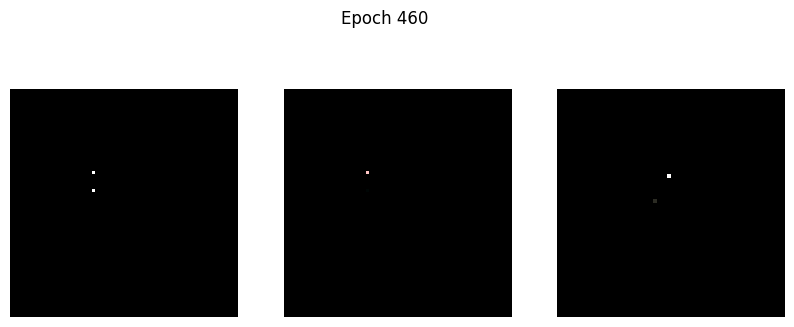

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.5188 - g_loss: 5.1006
Epoch 461/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.4747 - g_loss: 9.1368

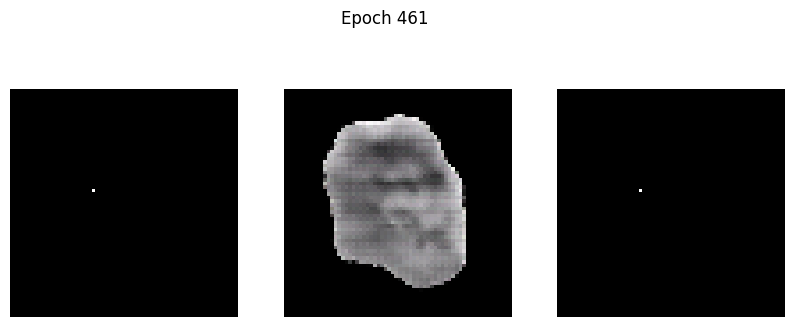

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.4747 - g_loss: 9.1281
Epoch 462/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.5175 - g_loss: 5.5170

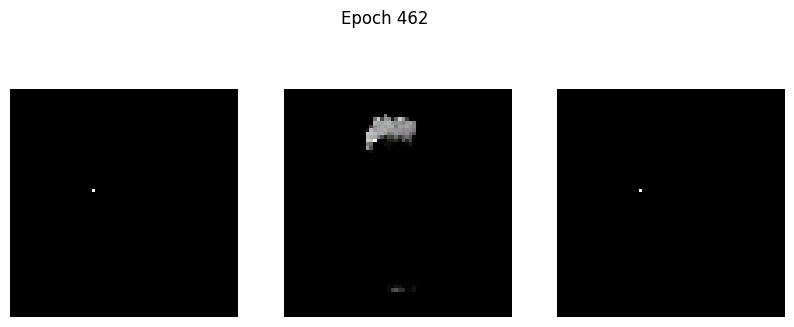

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.5174 - g_loss: 5.5235
Epoch 463/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.5044 - g_loss: 5.0718

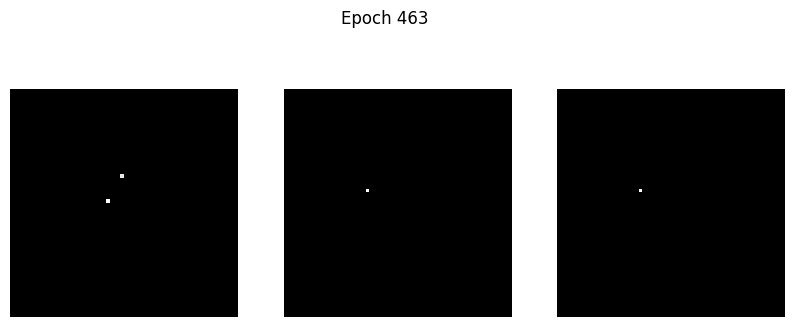

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.5046 - g_loss: 5.0752
Epoch 464/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: -0.7384 - g_loss: 5.6407

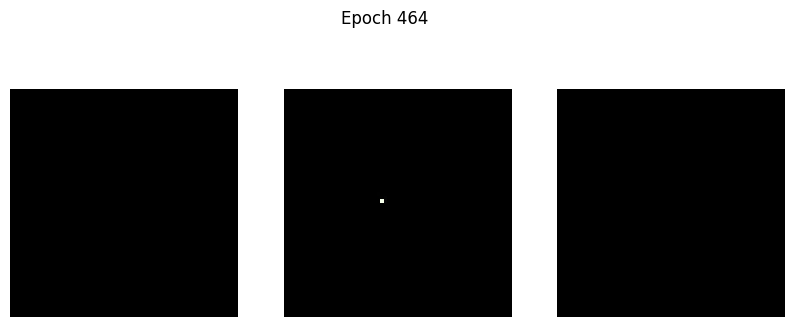

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: -0.7389 - g_loss: 5.6393
Epoch 465/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.5268 - g_loss: 28.1547

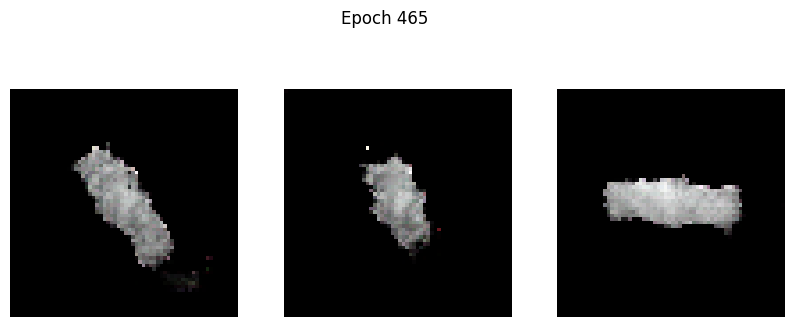

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 1.5359 - g_loss: 28.2436
Epoch 466/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1963 - g_loss: 10.1304

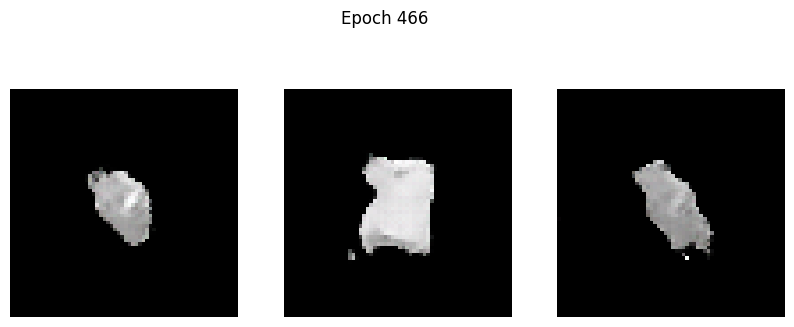

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1958 - g_loss: 10.1290
Epoch 467/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0182 - g_loss: 8.1504

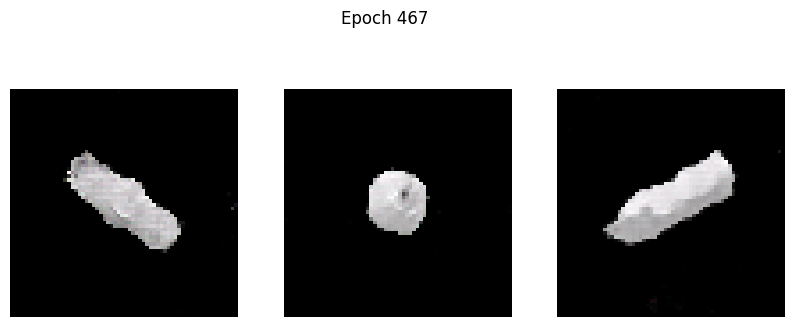

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0179 - g_loss: 8.1538
Epoch 468/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0144 - g_loss: 8.0213

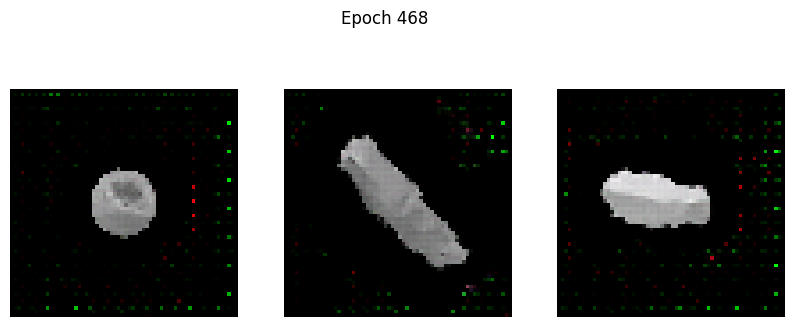

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0139 - g_loss: 8.0267
Epoch 469/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0243 - g_loss: 8.5205

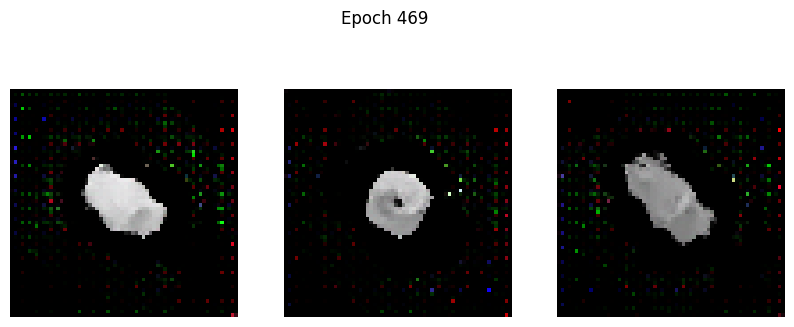

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0246 - g_loss: 8.5196
Epoch 470/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0901 - g_loss: 7.4194

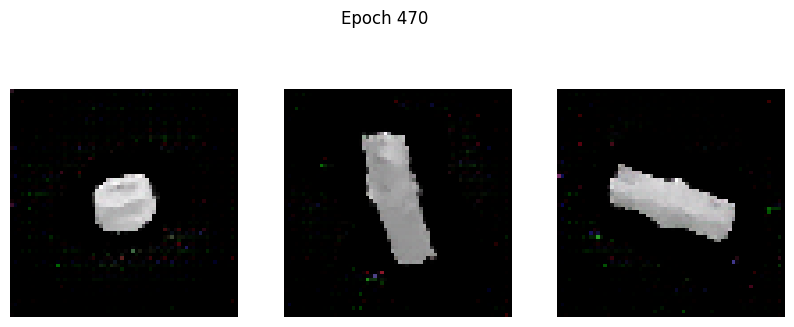

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0903 - g_loss: 7.4179
Epoch 471/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0683 - g_loss: 7.6686

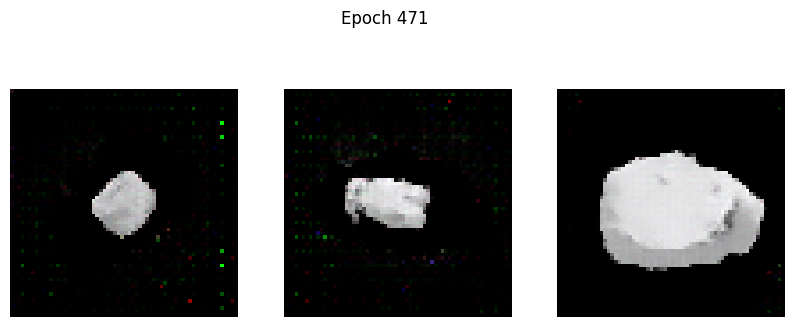

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0678 - g_loss: 7.6717
Epoch 472/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0781 - g_loss: 7.5993

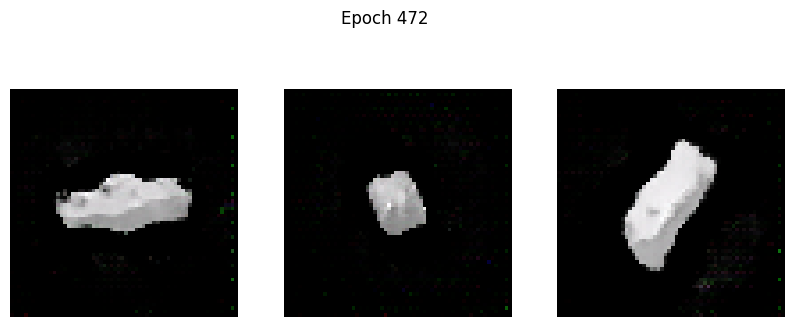

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0778 - g_loss: 7.5983
Epoch 473/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0141 - g_loss: 7.8372

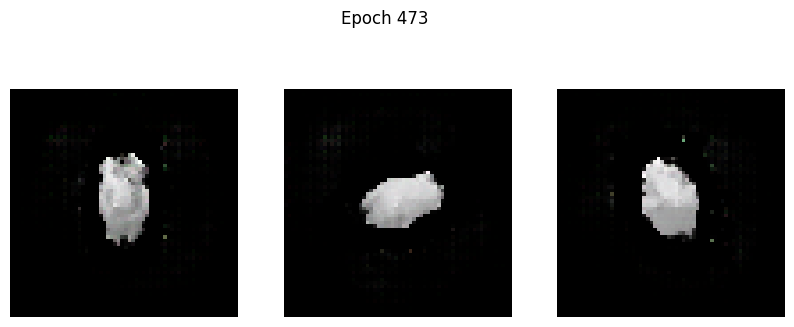

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0137 - g_loss: 7.8358
Epoch 474/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0900 - g_loss: 7.2053

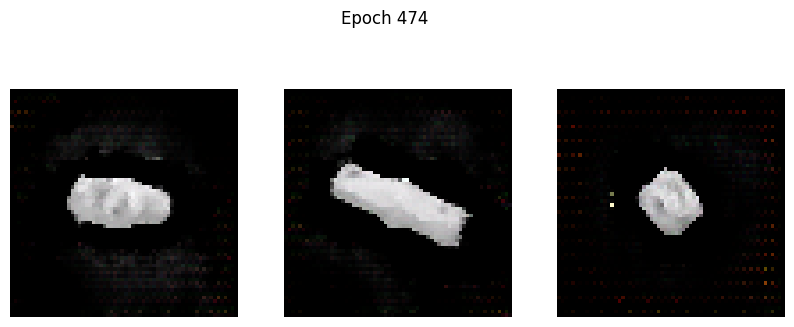

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0900 - g_loss: 7.2069
Epoch 475/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0127 - g_loss: 8.2327

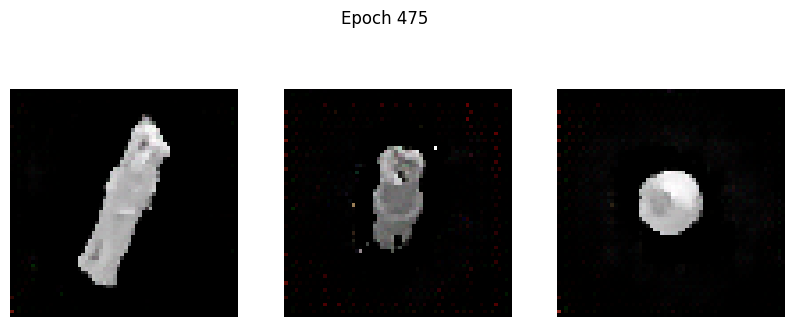

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0122 - g_loss: 8.2295
Epoch 476/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0160 - g_loss: 7.9622

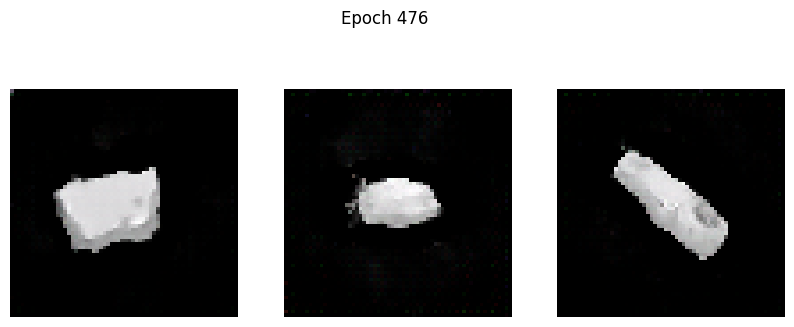

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0161 - g_loss: 7.9608
Epoch 477/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1350 - g_loss: 6.9250

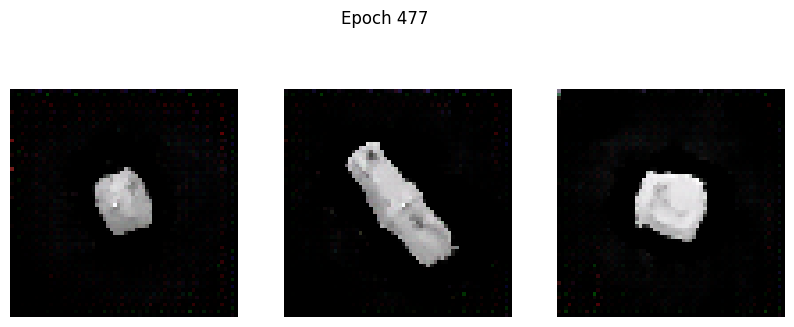

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1348 - g_loss: 6.9279
Epoch 478/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1123 - g_loss: 7.1784

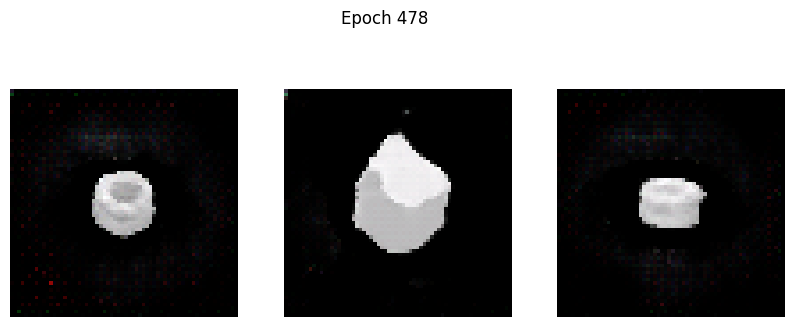

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1122 - g_loss: 7.1792
Epoch 479/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1570 - g_loss: 7.2616

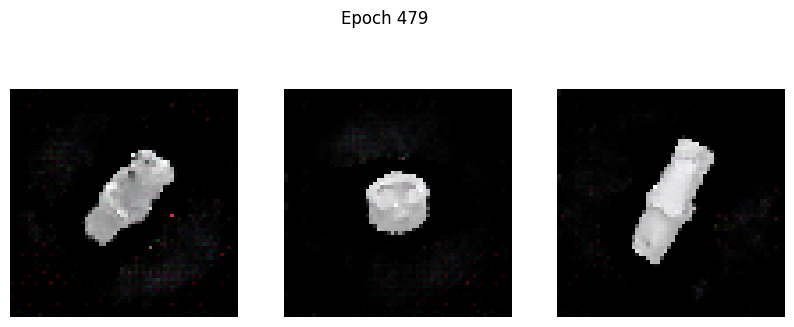

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1566 - g_loss: 7.2617
Epoch 480/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0939 - g_loss: 7.5865

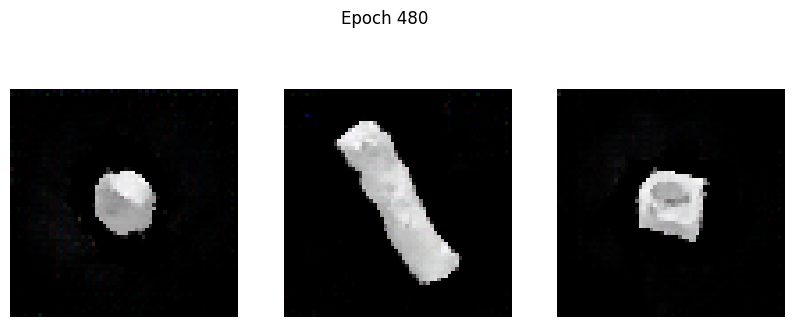

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0939 - g_loss: 7.5849
Epoch 481/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1076 - g_loss: 7.6763

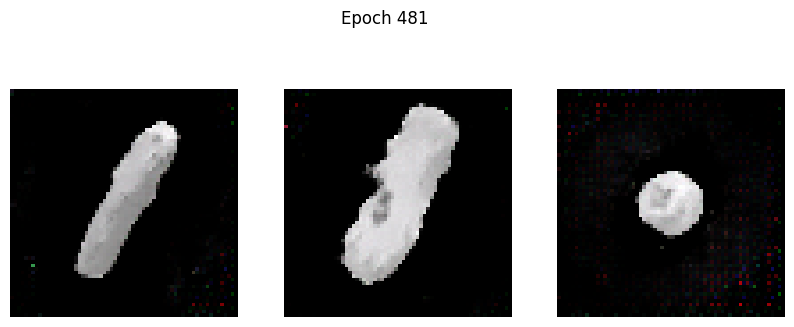

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1074 - g_loss: 7.6757
Epoch 482/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0906 - g_loss: 7.4040

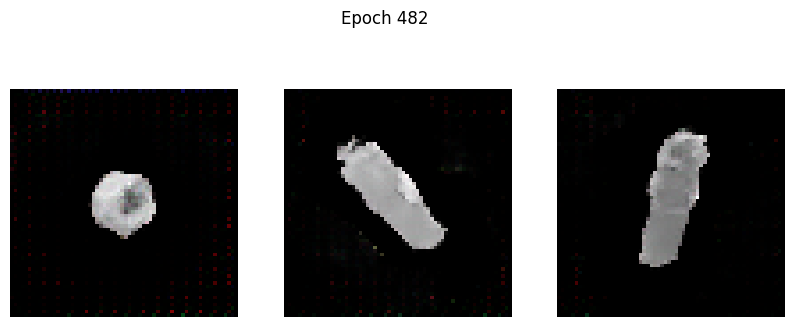

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0907 - g_loss: 7.4028
Epoch 483/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0552 - g_loss: 7.3206

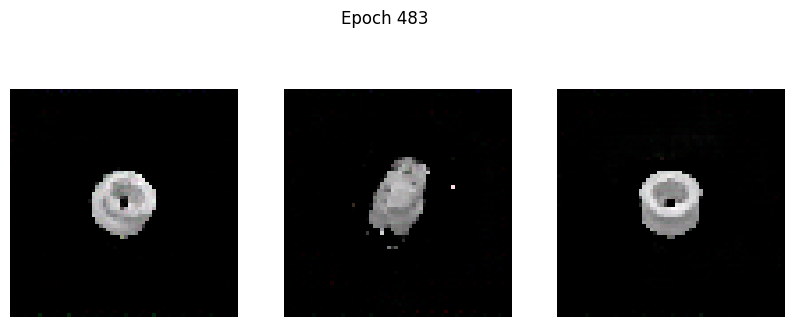

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0552 - g_loss: 7.3214
Epoch 484/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1461 - g_loss: 6.9290

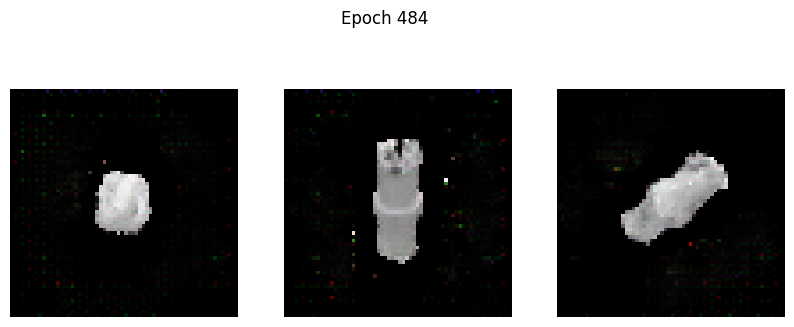

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1458 - g_loss: 6.9315
Epoch 485/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0152 - g_loss: 7.9842

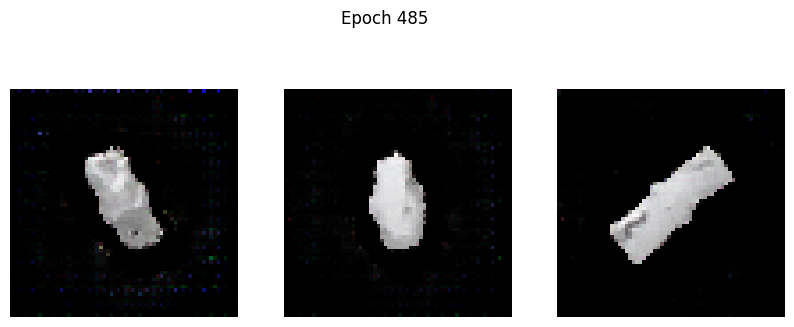

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0153 - g_loss: 7.9835
Epoch 486/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0768 - g_loss: 7.5145

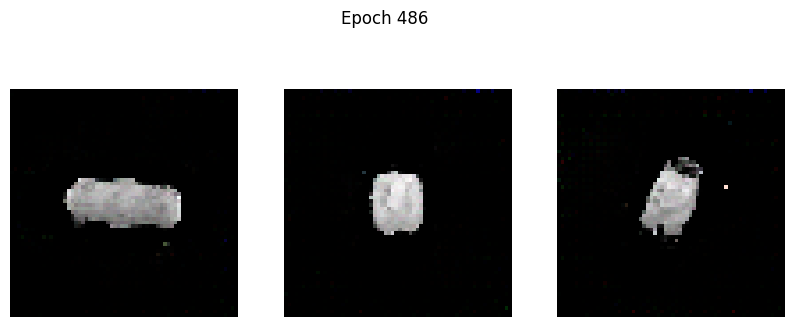

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0772 - g_loss: 7.5141
Epoch 487/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1839 - g_loss: 6.9116

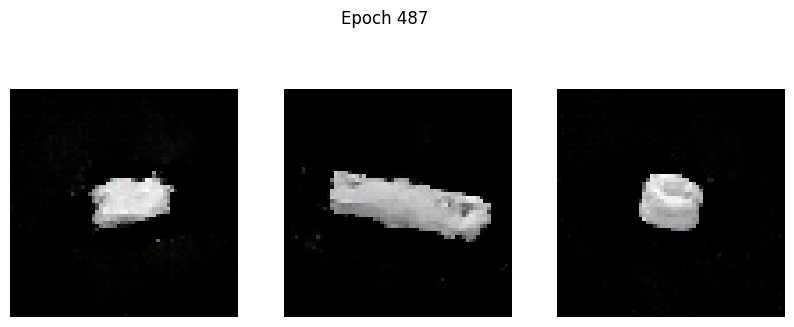

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1837 - g_loss: 6.9149
Epoch 488/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1451 - g_loss: 7.1860

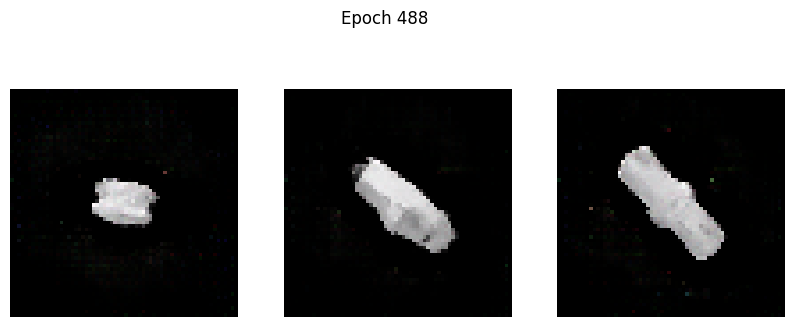

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1452 - g_loss: 7.1860
Epoch 489/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0717 - g_loss: 7.7417

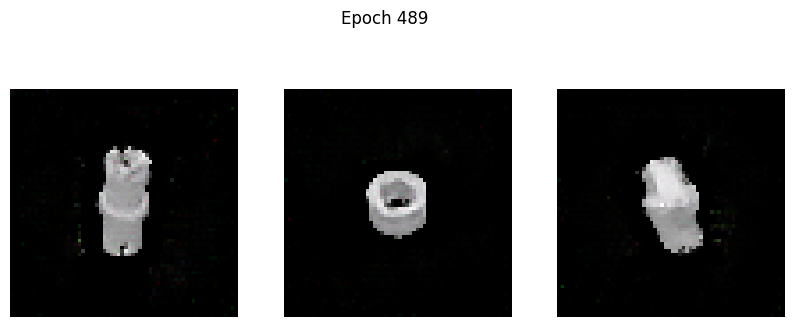

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0721 - g_loss: 7.7418
Epoch 490/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1115 - g_loss: 7.7035

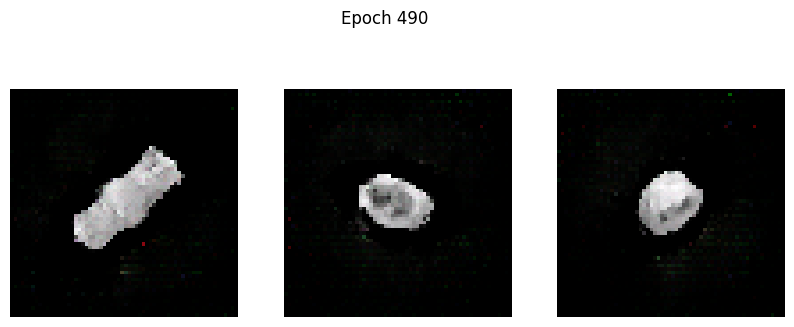

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1109 - g_loss: 7.7051
Epoch 491/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1693 - g_loss: 7.1158

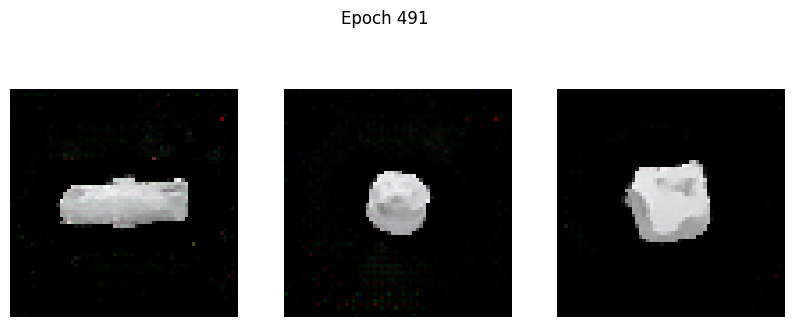

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1692 - g_loss: 7.1150
Epoch 492/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0463 - g_loss: 8.2993

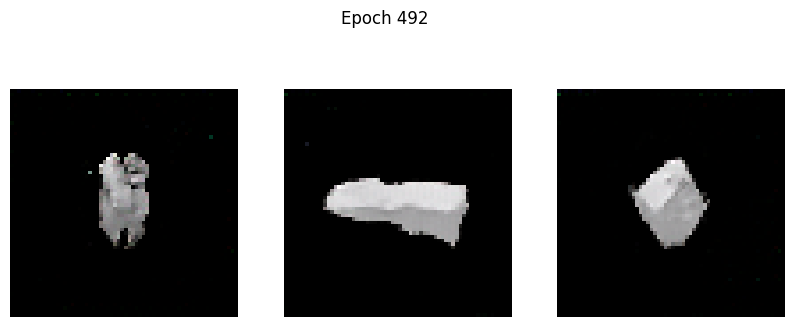

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0468 - g_loss: 8.2971
Epoch 493/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1432 - g_loss: 7.0249

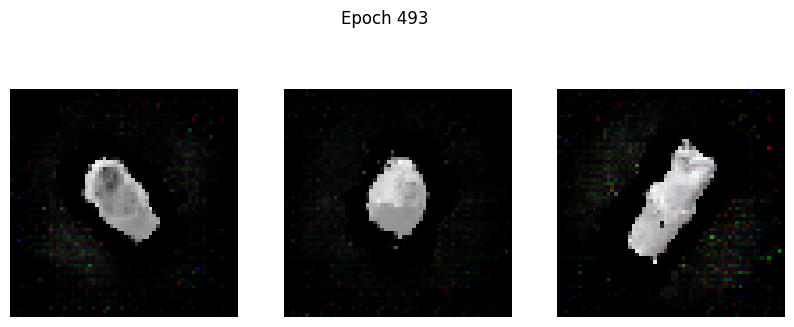

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1436 - g_loss: 7.0247
Epoch 494/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0631 - g_loss: 8.6124

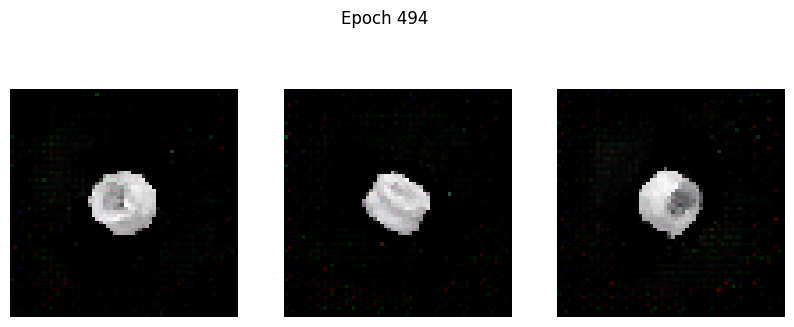

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0624 - g_loss: 8.6064
Epoch 495/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1133 - g_loss: 8.4685

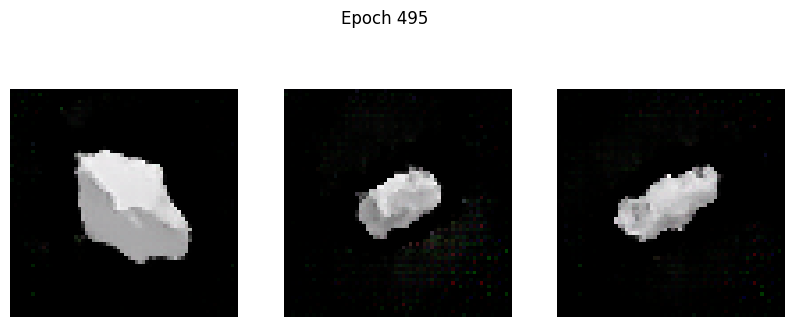

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: -0.1133 - g_loss: 8.4637
Epoch 496/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1410 - g_loss: 7.4303

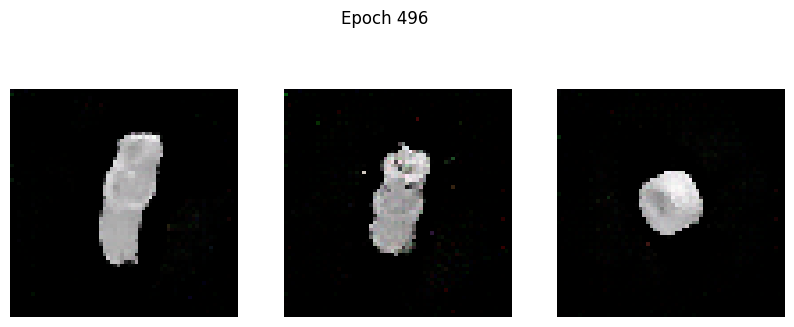

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: -0.1410 - g_loss: 7.4287
Epoch 497/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1939 - g_loss: 7.1483

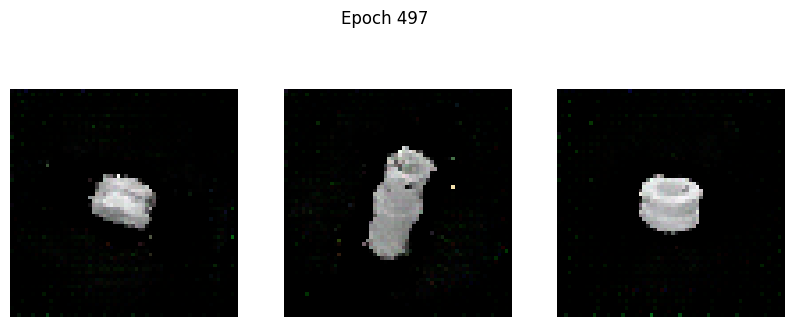

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1933 - g_loss: 7.1529
Epoch 498/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0711 - g_loss: 7.7508

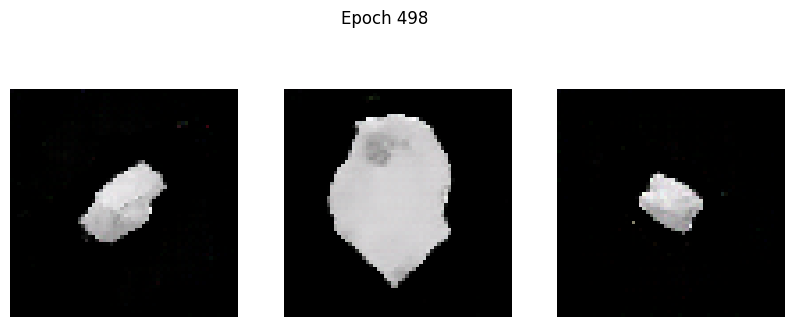

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0707 - g_loss: 7.7540
Epoch 499/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1084 - g_loss: 7.7745

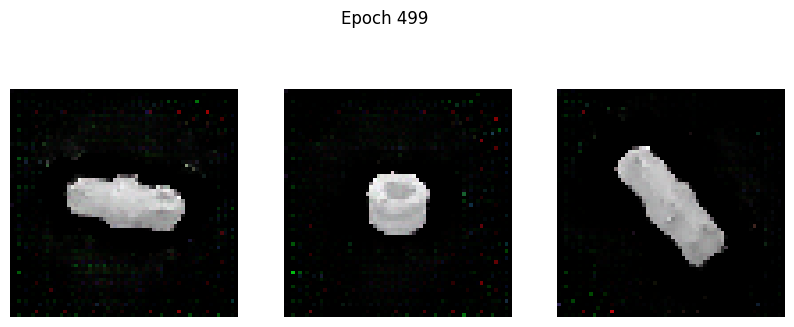

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1082 - g_loss: 7.7775
Epoch 500/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.2058 - g_loss: 7.6459

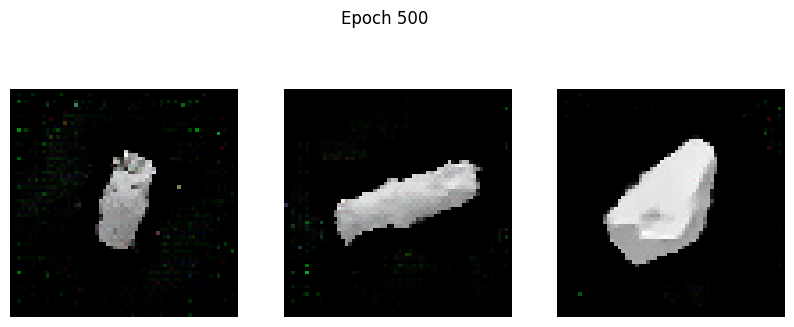

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.2058 - g_loss: 7.6463


In [9]:
# Hyperparameters
EPOCHS = 500  # Tambahkan jumlah epoch untuk hasil lebih baik (misal: 100-200)
lr_generator = 0.0002
lr_discriminator = 0.0002

# Inisialisasi DCGAN
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

# Compile
dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr_discriminator, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr_generator, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

# Jalankan Training
print("Mulai Training...")
dcgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

### **2. MENYIMPAN MODEL GENERATOR**

In [10]:
# MENYIMPAN GENERATOR
# Format .keras direkomendasikan untuk versi TensorFlow terbaru
nama_file_model = "generator_dcgan_500epochs.keras"

generator.save(nama_file_model)
print(f"Model generator berhasil disimpan sebagai: {nama_file_model}")

Model generator berhasil disimpan sebagai: generator_dcgan_500epochs.keras


### **3. GENERATE 5 GAMBAR BARU**

Sedang men-generate 5 gambar acak...


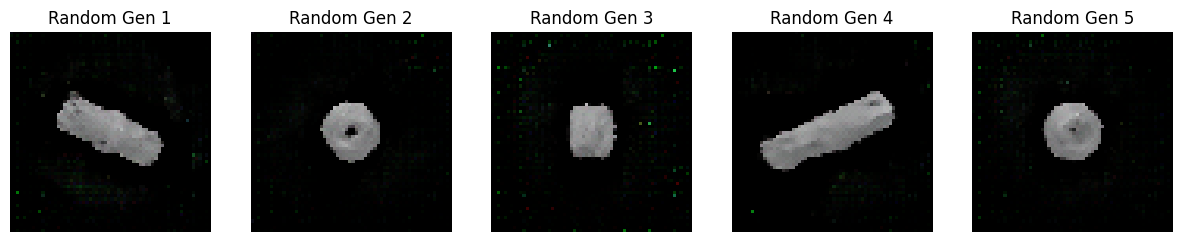

In [11]:
# GENERATE 5 GAMBAR BARU
import matplotlib.pyplot as plt
import tensorflow as tf

def generate_dan_tampilkan(model, jumlah_gambar=5, dimensi_latent=128):
    # 1. Buat noise acak (Latent Vectors)
    noise = tf.random.normal(shape=(jumlah_gambar, dimensi_latent))

    # 2. Prediksi menggunakan generator
    gambar_generated = model(noise, training=False)

    # 3. Denormalisasi (dari [-1, 1] ke [0, 255])
    gambar_generated = (gambar_generated * 127.5) + 127.5
    gambar_generated = gambar_generated.numpy().astype("uint8")

    # 4. Tampilkan Gambar
    plt.figure(figsize=(15, 5))
    for i in range(jumlah_gambar):
        plt.subplot(1, jumlah_gambar, i+1)
        plt.imshow(gambar_generated[i])
        plt.title(f"Random Gen {i+1}")
        plt.axis('off')
    plt.show()

# Panggil fungsi
print("Sedang men-generate 5 gambar acak...")
generate_dan_tampilkan(generator, jumlah_gambar=5, dimensi_latent=latent_dim)

### **4. LATENT SPACE INTERPOLATION**

Membuat transisi gambar (Interpolasi)...


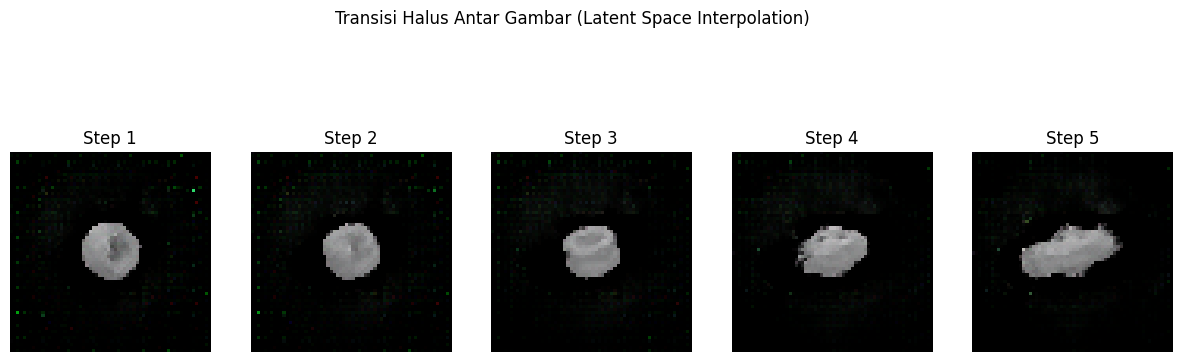

In [12]:
# LATENT SPACE INTERPOLATION
import numpy as np

def interpolasi_latent(model, dimensi_latent=128, n_langkah=5):
    # 1. Ambil dua titik acak di latent space (Start & End)
    titik_a = tf.random.normal(shape=(1, dimensi_latent))
    titik_b = tf.random.normal(shape=(1, dimensi_latent))

    # 2. Buat rasio interpolasi (0.0 sampai 1.0)
    rasio = np.linspace(0, 1, num=n_langkah)

    # 3. Hitung vektor transisi di antara titik A dan titik B
    vektor_interpolasi = []
    for r in rasio:
        v = (1.0 - r) * titik_a + r * titik_b
        vektor_interpolasi.append(v)
    vektor_interpolasi = tf.reshape(tf.convert_to_tensor(vektor_interpolasi), (n_langkah, dimensi_latent))

    # 4. Generate gambar dari vektor hasil interpolasi
    gambar_interpolasi = model(vektor_interpolasi, training=False)
    gambar_interpolasi = (gambar_interpolasi * 127.5) + 127.5
    gambar_interpolasi = gambar_interpolasi.numpy().astype("uint8")

    # 5. Visualisasi hasil transisi
    plt.figure(figsize=(15, 5))
    for i in range(n_langkah):
        plt.subplot(1, n_langkah, i+1)
        plt.imshow(gambar_interpolasi[i])
        plt.title(f"Step {i+1}")
        plt.axis('off')
    plt.suptitle("Transisi Halus Antar Gambar (Latent Space Interpolation)")
    plt.show()

# Panggil fungsi
print("Membuat transisi gambar (Interpolasi)...")
interpolasi_latent(generator, dimensi_latent=latent_dim, n_langkah=5)